In [216]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as tf
import torch.optim as optim

from utils import flow2rgb
from utils import rgb2gray
from utils import read_flo
from utils import read_image

from scipy.integrate import dblquad
from numpy.linalg import norm

In [217]:
def numpy2torch(array):
    """ Converts 3D numpy HWC ndarray to 3D PyTorch CHW tensor."""
    assert (array.ndim == 3)

    result = np.copy(array)
    result = np.moveaxis(result,[1,2,0],[2,0,1])
    result = torch.from_numpy(result)
    
    return result


In [218]:
a=np.ones([2,3,4]) #HWC -> CHW 312
a.shape

(2, 3, 4)

In [219]:
b=numpy2torch(a)
b.shape

torch.Size([4, 2, 3])

In [220]:
def torch2numpy(tensor):
    """ Convert 3D PyTorch CHW tensor to 3D numpy HWC ndarray."""
    assert (tensor.dim() == 3)

    result = tensor.clone().permute(1,2,0).numpy()
    return result

In [221]:
torch2numpy(b).shape

(2, 3, 4)

In [222]:
def load_data(im1_filename, im2_filename, flo_filename):
    """ Loads images and flow ground truth. Returns 4D tensors."""
    i0_path = os.path.dirname(os.path.abspath("A3_P2"))+"/"+im1_filename
    i1_path = os.path.dirname(os.path.abspath("A3_P2"))+"/"+im2_filename
    flo_path = os.path.dirname(os.path.abspath("A3_P2"))+"/"+flo_filename
    i0 = read_image(i0_path)
    i0 = rgb2gray(i0)
    i1 = read_image(i1_path)
    i1 = rgb2gray(i1)    
    tensor1 = numpy2torch(i0).view(1,1,i0.shape[0],i0.shape[1])
    tensor2 = numpy2torch(i1).view(1,1,i1.shape[0],i1.shape[1])
    flow_gt = numpy2torch(read_flo(flo_path)).view(1,2,i1.shape[0],i1.shape[1])

    return tensor1, tensor2, flow_gt

In [223]:
i0,i1,flo=load_data("frame10.png","frame11.png","flow10.flo")
flo.shape

torch.Size([1, 2, 388, 584])

In [224]:
def evaluate_flow(flow, flow_gt):
    """
    Evaluate the average endpoint error w.r.t the ground truth flow_gt.
    Excludes pixels, where u or v components of flow_gt have values > 1e9.
    """
    
    assert (flow.dim() == 4 and flow_gt.dim() == 4)
    assert (flow.size(1) == 2 and flow_gt.size(1) == 2)

    #u = flow[0,0,:,:] * flow[0,0,:,:].le(1e9).float()
    #v = flow[0,1,:,:] * flow[0,1,:,:].le(1e9).float()
    u = flow[0,0,:,:]
    v = flow[0,0,:,:]
    
    # Filter for invalid pixels
    u_gt = flow_gt[0,0,:,:] * flow_gt[0,0,:,:].le(1e9).float()
    v_gt = flow_gt[0,1,:,:] * flow_gt[0,1,:,:].le(1e9).float()

    # AEPE for each pixel
    errors = np.sqrt((u-u_gt)**2 + (v-v_gt)**2)
    
    print(errors)
    
    # Average over all pixels
    aepe = sum(sum(errors))/errors.nelement()

    return aepe

In [225]:
def warp_image(im, flow):
    """ Warps given image according to the given optical flow."""
    assert (im.dim() == 4 and flow.dim() == 4)
    assert (im.size(1) in [1,3] and flow.size(1) == 2)

    # Permute dimensions and range of flow for grid_sample()
    flow = flow.permute(0,2,3,1)
    flow[0,:,:,0] /= torch.max(flow[0,:,:,0])
    flow[0,:,:,1] /= torch.max(flow[0,:,:,1])

    warped = torch.nn.functional.grid_sample(im,flow)

    return warped

In [226]:
def visualize_warping_practice(im1, im2, flow_gt):
    """ Visualizes the result of warping the second image by ground truth."""
    assert (im1.dim() == 4 and im2.dim() == 4 and flow_gt.dim() == 4)
    assert (im1.size(1) in [1,3] and im2.size(1) in [1,3] and flow_gt.size(1) == 2)
    
    warped_im2 = warp_image(im2, flow_gt)
    
    plt.figure(figsize=(15,15))
    plt.subplot(131)
    plt.title("Image 1")
    plt.imshow(im1[0,0,:,:], cmap="gray")
    plt.subplot(132)
    plt.title("Warped Image 2")
    plt.imshow(warped_im2[0,0,:,:], cmap="gray")
    plt.subplot(133)
    plt.title("Difference")
    plt.imshow(im1[0,0,:,:]-warped_im2[0,0,:,:], cmap="gray")
    plt.show()
    
    return None

In [227]:
def energy_hs(im1, im2, flow, lambda_hs):
    """ Evalutes Horn-Schunck energy function."""
    assert (im1.dim() == 4 and im2.dim() == 4 and flow.dim() == 4)
    assert (im1.size(1) == 1 and im2.size(1) == 1 and flow.size(1) == 2)
    
    
    """
    def grad_u(x,y): return np.gradient(flow[0,0,:,:])[x,y]
    def grad_v(x,y): return np.gradient(flow[0,1,:,:])[x,y]
    # TODO: Interpolate It1 and It0
    def It1(x,y): return warp_image(im2,flow)[0,0,x,y]
    def It0(x,y): return im1[0,0,x,y]

    def integral(x,y):
        return (It1(x,y)-It0(x,y))**2 + lambda_hs*(np.norm(grad_u)**2 + np.norm(grad_v)**2)
    
    energy = dblquad(integral, -np.inf, np.inf, -np.inf, np.inf)
    """
    
    # Use sum instead of integral (discrete pixels in picture)
    It1 = warp_image(im2,flow)[0,0,:,:]
    It0 = im1[0,0,:,:]
    grad_u = np.array(np.gradient(flow[0,0,:,:]))
    grad_v = np.array(np.gradient(flow[0,1,:,:]))
    
    energy = 0
    for x in np.arange(0, np.shape(It1)[0]):
        for y in np.arange(0, np.shape(It1)[1]):
            energy += (It1[x,y]-It0[x,y])**2 + lambda_hs*(norm(grad_u[:,x,y])**2 + norm(grad_v[:,x,y])**2)
    return energy

In [228]:
def estimate_flow(im1, im2, flow_gt, lambda_hs, learning_rate, num_iter):
    """
    Estimate flow using HS with Gradient Descent.
    Displays average endpoint error.
    Visualizes flow field.

    Returns estimated flow]
    """
    assert (im1.dim() == 4 and im2.dim() == 4 and flow_gt.dim() == 4)
    assert (im1.size(1) == 1 and im2.size(1) == 1 and flow_gt.size(1) == 2)

    return

In [229]:
def estimate_flow_LBFGS(im1, im2, flow_gt, lambda_hs, learning_rate, num_iter):
    """
    Estimates flow using HS with LBFGS.
    Displays average endpoint error.
    Visualizes flow field.

    Returns estimated flow
    """
    assert (im1.dim() == 4 and im2.dim() == 4 and flow_gt.dim() == 4)
    assert (im1.size(1) == 1 and im2.size(1) == 1 and flow_gt.size(1) == 2)

    return

In [230]:
def estimate_flow_coarse_to_fine(im1, im2, flow_gt, lambda_hs, learning_rate,
                                 num_iter, num_level):
    """
    Estimates flow using HS with LBFGS in a coarse-to-fine scheme.
    Displays average endpoint error.
    Visualizes flow field.

    Returns estimated flow
    """
    assert (im1.dim() == 4 and im2.dim() == 4 and flow_gt.dim() == 4)
    assert (im1.size(1) == 1 and im2.size(1) == 1 and flow_gt.size(1) == 2)

    return

In [231]:
def problem2():

    # Loading data
    im1, im2, flow_gt = load_data("frame10.png", "frame11.png", "flow10.flo")


    # Parameters
    lambda_hs = 0.0015
    num_iter = 400

    # Warping_practice
    visualize_warping_practice(im1, im2, flow_gt)

    print("HS: ", energy_hs(im1,im2,flow_gt,lambda_hs))
    """
    # Gradient descent
    learning_rate = 20
    estimate_flow(im1, im2, flow_gt, lambda_hs, learning_rate, num_iter)

    # LBFGS
    learning_rate = 1
    estimate_flow_LBFGS(im1, im2, flow_gt, lambda_hs, learning_rate, num_iter)

    # Coarse to fine
    learning_rate = 1
    num_level = 4
    estimate_flow_coarse_to_fine(
        im1, im2, flow_gt, lambda_hs, learning_rate, num_iter, num_level)
    """

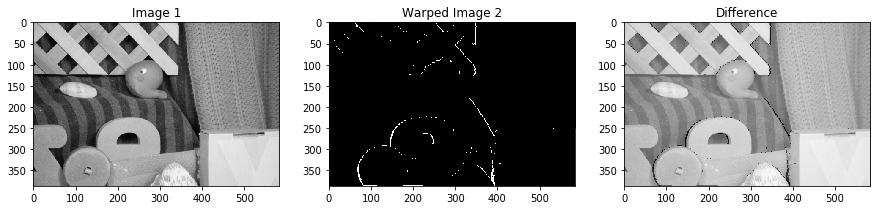

It1:<class 'torch.Tensor'> It0:<class 'torch.Tensor'> grad_u:<class 'numpy.ndarray'> grad_v:<class 'numpy.ndarray'>
It1:  torch.Size([388, 584])
It0:  torch.Size([388, 584])
grad_u:  (2, 388, 584)
grad_v:  (2, 388, 584)
X: 0 Y: 0
X: 0 Y: 1
X: 0 Y: 2
X: 0 Y: 3
X: 0 Y: 4
X: 0 Y: 5
X: 0 Y: 6
X: 0 Y: 7
X: 0 Y: 8
X: 0 Y: 9
X: 0 Y: 10
X: 0 Y: 11
X: 0 Y: 12
X: 0 Y: 13
X: 0 Y: 14
X: 0 Y: 15
X: 0 Y: 16
X: 0 Y: 17
X: 0 Y: 18
X: 0 Y: 19
X: 0 Y: 20
X: 0 Y: 21
X: 0 Y: 22
X: 0 Y: 23
X: 0 Y: 24
X: 0 Y: 25
X: 0 Y: 26
X: 0 Y: 27
X: 0 Y: 28
X: 0 Y: 29
X: 0 Y: 30
X: 0 Y: 31
X: 0 Y: 32
X: 0 Y: 33
X: 0 Y: 34
X: 0 Y: 35
X: 0 Y: 36
X: 0 Y: 37
X: 0 Y: 38
X: 0 Y: 39
X: 0 Y: 40
X: 0 Y: 41
X: 0 Y: 42
X: 0 Y: 43
X: 0 Y: 44
X: 0 Y: 45
X: 0 Y: 46
X: 0 Y: 47
X: 0 Y: 48
X: 0 Y: 49
X: 0 Y: 50
X: 0 Y: 51
X: 0 Y: 52
X: 0 Y: 53
X: 0 Y: 54
X: 0 Y: 55
X: 0 Y: 56
X: 0 Y: 57
X: 0 Y: 58
X: 0 Y: 59
X: 0 Y: 60
X: 0 Y: 61
X: 0 Y: 62
X: 0 Y: 63
X: 0 Y: 64
X: 0 Y: 65
X: 0 Y: 66
X: 0 Y: 67
X: 0 Y: 68
X: 0 Y: 69
X: 0 Y: 70
X: 0 Y: 7

X: 1 Y: 144
X: 1 Y: 145
X: 1 Y: 146
X: 1 Y: 147
X: 1 Y: 148
X: 1 Y: 149
X: 1 Y: 150
X: 1 Y: 151
X: 1 Y: 152
X: 1 Y: 153
X: 1 Y: 154
X: 1 Y: 155
X: 1 Y: 156
X: 1 Y: 157
X: 1 Y: 158
X: 1 Y: 159
X: 1 Y: 160
X: 1 Y: 161
X: 1 Y: 162
X: 1 Y: 163
X: 1 Y: 164
X: 1 Y: 165
X: 1 Y: 166
X: 1 Y: 167
X: 1 Y: 168
X: 1 Y: 169
X: 1 Y: 170
X: 1 Y: 171
X: 1 Y: 172
X: 1 Y: 173
X: 1 Y: 174
X: 1 Y: 175
X: 1 Y: 176
X: 1 Y: 177
X: 1 Y: 178
X: 1 Y: 179
X: 1 Y: 180
X: 1 Y: 181
X: 1 Y: 182
X: 1 Y: 183
X: 1 Y: 184
X: 1 Y: 185
X: 1 Y: 186
X: 1 Y: 187
X: 1 Y: 188
X: 1 Y: 189
X: 1 Y: 190
X: 1 Y: 191
X: 1 Y: 192
X: 1 Y: 193
X: 1 Y: 194
X: 1 Y: 195
X: 1 Y: 196
X: 1 Y: 197
X: 1 Y: 198
X: 1 Y: 199
X: 1 Y: 200
X: 1 Y: 201
X: 1 Y: 202
X: 1 Y: 203
X: 1 Y: 204
X: 1 Y: 205
X: 1 Y: 206
X: 1 Y: 207
X: 1 Y: 208
X: 1 Y: 209
X: 1 Y: 210
X: 1 Y: 211
X: 1 Y: 212
X: 1 Y: 213
X: 1 Y: 214
X: 1 Y: 215
X: 1 Y: 216
X: 1 Y: 217
X: 1 Y: 218
X: 1 Y: 219
X: 1 Y: 220
X: 1 Y: 221
X: 1 Y: 222
X: 1 Y: 223
X: 1 Y: 224
X: 1 Y: 225
X: 1 Y: 226
X: 1

X: 2 Y: 346
X: 2 Y: 347
X: 2 Y: 348
X: 2 Y: 349
X: 2 Y: 350
X: 2 Y: 351
X: 2 Y: 352
X: 2 Y: 353
X: 2 Y: 354
X: 2 Y: 355
X: 2 Y: 356
X: 2 Y: 357
X: 2 Y: 358
X: 2 Y: 359
X: 2 Y: 360
X: 2 Y: 361
X: 2 Y: 362
X: 2 Y: 363
X: 2 Y: 364
X: 2 Y: 365
X: 2 Y: 366
X: 2 Y: 367
X: 2 Y: 368
X: 2 Y: 369
X: 2 Y: 370
X: 2 Y: 371
X: 2 Y: 372
X: 2 Y: 373
X: 2 Y: 374
X: 2 Y: 375
X: 2 Y: 376
X: 2 Y: 377
X: 2 Y: 378
X: 2 Y: 379
X: 2 Y: 380
X: 2 Y: 381
X: 2 Y: 382
X: 2 Y: 383
X: 2 Y: 384
X: 2 Y: 385
X: 2 Y: 386
X: 2 Y: 387
X: 2 Y: 388
X: 2 Y: 389
X: 2 Y: 390
X: 2 Y: 391
X: 2 Y: 392
X: 2 Y: 393
X: 2 Y: 394
X: 2 Y: 395
X: 2 Y: 396
X: 2 Y: 397
X: 2 Y: 398
X: 2 Y: 399
X: 2 Y: 400
X: 2 Y: 401
X: 2 Y: 402
X: 2 Y: 403
X: 2 Y: 404
X: 2 Y: 405
X: 2 Y: 406
X: 2 Y: 407
X: 2 Y: 408
X: 2 Y: 409
X: 2 Y: 410
X: 2 Y: 411
X: 2 Y: 412
X: 2 Y: 413
X: 2 Y: 414
X: 2 Y: 415
X: 2 Y: 416
X: 2 Y: 417
X: 2 Y: 418
X: 2 Y: 419
X: 2 Y: 420
X: 2 Y: 421
X: 2 Y: 422
X: 2 Y: 423
X: 2 Y: 424
X: 2 Y: 425
X: 2 Y: 426
X: 2 Y: 427
X: 2 Y: 428
X: 2

X: 3 Y: 581
X: 3 Y: 582
X: 3 Y: 583
X: 4 Y: 0
X: 4 Y: 1
X: 4 Y: 2
X: 4 Y: 3
X: 4 Y: 4
X: 4 Y: 5
X: 4 Y: 6
X: 4 Y: 7
X: 4 Y: 8
X: 4 Y: 9
X: 4 Y: 10
X: 4 Y: 11
X: 4 Y: 12
X: 4 Y: 13
X: 4 Y: 14
X: 4 Y: 15
X: 4 Y: 16
X: 4 Y: 17
X: 4 Y: 18
X: 4 Y: 19
X: 4 Y: 20
X: 4 Y: 21
X: 4 Y: 22
X: 4 Y: 23
X: 4 Y: 24
X: 4 Y: 25
X: 4 Y: 26
X: 4 Y: 27
X: 4 Y: 28
X: 4 Y: 29
X: 4 Y: 30
X: 4 Y: 31
X: 4 Y: 32
X: 4 Y: 33
X: 4 Y: 34
X: 4 Y: 35
X: 4 Y: 36
X: 4 Y: 37
X: 4 Y: 38
X: 4 Y: 39
X: 4 Y: 40
X: 4 Y: 41
X: 4 Y: 42
X: 4 Y: 43
X: 4 Y: 44
X: 4 Y: 45
X: 4 Y: 46
X: 4 Y: 47
X: 4 Y: 48
X: 4 Y: 49
X: 4 Y: 50
X: 4 Y: 51
X: 4 Y: 52
X: 4 Y: 53
X: 4 Y: 54
X: 4 Y: 55
X: 4 Y: 56
X: 4 Y: 57
X: 4 Y: 58
X: 4 Y: 59
X: 4 Y: 60
X: 4 Y: 61
X: 4 Y: 62
X: 4 Y: 63
X: 4 Y: 64
X: 4 Y: 65
X: 4 Y: 66
X: 4 Y: 67
X: 4 Y: 68
X: 4 Y: 69
X: 4 Y: 70
X: 4 Y: 71
X: 4 Y: 72
X: 4 Y: 73
X: 4 Y: 74
X: 4 Y: 75
X: 4 Y: 76
X: 4 Y: 77
X: 4 Y: 78
X: 4 Y: 79
X: 4 Y: 80
X: 4 Y: 81
X: 4 Y: 82
X: 4 Y: 83
X: 4 Y: 84
X: 4 Y: 85
X: 4 Y: 86
X: 4 Y: 87
X: 4 Y

X: 5 Y: 176
X: 5 Y: 177
X: 5 Y: 178
X: 5 Y: 179
X: 5 Y: 180
X: 5 Y: 181
X: 5 Y: 182
X: 5 Y: 183
X: 5 Y: 184
X: 5 Y: 185
X: 5 Y: 186
X: 5 Y: 187
X: 5 Y: 188
X: 5 Y: 189
X: 5 Y: 190
X: 5 Y: 191
X: 5 Y: 192
X: 5 Y: 193
X: 5 Y: 194
X: 5 Y: 195
X: 5 Y: 196
X: 5 Y: 197
X: 5 Y: 198
X: 5 Y: 199
X: 5 Y: 200
X: 5 Y: 201
X: 5 Y: 202
X: 5 Y: 203
X: 5 Y: 204
X: 5 Y: 205
X: 5 Y: 206
X: 5 Y: 207
X: 5 Y: 208
X: 5 Y: 209
X: 5 Y: 210
X: 5 Y: 211
X: 5 Y: 212
X: 5 Y: 213
X: 5 Y: 214
X: 5 Y: 215
X: 5 Y: 216
X: 5 Y: 217
X: 5 Y: 218
X: 5 Y: 219
X: 5 Y: 220
X: 5 Y: 221
X: 5 Y: 222
X: 5 Y: 223
X: 5 Y: 224
X: 5 Y: 225
X: 5 Y: 226
X: 5 Y: 227
X: 5 Y: 228
X: 5 Y: 229
X: 5 Y: 230
X: 5 Y: 231
X: 5 Y: 232
X: 5 Y: 233
X: 5 Y: 234
X: 5 Y: 235
X: 5 Y: 236
X: 5 Y: 237
X: 5 Y: 238
X: 5 Y: 239
X: 5 Y: 240
X: 5 Y: 241
X: 5 Y: 242
X: 5 Y: 243
X: 5 Y: 244
X: 5 Y: 245
X: 5 Y: 246
X: 5 Y: 247
X: 5 Y: 248
X: 5 Y: 249
X: 5 Y: 250
X: 5 Y: 251
X: 5 Y: 252
X: 5 Y: 253
X: 5 Y: 254
X: 5 Y: 255
X: 5 Y: 256
X: 5 Y: 257
X: 5 Y: 258
X: 5

X: 6 Y: 401
X: 6 Y: 402
X: 6 Y: 403
X: 6 Y: 404
X: 6 Y: 405
X: 6 Y: 406
X: 6 Y: 407
X: 6 Y: 408
X: 6 Y: 409
X: 6 Y: 410
X: 6 Y: 411
X: 6 Y: 412
X: 6 Y: 413
X: 6 Y: 414
X: 6 Y: 415
X: 6 Y: 416
X: 6 Y: 417
X: 6 Y: 418
X: 6 Y: 419
X: 6 Y: 420
X: 6 Y: 421
X: 6 Y: 422
X: 6 Y: 423
X: 6 Y: 424
X: 6 Y: 425
X: 6 Y: 426
X: 6 Y: 427
X: 6 Y: 428
X: 6 Y: 429
X: 6 Y: 430
X: 6 Y: 431
X: 6 Y: 432
X: 6 Y: 433
X: 6 Y: 434
X: 6 Y: 435
X: 6 Y: 436
X: 6 Y: 437
X: 6 Y: 438
X: 6 Y: 439
X: 6 Y: 440
X: 6 Y: 441
X: 6 Y: 442
X: 6 Y: 443
X: 6 Y: 444
X: 6 Y: 445
X: 6 Y: 446
X: 6 Y: 447
X: 6 Y: 448
X: 6 Y: 449
X: 6 Y: 450
X: 6 Y: 451
X: 6 Y: 452
X: 6 Y: 453
X: 6 Y: 454
X: 6 Y: 455
X: 6 Y: 456
X: 6 Y: 457
X: 6 Y: 458
X: 6 Y: 459
X: 6 Y: 460
X: 6 Y: 461
X: 6 Y: 462
X: 6 Y: 463
X: 6 Y: 464
X: 6 Y: 465
X: 6 Y: 466
X: 6 Y: 467
X: 6 Y: 468
X: 6 Y: 469
X: 6 Y: 470
X: 6 Y: 471
X: 6 Y: 472
X: 6 Y: 473
X: 6 Y: 474
X: 6 Y: 475
X: 6 Y: 476
X: 6 Y: 477
X: 6 Y: 478
X: 6 Y: 479
X: 6 Y: 480
X: 6 Y: 481
X: 6 Y: 482
X: 6 Y: 483
X: 6

X: 8 Y: 137
X: 8 Y: 138
X: 8 Y: 139
X: 8 Y: 140
X: 8 Y: 141
X: 8 Y: 142
X: 8 Y: 143
X: 8 Y: 144
X: 8 Y: 145
X: 8 Y: 146
X: 8 Y: 147
X: 8 Y: 148
X: 8 Y: 149
X: 8 Y: 150
X: 8 Y: 151
X: 8 Y: 152
X: 8 Y: 153
X: 8 Y: 154
X: 8 Y: 155
X: 8 Y: 156
X: 8 Y: 157
X: 8 Y: 158
X: 8 Y: 159
X: 8 Y: 160
X: 8 Y: 161
X: 8 Y: 162
X: 8 Y: 163
X: 8 Y: 164
X: 8 Y: 165
X: 8 Y: 166
X: 8 Y: 167
X: 8 Y: 168
X: 8 Y: 169
X: 8 Y: 170
X: 8 Y: 171
X: 8 Y: 172
X: 8 Y: 173
X: 8 Y: 174
X: 8 Y: 175
X: 8 Y: 176
X: 8 Y: 177
X: 8 Y: 178
X: 8 Y: 179
X: 8 Y: 180
X: 8 Y: 181
X: 8 Y: 182
X: 8 Y: 183
X: 8 Y: 184
X: 8 Y: 185
X: 8 Y: 186
X: 8 Y: 187
X: 8 Y: 188
X: 8 Y: 189
X: 8 Y: 190
X: 8 Y: 191
X: 8 Y: 192
X: 8 Y: 193
X: 8 Y: 194
X: 8 Y: 195
X: 8 Y: 196
X: 8 Y: 197
X: 8 Y: 198
X: 8 Y: 199
X: 8 Y: 200
X: 8 Y: 201
X: 8 Y: 202
X: 8 Y: 203
X: 8 Y: 204
X: 8 Y: 205
X: 8 Y: 206
X: 8 Y: 207
X: 8 Y: 208
X: 8 Y: 209
X: 8 Y: 210
X: 8 Y: 211
X: 8 Y: 212
X: 8 Y: 213
X: 8 Y: 214
X: 8 Y: 215
X: 8 Y: 216
X: 8 Y: 217
X: 8 Y: 218
X: 8 Y: 219
X: 8

X: 9 Y: 442
X: 9 Y: 443
X: 9 Y: 444
X: 9 Y: 445
X: 9 Y: 446
X: 9 Y: 447
X: 9 Y: 448
X: 9 Y: 449
X: 9 Y: 450
X: 9 Y: 451
X: 9 Y: 452
X: 9 Y: 453
X: 9 Y: 454
X: 9 Y: 455
X: 9 Y: 456
X: 9 Y: 457
X: 9 Y: 458
X: 9 Y: 459
X: 9 Y: 460
X: 9 Y: 461
X: 9 Y: 462
X: 9 Y: 463
X: 9 Y: 464
X: 9 Y: 465
X: 9 Y: 466
X: 9 Y: 467
X: 9 Y: 468
X: 9 Y: 469
X: 9 Y: 470
X: 9 Y: 471
X: 9 Y: 472
X: 9 Y: 473
X: 9 Y: 474
X: 9 Y: 475
X: 9 Y: 476
X: 9 Y: 477
X: 9 Y: 478
X: 9 Y: 479
X: 9 Y: 480
X: 9 Y: 481
X: 9 Y: 482
X: 9 Y: 483
X: 9 Y: 484
X: 9 Y: 485
X: 9 Y: 486
X: 9 Y: 487
X: 9 Y: 488
X: 9 Y: 489
X: 9 Y: 490
X: 9 Y: 491
X: 9 Y: 492
X: 9 Y: 493
X: 9 Y: 494
X: 9 Y: 495
X: 9 Y: 496
X: 9 Y: 497
X: 9 Y: 498
X: 9 Y: 499
X: 9 Y: 500
X: 9 Y: 501
X: 9 Y: 502
X: 9 Y: 503
X: 9 Y: 504
X: 9 Y: 505
X: 9 Y: 506
X: 9 Y: 507
X: 9 Y: 508
X: 9 Y: 509
X: 9 Y: 510
X: 9 Y: 511
X: 9 Y: 512
X: 9 Y: 513
X: 9 Y: 514
X: 9 Y: 515
X: 9 Y: 516
X: 9 Y: 517
X: 9 Y: 518
X: 9 Y: 519
X: 9 Y: 520
X: 9 Y: 521
X: 9 Y: 522
X: 9 Y: 523
X: 9 Y: 524
X: 9

X: 11 Y: 78
X: 11 Y: 79
X: 11 Y: 80
X: 11 Y: 81
X: 11 Y: 82
X: 11 Y: 83
X: 11 Y: 84
X: 11 Y: 85
X: 11 Y: 86
X: 11 Y: 87
X: 11 Y: 88
X: 11 Y: 89
X: 11 Y: 90
X: 11 Y: 91
X: 11 Y: 92
X: 11 Y: 93
X: 11 Y: 94
X: 11 Y: 95
X: 11 Y: 96
X: 11 Y: 97
X: 11 Y: 98
X: 11 Y: 99
X: 11 Y: 100
X: 11 Y: 101
X: 11 Y: 102
X: 11 Y: 103
X: 11 Y: 104
X: 11 Y: 105
X: 11 Y: 106
X: 11 Y: 107
X: 11 Y: 108
X: 11 Y: 109
X: 11 Y: 110
X: 11 Y: 111
X: 11 Y: 112
X: 11 Y: 113
X: 11 Y: 114
X: 11 Y: 115
X: 11 Y: 116
X: 11 Y: 117
X: 11 Y: 118
X: 11 Y: 119
X: 11 Y: 120
X: 11 Y: 121
X: 11 Y: 122
X: 11 Y: 123
X: 11 Y: 124
X: 11 Y: 125
X: 11 Y: 126
X: 11 Y: 127
X: 11 Y: 128
X: 11 Y: 129
X: 11 Y: 130
X: 11 Y: 131
X: 11 Y: 132
X: 11 Y: 133
X: 11 Y: 134
X: 11 Y: 135
X: 11 Y: 136
X: 11 Y: 137
X: 11 Y: 138
X: 11 Y: 139
X: 11 Y: 140
X: 11 Y: 141
X: 11 Y: 142
X: 11 Y: 143
X: 11 Y: 144
X: 11 Y: 145
X: 11 Y: 146
X: 11 Y: 147
X: 11 Y: 148
X: 11 Y: 149
X: 11 Y: 150
X: 11 Y: 151
X: 11 Y: 152
X: 11 Y: 153
X: 11 Y: 154
X: 11 Y: 155
X: 11 Y:

X: 12 Y: 189
X: 12 Y: 190
X: 12 Y: 191
X: 12 Y: 192
X: 12 Y: 193
X: 12 Y: 194
X: 12 Y: 195
X: 12 Y: 196
X: 12 Y: 197
X: 12 Y: 198
X: 12 Y: 199
X: 12 Y: 200
X: 12 Y: 201
X: 12 Y: 202
X: 12 Y: 203
X: 12 Y: 204
X: 12 Y: 205
X: 12 Y: 206
X: 12 Y: 207
X: 12 Y: 208
X: 12 Y: 209
X: 12 Y: 210
X: 12 Y: 211
X: 12 Y: 212
X: 12 Y: 213
X: 12 Y: 214
X: 12 Y: 215
X: 12 Y: 216
X: 12 Y: 217
X: 12 Y: 218
X: 12 Y: 219
X: 12 Y: 220
X: 12 Y: 221
X: 12 Y: 222
X: 12 Y: 223
X: 12 Y: 224
X: 12 Y: 225
X: 12 Y: 226
X: 12 Y: 227
X: 12 Y: 228
X: 12 Y: 229
X: 12 Y: 230
X: 12 Y: 231
X: 12 Y: 232
X: 12 Y: 233
X: 12 Y: 234
X: 12 Y: 235
X: 12 Y: 236
X: 12 Y: 237
X: 12 Y: 238
X: 12 Y: 239
X: 12 Y: 240
X: 12 Y: 241
X: 12 Y: 242
X: 12 Y: 243
X: 12 Y: 244
X: 12 Y: 245
X: 12 Y: 246
X: 12 Y: 247
X: 12 Y: 248
X: 12 Y: 249
X: 12 Y: 250
X: 12 Y: 251
X: 12 Y: 252
X: 12 Y: 253
X: 12 Y: 254
X: 12 Y: 255
X: 12 Y: 256
X: 12 Y: 257
X: 12 Y: 258
X: 12 Y: 259
X: 12 Y: 260
X: 12 Y: 261
X: 12 Y: 262
X: 12 Y: 263
X: 12 Y: 264
X: 12 Y: 265

X: 13 Y: 340
X: 13 Y: 341
X: 13 Y: 342
X: 13 Y: 343
X: 13 Y: 344
X: 13 Y: 345
X: 13 Y: 346
X: 13 Y: 347
X: 13 Y: 348
X: 13 Y: 349
X: 13 Y: 350
X: 13 Y: 351
X: 13 Y: 352
X: 13 Y: 353
X: 13 Y: 354
X: 13 Y: 355
X: 13 Y: 356
X: 13 Y: 357
X: 13 Y: 358
X: 13 Y: 359
X: 13 Y: 360
X: 13 Y: 361
X: 13 Y: 362
X: 13 Y: 363
X: 13 Y: 364
X: 13 Y: 365
X: 13 Y: 366
X: 13 Y: 367
X: 13 Y: 368
X: 13 Y: 369
X: 13 Y: 370
X: 13 Y: 371
X: 13 Y: 372
X: 13 Y: 373
X: 13 Y: 374
X: 13 Y: 375
X: 13 Y: 376
X: 13 Y: 377
X: 13 Y: 378
X: 13 Y: 379
X: 13 Y: 380
X: 13 Y: 381
X: 13 Y: 382
X: 13 Y: 383
X: 13 Y: 384
X: 13 Y: 385
X: 13 Y: 386
X: 13 Y: 387
X: 13 Y: 388
X: 13 Y: 389
X: 13 Y: 390
X: 13 Y: 391
X: 13 Y: 392
X: 13 Y: 393
X: 13 Y: 394
X: 13 Y: 395
X: 13 Y: 396
X: 13 Y: 397
X: 13 Y: 398
X: 13 Y: 399
X: 13 Y: 400
X: 13 Y: 401
X: 13 Y: 402
X: 13 Y: 403
X: 13 Y: 404
X: 13 Y: 405
X: 13 Y: 406
X: 13 Y: 407
X: 13 Y: 408
X: 13 Y: 409
X: 13 Y: 410
X: 13 Y: 411
X: 13 Y: 412
X: 13 Y: 413
X: 13 Y: 414
X: 13 Y: 415
X: 13 Y: 416

X: 14 Y: 554
X: 14 Y: 555
X: 14 Y: 556
X: 14 Y: 557
X: 14 Y: 558
X: 14 Y: 559
X: 14 Y: 560
X: 14 Y: 561
X: 14 Y: 562
X: 14 Y: 563
X: 14 Y: 564
X: 14 Y: 565
X: 14 Y: 566
X: 14 Y: 567
X: 14 Y: 568
X: 14 Y: 569
X: 14 Y: 570
X: 14 Y: 571
X: 14 Y: 572
X: 14 Y: 573
X: 14 Y: 574
X: 14 Y: 575
X: 14 Y: 576
X: 14 Y: 577
X: 14 Y: 578
X: 14 Y: 579
X: 14 Y: 580
X: 14 Y: 581
X: 14 Y: 582
X: 14 Y: 583
X: 15 Y: 0
X: 15 Y: 1
X: 15 Y: 2
X: 15 Y: 3
X: 15 Y: 4
X: 15 Y: 5
X: 15 Y: 6
X: 15 Y: 7
X: 15 Y: 8
X: 15 Y: 9
X: 15 Y: 10
X: 15 Y: 11
X: 15 Y: 12
X: 15 Y: 13
X: 15 Y: 14
X: 15 Y: 15
X: 15 Y: 16
X: 15 Y: 17
X: 15 Y: 18
X: 15 Y: 19
X: 15 Y: 20
X: 15 Y: 21
X: 15 Y: 22
X: 15 Y: 23
X: 15 Y: 24
X: 15 Y: 25
X: 15 Y: 26
X: 15 Y: 27
X: 15 Y: 28
X: 15 Y: 29
X: 15 Y: 30
X: 15 Y: 31
X: 15 Y: 32
X: 15 Y: 33
X: 15 Y: 34
X: 15 Y: 35
X: 15 Y: 36
X: 15 Y: 37
X: 15 Y: 38
X: 15 Y: 39
X: 15 Y: 40
X: 15 Y: 41
X: 15 Y: 42
X: 15 Y: 43
X: 15 Y: 44
X: 15 Y: 45
X: 15 Y: 46
X: 15 Y: 47
X: 15 Y: 48
X: 15 Y: 49
X: 15 Y: 50
X: 15 Y:

X: 16 Y: 222
X: 16 Y: 223
X: 16 Y: 224
X: 16 Y: 225
X: 16 Y: 226
X: 16 Y: 227
X: 16 Y: 228
X: 16 Y: 229
X: 16 Y: 230
X: 16 Y: 231
X: 16 Y: 232
X: 16 Y: 233
X: 16 Y: 234
X: 16 Y: 235
X: 16 Y: 236
X: 16 Y: 237
X: 16 Y: 238
X: 16 Y: 239
X: 16 Y: 240
X: 16 Y: 241
X: 16 Y: 242
X: 16 Y: 243
X: 16 Y: 244
X: 16 Y: 245
X: 16 Y: 246
X: 16 Y: 247
X: 16 Y: 248
X: 16 Y: 249
X: 16 Y: 250
X: 16 Y: 251
X: 16 Y: 252
X: 16 Y: 253
X: 16 Y: 254
X: 16 Y: 255
X: 16 Y: 256
X: 16 Y: 257
X: 16 Y: 258
X: 16 Y: 259
X: 16 Y: 260
X: 16 Y: 261
X: 16 Y: 262
X: 16 Y: 263
X: 16 Y: 264
X: 16 Y: 265
X: 16 Y: 266
X: 16 Y: 267
X: 16 Y: 268
X: 16 Y: 269
X: 16 Y: 270
X: 16 Y: 271
X: 16 Y: 272
X: 16 Y: 273
X: 16 Y: 274
X: 16 Y: 275
X: 16 Y: 276
X: 16 Y: 277
X: 16 Y: 278
X: 16 Y: 279
X: 16 Y: 280
X: 16 Y: 281
X: 16 Y: 282
X: 16 Y: 283
X: 16 Y: 284
X: 16 Y: 285
X: 16 Y: 286
X: 16 Y: 287
X: 16 Y: 288
X: 16 Y: 289
X: 16 Y: 290
X: 16 Y: 291
X: 16 Y: 292
X: 16 Y: 293
X: 16 Y: 294
X: 16 Y: 295
X: 16 Y: 296
X: 16 Y: 297
X: 16 Y: 298

X: 17 Y: 447
X: 17 Y: 448
X: 17 Y: 449
X: 17 Y: 450
X: 17 Y: 451
X: 17 Y: 452
X: 17 Y: 453
X: 17 Y: 454
X: 17 Y: 455
X: 17 Y: 456
X: 17 Y: 457
X: 17 Y: 458
X: 17 Y: 459
X: 17 Y: 460
X: 17 Y: 461
X: 17 Y: 462
X: 17 Y: 463
X: 17 Y: 464
X: 17 Y: 465
X: 17 Y: 466
X: 17 Y: 467
X: 17 Y: 468
X: 17 Y: 469
X: 17 Y: 470
X: 17 Y: 471
X: 17 Y: 472
X: 17 Y: 473
X: 17 Y: 474
X: 17 Y: 475
X: 17 Y: 476
X: 17 Y: 477
X: 17 Y: 478
X: 17 Y: 479
X: 17 Y: 480
X: 17 Y: 481
X: 17 Y: 482
X: 17 Y: 483
X: 17 Y: 484
X: 17 Y: 485
X: 17 Y: 486
X: 17 Y: 487
X: 17 Y: 488
X: 17 Y: 489
X: 17 Y: 490
X: 17 Y: 491
X: 17 Y: 492
X: 17 Y: 493
X: 17 Y: 494
X: 17 Y: 495
X: 17 Y: 496
X: 17 Y: 497
X: 17 Y: 498
X: 17 Y: 499
X: 17 Y: 500
X: 17 Y: 501
X: 17 Y: 502
X: 17 Y: 503
X: 17 Y: 504
X: 17 Y: 505
X: 17 Y: 506
X: 17 Y: 507
X: 17 Y: 508
X: 17 Y: 509
X: 17 Y: 510
X: 17 Y: 511
X: 17 Y: 512
X: 17 Y: 513
X: 17 Y: 514
X: 17 Y: 515
X: 17 Y: 516
X: 17 Y: 517
X: 17 Y: 518
X: 17 Y: 519
X: 17 Y: 520
X: 17 Y: 521
X: 17 Y: 522
X: 17 Y: 523

X: 19 Y: 77
X: 19 Y: 78
X: 19 Y: 79
X: 19 Y: 80
X: 19 Y: 81
X: 19 Y: 82
X: 19 Y: 83
X: 19 Y: 84
X: 19 Y: 85
X: 19 Y: 86
X: 19 Y: 87
X: 19 Y: 88
X: 19 Y: 89
X: 19 Y: 90
X: 19 Y: 91
X: 19 Y: 92
X: 19 Y: 93
X: 19 Y: 94
X: 19 Y: 95
X: 19 Y: 96
X: 19 Y: 97
X: 19 Y: 98
X: 19 Y: 99
X: 19 Y: 100
X: 19 Y: 101
X: 19 Y: 102
X: 19 Y: 103
X: 19 Y: 104
X: 19 Y: 105
X: 19 Y: 106
X: 19 Y: 107
X: 19 Y: 108
X: 19 Y: 109
X: 19 Y: 110
X: 19 Y: 111
X: 19 Y: 112
X: 19 Y: 113
X: 19 Y: 114
X: 19 Y: 115
X: 19 Y: 116
X: 19 Y: 117
X: 19 Y: 118
X: 19 Y: 119
X: 19 Y: 120
X: 19 Y: 121
X: 19 Y: 122
X: 19 Y: 123
X: 19 Y: 124
X: 19 Y: 125
X: 19 Y: 126
X: 19 Y: 127
X: 19 Y: 128
X: 19 Y: 129
X: 19 Y: 130
X: 19 Y: 131
X: 19 Y: 132
X: 19 Y: 133
X: 19 Y: 134
X: 19 Y: 135
X: 19 Y: 136
X: 19 Y: 137
X: 19 Y: 138
X: 19 Y: 139
X: 19 Y: 140
X: 19 Y: 141
X: 19 Y: 142
X: 19 Y: 143
X: 19 Y: 144
X: 19 Y: 145
X: 19 Y: 146
X: 19 Y: 147
X: 19 Y: 148
X: 19 Y: 149
X: 19 Y: 150
X: 19 Y: 151
X: 19 Y: 152
X: 19 Y: 153
X: 19 Y: 154
X: 19 Y: 

X: 20 Y: 320
X: 20 Y: 321
X: 20 Y: 322
X: 20 Y: 323
X: 20 Y: 324
X: 20 Y: 325
X: 20 Y: 326
X: 20 Y: 327
X: 20 Y: 328
X: 20 Y: 329
X: 20 Y: 330
X: 20 Y: 331
X: 20 Y: 332
X: 20 Y: 333
X: 20 Y: 334
X: 20 Y: 335
X: 20 Y: 336
X: 20 Y: 337
X: 20 Y: 338
X: 20 Y: 339
X: 20 Y: 340
X: 20 Y: 341
X: 20 Y: 342
X: 20 Y: 343
X: 20 Y: 344
X: 20 Y: 345
X: 20 Y: 346
X: 20 Y: 347
X: 20 Y: 348
X: 20 Y: 349
X: 20 Y: 350
X: 20 Y: 351
X: 20 Y: 352
X: 20 Y: 353
X: 20 Y: 354
X: 20 Y: 355
X: 20 Y: 356
X: 20 Y: 357
X: 20 Y: 358
X: 20 Y: 359
X: 20 Y: 360
X: 20 Y: 361
X: 20 Y: 362
X: 20 Y: 363
X: 20 Y: 364
X: 20 Y: 365
X: 20 Y: 366
X: 20 Y: 367
X: 20 Y: 368
X: 20 Y: 369
X: 20 Y: 370
X: 20 Y: 371
X: 20 Y: 372
X: 20 Y: 373
X: 20 Y: 374
X: 20 Y: 375
X: 20 Y: 376
X: 20 Y: 377
X: 20 Y: 378
X: 20 Y: 379
X: 20 Y: 380
X: 20 Y: 381
X: 20 Y: 382
X: 20 Y: 383
X: 20 Y: 384
X: 20 Y: 385
X: 20 Y: 386
X: 20 Y: 387
X: 20 Y: 388
X: 20 Y: 389
X: 20 Y: 390
X: 20 Y: 391
X: 20 Y: 392
X: 20 Y: 393
X: 20 Y: 394
X: 20 Y: 395
X: 20 Y: 396

X: 22 Y: 26
X: 22 Y: 27
X: 22 Y: 28
X: 22 Y: 29
X: 22 Y: 30
X: 22 Y: 31
X: 22 Y: 32
X: 22 Y: 33
X: 22 Y: 34
X: 22 Y: 35
X: 22 Y: 36
X: 22 Y: 37
X: 22 Y: 38
X: 22 Y: 39
X: 22 Y: 40
X: 22 Y: 41
X: 22 Y: 42
X: 22 Y: 43
X: 22 Y: 44
X: 22 Y: 45
X: 22 Y: 46
X: 22 Y: 47
X: 22 Y: 48
X: 22 Y: 49
X: 22 Y: 50
X: 22 Y: 51
X: 22 Y: 52
X: 22 Y: 53
X: 22 Y: 54
X: 22 Y: 55
X: 22 Y: 56
X: 22 Y: 57
X: 22 Y: 58
X: 22 Y: 59
X: 22 Y: 60
X: 22 Y: 61
X: 22 Y: 62
X: 22 Y: 63
X: 22 Y: 64
X: 22 Y: 65
X: 22 Y: 66
X: 22 Y: 67
X: 22 Y: 68
X: 22 Y: 69
X: 22 Y: 70
X: 22 Y: 71
X: 22 Y: 72
X: 22 Y: 73
X: 22 Y: 74
X: 22 Y: 75
X: 22 Y: 76
X: 22 Y: 77
X: 22 Y: 78
X: 22 Y: 79
X: 22 Y: 80
X: 22 Y: 81
X: 22 Y: 82
X: 22 Y: 83
X: 22 Y: 84
X: 22 Y: 85
X: 22 Y: 86
X: 22 Y: 87
X: 22 Y: 88
X: 22 Y: 89
X: 22 Y: 90
X: 22 Y: 91
X: 22 Y: 92
X: 22 Y: 93
X: 22 Y: 94
X: 22 Y: 95
X: 22 Y: 96
X: 22 Y: 97
X: 22 Y: 98
X: 22 Y: 99
X: 22 Y: 100
X: 22 Y: 101
X: 22 Y: 102
X: 22 Y: 103
X: 22 Y: 104
X: 22 Y: 105
X: 22 Y: 106
X: 22 Y: 107
X: 22 Y:

X: 23 Y: 194
X: 23 Y: 195
X: 23 Y: 196
X: 23 Y: 197
X: 23 Y: 198
X: 23 Y: 199
X: 23 Y: 200
X: 23 Y: 201
X: 23 Y: 202
X: 23 Y: 203
X: 23 Y: 204
X: 23 Y: 205
X: 23 Y: 206
X: 23 Y: 207
X: 23 Y: 208
X: 23 Y: 209
X: 23 Y: 210
X: 23 Y: 211
X: 23 Y: 212
X: 23 Y: 213
X: 23 Y: 214
X: 23 Y: 215
X: 23 Y: 216
X: 23 Y: 217
X: 23 Y: 218
X: 23 Y: 219
X: 23 Y: 220
X: 23 Y: 221
X: 23 Y: 222
X: 23 Y: 223
X: 23 Y: 224
X: 23 Y: 225
X: 23 Y: 226
X: 23 Y: 227
X: 23 Y: 228
X: 23 Y: 229
X: 23 Y: 230
X: 23 Y: 231
X: 23 Y: 232
X: 23 Y: 233
X: 23 Y: 234
X: 23 Y: 235
X: 23 Y: 236
X: 23 Y: 237
X: 23 Y: 238
X: 23 Y: 239
X: 23 Y: 240
X: 23 Y: 241
X: 23 Y: 242
X: 23 Y: 243
X: 23 Y: 244
X: 23 Y: 245
X: 23 Y: 246
X: 23 Y: 247
X: 23 Y: 248
X: 23 Y: 249
X: 23 Y: 250
X: 23 Y: 251
X: 23 Y: 252
X: 23 Y: 253
X: 23 Y: 254
X: 23 Y: 255
X: 23 Y: 256
X: 23 Y: 257
X: 23 Y: 258
X: 23 Y: 259
X: 23 Y: 260
X: 23 Y: 261
X: 23 Y: 262
X: 23 Y: 263
X: 23 Y: 264
X: 23 Y: 265
X: 23 Y: 266
X: 23 Y: 267
X: 23 Y: 268
X: 23 Y: 269
X: 23 Y: 270

X: 24 Y: 311
X: 24 Y: 312
X: 24 Y: 313
X: 24 Y: 314
X: 24 Y: 315
X: 24 Y: 316
X: 24 Y: 317
X: 24 Y: 318
X: 24 Y: 319
X: 24 Y: 320
X: 24 Y: 321
X: 24 Y: 322
X: 24 Y: 323
X: 24 Y: 324
X: 24 Y: 325
X: 24 Y: 326
X: 24 Y: 327
X: 24 Y: 328
X: 24 Y: 329
X: 24 Y: 330
X: 24 Y: 331
X: 24 Y: 332
X: 24 Y: 333
X: 24 Y: 334
X: 24 Y: 335
X: 24 Y: 336
X: 24 Y: 337
X: 24 Y: 338
X: 24 Y: 339
X: 24 Y: 340
X: 24 Y: 341
X: 24 Y: 342
X: 24 Y: 343
X: 24 Y: 344
X: 24 Y: 345
X: 24 Y: 346
X: 24 Y: 347
X: 24 Y: 348
X: 24 Y: 349
X: 24 Y: 350
X: 24 Y: 351
X: 24 Y: 352
X: 24 Y: 353
X: 24 Y: 354
X: 24 Y: 355
X: 24 Y: 356
X: 24 Y: 357
X: 24 Y: 358
X: 24 Y: 359
X: 24 Y: 360
X: 24 Y: 361
X: 24 Y: 362
X: 24 Y: 363
X: 24 Y: 364
X: 24 Y: 365
X: 24 Y: 366
X: 24 Y: 367
X: 24 Y: 368
X: 24 Y: 369
X: 24 Y: 370
X: 24 Y: 371
X: 24 Y: 372
X: 24 Y: 373
X: 24 Y: 374
X: 24 Y: 375
X: 24 Y: 376
X: 24 Y: 377
X: 24 Y: 378
X: 24 Y: 379
X: 24 Y: 380
X: 24 Y: 381
X: 24 Y: 382
X: 24 Y: 383
X: 24 Y: 384
X: 24 Y: 385
X: 24 Y: 386
X: 24 Y: 387

X: 25 Y: 405
X: 25 Y: 406
X: 25 Y: 407
X: 25 Y: 408
X: 25 Y: 409
X: 25 Y: 410
X: 25 Y: 411
X: 25 Y: 412
X: 25 Y: 413
X: 25 Y: 414
X: 25 Y: 415
X: 25 Y: 416
X: 25 Y: 417
X: 25 Y: 418
X: 25 Y: 419
X: 25 Y: 420
X: 25 Y: 421
X: 25 Y: 422
X: 25 Y: 423
X: 25 Y: 424
X: 25 Y: 425
X: 25 Y: 426
X: 25 Y: 427
X: 25 Y: 428
X: 25 Y: 429
X: 25 Y: 430
X: 25 Y: 431
X: 25 Y: 432
X: 25 Y: 433
X: 25 Y: 434
X: 25 Y: 435
X: 25 Y: 436
X: 25 Y: 437
X: 25 Y: 438
X: 25 Y: 439
X: 25 Y: 440
X: 25 Y: 441
X: 25 Y: 442
X: 25 Y: 443
X: 25 Y: 444
X: 25 Y: 445
X: 25 Y: 446
X: 25 Y: 447
X: 25 Y: 448
X: 25 Y: 449
X: 25 Y: 450
X: 25 Y: 451
X: 25 Y: 452
X: 25 Y: 453
X: 25 Y: 454
X: 25 Y: 455
X: 25 Y: 456
X: 25 Y: 457
X: 25 Y: 458
X: 25 Y: 459
X: 25 Y: 460
X: 25 Y: 461
X: 25 Y: 462
X: 25 Y: 463
X: 25 Y: 464
X: 25 Y: 465
X: 25 Y: 466
X: 25 Y: 467
X: 25 Y: 468
X: 25 Y: 469
X: 25 Y: 470
X: 25 Y: 471
X: 25 Y: 472
X: 25 Y: 473
X: 25 Y: 474
X: 25 Y: 475
X: 25 Y: 476
X: 25 Y: 477
X: 25 Y: 478
X: 25 Y: 479
X: 25 Y: 480
X: 25 Y: 481

X: 26 Y: 500
X: 26 Y: 501
X: 26 Y: 502
X: 26 Y: 503
X: 26 Y: 504
X: 26 Y: 505
X: 26 Y: 506
X: 26 Y: 507
X: 26 Y: 508
X: 26 Y: 509
X: 26 Y: 510
X: 26 Y: 511
X: 26 Y: 512
X: 26 Y: 513
X: 26 Y: 514
X: 26 Y: 515
X: 26 Y: 516
X: 26 Y: 517
X: 26 Y: 518
X: 26 Y: 519
X: 26 Y: 520
X: 26 Y: 521
X: 26 Y: 522
X: 26 Y: 523
X: 26 Y: 524
X: 26 Y: 525
X: 26 Y: 526
X: 26 Y: 527
X: 26 Y: 528
X: 26 Y: 529
X: 26 Y: 530
X: 26 Y: 531
X: 26 Y: 532
X: 26 Y: 533
X: 26 Y: 534
X: 26 Y: 535
X: 26 Y: 536
X: 26 Y: 537
X: 26 Y: 538
X: 26 Y: 539
X: 26 Y: 540
X: 26 Y: 541
X: 26 Y: 542
X: 26 Y: 543
X: 26 Y: 544
X: 26 Y: 545
X: 26 Y: 546
X: 26 Y: 547
X: 26 Y: 548
X: 26 Y: 549
X: 26 Y: 550
X: 26 Y: 551
X: 26 Y: 552
X: 26 Y: 553
X: 26 Y: 554
X: 26 Y: 555
X: 26 Y: 556
X: 26 Y: 557
X: 26 Y: 558
X: 26 Y: 559
X: 26 Y: 560
X: 26 Y: 561
X: 26 Y: 562
X: 26 Y: 563
X: 26 Y: 564
X: 26 Y: 565
X: 26 Y: 566
X: 26 Y: 567
X: 26 Y: 568
X: 26 Y: 569
X: 26 Y: 570
X: 26 Y: 571
X: 26 Y: 572
X: 26 Y: 573
X: 26 Y: 574
X: 26 Y: 575
X: 26 Y: 576

X: 28 Y: 40
X: 28 Y: 41
X: 28 Y: 42
X: 28 Y: 43
X: 28 Y: 44
X: 28 Y: 45
X: 28 Y: 46
X: 28 Y: 47
X: 28 Y: 48
X: 28 Y: 49
X: 28 Y: 50
X: 28 Y: 51
X: 28 Y: 52
X: 28 Y: 53
X: 28 Y: 54
X: 28 Y: 55
X: 28 Y: 56
X: 28 Y: 57
X: 28 Y: 58
X: 28 Y: 59
X: 28 Y: 60
X: 28 Y: 61
X: 28 Y: 62
X: 28 Y: 63
X: 28 Y: 64
X: 28 Y: 65
X: 28 Y: 66
X: 28 Y: 67
X: 28 Y: 68
X: 28 Y: 69
X: 28 Y: 70
X: 28 Y: 71
X: 28 Y: 72
X: 28 Y: 73
X: 28 Y: 74
X: 28 Y: 75
X: 28 Y: 76
X: 28 Y: 77
X: 28 Y: 78
X: 28 Y: 79
X: 28 Y: 80
X: 28 Y: 81
X: 28 Y: 82
X: 28 Y: 83
X: 28 Y: 84
X: 28 Y: 85
X: 28 Y: 86
X: 28 Y: 87
X: 28 Y: 88
X: 28 Y: 89
X: 28 Y: 90
X: 28 Y: 91
X: 28 Y: 92
X: 28 Y: 93
X: 28 Y: 94
X: 28 Y: 95
X: 28 Y: 96
X: 28 Y: 97
X: 28 Y: 98
X: 28 Y: 99
X: 28 Y: 100
X: 28 Y: 101
X: 28 Y: 102
X: 28 Y: 103
X: 28 Y: 104
X: 28 Y: 105
X: 28 Y: 106
X: 28 Y: 107
X: 28 Y: 108
X: 28 Y: 109
X: 28 Y: 110
X: 28 Y: 111
X: 28 Y: 112
X: 28 Y: 113
X: 28 Y: 114
X: 28 Y: 115
X: 28 Y: 116
X: 28 Y: 117
X: 28 Y: 118
X: 28 Y: 119
X: 28 Y: 120
X: 28 Y

X: 29 Y: 124
X: 29 Y: 125
X: 29 Y: 126
X: 29 Y: 127
X: 29 Y: 128
X: 29 Y: 129
X: 29 Y: 130
X: 29 Y: 131
X: 29 Y: 132
X: 29 Y: 133
X: 29 Y: 134
X: 29 Y: 135
X: 29 Y: 136
X: 29 Y: 137
X: 29 Y: 138
X: 29 Y: 139
X: 29 Y: 140
X: 29 Y: 141
X: 29 Y: 142
X: 29 Y: 143
X: 29 Y: 144
X: 29 Y: 145
X: 29 Y: 146
X: 29 Y: 147
X: 29 Y: 148
X: 29 Y: 149
X: 29 Y: 150
X: 29 Y: 151
X: 29 Y: 152
X: 29 Y: 153
X: 29 Y: 154
X: 29 Y: 155
X: 29 Y: 156
X: 29 Y: 157
X: 29 Y: 158
X: 29 Y: 159
X: 29 Y: 160
X: 29 Y: 161
X: 29 Y: 162
X: 29 Y: 163
X: 29 Y: 164
X: 29 Y: 165
X: 29 Y: 166
X: 29 Y: 167
X: 29 Y: 168
X: 29 Y: 169
X: 29 Y: 170
X: 29 Y: 171
X: 29 Y: 172
X: 29 Y: 173
X: 29 Y: 174
X: 29 Y: 175
X: 29 Y: 176
X: 29 Y: 177
X: 29 Y: 178
X: 29 Y: 179
X: 29 Y: 180
X: 29 Y: 181
X: 29 Y: 182
X: 29 Y: 183
X: 29 Y: 184
X: 29 Y: 185
X: 29 Y: 186
X: 29 Y: 187
X: 29 Y: 188
X: 29 Y: 189
X: 29 Y: 190
X: 29 Y: 191
X: 29 Y: 192
X: 29 Y: 193
X: 29 Y: 194
X: 29 Y: 195
X: 29 Y: 196
X: 29 Y: 197
X: 29 Y: 198
X: 29 Y: 199
X: 29 Y: 200

X: 30 Y: 346
X: 30 Y: 347
X: 30 Y: 348
X: 30 Y: 349
X: 30 Y: 350
X: 30 Y: 351
X: 30 Y: 352
X: 30 Y: 353
X: 30 Y: 354
X: 30 Y: 355
X: 30 Y: 356
X: 30 Y: 357
X: 30 Y: 358
X: 30 Y: 359
X: 30 Y: 360
X: 30 Y: 361
X: 30 Y: 362
X: 30 Y: 363
X: 30 Y: 364
X: 30 Y: 365
X: 30 Y: 366
X: 30 Y: 367
X: 30 Y: 368
X: 30 Y: 369
X: 30 Y: 370
X: 30 Y: 371
X: 30 Y: 372
X: 30 Y: 373
X: 30 Y: 374
X: 30 Y: 375
X: 30 Y: 376
X: 30 Y: 377
X: 30 Y: 378
X: 30 Y: 379
X: 30 Y: 380
X: 30 Y: 381
X: 30 Y: 382
X: 30 Y: 383
X: 30 Y: 384
X: 30 Y: 385
X: 30 Y: 386
X: 30 Y: 387
X: 30 Y: 388
X: 30 Y: 389
X: 30 Y: 390
X: 30 Y: 391
X: 30 Y: 392
X: 30 Y: 393
X: 30 Y: 394
X: 30 Y: 395
X: 30 Y: 396
X: 30 Y: 397
X: 30 Y: 398
X: 30 Y: 399
X: 30 Y: 400
X: 30 Y: 401
X: 30 Y: 402
X: 30 Y: 403
X: 30 Y: 404
X: 30 Y: 405
X: 30 Y: 406
X: 30 Y: 407
X: 30 Y: 408
X: 30 Y: 409
X: 30 Y: 410
X: 30 Y: 411
X: 30 Y: 412
X: 30 Y: 413
X: 30 Y: 414
X: 30 Y: 415
X: 30 Y: 416
X: 30 Y: 417
X: 30 Y: 418
X: 30 Y: 419
X: 30 Y: 420
X: 30 Y: 421
X: 30 Y: 422

X: 31 Y: 515
X: 31 Y: 516
X: 31 Y: 517
X: 31 Y: 518
X: 31 Y: 519
X: 31 Y: 520
X: 31 Y: 521
X: 31 Y: 522
X: 31 Y: 523
X: 31 Y: 524
X: 31 Y: 525
X: 31 Y: 526
X: 31 Y: 527
X: 31 Y: 528
X: 31 Y: 529
X: 31 Y: 530
X: 31 Y: 531
X: 31 Y: 532
X: 31 Y: 533
X: 31 Y: 534
X: 31 Y: 535
X: 31 Y: 536
X: 31 Y: 537
X: 31 Y: 538
X: 31 Y: 539
X: 31 Y: 540
X: 31 Y: 541
X: 31 Y: 542
X: 31 Y: 543
X: 31 Y: 544
X: 31 Y: 545
X: 31 Y: 546
X: 31 Y: 547
X: 31 Y: 548
X: 31 Y: 549
X: 31 Y: 550
X: 31 Y: 551
X: 31 Y: 552
X: 31 Y: 553
X: 31 Y: 554
X: 31 Y: 555
X: 31 Y: 556
X: 31 Y: 557
X: 31 Y: 558
X: 31 Y: 559
X: 31 Y: 560
X: 31 Y: 561
X: 31 Y: 562
X: 31 Y: 563
X: 31 Y: 564
X: 31 Y: 565
X: 31 Y: 566
X: 31 Y: 567
X: 31 Y: 568
X: 31 Y: 569
X: 31 Y: 570
X: 31 Y: 571
X: 31 Y: 572
X: 31 Y: 573
X: 31 Y: 574
X: 31 Y: 575
X: 31 Y: 576
X: 31 Y: 577
X: 31 Y: 578
X: 31 Y: 579
X: 31 Y: 580
X: 31 Y: 581
X: 31 Y: 582
X: 31 Y: 583
X: 32 Y: 0
X: 32 Y: 1
X: 32 Y: 2
X: 32 Y: 3
X: 32 Y: 4
X: 32 Y: 5
X: 32 Y: 6
X: 32 Y: 7
X: 32 Y: 8
X: 3

X: 33 Y: 135
X: 33 Y: 136
X: 33 Y: 137
X: 33 Y: 138
X: 33 Y: 139
X: 33 Y: 140
X: 33 Y: 141
X: 33 Y: 142
X: 33 Y: 143
X: 33 Y: 144
X: 33 Y: 145
X: 33 Y: 146
X: 33 Y: 147
X: 33 Y: 148
X: 33 Y: 149
X: 33 Y: 150
X: 33 Y: 151
X: 33 Y: 152
X: 33 Y: 153
X: 33 Y: 154
X: 33 Y: 155
X: 33 Y: 156
X: 33 Y: 157
X: 33 Y: 158
X: 33 Y: 159
X: 33 Y: 160
X: 33 Y: 161
X: 33 Y: 162
X: 33 Y: 163
X: 33 Y: 164
X: 33 Y: 165
X: 33 Y: 166
X: 33 Y: 167
X: 33 Y: 168
X: 33 Y: 169
X: 33 Y: 170
X: 33 Y: 171
X: 33 Y: 172
X: 33 Y: 173
X: 33 Y: 174
X: 33 Y: 175
X: 33 Y: 176
X: 33 Y: 177
X: 33 Y: 178
X: 33 Y: 179
X: 33 Y: 180
X: 33 Y: 181
X: 33 Y: 182
X: 33 Y: 183
X: 33 Y: 184
X: 33 Y: 185
X: 33 Y: 186
X: 33 Y: 187
X: 33 Y: 188
X: 33 Y: 189
X: 33 Y: 190
X: 33 Y: 191
X: 33 Y: 192
X: 33 Y: 193
X: 33 Y: 194
X: 33 Y: 195
X: 33 Y: 196
X: 33 Y: 197
X: 33 Y: 198
X: 33 Y: 199
X: 33 Y: 200
X: 33 Y: 201
X: 33 Y: 202
X: 33 Y: 203
X: 33 Y: 204
X: 33 Y: 205
X: 33 Y: 206
X: 33 Y: 207
X: 33 Y: 208
X: 33 Y: 209
X: 33 Y: 210
X: 33 Y: 211

X: 34 Y: 434
X: 34 Y: 435
X: 34 Y: 436
X: 34 Y: 437
X: 34 Y: 438
X: 34 Y: 439
X: 34 Y: 440
X: 34 Y: 441
X: 34 Y: 442
X: 34 Y: 443
X: 34 Y: 444
X: 34 Y: 445
X: 34 Y: 446
X: 34 Y: 447
X: 34 Y: 448
X: 34 Y: 449
X: 34 Y: 450
X: 34 Y: 451
X: 34 Y: 452
X: 34 Y: 453
X: 34 Y: 454
X: 34 Y: 455
X: 34 Y: 456
X: 34 Y: 457
X: 34 Y: 458
X: 34 Y: 459
X: 34 Y: 460
X: 34 Y: 461
X: 34 Y: 462
X: 34 Y: 463
X: 34 Y: 464
X: 34 Y: 465
X: 34 Y: 466
X: 34 Y: 467
X: 34 Y: 468
X: 34 Y: 469
X: 34 Y: 470
X: 34 Y: 471
X: 34 Y: 472
X: 34 Y: 473
X: 34 Y: 474
X: 34 Y: 475
X: 34 Y: 476
X: 34 Y: 477
X: 34 Y: 478
X: 34 Y: 479
X: 34 Y: 480
X: 34 Y: 481
X: 34 Y: 482
X: 34 Y: 483
X: 34 Y: 484
X: 34 Y: 485
X: 34 Y: 486
X: 34 Y: 487
X: 34 Y: 488
X: 34 Y: 489
X: 34 Y: 490
X: 34 Y: 491
X: 34 Y: 492
X: 34 Y: 493
X: 34 Y: 494
X: 34 Y: 495
X: 34 Y: 496
X: 34 Y: 497
X: 34 Y: 498
X: 34 Y: 499
X: 34 Y: 500
X: 34 Y: 501
X: 34 Y: 502
X: 34 Y: 503
X: 34 Y: 504
X: 34 Y: 505
X: 34 Y: 506
X: 34 Y: 507
X: 34 Y: 508
X: 34 Y: 509
X: 34 Y: 510

X: 36 Y: 23
X: 36 Y: 24
X: 36 Y: 25
X: 36 Y: 26
X: 36 Y: 27
X: 36 Y: 28
X: 36 Y: 29
X: 36 Y: 30
X: 36 Y: 31
X: 36 Y: 32
X: 36 Y: 33
X: 36 Y: 34
X: 36 Y: 35
X: 36 Y: 36
X: 36 Y: 37
X: 36 Y: 38
X: 36 Y: 39
X: 36 Y: 40
X: 36 Y: 41
X: 36 Y: 42
X: 36 Y: 43
X: 36 Y: 44
X: 36 Y: 45
X: 36 Y: 46
X: 36 Y: 47
X: 36 Y: 48
X: 36 Y: 49
X: 36 Y: 50
X: 36 Y: 51
X: 36 Y: 52
X: 36 Y: 53
X: 36 Y: 54
X: 36 Y: 55
X: 36 Y: 56
X: 36 Y: 57
X: 36 Y: 58
X: 36 Y: 59
X: 36 Y: 60
X: 36 Y: 61
X: 36 Y: 62
X: 36 Y: 63
X: 36 Y: 64
X: 36 Y: 65
X: 36 Y: 66
X: 36 Y: 67
X: 36 Y: 68
X: 36 Y: 69
X: 36 Y: 70
X: 36 Y: 71
X: 36 Y: 72
X: 36 Y: 73
X: 36 Y: 74
X: 36 Y: 75
X: 36 Y: 76
X: 36 Y: 77
X: 36 Y: 78
X: 36 Y: 79
X: 36 Y: 80
X: 36 Y: 81
X: 36 Y: 82
X: 36 Y: 83
X: 36 Y: 84
X: 36 Y: 85
X: 36 Y: 86
X: 36 Y: 87
X: 36 Y: 88
X: 36 Y: 89
X: 36 Y: 90
X: 36 Y: 91
X: 36 Y: 92
X: 36 Y: 93
X: 36 Y: 94
X: 36 Y: 95
X: 36 Y: 96
X: 36 Y: 97
X: 36 Y: 98
X: 36 Y: 99
X: 36 Y: 100
X: 36 Y: 101
X: 36 Y: 102
X: 36 Y: 103
X: 36 Y: 104
X: 36 Y: 10

X: 37 Y: 205
X: 37 Y: 206
X: 37 Y: 207
X: 37 Y: 208
X: 37 Y: 209
X: 37 Y: 210
X: 37 Y: 211
X: 37 Y: 212
X: 37 Y: 213
X: 37 Y: 214
X: 37 Y: 215
X: 37 Y: 216
X: 37 Y: 217
X: 37 Y: 218
X: 37 Y: 219
X: 37 Y: 220
X: 37 Y: 221
X: 37 Y: 222
X: 37 Y: 223
X: 37 Y: 224
X: 37 Y: 225
X: 37 Y: 226
X: 37 Y: 227
X: 37 Y: 228
X: 37 Y: 229
X: 37 Y: 230
X: 37 Y: 231
X: 37 Y: 232
X: 37 Y: 233
X: 37 Y: 234
X: 37 Y: 235
X: 37 Y: 236
X: 37 Y: 237
X: 37 Y: 238
X: 37 Y: 239
X: 37 Y: 240
X: 37 Y: 241
X: 37 Y: 242
X: 37 Y: 243
X: 37 Y: 244
X: 37 Y: 245
X: 37 Y: 246
X: 37 Y: 247
X: 37 Y: 248
X: 37 Y: 249
X: 37 Y: 250
X: 37 Y: 251
X: 37 Y: 252
X: 37 Y: 253
X: 37 Y: 254
X: 37 Y: 255
X: 37 Y: 256
X: 37 Y: 257
X: 37 Y: 258
X: 37 Y: 259
X: 37 Y: 260
X: 37 Y: 261
X: 37 Y: 262
X: 37 Y: 263
X: 37 Y: 264
X: 37 Y: 265
X: 37 Y: 266
X: 37 Y: 267
X: 37 Y: 268
X: 37 Y: 269
X: 37 Y: 270
X: 37 Y: 271
X: 37 Y: 272
X: 37 Y: 273
X: 37 Y: 274
X: 37 Y: 275
X: 37 Y: 276
X: 37 Y: 277
X: 37 Y: 278
X: 37 Y: 279
X: 37 Y: 280
X: 37 Y: 281

X: 38 Y: 507
X: 38 Y: 508
X: 38 Y: 509
X: 38 Y: 510
X: 38 Y: 511
X: 38 Y: 512
X: 38 Y: 513
X: 38 Y: 514
X: 38 Y: 515
X: 38 Y: 516
X: 38 Y: 517
X: 38 Y: 518
X: 38 Y: 519
X: 38 Y: 520
X: 38 Y: 521
X: 38 Y: 522
X: 38 Y: 523
X: 38 Y: 524
X: 38 Y: 525
X: 38 Y: 526
X: 38 Y: 527
X: 38 Y: 528
X: 38 Y: 529
X: 38 Y: 530
X: 38 Y: 531
X: 38 Y: 532
X: 38 Y: 533
X: 38 Y: 534
X: 38 Y: 535
X: 38 Y: 536
X: 38 Y: 537
X: 38 Y: 538
X: 38 Y: 539
X: 38 Y: 540
X: 38 Y: 541
X: 38 Y: 542
X: 38 Y: 543
X: 38 Y: 544
X: 38 Y: 545
X: 38 Y: 546
X: 38 Y: 547
X: 38 Y: 548
X: 38 Y: 549
X: 38 Y: 550
X: 38 Y: 551
X: 38 Y: 552
X: 38 Y: 553
X: 38 Y: 554
X: 38 Y: 555
X: 38 Y: 556
X: 38 Y: 557
X: 38 Y: 558
X: 38 Y: 559
X: 38 Y: 560
X: 38 Y: 561
X: 38 Y: 562
X: 38 Y: 563
X: 38 Y: 564
X: 38 Y: 565
X: 38 Y: 566
X: 38 Y: 567
X: 38 Y: 568
X: 38 Y: 569
X: 38 Y: 570
X: 38 Y: 571
X: 38 Y: 572
X: 38 Y: 573
X: 38 Y: 574
X: 38 Y: 575
X: 38 Y: 576
X: 38 Y: 577
X: 38 Y: 578
X: 38 Y: 579
X: 38 Y: 580
X: 38 Y: 581
X: 38 Y: 582
X: 38 Y: 583

X: 40 Y: 177
X: 40 Y: 178
X: 40 Y: 179
X: 40 Y: 180
X: 40 Y: 181
X: 40 Y: 182
X: 40 Y: 183
X: 40 Y: 184
X: 40 Y: 185
X: 40 Y: 186
X: 40 Y: 187
X: 40 Y: 188
X: 40 Y: 189
X: 40 Y: 190
X: 40 Y: 191
X: 40 Y: 192
X: 40 Y: 193
X: 40 Y: 194
X: 40 Y: 195
X: 40 Y: 196
X: 40 Y: 197
X: 40 Y: 198
X: 40 Y: 199
X: 40 Y: 200
X: 40 Y: 201
X: 40 Y: 202
X: 40 Y: 203
X: 40 Y: 204
X: 40 Y: 205
X: 40 Y: 206
X: 40 Y: 207
X: 40 Y: 208
X: 40 Y: 209
X: 40 Y: 210
X: 40 Y: 211
X: 40 Y: 212
X: 40 Y: 213
X: 40 Y: 214
X: 40 Y: 215
X: 40 Y: 216
X: 40 Y: 217
X: 40 Y: 218
X: 40 Y: 219
X: 40 Y: 220
X: 40 Y: 221
X: 40 Y: 222
X: 40 Y: 223
X: 40 Y: 224
X: 40 Y: 225
X: 40 Y: 226
X: 40 Y: 227
X: 40 Y: 228
X: 40 Y: 229
X: 40 Y: 230
X: 40 Y: 231
X: 40 Y: 232
X: 40 Y: 233
X: 40 Y: 234
X: 40 Y: 235
X: 40 Y: 236
X: 40 Y: 237
X: 40 Y: 238
X: 40 Y: 239
X: 40 Y: 240
X: 40 Y: 241
X: 40 Y: 242
X: 40 Y: 243
X: 40 Y: 244
X: 40 Y: 245
X: 40 Y: 246
X: 40 Y: 247
X: 40 Y: 248
X: 40 Y: 249
X: 40 Y: 250
X: 40 Y: 251
X: 40 Y: 252
X: 40 Y: 253

X: 41 Y: 420
X: 41 Y: 421
X: 41 Y: 422
X: 41 Y: 423
X: 41 Y: 424
X: 41 Y: 425
X: 41 Y: 426
X: 41 Y: 427
X: 41 Y: 428
X: 41 Y: 429
X: 41 Y: 430
X: 41 Y: 431
X: 41 Y: 432
X: 41 Y: 433
X: 41 Y: 434
X: 41 Y: 435
X: 41 Y: 436
X: 41 Y: 437
X: 41 Y: 438
X: 41 Y: 439
X: 41 Y: 440
X: 41 Y: 441
X: 41 Y: 442
X: 41 Y: 443
X: 41 Y: 444
X: 41 Y: 445
X: 41 Y: 446
X: 41 Y: 447
X: 41 Y: 448
X: 41 Y: 449
X: 41 Y: 450
X: 41 Y: 451
X: 41 Y: 452
X: 41 Y: 453
X: 41 Y: 454
X: 41 Y: 455
X: 41 Y: 456
X: 41 Y: 457
X: 41 Y: 458
X: 41 Y: 459
X: 41 Y: 460
X: 41 Y: 461
X: 41 Y: 462
X: 41 Y: 463
X: 41 Y: 464
X: 41 Y: 465
X: 41 Y: 466
X: 41 Y: 467
X: 41 Y: 468
X: 41 Y: 469
X: 41 Y: 470
X: 41 Y: 471
X: 41 Y: 472
X: 41 Y: 473
X: 41 Y: 474
X: 41 Y: 475
X: 41 Y: 476
X: 41 Y: 477
X: 41 Y: 478
X: 41 Y: 479
X: 41 Y: 480
X: 41 Y: 481
X: 41 Y: 482
X: 41 Y: 483
X: 41 Y: 484
X: 41 Y: 485
X: 41 Y: 486
X: 41 Y: 487
X: 41 Y: 488
X: 41 Y: 489
X: 41 Y: 490
X: 41 Y: 491
X: 41 Y: 492
X: 41 Y: 493
X: 41 Y: 494
X: 41 Y: 495
X: 41 Y: 496

X: 43 Y: 74
X: 43 Y: 75
X: 43 Y: 76
X: 43 Y: 77
X: 43 Y: 78
X: 43 Y: 79
X: 43 Y: 80
X: 43 Y: 81
X: 43 Y: 82
X: 43 Y: 83
X: 43 Y: 84
X: 43 Y: 85
X: 43 Y: 86
X: 43 Y: 87
X: 43 Y: 88
X: 43 Y: 89
X: 43 Y: 90
X: 43 Y: 91
X: 43 Y: 92
X: 43 Y: 93
X: 43 Y: 94
X: 43 Y: 95
X: 43 Y: 96
X: 43 Y: 97
X: 43 Y: 98
X: 43 Y: 99
X: 43 Y: 100
X: 43 Y: 101
X: 43 Y: 102
X: 43 Y: 103
X: 43 Y: 104
X: 43 Y: 105
X: 43 Y: 106
X: 43 Y: 107
X: 43 Y: 108
X: 43 Y: 109
X: 43 Y: 110
X: 43 Y: 111
X: 43 Y: 112
X: 43 Y: 113
X: 43 Y: 114
X: 43 Y: 115
X: 43 Y: 116
X: 43 Y: 117
X: 43 Y: 118
X: 43 Y: 119
X: 43 Y: 120
X: 43 Y: 121
X: 43 Y: 122
X: 43 Y: 123
X: 43 Y: 124
X: 43 Y: 125
X: 43 Y: 126
X: 43 Y: 127
X: 43 Y: 128
X: 43 Y: 129
X: 43 Y: 130
X: 43 Y: 131
X: 43 Y: 132
X: 43 Y: 133
X: 43 Y: 134
X: 43 Y: 135
X: 43 Y: 136
X: 43 Y: 137
X: 43 Y: 138
X: 43 Y: 139
X: 43 Y: 140
X: 43 Y: 141
X: 43 Y: 142
X: 43 Y: 143
X: 43 Y: 144
X: 43 Y: 145
X: 43 Y: 146
X: 43 Y: 147
X: 43 Y: 148
X: 43 Y: 149
X: 43 Y: 150
X: 43 Y: 151
X: 43 Y: 152

X: 44 Y: 301
X: 44 Y: 302
X: 44 Y: 303
X: 44 Y: 304
X: 44 Y: 305
X: 44 Y: 306
X: 44 Y: 307
X: 44 Y: 308
X: 44 Y: 309
X: 44 Y: 310
X: 44 Y: 311
X: 44 Y: 312
X: 44 Y: 313
X: 44 Y: 314
X: 44 Y: 315
X: 44 Y: 316
X: 44 Y: 317
X: 44 Y: 318
X: 44 Y: 319
X: 44 Y: 320
X: 44 Y: 321
X: 44 Y: 322
X: 44 Y: 323
X: 44 Y: 324
X: 44 Y: 325
X: 44 Y: 326
X: 44 Y: 327
X: 44 Y: 328
X: 44 Y: 329
X: 44 Y: 330
X: 44 Y: 331
X: 44 Y: 332
X: 44 Y: 333
X: 44 Y: 334
X: 44 Y: 335
X: 44 Y: 336
X: 44 Y: 337
X: 44 Y: 338
X: 44 Y: 339
X: 44 Y: 340
X: 44 Y: 341
X: 44 Y: 342
X: 44 Y: 343
X: 44 Y: 344
X: 44 Y: 345
X: 44 Y: 346
X: 44 Y: 347
X: 44 Y: 348
X: 44 Y: 349
X: 44 Y: 350
X: 44 Y: 351
X: 44 Y: 352
X: 44 Y: 353
X: 44 Y: 354
X: 44 Y: 355
X: 44 Y: 356
X: 44 Y: 357
X: 44 Y: 358
X: 44 Y: 359
X: 44 Y: 360
X: 44 Y: 361
X: 44 Y: 362
X: 44 Y: 363
X: 44 Y: 364
X: 44 Y: 365
X: 44 Y: 366
X: 44 Y: 367
X: 44 Y: 368
X: 44 Y: 369
X: 44 Y: 370
X: 44 Y: 371
X: 44 Y: 372
X: 44 Y: 373
X: 44 Y: 374
X: 44 Y: 375
X: 44 Y: 376
X: 44 Y: 377

X: 46 Y: 30
X: 46 Y: 31
X: 46 Y: 32
X: 46 Y: 33
X: 46 Y: 34
X: 46 Y: 35
X: 46 Y: 36
X: 46 Y: 37
X: 46 Y: 38
X: 46 Y: 39
X: 46 Y: 40
X: 46 Y: 41
X: 46 Y: 42
X: 46 Y: 43
X: 46 Y: 44
X: 46 Y: 45
X: 46 Y: 46
X: 46 Y: 47
X: 46 Y: 48
X: 46 Y: 49
X: 46 Y: 50
X: 46 Y: 51
X: 46 Y: 52
X: 46 Y: 53
X: 46 Y: 54
X: 46 Y: 55
X: 46 Y: 56
X: 46 Y: 57
X: 46 Y: 58
X: 46 Y: 59
X: 46 Y: 60
X: 46 Y: 61
X: 46 Y: 62
X: 46 Y: 63
X: 46 Y: 64
X: 46 Y: 65
X: 46 Y: 66
X: 46 Y: 67
X: 46 Y: 68
X: 46 Y: 69
X: 46 Y: 70
X: 46 Y: 71
X: 46 Y: 72
X: 46 Y: 73
X: 46 Y: 74
X: 46 Y: 75
X: 46 Y: 76
X: 46 Y: 77
X: 46 Y: 78
X: 46 Y: 79
X: 46 Y: 80
X: 46 Y: 81
X: 46 Y: 82
X: 46 Y: 83
X: 46 Y: 84
X: 46 Y: 85
X: 46 Y: 86
X: 46 Y: 87
X: 46 Y: 88
X: 46 Y: 89
X: 46 Y: 90
X: 46 Y: 91
X: 46 Y: 92
X: 46 Y: 93
X: 46 Y: 94
X: 46 Y: 95
X: 46 Y: 96
X: 46 Y: 97
X: 46 Y: 98
X: 46 Y: 99
X: 46 Y: 100
X: 46 Y: 101
X: 46 Y: 102
X: 46 Y: 103
X: 46 Y: 104
X: 46 Y: 105
X: 46 Y: 106
X: 46 Y: 107
X: 46 Y: 108
X: 46 Y: 109
X: 46 Y: 110
X: 46 Y: 111
X: 4

X: 47 Y: 310
X: 47 Y: 311
X: 47 Y: 312
X: 47 Y: 313
X: 47 Y: 314
X: 47 Y: 315
X: 47 Y: 316
X: 47 Y: 317
X: 47 Y: 318
X: 47 Y: 319
X: 47 Y: 320
X: 47 Y: 321
X: 47 Y: 322
X: 47 Y: 323
X: 47 Y: 324
X: 47 Y: 325
X: 47 Y: 326
X: 47 Y: 327
X: 47 Y: 328
X: 47 Y: 329
X: 47 Y: 330
X: 47 Y: 331
X: 47 Y: 332
X: 47 Y: 333
X: 47 Y: 334
X: 47 Y: 335
X: 47 Y: 336
X: 47 Y: 337
X: 47 Y: 338
X: 47 Y: 339
X: 47 Y: 340
X: 47 Y: 341
X: 47 Y: 342
X: 47 Y: 343
X: 47 Y: 344
X: 47 Y: 345
X: 47 Y: 346
X: 47 Y: 347
X: 47 Y: 348
X: 47 Y: 349
X: 47 Y: 350
X: 47 Y: 351
X: 47 Y: 352
X: 47 Y: 353
X: 47 Y: 354
X: 47 Y: 355
X: 47 Y: 356
X: 47 Y: 357
X: 47 Y: 358
X: 47 Y: 359
X: 47 Y: 360
X: 47 Y: 361
X: 47 Y: 362
X: 47 Y: 363
X: 47 Y: 364
X: 47 Y: 365
X: 47 Y: 366
X: 47 Y: 367
X: 47 Y: 368
X: 47 Y: 369
X: 47 Y: 370
X: 47 Y: 371
X: 47 Y: 372
X: 47 Y: 373
X: 47 Y: 374
X: 47 Y: 375
X: 47 Y: 376
X: 47 Y: 377
X: 47 Y: 378
X: 47 Y: 379
X: 47 Y: 380
X: 47 Y: 381
X: 47 Y: 382
X: 47 Y: 383
X: 47 Y: 384
X: 47 Y: 385
X: 47 Y: 386

X: 48 Y: 526
X: 48 Y: 527
X: 48 Y: 528
X: 48 Y: 529
X: 48 Y: 530
X: 48 Y: 531
X: 48 Y: 532
X: 48 Y: 533
X: 48 Y: 534
X: 48 Y: 535
X: 48 Y: 536
X: 48 Y: 537
X: 48 Y: 538
X: 48 Y: 539
X: 48 Y: 540
X: 48 Y: 541
X: 48 Y: 542
X: 48 Y: 543
X: 48 Y: 544
X: 48 Y: 545
X: 48 Y: 546
X: 48 Y: 547
X: 48 Y: 548
X: 48 Y: 549
X: 48 Y: 550
X: 48 Y: 551
X: 48 Y: 552
X: 48 Y: 553
X: 48 Y: 554
X: 48 Y: 555
X: 48 Y: 556
X: 48 Y: 557
X: 48 Y: 558
X: 48 Y: 559
X: 48 Y: 560
X: 48 Y: 561
X: 48 Y: 562
X: 48 Y: 563
X: 48 Y: 564
X: 48 Y: 565
X: 48 Y: 566
X: 48 Y: 567
X: 48 Y: 568
X: 48 Y: 569
X: 48 Y: 570
X: 48 Y: 571
X: 48 Y: 572
X: 48 Y: 573
X: 48 Y: 574
X: 48 Y: 575
X: 48 Y: 576
X: 48 Y: 577
X: 48 Y: 578
X: 48 Y: 579
X: 48 Y: 580
X: 48 Y: 581
X: 48 Y: 582
X: 48 Y: 583
X: 49 Y: 0
X: 49 Y: 1
X: 49 Y: 2
X: 49 Y: 3
X: 49 Y: 4
X: 49 Y: 5
X: 49 Y: 6
X: 49 Y: 7
X: 49 Y: 8
X: 49 Y: 9
X: 49 Y: 10
X: 49 Y: 11
X: 49 Y: 12
X: 49 Y: 13
X: 49 Y: 14
X: 49 Y: 15
X: 49 Y: 16
X: 49 Y: 17
X: 49 Y: 18
X: 49 Y: 19
X: 49 Y: 20
X: 4

X: 50 Y: 163
X: 50 Y: 164
X: 50 Y: 165
X: 50 Y: 166
X: 50 Y: 167
X: 50 Y: 168
X: 50 Y: 169
X: 50 Y: 170
X: 50 Y: 171
X: 50 Y: 172
X: 50 Y: 173
X: 50 Y: 174
X: 50 Y: 175
X: 50 Y: 176
X: 50 Y: 177
X: 50 Y: 178
X: 50 Y: 179
X: 50 Y: 180
X: 50 Y: 181
X: 50 Y: 182
X: 50 Y: 183
X: 50 Y: 184
X: 50 Y: 185
X: 50 Y: 186
X: 50 Y: 187
X: 50 Y: 188
X: 50 Y: 189
X: 50 Y: 190
X: 50 Y: 191
X: 50 Y: 192
X: 50 Y: 193
X: 50 Y: 194
X: 50 Y: 195
X: 50 Y: 196
X: 50 Y: 197
X: 50 Y: 198
X: 50 Y: 199
X: 50 Y: 200
X: 50 Y: 201
X: 50 Y: 202
X: 50 Y: 203
X: 50 Y: 204
X: 50 Y: 205
X: 50 Y: 206
X: 50 Y: 207
X: 50 Y: 208
X: 50 Y: 209
X: 50 Y: 210
X: 50 Y: 211
X: 50 Y: 212
X: 50 Y: 213
X: 50 Y: 214
X: 50 Y: 215
X: 50 Y: 216
X: 50 Y: 217
X: 50 Y: 218
X: 50 Y: 219
X: 50 Y: 220
X: 50 Y: 221
X: 50 Y: 222
X: 50 Y: 223
X: 50 Y: 224
X: 50 Y: 225
X: 50 Y: 226
X: 50 Y: 227
X: 50 Y: 228
X: 50 Y: 229
X: 50 Y: 230
X: 50 Y: 231
X: 50 Y: 232
X: 50 Y: 233
X: 50 Y: 234
X: 50 Y: 235
X: 50 Y: 236
X: 50 Y: 237
X: 50 Y: 238
X: 50 Y: 239

X: 51 Y: 414
X: 51 Y: 415
X: 51 Y: 416
X: 51 Y: 417
X: 51 Y: 418
X: 51 Y: 419
X: 51 Y: 420
X: 51 Y: 421
X: 51 Y: 422
X: 51 Y: 423
X: 51 Y: 424
X: 51 Y: 425
X: 51 Y: 426
X: 51 Y: 427
X: 51 Y: 428
X: 51 Y: 429
X: 51 Y: 430
X: 51 Y: 431
X: 51 Y: 432
X: 51 Y: 433
X: 51 Y: 434
X: 51 Y: 435
X: 51 Y: 436
X: 51 Y: 437
X: 51 Y: 438
X: 51 Y: 439
X: 51 Y: 440
X: 51 Y: 441
X: 51 Y: 442
X: 51 Y: 443
X: 51 Y: 444
X: 51 Y: 445
X: 51 Y: 446
X: 51 Y: 447
X: 51 Y: 448
X: 51 Y: 449
X: 51 Y: 450
X: 51 Y: 451
X: 51 Y: 452
X: 51 Y: 453
X: 51 Y: 454
X: 51 Y: 455
X: 51 Y: 456
X: 51 Y: 457
X: 51 Y: 458
X: 51 Y: 459
X: 51 Y: 460
X: 51 Y: 461
X: 51 Y: 462
X: 51 Y: 463
X: 51 Y: 464
X: 51 Y: 465
X: 51 Y: 466
X: 51 Y: 467
X: 51 Y: 468
X: 51 Y: 469
X: 51 Y: 470
X: 51 Y: 471
X: 51 Y: 472
X: 51 Y: 473
X: 51 Y: 474
X: 51 Y: 475
X: 51 Y: 476
X: 51 Y: 477
X: 51 Y: 478
X: 51 Y: 479
X: 51 Y: 480
X: 51 Y: 481
X: 51 Y: 482
X: 51 Y: 483
X: 51 Y: 484
X: 51 Y: 485
X: 51 Y: 486
X: 51 Y: 487
X: 51 Y: 488
X: 51 Y: 489
X: 51 Y: 490

X: 53 Y: 145
X: 53 Y: 146
X: 53 Y: 147
X: 53 Y: 148
X: 53 Y: 149
X: 53 Y: 150
X: 53 Y: 151
X: 53 Y: 152
X: 53 Y: 153
X: 53 Y: 154
X: 53 Y: 155
X: 53 Y: 156
X: 53 Y: 157
X: 53 Y: 158
X: 53 Y: 159
X: 53 Y: 160
X: 53 Y: 161
X: 53 Y: 162
X: 53 Y: 163
X: 53 Y: 164
X: 53 Y: 165
X: 53 Y: 166
X: 53 Y: 167
X: 53 Y: 168
X: 53 Y: 169
X: 53 Y: 170
X: 53 Y: 171
X: 53 Y: 172
X: 53 Y: 173
X: 53 Y: 174
X: 53 Y: 175
X: 53 Y: 176
X: 53 Y: 177
X: 53 Y: 178
X: 53 Y: 179
X: 53 Y: 180
X: 53 Y: 181
X: 53 Y: 182
X: 53 Y: 183
X: 53 Y: 184
X: 53 Y: 185
X: 53 Y: 186
X: 53 Y: 187
X: 53 Y: 188
X: 53 Y: 189
X: 53 Y: 190
X: 53 Y: 191
X: 53 Y: 192
X: 53 Y: 193
X: 53 Y: 194
X: 53 Y: 195
X: 53 Y: 196
X: 53 Y: 197
X: 53 Y: 198
X: 53 Y: 199
X: 53 Y: 200
X: 53 Y: 201
X: 53 Y: 202
X: 53 Y: 203
X: 53 Y: 204
X: 53 Y: 205
X: 53 Y: 206
X: 53 Y: 207
X: 53 Y: 208
X: 53 Y: 209
X: 53 Y: 210
X: 53 Y: 211
X: 53 Y: 212
X: 53 Y: 213
X: 53 Y: 214
X: 53 Y: 215
X: 53 Y: 216
X: 53 Y: 217
X: 53 Y: 218
X: 53 Y: 219
X: 53 Y: 220
X: 53 Y: 221

X: 54 Y: 387
X: 54 Y: 388
X: 54 Y: 389
X: 54 Y: 390
X: 54 Y: 391
X: 54 Y: 392
X: 54 Y: 393
X: 54 Y: 394
X: 54 Y: 395
X: 54 Y: 396
X: 54 Y: 397
X: 54 Y: 398
X: 54 Y: 399
X: 54 Y: 400
X: 54 Y: 401
X: 54 Y: 402
X: 54 Y: 403
X: 54 Y: 404
X: 54 Y: 405
X: 54 Y: 406
X: 54 Y: 407
X: 54 Y: 408
X: 54 Y: 409
X: 54 Y: 410
X: 54 Y: 411
X: 54 Y: 412
X: 54 Y: 413
X: 54 Y: 414
X: 54 Y: 415
X: 54 Y: 416
X: 54 Y: 417
X: 54 Y: 418
X: 54 Y: 419
X: 54 Y: 420
X: 54 Y: 421
X: 54 Y: 422
X: 54 Y: 423
X: 54 Y: 424
X: 54 Y: 425
X: 54 Y: 426
X: 54 Y: 427
X: 54 Y: 428
X: 54 Y: 429
X: 54 Y: 430
X: 54 Y: 431
X: 54 Y: 432
X: 54 Y: 433
X: 54 Y: 434
X: 54 Y: 435
X: 54 Y: 436
X: 54 Y: 437
X: 54 Y: 438
X: 54 Y: 439
X: 54 Y: 440
X: 54 Y: 441
X: 54 Y: 442
X: 54 Y: 443
X: 54 Y: 444
X: 54 Y: 445
X: 54 Y: 446
X: 54 Y: 447
X: 54 Y: 448
X: 54 Y: 449
X: 54 Y: 450
X: 54 Y: 451
X: 54 Y: 452
X: 54 Y: 453
X: 54 Y: 454
X: 54 Y: 455
X: 54 Y: 456
X: 54 Y: 457
X: 54 Y: 458
X: 54 Y: 459
X: 54 Y: 460
X: 54 Y: 461
X: 54 Y: 462
X: 54 Y: 463

X: 56 Y: 113
X: 56 Y: 114
X: 56 Y: 115
X: 56 Y: 116
X: 56 Y: 117
X: 56 Y: 118
X: 56 Y: 119
X: 56 Y: 120
X: 56 Y: 121
X: 56 Y: 122
X: 56 Y: 123
X: 56 Y: 124
X: 56 Y: 125
X: 56 Y: 126
X: 56 Y: 127
X: 56 Y: 128
X: 56 Y: 129
X: 56 Y: 130
X: 56 Y: 131
X: 56 Y: 132
X: 56 Y: 133
X: 56 Y: 134
X: 56 Y: 135
X: 56 Y: 136
X: 56 Y: 137
X: 56 Y: 138
X: 56 Y: 139
X: 56 Y: 140
X: 56 Y: 141
X: 56 Y: 142
X: 56 Y: 143
X: 56 Y: 144
X: 56 Y: 145
X: 56 Y: 146
X: 56 Y: 147
X: 56 Y: 148
X: 56 Y: 149
X: 56 Y: 150
X: 56 Y: 151
X: 56 Y: 152
X: 56 Y: 153
X: 56 Y: 154
X: 56 Y: 155
X: 56 Y: 156
X: 56 Y: 157
X: 56 Y: 158
X: 56 Y: 159
X: 56 Y: 160
X: 56 Y: 161
X: 56 Y: 162
X: 56 Y: 163
X: 56 Y: 164
X: 56 Y: 165
X: 56 Y: 166
X: 56 Y: 167
X: 56 Y: 168
X: 56 Y: 169
X: 56 Y: 170
X: 56 Y: 171
X: 56 Y: 172
X: 56 Y: 173
X: 56 Y: 174
X: 56 Y: 175
X: 56 Y: 176
X: 56 Y: 177
X: 56 Y: 178
X: 56 Y: 179
X: 56 Y: 180
X: 56 Y: 181
X: 56 Y: 182
X: 56 Y: 183
X: 56 Y: 184
X: 56 Y: 185
X: 56 Y: 186
X: 56 Y: 187
X: 56 Y: 188
X: 56 Y: 189

X: 57 Y: 217
X: 57 Y: 218
X: 57 Y: 219
X: 57 Y: 220
X: 57 Y: 221
X: 57 Y: 222
X: 57 Y: 223
X: 57 Y: 224
X: 57 Y: 225
X: 57 Y: 226
X: 57 Y: 227
X: 57 Y: 228
X: 57 Y: 229
X: 57 Y: 230
X: 57 Y: 231
X: 57 Y: 232
X: 57 Y: 233
X: 57 Y: 234
X: 57 Y: 235
X: 57 Y: 236
X: 57 Y: 237
X: 57 Y: 238
X: 57 Y: 239
X: 57 Y: 240
X: 57 Y: 241
X: 57 Y: 242
X: 57 Y: 243
X: 57 Y: 244
X: 57 Y: 245
X: 57 Y: 246
X: 57 Y: 247
X: 57 Y: 248
X: 57 Y: 249
X: 57 Y: 250
X: 57 Y: 251
X: 57 Y: 252
X: 57 Y: 253
X: 57 Y: 254
X: 57 Y: 255
X: 57 Y: 256
X: 57 Y: 257
X: 57 Y: 258
X: 57 Y: 259
X: 57 Y: 260
X: 57 Y: 261
X: 57 Y: 262
X: 57 Y: 263
X: 57 Y: 264
X: 57 Y: 265
X: 57 Y: 266
X: 57 Y: 267
X: 57 Y: 268
X: 57 Y: 269
X: 57 Y: 270
X: 57 Y: 271
X: 57 Y: 272
X: 57 Y: 273
X: 57 Y: 274
X: 57 Y: 275
X: 57 Y: 276
X: 57 Y: 277
X: 57 Y: 278
X: 57 Y: 279
X: 57 Y: 280
X: 57 Y: 281
X: 57 Y: 282
X: 57 Y: 283
X: 57 Y: 284
X: 57 Y: 285
X: 57 Y: 286
X: 57 Y: 287
X: 57 Y: 288
X: 57 Y: 289
X: 57 Y: 290
X: 57 Y: 291
X: 57 Y: 292
X: 57 Y: 293

X: 58 Y: 295
X: 58 Y: 296
X: 58 Y: 297
X: 58 Y: 298
X: 58 Y: 299
X: 58 Y: 300
X: 58 Y: 301
X: 58 Y: 302
X: 58 Y: 303
X: 58 Y: 304
X: 58 Y: 305
X: 58 Y: 306
X: 58 Y: 307
X: 58 Y: 308
X: 58 Y: 309
X: 58 Y: 310
X: 58 Y: 311
X: 58 Y: 312
X: 58 Y: 313
X: 58 Y: 314
X: 58 Y: 315
X: 58 Y: 316
X: 58 Y: 317
X: 58 Y: 318
X: 58 Y: 319
X: 58 Y: 320
X: 58 Y: 321
X: 58 Y: 322
X: 58 Y: 323
X: 58 Y: 324
X: 58 Y: 325
X: 58 Y: 326
X: 58 Y: 327
X: 58 Y: 328
X: 58 Y: 329
X: 58 Y: 330
X: 58 Y: 331
X: 58 Y: 332
X: 58 Y: 333
X: 58 Y: 334
X: 58 Y: 335
X: 58 Y: 336
X: 58 Y: 337
X: 58 Y: 338
X: 58 Y: 339
X: 58 Y: 340
X: 58 Y: 341
X: 58 Y: 342
X: 58 Y: 343
X: 58 Y: 344
X: 58 Y: 345
X: 58 Y: 346
X: 58 Y: 347
X: 58 Y: 348
X: 58 Y: 349
X: 58 Y: 350
X: 58 Y: 351
X: 58 Y: 352
X: 58 Y: 353
X: 58 Y: 354
X: 58 Y: 355
X: 58 Y: 356
X: 58 Y: 357
X: 58 Y: 358
X: 58 Y: 359
X: 58 Y: 360
X: 58 Y: 361
X: 58 Y: 362
X: 58 Y: 363
X: 58 Y: 364
X: 58 Y: 365
X: 58 Y: 366
X: 58 Y: 367
X: 58 Y: 368
X: 58 Y: 369
X: 58 Y: 370
X: 58 Y: 371

X: 59 Y: 482
X: 59 Y: 483
X: 59 Y: 484
X: 59 Y: 485
X: 59 Y: 486
X: 59 Y: 487
X: 59 Y: 488
X: 59 Y: 489
X: 59 Y: 490
X: 59 Y: 491
X: 59 Y: 492
X: 59 Y: 493
X: 59 Y: 494
X: 59 Y: 495
X: 59 Y: 496
X: 59 Y: 497
X: 59 Y: 498
X: 59 Y: 499
X: 59 Y: 500
X: 59 Y: 501
X: 59 Y: 502
X: 59 Y: 503
X: 59 Y: 504
X: 59 Y: 505
X: 59 Y: 506
X: 59 Y: 507
X: 59 Y: 508
X: 59 Y: 509
X: 59 Y: 510
X: 59 Y: 511
X: 59 Y: 512
X: 59 Y: 513
X: 59 Y: 514
X: 59 Y: 515
X: 59 Y: 516
X: 59 Y: 517
X: 59 Y: 518
X: 59 Y: 519
X: 59 Y: 520
X: 59 Y: 521
X: 59 Y: 522
X: 59 Y: 523
X: 59 Y: 524
X: 59 Y: 525
X: 59 Y: 526
X: 59 Y: 527
X: 59 Y: 528
X: 59 Y: 529
X: 59 Y: 530
X: 59 Y: 531
X: 59 Y: 532
X: 59 Y: 533
X: 59 Y: 534
X: 59 Y: 535
X: 59 Y: 536
X: 59 Y: 537
X: 59 Y: 538
X: 59 Y: 539
X: 59 Y: 540
X: 59 Y: 541
X: 59 Y: 542
X: 59 Y: 543
X: 59 Y: 544
X: 59 Y: 545
X: 59 Y: 546
X: 59 Y: 547
X: 59 Y: 548
X: 59 Y: 549
X: 59 Y: 550
X: 59 Y: 551
X: 59 Y: 552
X: 59 Y: 553
X: 59 Y: 554
X: 59 Y: 555
X: 59 Y: 556
X: 59 Y: 557
X: 59 Y: 558

X: 61 Y: 83
X: 61 Y: 84
X: 61 Y: 85
X: 61 Y: 86
X: 61 Y: 87
X: 61 Y: 88
X: 61 Y: 89
X: 61 Y: 90
X: 61 Y: 91
X: 61 Y: 92
X: 61 Y: 93
X: 61 Y: 94
X: 61 Y: 95
X: 61 Y: 96
X: 61 Y: 97
X: 61 Y: 98
X: 61 Y: 99
X: 61 Y: 100
X: 61 Y: 101
X: 61 Y: 102
X: 61 Y: 103
X: 61 Y: 104
X: 61 Y: 105
X: 61 Y: 106
X: 61 Y: 107
X: 61 Y: 108
X: 61 Y: 109
X: 61 Y: 110
X: 61 Y: 111
X: 61 Y: 112
X: 61 Y: 113
X: 61 Y: 114
X: 61 Y: 115
X: 61 Y: 116
X: 61 Y: 117
X: 61 Y: 118
X: 61 Y: 119
X: 61 Y: 120
X: 61 Y: 121
X: 61 Y: 122
X: 61 Y: 123
X: 61 Y: 124
X: 61 Y: 125
X: 61 Y: 126
X: 61 Y: 127
X: 61 Y: 128
X: 61 Y: 129
X: 61 Y: 130
X: 61 Y: 131
X: 61 Y: 132
X: 61 Y: 133
X: 61 Y: 134
X: 61 Y: 135
X: 61 Y: 136
X: 61 Y: 137
X: 61 Y: 138
X: 61 Y: 139
X: 61 Y: 140
X: 61 Y: 141
X: 61 Y: 142
X: 61 Y: 143
X: 61 Y: 144
X: 61 Y: 145
X: 61 Y: 146
X: 61 Y: 147
X: 61 Y: 148
X: 61 Y: 149
X: 61 Y: 150
X: 61 Y: 151
X: 61 Y: 152
X: 61 Y: 153
X: 61 Y: 154
X: 61 Y: 155
X: 61 Y: 156
X: 61 Y: 157
X: 61 Y: 158
X: 61 Y: 159
X: 61 Y: 160
X: 

X: 62 Y: 293
X: 62 Y: 294
X: 62 Y: 295
X: 62 Y: 296
X: 62 Y: 297
X: 62 Y: 298
X: 62 Y: 299
X: 62 Y: 300
X: 62 Y: 301
X: 62 Y: 302
X: 62 Y: 303
X: 62 Y: 304
X: 62 Y: 305
X: 62 Y: 306
X: 62 Y: 307
X: 62 Y: 308
X: 62 Y: 309
X: 62 Y: 310
X: 62 Y: 311
X: 62 Y: 312
X: 62 Y: 313
X: 62 Y: 314
X: 62 Y: 315
X: 62 Y: 316
X: 62 Y: 317
X: 62 Y: 318
X: 62 Y: 319
X: 62 Y: 320
X: 62 Y: 321
X: 62 Y: 322
X: 62 Y: 323
X: 62 Y: 324
X: 62 Y: 325
X: 62 Y: 326
X: 62 Y: 327
X: 62 Y: 328
X: 62 Y: 329
X: 62 Y: 330
X: 62 Y: 331
X: 62 Y: 332
X: 62 Y: 333
X: 62 Y: 334
X: 62 Y: 335
X: 62 Y: 336
X: 62 Y: 337
X: 62 Y: 338
X: 62 Y: 339
X: 62 Y: 340
X: 62 Y: 341
X: 62 Y: 342
X: 62 Y: 343
X: 62 Y: 344
X: 62 Y: 345
X: 62 Y: 346
X: 62 Y: 347
X: 62 Y: 348
X: 62 Y: 349
X: 62 Y: 350
X: 62 Y: 351
X: 62 Y: 352
X: 62 Y: 353
X: 62 Y: 354
X: 62 Y: 355
X: 62 Y: 356
X: 62 Y: 357
X: 62 Y: 358
X: 62 Y: 359
X: 62 Y: 360
X: 62 Y: 361
X: 62 Y: 362
X: 62 Y: 363
X: 62 Y: 364
X: 62 Y: 365
X: 62 Y: 366
X: 62 Y: 367
X: 62 Y: 368
X: 62 Y: 369

X: 64 Y: 32
X: 64 Y: 33
X: 64 Y: 34
X: 64 Y: 35
X: 64 Y: 36
X: 64 Y: 37
X: 64 Y: 38
X: 64 Y: 39
X: 64 Y: 40
X: 64 Y: 41
X: 64 Y: 42
X: 64 Y: 43
X: 64 Y: 44
X: 64 Y: 45
X: 64 Y: 46
X: 64 Y: 47
X: 64 Y: 48
X: 64 Y: 49
X: 64 Y: 50
X: 64 Y: 51
X: 64 Y: 52
X: 64 Y: 53
X: 64 Y: 54
X: 64 Y: 55
X: 64 Y: 56
X: 64 Y: 57
X: 64 Y: 58
X: 64 Y: 59
X: 64 Y: 60
X: 64 Y: 61
X: 64 Y: 62
X: 64 Y: 63
X: 64 Y: 64
X: 64 Y: 65
X: 64 Y: 66
X: 64 Y: 67
X: 64 Y: 68
X: 64 Y: 69
X: 64 Y: 70
X: 64 Y: 71
X: 64 Y: 72
X: 64 Y: 73
X: 64 Y: 74
X: 64 Y: 75
X: 64 Y: 76
X: 64 Y: 77
X: 64 Y: 78
X: 64 Y: 79
X: 64 Y: 80
X: 64 Y: 81
X: 64 Y: 82
X: 64 Y: 83
X: 64 Y: 84
X: 64 Y: 85
X: 64 Y: 86
X: 64 Y: 87
X: 64 Y: 88
X: 64 Y: 89
X: 64 Y: 90
X: 64 Y: 91
X: 64 Y: 92
X: 64 Y: 93
X: 64 Y: 94
X: 64 Y: 95
X: 64 Y: 96
X: 64 Y: 97
X: 64 Y: 98
X: 64 Y: 99
X: 64 Y: 100
X: 64 Y: 101
X: 64 Y: 102
X: 64 Y: 103
X: 64 Y: 104
X: 64 Y: 105
X: 64 Y: 106
X: 64 Y: 107
X: 64 Y: 108
X: 64 Y: 109
X: 64 Y: 110
X: 64 Y: 111
X: 64 Y: 112
X: 64 Y: 113
X:

X: 65 Y: 252
X: 65 Y: 253
X: 65 Y: 254
X: 65 Y: 255
X: 65 Y: 256
X: 65 Y: 257
X: 65 Y: 258
X: 65 Y: 259
X: 65 Y: 260
X: 65 Y: 261
X: 65 Y: 262
X: 65 Y: 263
X: 65 Y: 264
X: 65 Y: 265
X: 65 Y: 266
X: 65 Y: 267
X: 65 Y: 268
X: 65 Y: 269
X: 65 Y: 270
X: 65 Y: 271
X: 65 Y: 272
X: 65 Y: 273
X: 65 Y: 274
X: 65 Y: 275
X: 65 Y: 276
X: 65 Y: 277
X: 65 Y: 278
X: 65 Y: 279
X: 65 Y: 280
X: 65 Y: 281
X: 65 Y: 282
X: 65 Y: 283
X: 65 Y: 284
X: 65 Y: 285
X: 65 Y: 286
X: 65 Y: 287
X: 65 Y: 288
X: 65 Y: 289
X: 65 Y: 290
X: 65 Y: 291
X: 65 Y: 292
X: 65 Y: 293
X: 65 Y: 294
X: 65 Y: 295
X: 65 Y: 296
X: 65 Y: 297
X: 65 Y: 298
X: 65 Y: 299
X: 65 Y: 300
X: 65 Y: 301
X: 65 Y: 302
X: 65 Y: 303
X: 65 Y: 304
X: 65 Y: 305
X: 65 Y: 306
X: 65 Y: 307
X: 65 Y: 308
X: 65 Y: 309
X: 65 Y: 310
X: 65 Y: 311
X: 65 Y: 312
X: 65 Y: 313
X: 65 Y: 314
X: 65 Y: 315
X: 65 Y: 316
X: 65 Y: 317
X: 65 Y: 318
X: 65 Y: 319
X: 65 Y: 320
X: 65 Y: 321
X: 65 Y: 322
X: 65 Y: 323
X: 65 Y: 324
X: 65 Y: 325
X: 65 Y: 326
X: 65 Y: 327
X: 65 Y: 328

X: 66 Y: 510
X: 66 Y: 511
X: 66 Y: 512
X: 66 Y: 513
X: 66 Y: 514
X: 66 Y: 515
X: 66 Y: 516
X: 66 Y: 517
X: 66 Y: 518
X: 66 Y: 519
X: 66 Y: 520
X: 66 Y: 521
X: 66 Y: 522
X: 66 Y: 523
X: 66 Y: 524
X: 66 Y: 525
X: 66 Y: 526
X: 66 Y: 527
X: 66 Y: 528
X: 66 Y: 529
X: 66 Y: 530
X: 66 Y: 531
X: 66 Y: 532
X: 66 Y: 533
X: 66 Y: 534
X: 66 Y: 535
X: 66 Y: 536
X: 66 Y: 537
X: 66 Y: 538
X: 66 Y: 539
X: 66 Y: 540
X: 66 Y: 541
X: 66 Y: 542
X: 66 Y: 543
X: 66 Y: 544
X: 66 Y: 545
X: 66 Y: 546
X: 66 Y: 547
X: 66 Y: 548
X: 66 Y: 549
X: 66 Y: 550
X: 66 Y: 551
X: 66 Y: 552
X: 66 Y: 553
X: 66 Y: 554
X: 66 Y: 555
X: 66 Y: 556
X: 66 Y: 557
X: 66 Y: 558
X: 66 Y: 559
X: 66 Y: 560
X: 66 Y: 561
X: 66 Y: 562
X: 66 Y: 563
X: 66 Y: 564
X: 66 Y: 565
X: 66 Y: 566
X: 66 Y: 567
X: 66 Y: 568
X: 66 Y: 569
X: 66 Y: 570
X: 66 Y: 571
X: 66 Y: 572
X: 66 Y: 573
X: 66 Y: 574
X: 66 Y: 575
X: 66 Y: 576
X: 66 Y: 577
X: 66 Y: 578
X: 66 Y: 579
X: 66 Y: 580
X: 66 Y: 581
X: 66 Y: 582
X: 66 Y: 583
X: 67 Y: 0
X: 67 Y: 1
X: 67 Y: 2
X: 67

X: 68 Y: 75
X: 68 Y: 76
X: 68 Y: 77
X: 68 Y: 78
X: 68 Y: 79
X: 68 Y: 80
X: 68 Y: 81
X: 68 Y: 82
X: 68 Y: 83
X: 68 Y: 84
X: 68 Y: 85
X: 68 Y: 86
X: 68 Y: 87
X: 68 Y: 88
X: 68 Y: 89
X: 68 Y: 90
X: 68 Y: 91
X: 68 Y: 92
X: 68 Y: 93
X: 68 Y: 94
X: 68 Y: 95
X: 68 Y: 96
X: 68 Y: 97
X: 68 Y: 98
X: 68 Y: 99
X: 68 Y: 100
X: 68 Y: 101
X: 68 Y: 102
X: 68 Y: 103
X: 68 Y: 104
X: 68 Y: 105
X: 68 Y: 106
X: 68 Y: 107
X: 68 Y: 108
X: 68 Y: 109
X: 68 Y: 110
X: 68 Y: 111
X: 68 Y: 112
X: 68 Y: 113
X: 68 Y: 114
X: 68 Y: 115
X: 68 Y: 116
X: 68 Y: 117
X: 68 Y: 118
X: 68 Y: 119
X: 68 Y: 120
X: 68 Y: 121
X: 68 Y: 122
X: 68 Y: 123
X: 68 Y: 124
X: 68 Y: 125
X: 68 Y: 126
X: 68 Y: 127
X: 68 Y: 128
X: 68 Y: 129
X: 68 Y: 130
X: 68 Y: 131
X: 68 Y: 132
X: 68 Y: 133
X: 68 Y: 134
X: 68 Y: 135
X: 68 Y: 136
X: 68 Y: 137
X: 68 Y: 138
X: 68 Y: 139
X: 68 Y: 140
X: 68 Y: 141
X: 68 Y: 142
X: 68 Y: 143
X: 68 Y: 144
X: 68 Y: 145
X: 68 Y: 146
X: 68 Y: 147
X: 68 Y: 148
X: 68 Y: 149
X: 68 Y: 150
X: 68 Y: 151
X: 68 Y: 152
X: 68 Y: 15

X: 69 Y: 359
X: 69 Y: 360
X: 69 Y: 361
X: 69 Y: 362
X: 69 Y: 363
X: 69 Y: 364
X: 69 Y: 365
X: 69 Y: 366
X: 69 Y: 367
X: 69 Y: 368
X: 69 Y: 369
X: 69 Y: 370
X: 69 Y: 371
X: 69 Y: 372
X: 69 Y: 373
X: 69 Y: 374
X: 69 Y: 375
X: 69 Y: 376
X: 69 Y: 377
X: 69 Y: 378
X: 69 Y: 379
X: 69 Y: 380
X: 69 Y: 381
X: 69 Y: 382
X: 69 Y: 383
X: 69 Y: 384
X: 69 Y: 385
X: 69 Y: 386
X: 69 Y: 387
X: 69 Y: 388
X: 69 Y: 389
X: 69 Y: 390
X: 69 Y: 391
X: 69 Y: 392
X: 69 Y: 393
X: 69 Y: 394
X: 69 Y: 395
X: 69 Y: 396
X: 69 Y: 397
X: 69 Y: 398
X: 69 Y: 399
X: 69 Y: 400
X: 69 Y: 401
X: 69 Y: 402
X: 69 Y: 403
X: 69 Y: 404
X: 69 Y: 405
X: 69 Y: 406
X: 69 Y: 407
X: 69 Y: 408
X: 69 Y: 409
X: 69 Y: 410
X: 69 Y: 411
X: 69 Y: 412
X: 69 Y: 413
X: 69 Y: 414
X: 69 Y: 415
X: 69 Y: 416
X: 69 Y: 417
X: 69 Y: 418
X: 69 Y: 419
X: 69 Y: 420
X: 69 Y: 421
X: 69 Y: 422
X: 69 Y: 423
X: 69 Y: 424
X: 69 Y: 425
X: 69 Y: 426
X: 69 Y: 427
X: 69 Y: 428
X: 69 Y: 429
X: 69 Y: 430
X: 69 Y: 431
X: 69 Y: 432
X: 69 Y: 433
X: 69 Y: 434
X: 69 Y: 435

X: 70 Y: 576
X: 70 Y: 577
X: 70 Y: 578
X: 70 Y: 579
X: 70 Y: 580
X: 70 Y: 581
X: 70 Y: 582
X: 70 Y: 583
X: 71 Y: 0
X: 71 Y: 1
X: 71 Y: 2
X: 71 Y: 3
X: 71 Y: 4
X: 71 Y: 5
X: 71 Y: 6
X: 71 Y: 7
X: 71 Y: 8
X: 71 Y: 9
X: 71 Y: 10
X: 71 Y: 11
X: 71 Y: 12
X: 71 Y: 13
X: 71 Y: 14
X: 71 Y: 15
X: 71 Y: 16
X: 71 Y: 17
X: 71 Y: 18
X: 71 Y: 19
X: 71 Y: 20
X: 71 Y: 21
X: 71 Y: 22
X: 71 Y: 23
X: 71 Y: 24
X: 71 Y: 25
X: 71 Y: 26
X: 71 Y: 27
X: 71 Y: 28
X: 71 Y: 29
X: 71 Y: 30
X: 71 Y: 31
X: 71 Y: 32
X: 71 Y: 33
X: 71 Y: 34
X: 71 Y: 35
X: 71 Y: 36
X: 71 Y: 37
X: 71 Y: 38
X: 71 Y: 39
X: 71 Y: 40
X: 71 Y: 41
X: 71 Y: 42
X: 71 Y: 43
X: 71 Y: 44
X: 71 Y: 45
X: 71 Y: 46
X: 71 Y: 47
X: 71 Y: 48
X: 71 Y: 49
X: 71 Y: 50
X: 71 Y: 51
X: 71 Y: 52
X: 71 Y: 53
X: 71 Y: 54
X: 71 Y: 55
X: 71 Y: 56
X: 71 Y: 57
X: 71 Y: 58
X: 71 Y: 59
X: 71 Y: 60
X: 71 Y: 61
X: 71 Y: 62
X: 71 Y: 63
X: 71 Y: 64
X: 71 Y: 65
X: 71 Y: 66
X: 71 Y: 67
X: 71 Y: 68
X: 71 Y: 69
X: 71 Y: 70
X: 71 Y: 71
X: 71 Y: 72
X: 71 Y: 73
X: 71 Y: 74
X: 71 

X: 72 Y: 108
X: 72 Y: 109
X: 72 Y: 110
X: 72 Y: 111
X: 72 Y: 112
X: 72 Y: 113
X: 72 Y: 114
X: 72 Y: 115
X: 72 Y: 116
X: 72 Y: 117
X: 72 Y: 118
X: 72 Y: 119
X: 72 Y: 120
X: 72 Y: 121
X: 72 Y: 122
X: 72 Y: 123
X: 72 Y: 124
X: 72 Y: 125
X: 72 Y: 126
X: 72 Y: 127
X: 72 Y: 128
X: 72 Y: 129
X: 72 Y: 130
X: 72 Y: 131
X: 72 Y: 132
X: 72 Y: 133
X: 72 Y: 134
X: 72 Y: 135
X: 72 Y: 136
X: 72 Y: 137
X: 72 Y: 138
X: 72 Y: 139
X: 72 Y: 140
X: 72 Y: 141
X: 72 Y: 142
X: 72 Y: 143
X: 72 Y: 144
X: 72 Y: 145
X: 72 Y: 146
X: 72 Y: 147
X: 72 Y: 148
X: 72 Y: 149
X: 72 Y: 150
X: 72 Y: 151
X: 72 Y: 152
X: 72 Y: 153
X: 72 Y: 154
X: 72 Y: 155
X: 72 Y: 156
X: 72 Y: 157
X: 72 Y: 158
X: 72 Y: 159
X: 72 Y: 160
X: 72 Y: 161
X: 72 Y: 162
X: 72 Y: 163
X: 72 Y: 164
X: 72 Y: 165
X: 72 Y: 166
X: 72 Y: 167
X: 72 Y: 168
X: 72 Y: 169
X: 72 Y: 170
X: 72 Y: 171
X: 72 Y: 172
X: 72 Y: 173
X: 72 Y: 174
X: 72 Y: 175
X: 72 Y: 176
X: 72 Y: 177
X: 72 Y: 178
X: 72 Y: 179
X: 72 Y: 180
X: 72 Y: 181
X: 72 Y: 182
X: 72 Y: 183
X: 72 Y: 184

X: 73 Y: 264
X: 73 Y: 265
X: 73 Y: 266
X: 73 Y: 267
X: 73 Y: 268
X: 73 Y: 269
X: 73 Y: 270
X: 73 Y: 271
X: 73 Y: 272
X: 73 Y: 273
X: 73 Y: 274
X: 73 Y: 275
X: 73 Y: 276
X: 73 Y: 277
X: 73 Y: 278
X: 73 Y: 279
X: 73 Y: 280
X: 73 Y: 281
X: 73 Y: 282
X: 73 Y: 283
X: 73 Y: 284
X: 73 Y: 285
X: 73 Y: 286
X: 73 Y: 287
X: 73 Y: 288
X: 73 Y: 289
X: 73 Y: 290
X: 73 Y: 291
X: 73 Y: 292
X: 73 Y: 293
X: 73 Y: 294
X: 73 Y: 295
X: 73 Y: 296
X: 73 Y: 297
X: 73 Y: 298
X: 73 Y: 299
X: 73 Y: 300
X: 73 Y: 301
X: 73 Y: 302
X: 73 Y: 303
X: 73 Y: 304
X: 73 Y: 305
X: 73 Y: 306
X: 73 Y: 307
X: 73 Y: 308
X: 73 Y: 309
X: 73 Y: 310
X: 73 Y: 311
X: 73 Y: 312
X: 73 Y: 313
X: 73 Y: 314
X: 73 Y: 315
X: 73 Y: 316
X: 73 Y: 317
X: 73 Y: 318
X: 73 Y: 319
X: 73 Y: 320
X: 73 Y: 321
X: 73 Y: 322
X: 73 Y: 323
X: 73 Y: 324
X: 73 Y: 325
X: 73 Y: 326
X: 73 Y: 327
X: 73 Y: 328
X: 73 Y: 329
X: 73 Y: 330
X: 73 Y: 331
X: 73 Y: 332
X: 73 Y: 333
X: 73 Y: 334
X: 73 Y: 335
X: 73 Y: 336
X: 73 Y: 337
X: 73 Y: 338
X: 73 Y: 339
X: 73 Y: 340

X: 74 Y: 439
X: 74 Y: 440
X: 74 Y: 441
X: 74 Y: 442
X: 74 Y: 443
X: 74 Y: 444
X: 74 Y: 445
X: 74 Y: 446
X: 74 Y: 447
X: 74 Y: 448
X: 74 Y: 449
X: 74 Y: 450
X: 74 Y: 451
X: 74 Y: 452
X: 74 Y: 453
X: 74 Y: 454
X: 74 Y: 455
X: 74 Y: 456
X: 74 Y: 457
X: 74 Y: 458
X: 74 Y: 459
X: 74 Y: 460
X: 74 Y: 461
X: 74 Y: 462
X: 74 Y: 463
X: 74 Y: 464
X: 74 Y: 465
X: 74 Y: 466
X: 74 Y: 467
X: 74 Y: 468
X: 74 Y: 469
X: 74 Y: 470
X: 74 Y: 471
X: 74 Y: 472
X: 74 Y: 473
X: 74 Y: 474
X: 74 Y: 475
X: 74 Y: 476
X: 74 Y: 477
X: 74 Y: 478
X: 74 Y: 479
X: 74 Y: 480
X: 74 Y: 481
X: 74 Y: 482
X: 74 Y: 483
X: 74 Y: 484
X: 74 Y: 485
X: 74 Y: 486
X: 74 Y: 487
X: 74 Y: 488
X: 74 Y: 489
X: 74 Y: 490
X: 74 Y: 491
X: 74 Y: 492
X: 74 Y: 493
X: 74 Y: 494
X: 74 Y: 495
X: 74 Y: 496
X: 74 Y: 497
X: 74 Y: 498
X: 74 Y: 499
X: 74 Y: 500
X: 74 Y: 501
X: 74 Y: 502
X: 74 Y: 503
X: 74 Y: 504
X: 74 Y: 505
X: 74 Y: 506
X: 74 Y: 507
X: 74 Y: 508
X: 74 Y: 509
X: 74 Y: 510
X: 74 Y: 511
X: 74 Y: 512
X: 74 Y: 513
X: 74 Y: 514
X: 74 Y: 515

X: 76 Y: 167
X: 76 Y: 168
X: 76 Y: 169
X: 76 Y: 170
X: 76 Y: 171
X: 76 Y: 172
X: 76 Y: 173
X: 76 Y: 174
X: 76 Y: 175
X: 76 Y: 176
X: 76 Y: 177
X: 76 Y: 178
X: 76 Y: 179
X: 76 Y: 180
X: 76 Y: 181
X: 76 Y: 182
X: 76 Y: 183
X: 76 Y: 184
X: 76 Y: 185
X: 76 Y: 186
X: 76 Y: 187
X: 76 Y: 188
X: 76 Y: 189
X: 76 Y: 190
X: 76 Y: 191
X: 76 Y: 192
X: 76 Y: 193
X: 76 Y: 194
X: 76 Y: 195
X: 76 Y: 196
X: 76 Y: 197
X: 76 Y: 198
X: 76 Y: 199
X: 76 Y: 200
X: 76 Y: 201
X: 76 Y: 202
X: 76 Y: 203
X: 76 Y: 204
X: 76 Y: 205
X: 76 Y: 206
X: 76 Y: 207
X: 76 Y: 208
X: 76 Y: 209
X: 76 Y: 210
X: 76 Y: 211
X: 76 Y: 212
X: 76 Y: 213
X: 76 Y: 214
X: 76 Y: 215
X: 76 Y: 216
X: 76 Y: 217
X: 76 Y: 218
X: 76 Y: 219
X: 76 Y: 220
X: 76 Y: 221
X: 76 Y: 222
X: 76 Y: 223
X: 76 Y: 224
X: 76 Y: 225
X: 76 Y: 226
X: 76 Y: 227
X: 76 Y: 228
X: 76 Y: 229
X: 76 Y: 230
X: 76 Y: 231
X: 76 Y: 232
X: 76 Y: 233
X: 76 Y: 234
X: 76 Y: 235
X: 76 Y: 236
X: 76 Y: 237
X: 76 Y: 238
X: 76 Y: 239
X: 76 Y: 240
X: 76 Y: 241
X: 76 Y: 242
X: 76 Y: 243

X: 77 Y: 392
X: 77 Y: 393
X: 77 Y: 394
X: 77 Y: 395
X: 77 Y: 396
X: 77 Y: 397
X: 77 Y: 398
X: 77 Y: 399
X: 77 Y: 400
X: 77 Y: 401
X: 77 Y: 402
X: 77 Y: 403
X: 77 Y: 404
X: 77 Y: 405
X: 77 Y: 406
X: 77 Y: 407
X: 77 Y: 408
X: 77 Y: 409
X: 77 Y: 410
X: 77 Y: 411
X: 77 Y: 412
X: 77 Y: 413
X: 77 Y: 414
X: 77 Y: 415
X: 77 Y: 416
X: 77 Y: 417
X: 77 Y: 418
X: 77 Y: 419
X: 77 Y: 420
X: 77 Y: 421
X: 77 Y: 422
X: 77 Y: 423
X: 77 Y: 424
X: 77 Y: 425
X: 77 Y: 426
X: 77 Y: 427
X: 77 Y: 428
X: 77 Y: 429
X: 77 Y: 430
X: 77 Y: 431
X: 77 Y: 432
X: 77 Y: 433
X: 77 Y: 434
X: 77 Y: 435
X: 77 Y: 436
X: 77 Y: 437
X: 77 Y: 438
X: 77 Y: 439
X: 77 Y: 440
X: 77 Y: 441
X: 77 Y: 442
X: 77 Y: 443
X: 77 Y: 444
X: 77 Y: 445
X: 77 Y: 446
X: 77 Y: 447
X: 77 Y: 448
X: 77 Y: 449
X: 77 Y: 450
X: 77 Y: 451
X: 77 Y: 452
X: 77 Y: 453
X: 77 Y: 454
X: 77 Y: 455
X: 77 Y: 456
X: 77 Y: 457
X: 77 Y: 458
X: 77 Y: 459
X: 77 Y: 460
X: 77 Y: 461
X: 77 Y: 462
X: 77 Y: 463
X: 77 Y: 464
X: 77 Y: 465
X: 77 Y: 466
X: 77 Y: 467
X: 77 Y: 468

X: 79 Y: 98
X: 79 Y: 99
X: 79 Y: 100
X: 79 Y: 101
X: 79 Y: 102
X: 79 Y: 103
X: 79 Y: 104
X: 79 Y: 105
X: 79 Y: 106
X: 79 Y: 107
X: 79 Y: 108
X: 79 Y: 109
X: 79 Y: 110
X: 79 Y: 111
X: 79 Y: 112
X: 79 Y: 113
X: 79 Y: 114
X: 79 Y: 115
X: 79 Y: 116
X: 79 Y: 117
X: 79 Y: 118
X: 79 Y: 119
X: 79 Y: 120
X: 79 Y: 121
X: 79 Y: 122
X: 79 Y: 123
X: 79 Y: 124
X: 79 Y: 125
X: 79 Y: 126
X: 79 Y: 127
X: 79 Y: 128
X: 79 Y: 129
X: 79 Y: 130
X: 79 Y: 131
X: 79 Y: 132
X: 79 Y: 133
X: 79 Y: 134
X: 79 Y: 135
X: 79 Y: 136
X: 79 Y: 137
X: 79 Y: 138
X: 79 Y: 139
X: 79 Y: 140
X: 79 Y: 141
X: 79 Y: 142
X: 79 Y: 143
X: 79 Y: 144
X: 79 Y: 145
X: 79 Y: 146
X: 79 Y: 147
X: 79 Y: 148
X: 79 Y: 149
X: 79 Y: 150
X: 79 Y: 151
X: 79 Y: 152
X: 79 Y: 153
X: 79 Y: 154
X: 79 Y: 155
X: 79 Y: 156
X: 79 Y: 157
X: 79 Y: 158
X: 79 Y: 159
X: 79 Y: 160
X: 79 Y: 161
X: 79 Y: 162
X: 79 Y: 163
X: 79 Y: 164
X: 79 Y: 165
X: 79 Y: 166
X: 79 Y: 167
X: 79 Y: 168
X: 79 Y: 169
X: 79 Y: 170
X: 79 Y: 171
X: 79 Y: 172
X: 79 Y: 173
X: 79 Y: 174
X

X: 80 Y: 344
X: 80 Y: 345
X: 80 Y: 346
X: 80 Y: 347
X: 80 Y: 348
X: 80 Y: 349
X: 80 Y: 350
X: 80 Y: 351
X: 80 Y: 352
X: 80 Y: 353
X: 80 Y: 354
X: 80 Y: 355
X: 80 Y: 356
X: 80 Y: 357
X: 80 Y: 358
X: 80 Y: 359
X: 80 Y: 360
X: 80 Y: 361
X: 80 Y: 362
X: 80 Y: 363
X: 80 Y: 364
X: 80 Y: 365
X: 80 Y: 366
X: 80 Y: 367
X: 80 Y: 368
X: 80 Y: 369
X: 80 Y: 370
X: 80 Y: 371
X: 80 Y: 372
X: 80 Y: 373
X: 80 Y: 374
X: 80 Y: 375
X: 80 Y: 376
X: 80 Y: 377
X: 80 Y: 378
X: 80 Y: 379
X: 80 Y: 380
X: 80 Y: 381
X: 80 Y: 382
X: 80 Y: 383
X: 80 Y: 384
X: 80 Y: 385
X: 80 Y: 386
X: 80 Y: 387
X: 80 Y: 388
X: 80 Y: 389
X: 80 Y: 390
X: 80 Y: 391
X: 80 Y: 392
X: 80 Y: 393
X: 80 Y: 394
X: 80 Y: 395
X: 80 Y: 396
X: 80 Y: 397
X: 80 Y: 398
X: 80 Y: 399
X: 80 Y: 400
X: 80 Y: 401
X: 80 Y: 402
X: 80 Y: 403
X: 80 Y: 404
X: 80 Y: 405
X: 80 Y: 406
X: 80 Y: 407
X: 80 Y: 408
X: 80 Y: 409
X: 80 Y: 410
X: 80 Y: 411
X: 80 Y: 412
X: 80 Y: 413
X: 80 Y: 414
X: 80 Y: 415
X: 80 Y: 416
X: 80 Y: 417
X: 80 Y: 418
X: 80 Y: 419
X: 80 Y: 420

X: 81 Y: 578
X: 81 Y: 579
X: 81 Y: 580
X: 81 Y: 581
X: 81 Y: 582
X: 81 Y: 583
X: 82 Y: 0
X: 82 Y: 1
X: 82 Y: 2
X: 82 Y: 3
X: 82 Y: 4
X: 82 Y: 5
X: 82 Y: 6
X: 82 Y: 7
X: 82 Y: 8
X: 82 Y: 9
X: 82 Y: 10
X: 82 Y: 11
X: 82 Y: 12
X: 82 Y: 13
X: 82 Y: 14
X: 82 Y: 15
X: 82 Y: 16
X: 82 Y: 17
X: 82 Y: 18
X: 82 Y: 19
X: 82 Y: 20
X: 82 Y: 21
X: 82 Y: 22
X: 82 Y: 23
X: 82 Y: 24
X: 82 Y: 25
X: 82 Y: 26
X: 82 Y: 27
X: 82 Y: 28
X: 82 Y: 29
X: 82 Y: 30
X: 82 Y: 31
X: 82 Y: 32
X: 82 Y: 33
X: 82 Y: 34
X: 82 Y: 35
X: 82 Y: 36
X: 82 Y: 37
X: 82 Y: 38
X: 82 Y: 39
X: 82 Y: 40
X: 82 Y: 41
X: 82 Y: 42
X: 82 Y: 43
X: 82 Y: 44
X: 82 Y: 45
X: 82 Y: 46
X: 82 Y: 47
X: 82 Y: 48
X: 82 Y: 49
X: 82 Y: 50
X: 82 Y: 51
X: 82 Y: 52
X: 82 Y: 53
X: 82 Y: 54
X: 82 Y: 55
X: 82 Y: 56
X: 82 Y: 57
X: 82 Y: 58
X: 82 Y: 59
X: 82 Y: 60
X: 82 Y: 61
X: 82 Y: 62
X: 82 Y: 63
X: 82 Y: 64
X: 82 Y: 65
X: 82 Y: 66
X: 82 Y: 67
X: 82 Y: 68
X: 82 Y: 69
X: 82 Y: 70
X: 82 Y: 71
X: 82 Y: 72
X: 82 Y: 73
X: 82 Y: 74
X: 82 Y: 75
X: 82 Y: 76
X: 82 Y:

X: 83 Y: 186
X: 83 Y: 187
X: 83 Y: 188
X: 83 Y: 189
X: 83 Y: 190
X: 83 Y: 191
X: 83 Y: 192
X: 83 Y: 193
X: 83 Y: 194
X: 83 Y: 195
X: 83 Y: 196
X: 83 Y: 197
X: 83 Y: 198
X: 83 Y: 199
X: 83 Y: 200
X: 83 Y: 201
X: 83 Y: 202
X: 83 Y: 203
X: 83 Y: 204
X: 83 Y: 205
X: 83 Y: 206
X: 83 Y: 207
X: 83 Y: 208
X: 83 Y: 209
X: 83 Y: 210
X: 83 Y: 211
X: 83 Y: 212
X: 83 Y: 213
X: 83 Y: 214
X: 83 Y: 215
X: 83 Y: 216
X: 83 Y: 217
X: 83 Y: 218
X: 83 Y: 219
X: 83 Y: 220
X: 83 Y: 221
X: 83 Y: 222
X: 83 Y: 223
X: 83 Y: 224
X: 83 Y: 225
X: 83 Y: 226
X: 83 Y: 227
X: 83 Y: 228
X: 83 Y: 229
X: 83 Y: 230
X: 83 Y: 231
X: 83 Y: 232
X: 83 Y: 233
X: 83 Y: 234
X: 83 Y: 235
X: 83 Y: 236
X: 83 Y: 237
X: 83 Y: 238
X: 83 Y: 239
X: 83 Y: 240
X: 83 Y: 241
X: 83 Y: 242
X: 83 Y: 243
X: 83 Y: 244
X: 83 Y: 245
X: 83 Y: 246
X: 83 Y: 247
X: 83 Y: 248
X: 83 Y: 249
X: 83 Y: 250
X: 83 Y: 251
X: 83 Y: 252
X: 83 Y: 253
X: 83 Y: 254
X: 83 Y: 255
X: 83 Y: 256
X: 83 Y: 257
X: 83 Y: 258
X: 83 Y: 259
X: 83 Y: 260
X: 83 Y: 261
X: 83 Y: 262

X: 85 Y: 145
X: 85 Y: 146
X: 85 Y: 147
X: 85 Y: 148
X: 85 Y: 149
X: 85 Y: 150
X: 85 Y: 151
X: 85 Y: 152
X: 85 Y: 153
X: 85 Y: 154
X: 85 Y: 155
X: 85 Y: 156
X: 85 Y: 157
X: 85 Y: 158
X: 85 Y: 159
X: 85 Y: 160
X: 85 Y: 161
X: 85 Y: 162
X: 85 Y: 163
X: 85 Y: 164
X: 85 Y: 165
X: 85 Y: 166
X: 85 Y: 167
X: 85 Y: 168
X: 85 Y: 169
X: 85 Y: 170
X: 85 Y: 171
X: 85 Y: 172
X: 85 Y: 173
X: 85 Y: 174
X: 85 Y: 175
X: 85 Y: 176
X: 85 Y: 177
X: 85 Y: 178
X: 85 Y: 179
X: 85 Y: 180
X: 85 Y: 181
X: 85 Y: 182
X: 85 Y: 183
X: 85 Y: 184
X: 85 Y: 185
X: 85 Y: 186
X: 85 Y: 187
X: 85 Y: 188
X: 85 Y: 189
X: 85 Y: 190
X: 85 Y: 191
X: 85 Y: 192
X: 85 Y: 193
X: 85 Y: 194
X: 85 Y: 195
X: 85 Y: 196
X: 85 Y: 197
X: 85 Y: 198
X: 85 Y: 199
X: 85 Y: 200
X: 85 Y: 201
X: 85 Y: 202
X: 85 Y: 203
X: 85 Y: 204
X: 85 Y: 205
X: 85 Y: 206
X: 85 Y: 207
X: 85 Y: 208
X: 85 Y: 209
X: 85 Y: 210
X: 85 Y: 211
X: 85 Y: 212
X: 85 Y: 213
X: 85 Y: 214
X: 85 Y: 215
X: 85 Y: 216
X: 85 Y: 217
X: 85 Y: 218
X: 85 Y: 219
X: 85 Y: 220
X: 85 Y: 221

X: 86 Y: 223
X: 86 Y: 224
X: 86 Y: 225
X: 86 Y: 226
X: 86 Y: 227
X: 86 Y: 228
X: 86 Y: 229
X: 86 Y: 230
X: 86 Y: 231
X: 86 Y: 232
X: 86 Y: 233
X: 86 Y: 234
X: 86 Y: 235
X: 86 Y: 236
X: 86 Y: 237
X: 86 Y: 238
X: 86 Y: 239
X: 86 Y: 240
X: 86 Y: 241
X: 86 Y: 242
X: 86 Y: 243
X: 86 Y: 244
X: 86 Y: 245
X: 86 Y: 246
X: 86 Y: 247
X: 86 Y: 248
X: 86 Y: 249
X: 86 Y: 250
X: 86 Y: 251
X: 86 Y: 252
X: 86 Y: 253
X: 86 Y: 254
X: 86 Y: 255
X: 86 Y: 256
X: 86 Y: 257
X: 86 Y: 258
X: 86 Y: 259
X: 86 Y: 260
X: 86 Y: 261
X: 86 Y: 262
X: 86 Y: 263
X: 86 Y: 264
X: 86 Y: 265
X: 86 Y: 266
X: 86 Y: 267
X: 86 Y: 268
X: 86 Y: 269
X: 86 Y: 270
X: 86 Y: 271
X: 86 Y: 272
X: 86 Y: 273
X: 86 Y: 274
X: 86 Y: 275
X: 86 Y: 276
X: 86 Y: 277
X: 86 Y: 278
X: 86 Y: 279
X: 86 Y: 280
X: 86 Y: 281
X: 86 Y: 282
X: 86 Y: 283
X: 86 Y: 284
X: 86 Y: 285
X: 86 Y: 286
X: 86 Y: 287
X: 86 Y: 288
X: 86 Y: 289
X: 86 Y: 290
X: 86 Y: 291
X: 86 Y: 292
X: 86 Y: 293
X: 86 Y: 294
X: 86 Y: 295
X: 86 Y: 296
X: 86 Y: 297
X: 86 Y: 298
X: 86 Y: 299

X: 87 Y: 411
X: 87 Y: 412
X: 87 Y: 413
X: 87 Y: 414
X: 87 Y: 415
X: 87 Y: 416
X: 87 Y: 417
X: 87 Y: 418
X: 87 Y: 419
X: 87 Y: 420
X: 87 Y: 421
X: 87 Y: 422
X: 87 Y: 423
X: 87 Y: 424
X: 87 Y: 425
X: 87 Y: 426
X: 87 Y: 427
X: 87 Y: 428
X: 87 Y: 429
X: 87 Y: 430
X: 87 Y: 431
X: 87 Y: 432
X: 87 Y: 433
X: 87 Y: 434
X: 87 Y: 435
X: 87 Y: 436
X: 87 Y: 437
X: 87 Y: 438
X: 87 Y: 439
X: 87 Y: 440
X: 87 Y: 441
X: 87 Y: 442
X: 87 Y: 443
X: 87 Y: 444
X: 87 Y: 445
X: 87 Y: 446
X: 87 Y: 447
X: 87 Y: 448
X: 87 Y: 449
X: 87 Y: 450
X: 87 Y: 451
X: 87 Y: 452
X: 87 Y: 453
X: 87 Y: 454
X: 87 Y: 455
X: 87 Y: 456
X: 87 Y: 457
X: 87 Y: 458
X: 87 Y: 459
X: 87 Y: 460
X: 87 Y: 461
X: 87 Y: 462
X: 87 Y: 463
X: 87 Y: 464
X: 87 Y: 465
X: 87 Y: 466
X: 87 Y: 467
X: 87 Y: 468
X: 87 Y: 469
X: 87 Y: 470
X: 87 Y: 471
X: 87 Y: 472
X: 87 Y: 473
X: 87 Y: 474
X: 87 Y: 475
X: 87 Y: 476
X: 87 Y: 477
X: 87 Y: 478
X: 87 Y: 479
X: 87 Y: 480
X: 87 Y: 481
X: 87 Y: 482
X: 87 Y: 483
X: 87 Y: 484
X: 87 Y: 485
X: 87 Y: 486
X: 87 Y: 487

X: 89 Y: 9
X: 89 Y: 10
X: 89 Y: 11
X: 89 Y: 12
X: 89 Y: 13
X: 89 Y: 14
X: 89 Y: 15
X: 89 Y: 16
X: 89 Y: 17
X: 89 Y: 18
X: 89 Y: 19
X: 89 Y: 20
X: 89 Y: 21
X: 89 Y: 22
X: 89 Y: 23
X: 89 Y: 24
X: 89 Y: 25
X: 89 Y: 26
X: 89 Y: 27
X: 89 Y: 28
X: 89 Y: 29
X: 89 Y: 30
X: 89 Y: 31
X: 89 Y: 32
X: 89 Y: 33
X: 89 Y: 34
X: 89 Y: 35
X: 89 Y: 36
X: 89 Y: 37
X: 89 Y: 38
X: 89 Y: 39
X: 89 Y: 40
X: 89 Y: 41
X: 89 Y: 42
X: 89 Y: 43
X: 89 Y: 44
X: 89 Y: 45
X: 89 Y: 46
X: 89 Y: 47
X: 89 Y: 48
X: 89 Y: 49
X: 89 Y: 50
X: 89 Y: 51
X: 89 Y: 52
X: 89 Y: 53
X: 89 Y: 54
X: 89 Y: 55
X: 89 Y: 56
X: 89 Y: 57
X: 89 Y: 58
X: 89 Y: 59
X: 89 Y: 60
X: 89 Y: 61
X: 89 Y: 62
X: 89 Y: 63
X: 89 Y: 64
X: 89 Y: 65
X: 89 Y: 66
X: 89 Y: 67
X: 89 Y: 68
X: 89 Y: 69
X: 89 Y: 70
X: 89 Y: 71
X: 89 Y: 72
X: 89 Y: 73
X: 89 Y: 74
X: 89 Y: 75
X: 89 Y: 76
X: 89 Y: 77
X: 89 Y: 78
X: 89 Y: 79
X: 89 Y: 80
X: 89 Y: 81
X: 89 Y: 82
X: 89 Y: 83
X: 89 Y: 84
X: 89 Y: 85
X: 89 Y: 86
X: 89 Y: 87
X: 89 Y: 88
X: 89 Y: 89
X: 89 Y: 90
X: 89 Y: 91
X: 89

X: 90 Y: 210
X: 90 Y: 211
X: 90 Y: 212
X: 90 Y: 213
X: 90 Y: 214
X: 90 Y: 215
X: 90 Y: 216
X: 90 Y: 217
X: 90 Y: 218
X: 90 Y: 219
X: 90 Y: 220
X: 90 Y: 221
X: 90 Y: 222
X: 90 Y: 223
X: 90 Y: 224
X: 90 Y: 225
X: 90 Y: 226
X: 90 Y: 227
X: 90 Y: 228
X: 90 Y: 229
X: 90 Y: 230
X: 90 Y: 231
X: 90 Y: 232
X: 90 Y: 233
X: 90 Y: 234
X: 90 Y: 235
X: 90 Y: 236
X: 90 Y: 237
X: 90 Y: 238
X: 90 Y: 239
X: 90 Y: 240
X: 90 Y: 241
X: 90 Y: 242
X: 90 Y: 243
X: 90 Y: 244
X: 90 Y: 245
X: 90 Y: 246
X: 90 Y: 247
X: 90 Y: 248
X: 90 Y: 249
X: 90 Y: 250
X: 90 Y: 251
X: 90 Y: 252
X: 90 Y: 253
X: 90 Y: 254
X: 90 Y: 255
X: 90 Y: 256
X: 90 Y: 257
X: 90 Y: 258
X: 90 Y: 259
X: 90 Y: 260
X: 90 Y: 261
X: 90 Y: 262
X: 90 Y: 263
X: 90 Y: 264
X: 90 Y: 265
X: 90 Y: 266
X: 90 Y: 267
X: 90 Y: 268
X: 90 Y: 269
X: 90 Y: 270
X: 90 Y: 271
X: 90 Y: 272
X: 90 Y: 273
X: 90 Y: 274
X: 90 Y: 275
X: 90 Y: 276
X: 90 Y: 277
X: 90 Y: 278
X: 90 Y: 279
X: 90 Y: 280
X: 90 Y: 281
X: 90 Y: 282
X: 90 Y: 283
X: 90 Y: 284
X: 90 Y: 285
X: 90 Y: 286

X: 91 Y: 403
X: 91 Y: 404
X: 91 Y: 405
X: 91 Y: 406
X: 91 Y: 407
X: 91 Y: 408
X: 91 Y: 409
X: 91 Y: 410
X: 91 Y: 411
X: 91 Y: 412
X: 91 Y: 413
X: 91 Y: 414
X: 91 Y: 415
X: 91 Y: 416
X: 91 Y: 417
X: 91 Y: 418
X: 91 Y: 419
X: 91 Y: 420
X: 91 Y: 421
X: 91 Y: 422
X: 91 Y: 423
X: 91 Y: 424
X: 91 Y: 425
X: 91 Y: 426
X: 91 Y: 427
X: 91 Y: 428
X: 91 Y: 429
X: 91 Y: 430
X: 91 Y: 431
X: 91 Y: 432
X: 91 Y: 433
X: 91 Y: 434
X: 91 Y: 435
X: 91 Y: 436
X: 91 Y: 437
X: 91 Y: 438
X: 91 Y: 439
X: 91 Y: 440
X: 91 Y: 441
X: 91 Y: 442
X: 91 Y: 443
X: 91 Y: 444
X: 91 Y: 445
X: 91 Y: 446
X: 91 Y: 447
X: 91 Y: 448
X: 91 Y: 449
X: 91 Y: 450
X: 91 Y: 451
X: 91 Y: 452
X: 91 Y: 453
X: 91 Y: 454
X: 91 Y: 455
X: 91 Y: 456
X: 91 Y: 457
X: 91 Y: 458
X: 91 Y: 459
X: 91 Y: 460
X: 91 Y: 461
X: 91 Y: 462
X: 91 Y: 463
X: 91 Y: 464
X: 91 Y: 465
X: 91 Y: 466
X: 91 Y: 467
X: 91 Y: 468
X: 91 Y: 469
X: 91 Y: 470
X: 91 Y: 471
X: 91 Y: 472
X: 91 Y: 473
X: 91 Y: 474
X: 91 Y: 475
X: 91 Y: 476
X: 91 Y: 477
X: 91 Y: 478
X: 91 Y: 479

X: 92 Y: 574
X: 92 Y: 575
X: 92 Y: 576
X: 92 Y: 577
X: 92 Y: 578
X: 92 Y: 579
X: 92 Y: 580
X: 92 Y: 581
X: 92 Y: 582
X: 92 Y: 583
X: 93 Y: 0
X: 93 Y: 1
X: 93 Y: 2
X: 93 Y: 3
X: 93 Y: 4
X: 93 Y: 5
X: 93 Y: 6
X: 93 Y: 7
X: 93 Y: 8
X: 93 Y: 9
X: 93 Y: 10
X: 93 Y: 11
X: 93 Y: 12
X: 93 Y: 13
X: 93 Y: 14
X: 93 Y: 15
X: 93 Y: 16
X: 93 Y: 17
X: 93 Y: 18
X: 93 Y: 19
X: 93 Y: 20
X: 93 Y: 21
X: 93 Y: 22
X: 93 Y: 23
X: 93 Y: 24
X: 93 Y: 25
X: 93 Y: 26
X: 93 Y: 27
X: 93 Y: 28
X: 93 Y: 29
X: 93 Y: 30
X: 93 Y: 31
X: 93 Y: 32
X: 93 Y: 33
X: 93 Y: 34
X: 93 Y: 35
X: 93 Y: 36
X: 93 Y: 37
X: 93 Y: 38
X: 93 Y: 39
X: 93 Y: 40
X: 93 Y: 41
X: 93 Y: 42
X: 93 Y: 43
X: 93 Y: 44
X: 93 Y: 45
X: 93 Y: 46
X: 93 Y: 47
X: 93 Y: 48
X: 93 Y: 49
X: 93 Y: 50
X: 93 Y: 51
X: 93 Y: 52
X: 93 Y: 53
X: 93 Y: 54
X: 93 Y: 55
X: 93 Y: 56
X: 93 Y: 57
X: 93 Y: 58
X: 93 Y: 59
X: 93 Y: 60
X: 93 Y: 61
X: 93 Y: 62
X: 93 Y: 63
X: 93 Y: 64
X: 93 Y: 65
X: 93 Y: 66
X: 93 Y: 67
X: 93 Y: 68
X: 93 Y: 69
X: 93 Y: 70
X: 93 Y: 71
X: 93 Y: 72
X: 9

X: 94 Y: 193
X: 94 Y: 194
X: 94 Y: 195
X: 94 Y: 196
X: 94 Y: 197
X: 94 Y: 198
X: 94 Y: 199
X: 94 Y: 200
X: 94 Y: 201
X: 94 Y: 202
X: 94 Y: 203
X: 94 Y: 204
X: 94 Y: 205
X: 94 Y: 206
X: 94 Y: 207
X: 94 Y: 208
X: 94 Y: 209
X: 94 Y: 210
X: 94 Y: 211
X: 94 Y: 212
X: 94 Y: 213
X: 94 Y: 214
X: 94 Y: 215
X: 94 Y: 216
X: 94 Y: 217
X: 94 Y: 218
X: 94 Y: 219
X: 94 Y: 220
X: 94 Y: 221
X: 94 Y: 222
X: 94 Y: 223
X: 94 Y: 224
X: 94 Y: 225
X: 94 Y: 226
X: 94 Y: 227
X: 94 Y: 228
X: 94 Y: 229
X: 94 Y: 230
X: 94 Y: 231
X: 94 Y: 232
X: 94 Y: 233
X: 94 Y: 234
X: 94 Y: 235
X: 94 Y: 236
X: 94 Y: 237
X: 94 Y: 238
X: 94 Y: 239
X: 94 Y: 240
X: 94 Y: 241
X: 94 Y: 242
X: 94 Y: 243
X: 94 Y: 244
X: 94 Y: 245
X: 94 Y: 246
X: 94 Y: 247
X: 94 Y: 248
X: 94 Y: 249
X: 94 Y: 250
X: 94 Y: 251
X: 94 Y: 252
X: 94 Y: 253
X: 94 Y: 254
X: 94 Y: 255
X: 94 Y: 256
X: 94 Y: 257
X: 94 Y: 258
X: 94 Y: 259
X: 94 Y: 260
X: 94 Y: 261
X: 94 Y: 262
X: 94 Y: 263
X: 94 Y: 264
X: 94 Y: 265
X: 94 Y: 266
X: 94 Y: 267
X: 94 Y: 268
X: 94 Y: 269

X: 95 Y: 456
X: 95 Y: 457
X: 95 Y: 458
X: 95 Y: 459
X: 95 Y: 460
X: 95 Y: 461
X: 95 Y: 462
X: 95 Y: 463
X: 95 Y: 464
X: 95 Y: 465
X: 95 Y: 466
X: 95 Y: 467
X: 95 Y: 468
X: 95 Y: 469
X: 95 Y: 470
X: 95 Y: 471
X: 95 Y: 472
X: 95 Y: 473
X: 95 Y: 474
X: 95 Y: 475
X: 95 Y: 476
X: 95 Y: 477
X: 95 Y: 478
X: 95 Y: 479
X: 95 Y: 480
X: 95 Y: 481
X: 95 Y: 482
X: 95 Y: 483
X: 95 Y: 484
X: 95 Y: 485
X: 95 Y: 486
X: 95 Y: 487
X: 95 Y: 488
X: 95 Y: 489
X: 95 Y: 490
X: 95 Y: 491
X: 95 Y: 492
X: 95 Y: 493
X: 95 Y: 494
X: 95 Y: 495
X: 95 Y: 496
X: 95 Y: 497
X: 95 Y: 498
X: 95 Y: 499
X: 95 Y: 500
X: 95 Y: 501
X: 95 Y: 502
X: 95 Y: 503
X: 95 Y: 504
X: 95 Y: 505
X: 95 Y: 506
X: 95 Y: 507
X: 95 Y: 508
X: 95 Y: 509
X: 95 Y: 510
X: 95 Y: 511
X: 95 Y: 512
X: 95 Y: 513
X: 95 Y: 514
X: 95 Y: 515
X: 95 Y: 516
X: 95 Y: 517
X: 95 Y: 518
X: 95 Y: 519
X: 95 Y: 520
X: 95 Y: 521
X: 95 Y: 522
X: 95 Y: 523
X: 95 Y: 524
X: 95 Y: 525
X: 95 Y: 526
X: 95 Y: 527
X: 95 Y: 528
X: 95 Y: 529
X: 95 Y: 530
X: 95 Y: 531
X: 95 Y: 532

X: 97 Y: 111
X: 97 Y: 112
X: 97 Y: 113
X: 97 Y: 114
X: 97 Y: 115
X: 97 Y: 116
X: 97 Y: 117
X: 97 Y: 118
X: 97 Y: 119
X: 97 Y: 120
X: 97 Y: 121
X: 97 Y: 122
X: 97 Y: 123
X: 97 Y: 124
X: 97 Y: 125
X: 97 Y: 126
X: 97 Y: 127
X: 97 Y: 128
X: 97 Y: 129
X: 97 Y: 130
X: 97 Y: 131
X: 97 Y: 132
X: 97 Y: 133
X: 97 Y: 134
X: 97 Y: 135
X: 97 Y: 136
X: 97 Y: 137
X: 97 Y: 138
X: 97 Y: 139
X: 97 Y: 140
X: 97 Y: 141
X: 97 Y: 142
X: 97 Y: 143
X: 97 Y: 144
X: 97 Y: 145
X: 97 Y: 146
X: 97 Y: 147
X: 97 Y: 148
X: 97 Y: 149
X: 97 Y: 150
X: 97 Y: 151
X: 97 Y: 152
X: 97 Y: 153
X: 97 Y: 154
X: 97 Y: 155
X: 97 Y: 156
X: 97 Y: 157
X: 97 Y: 158
X: 97 Y: 159
X: 97 Y: 160
X: 97 Y: 161
X: 97 Y: 162
X: 97 Y: 163
X: 97 Y: 164
X: 97 Y: 165
X: 97 Y: 166
X: 97 Y: 167
X: 97 Y: 168
X: 97 Y: 169
X: 97 Y: 170
X: 97 Y: 171
X: 97 Y: 172
X: 97 Y: 173
X: 97 Y: 174
X: 97 Y: 175
X: 97 Y: 176
X: 97 Y: 177
X: 97 Y: 178
X: 97 Y: 179
X: 97 Y: 180
X: 97 Y: 181
X: 97 Y: 182
X: 97 Y: 183
X: 97 Y: 184
X: 97 Y: 185
X: 97 Y: 186
X: 97 Y: 187

X: 98 Y: 337
X: 98 Y: 338
X: 98 Y: 339
X: 98 Y: 340
X: 98 Y: 341
X: 98 Y: 342
X: 98 Y: 343
X: 98 Y: 344
X: 98 Y: 345
X: 98 Y: 346
X: 98 Y: 347
X: 98 Y: 348
X: 98 Y: 349
X: 98 Y: 350
X: 98 Y: 351
X: 98 Y: 352
X: 98 Y: 353
X: 98 Y: 354
X: 98 Y: 355
X: 98 Y: 356
X: 98 Y: 357
X: 98 Y: 358
X: 98 Y: 359
X: 98 Y: 360
X: 98 Y: 361
X: 98 Y: 362
X: 98 Y: 363
X: 98 Y: 364
X: 98 Y: 365
X: 98 Y: 366
X: 98 Y: 367
X: 98 Y: 368
X: 98 Y: 369
X: 98 Y: 370
X: 98 Y: 371
X: 98 Y: 372
X: 98 Y: 373
X: 98 Y: 374
X: 98 Y: 375
X: 98 Y: 376
X: 98 Y: 377
X: 98 Y: 378
X: 98 Y: 379
X: 98 Y: 380
X: 98 Y: 381
X: 98 Y: 382
X: 98 Y: 383
X: 98 Y: 384
X: 98 Y: 385
X: 98 Y: 386
X: 98 Y: 387
X: 98 Y: 388
X: 98 Y: 389
X: 98 Y: 390
X: 98 Y: 391
X: 98 Y: 392
X: 98 Y: 393
X: 98 Y: 394
X: 98 Y: 395
X: 98 Y: 396
X: 98 Y: 397
X: 98 Y: 398
X: 98 Y: 399
X: 98 Y: 400
X: 98 Y: 401
X: 98 Y: 402
X: 98 Y: 403
X: 98 Y: 404
X: 98 Y: 405
X: 98 Y: 406
X: 98 Y: 407
X: 98 Y: 408
X: 98 Y: 409
X: 98 Y: 410
X: 98 Y: 411
X: 98 Y: 412
X: 98 Y: 413

X: 100 Y: 37
X: 100 Y: 38
X: 100 Y: 39
X: 100 Y: 40
X: 100 Y: 41
X: 100 Y: 42
X: 100 Y: 43
X: 100 Y: 44
X: 100 Y: 45
X: 100 Y: 46
X: 100 Y: 47
X: 100 Y: 48
X: 100 Y: 49
X: 100 Y: 50
X: 100 Y: 51
X: 100 Y: 52
X: 100 Y: 53
X: 100 Y: 54
X: 100 Y: 55
X: 100 Y: 56
X: 100 Y: 57
X: 100 Y: 58
X: 100 Y: 59
X: 100 Y: 60
X: 100 Y: 61
X: 100 Y: 62
X: 100 Y: 63
X: 100 Y: 64
X: 100 Y: 65
X: 100 Y: 66
X: 100 Y: 67
X: 100 Y: 68
X: 100 Y: 69
X: 100 Y: 70
X: 100 Y: 71
X: 100 Y: 72
X: 100 Y: 73
X: 100 Y: 74
X: 100 Y: 75
X: 100 Y: 76
X: 100 Y: 77
X: 100 Y: 78
X: 100 Y: 79
X: 100 Y: 80
X: 100 Y: 81
X: 100 Y: 82
X: 100 Y: 83
X: 100 Y: 84
X: 100 Y: 85
X: 100 Y: 86
X: 100 Y: 87
X: 100 Y: 88
X: 100 Y: 89
X: 100 Y: 90
X: 100 Y: 91
X: 100 Y: 92
X: 100 Y: 93
X: 100 Y: 94
X: 100 Y: 95
X: 100 Y: 96
X: 100 Y: 97
X: 100 Y: 98
X: 100 Y: 99
X: 100 Y: 100
X: 100 Y: 101
X: 100 Y: 102
X: 100 Y: 103
X: 100 Y: 104
X: 100 Y: 105
X: 100 Y: 106
X: 100 Y: 107
X: 100 Y: 108
X: 100 Y: 109
X: 100 Y: 110
X: 100 Y: 111
X: 100 Y: 112

X: 101 Y: 220
X: 101 Y: 221
X: 101 Y: 222
X: 101 Y: 223
X: 101 Y: 224
X: 101 Y: 225
X: 101 Y: 226
X: 101 Y: 227
X: 101 Y: 228
X: 101 Y: 229
X: 101 Y: 230
X: 101 Y: 231
X: 101 Y: 232
X: 101 Y: 233
X: 101 Y: 234
X: 101 Y: 235
X: 101 Y: 236
X: 101 Y: 237
X: 101 Y: 238
X: 101 Y: 239
X: 101 Y: 240
X: 101 Y: 241
X: 101 Y: 242
X: 101 Y: 243
X: 101 Y: 244
X: 101 Y: 245
X: 101 Y: 246
X: 101 Y: 247
X: 101 Y: 248
X: 101 Y: 249
X: 101 Y: 250
X: 101 Y: 251
X: 101 Y: 252
X: 101 Y: 253
X: 101 Y: 254
X: 101 Y: 255
X: 101 Y: 256
X: 101 Y: 257
X: 101 Y: 258
X: 101 Y: 259
X: 101 Y: 260
X: 101 Y: 261
X: 101 Y: 262
X: 101 Y: 263
X: 101 Y: 264
X: 101 Y: 265
X: 101 Y: 266
X: 101 Y: 267
X: 101 Y: 268
X: 101 Y: 269
X: 101 Y: 270
X: 101 Y: 271
X: 101 Y: 272
X: 101 Y: 273
X: 101 Y: 274
X: 101 Y: 275
X: 101 Y: 276
X: 101 Y: 277
X: 101 Y: 278
X: 101 Y: 279
X: 101 Y: 280
X: 101 Y: 281
X: 101 Y: 282
X: 101 Y: 283
X: 101 Y: 284
X: 101 Y: 285
X: 101 Y: 286
X: 101 Y: 287
X: 101 Y: 288
X: 101 Y: 289
X: 101 Y: 290
X: 101

X: 102 Y: 520
X: 102 Y: 521
X: 102 Y: 522
X: 102 Y: 523
X: 102 Y: 524
X: 102 Y: 525
X: 102 Y: 526
X: 102 Y: 527
X: 102 Y: 528
X: 102 Y: 529
X: 102 Y: 530
X: 102 Y: 531
X: 102 Y: 532
X: 102 Y: 533
X: 102 Y: 534
X: 102 Y: 535
X: 102 Y: 536
X: 102 Y: 537
X: 102 Y: 538
X: 102 Y: 539
X: 102 Y: 540
X: 102 Y: 541
X: 102 Y: 542
X: 102 Y: 543
X: 102 Y: 544
X: 102 Y: 545
X: 102 Y: 546
X: 102 Y: 547
X: 102 Y: 548
X: 102 Y: 549
X: 102 Y: 550
X: 102 Y: 551
X: 102 Y: 552
X: 102 Y: 553
X: 102 Y: 554
X: 102 Y: 555
X: 102 Y: 556
X: 102 Y: 557
X: 102 Y: 558
X: 102 Y: 559
X: 102 Y: 560
X: 102 Y: 561
X: 102 Y: 562
X: 102 Y: 563
X: 102 Y: 564
X: 102 Y: 565
X: 102 Y: 566
X: 102 Y: 567
X: 102 Y: 568
X: 102 Y: 569
X: 102 Y: 570
X: 102 Y: 571
X: 102 Y: 572
X: 102 Y: 573
X: 102 Y: 574
X: 102 Y: 575
X: 102 Y: 576
X: 102 Y: 577
X: 102 Y: 578
X: 102 Y: 579
X: 102 Y: 580
X: 102 Y: 581
X: 102 Y: 582
X: 102 Y: 583
X: 103 Y: 0
X: 103 Y: 1
X: 103 Y: 2
X: 103 Y: 3
X: 103 Y: 4
X: 103 Y: 5
X: 103 Y: 6
X: 103 Y: 7
X: 103 Y

X: 104 Y: 201
X: 104 Y: 202
X: 104 Y: 203
X: 104 Y: 204
X: 104 Y: 205
X: 104 Y: 206
X: 104 Y: 207
X: 104 Y: 208
X: 104 Y: 209
X: 104 Y: 210
X: 104 Y: 211
X: 104 Y: 212
X: 104 Y: 213
X: 104 Y: 214
X: 104 Y: 215
X: 104 Y: 216
X: 104 Y: 217
X: 104 Y: 218
X: 104 Y: 219
X: 104 Y: 220
X: 104 Y: 221
X: 104 Y: 222
X: 104 Y: 223
X: 104 Y: 224
X: 104 Y: 225
X: 104 Y: 226
X: 104 Y: 227
X: 104 Y: 228
X: 104 Y: 229
X: 104 Y: 230
X: 104 Y: 231
X: 104 Y: 232
X: 104 Y: 233
X: 104 Y: 234
X: 104 Y: 235
X: 104 Y: 236
X: 104 Y: 237
X: 104 Y: 238
X: 104 Y: 239
X: 104 Y: 240
X: 104 Y: 241
X: 104 Y: 242
X: 104 Y: 243
X: 104 Y: 244
X: 104 Y: 245
X: 104 Y: 246
X: 104 Y: 247
X: 104 Y: 248
X: 104 Y: 249
X: 104 Y: 250
X: 104 Y: 251
X: 104 Y: 252
X: 104 Y: 253
X: 104 Y: 254
X: 104 Y: 255
X: 104 Y: 256
X: 104 Y: 257
X: 104 Y: 258
X: 104 Y: 259
X: 104 Y: 260
X: 104 Y: 261
X: 104 Y: 262
X: 104 Y: 263
X: 104 Y: 264
X: 104 Y: 265
X: 104 Y: 266
X: 104 Y: 267
X: 104 Y: 268
X: 104 Y: 269
X: 104 Y: 270
X: 104 Y: 271
X: 104

X: 105 Y: 469
X: 105 Y: 470
X: 105 Y: 471
X: 105 Y: 472
X: 105 Y: 473
X: 105 Y: 474
X: 105 Y: 475
X: 105 Y: 476
X: 105 Y: 477
X: 105 Y: 478
X: 105 Y: 479
X: 105 Y: 480
X: 105 Y: 481
X: 105 Y: 482
X: 105 Y: 483
X: 105 Y: 484
X: 105 Y: 485
X: 105 Y: 486
X: 105 Y: 487
X: 105 Y: 488
X: 105 Y: 489
X: 105 Y: 490
X: 105 Y: 491
X: 105 Y: 492
X: 105 Y: 493
X: 105 Y: 494
X: 105 Y: 495
X: 105 Y: 496
X: 105 Y: 497
X: 105 Y: 498
X: 105 Y: 499
X: 105 Y: 500
X: 105 Y: 501
X: 105 Y: 502
X: 105 Y: 503
X: 105 Y: 504
X: 105 Y: 505
X: 105 Y: 506
X: 105 Y: 507
X: 105 Y: 508
X: 105 Y: 509
X: 105 Y: 510
X: 105 Y: 511
X: 105 Y: 512
X: 105 Y: 513
X: 105 Y: 514
X: 105 Y: 515
X: 105 Y: 516
X: 105 Y: 517
X: 105 Y: 518
X: 105 Y: 519
X: 105 Y: 520
X: 105 Y: 521
X: 105 Y: 522
X: 105 Y: 523
X: 105 Y: 524
X: 105 Y: 525
X: 105 Y: 526
X: 105 Y: 527
X: 105 Y: 528
X: 105 Y: 529
X: 105 Y: 530
X: 105 Y: 531
X: 105 Y: 532
X: 105 Y: 533
X: 105 Y: 534
X: 105 Y: 535
X: 105 Y: 536
X: 105 Y: 537
X: 105 Y: 538
X: 105 Y: 539
X: 105

X: 107 Y: 204
X: 107 Y: 205
X: 107 Y: 206
X: 107 Y: 207
X: 107 Y: 208
X: 107 Y: 209
X: 107 Y: 210
X: 107 Y: 211
X: 107 Y: 212
X: 107 Y: 213
X: 107 Y: 214
X: 107 Y: 215
X: 107 Y: 216
X: 107 Y: 217
X: 107 Y: 218
X: 107 Y: 219
X: 107 Y: 220
X: 107 Y: 221
X: 107 Y: 222
X: 107 Y: 223
X: 107 Y: 224
X: 107 Y: 225
X: 107 Y: 226
X: 107 Y: 227
X: 107 Y: 228
X: 107 Y: 229
X: 107 Y: 230
X: 107 Y: 231
X: 107 Y: 232
X: 107 Y: 233
X: 107 Y: 234
X: 107 Y: 235
X: 107 Y: 236
X: 107 Y: 237
X: 107 Y: 238
X: 107 Y: 239
X: 107 Y: 240
X: 107 Y: 241
X: 107 Y: 242
X: 107 Y: 243
X: 107 Y: 244
X: 107 Y: 245
X: 107 Y: 246
X: 107 Y: 247
X: 107 Y: 248
X: 107 Y: 249
X: 107 Y: 250
X: 107 Y: 251
X: 107 Y: 252
X: 107 Y: 253
X: 107 Y: 254
X: 107 Y: 255
X: 107 Y: 256
X: 107 Y: 257
X: 107 Y: 258
X: 107 Y: 259
X: 107 Y: 260
X: 107 Y: 261
X: 107 Y: 262
X: 107 Y: 263
X: 107 Y: 264
X: 107 Y: 265
X: 107 Y: 266
X: 107 Y: 267
X: 107 Y: 268
X: 107 Y: 269
X: 107 Y: 270
X: 107 Y: 271
X: 107 Y: 272
X: 107 Y: 273
X: 107 Y: 274
X: 107

X: 108 Y: 435
X: 108 Y: 436
X: 108 Y: 437
X: 108 Y: 438
X: 108 Y: 439
X: 108 Y: 440
X: 108 Y: 441
X: 108 Y: 442
X: 108 Y: 443
X: 108 Y: 444
X: 108 Y: 445
X: 108 Y: 446
X: 108 Y: 447
X: 108 Y: 448
X: 108 Y: 449
X: 108 Y: 450
X: 108 Y: 451
X: 108 Y: 452
X: 108 Y: 453
X: 108 Y: 454
X: 108 Y: 455
X: 108 Y: 456
X: 108 Y: 457
X: 108 Y: 458
X: 108 Y: 459
X: 108 Y: 460
X: 108 Y: 461
X: 108 Y: 462
X: 108 Y: 463
X: 108 Y: 464
X: 108 Y: 465
X: 108 Y: 466
X: 108 Y: 467
X: 108 Y: 468
X: 108 Y: 469
X: 108 Y: 470
X: 108 Y: 471
X: 108 Y: 472
X: 108 Y: 473
X: 108 Y: 474
X: 108 Y: 475
X: 108 Y: 476
X: 108 Y: 477
X: 108 Y: 478
X: 108 Y: 479
X: 108 Y: 480
X: 108 Y: 481
X: 108 Y: 482
X: 108 Y: 483
X: 108 Y: 484
X: 108 Y: 485
X: 108 Y: 486
X: 108 Y: 487
X: 108 Y: 488
X: 108 Y: 489
X: 108 Y: 490
X: 108 Y: 491
X: 108 Y: 492
X: 108 Y: 493
X: 108 Y: 494
X: 108 Y: 495
X: 108 Y: 496
X: 108 Y: 497
X: 108 Y: 498
X: 108 Y: 499
X: 108 Y: 500
X: 108 Y: 501
X: 108 Y: 502
X: 108 Y: 503
X: 108 Y: 504
X: 108 Y: 505
X: 108

X: 110 Y: 155
X: 110 Y: 156
X: 110 Y: 157
X: 110 Y: 158
X: 110 Y: 159
X: 110 Y: 160
X: 110 Y: 161
X: 110 Y: 162
X: 110 Y: 163
X: 110 Y: 164
X: 110 Y: 165
X: 110 Y: 166
X: 110 Y: 167
X: 110 Y: 168
X: 110 Y: 169
X: 110 Y: 170
X: 110 Y: 171
X: 110 Y: 172
X: 110 Y: 173
X: 110 Y: 174
X: 110 Y: 175
X: 110 Y: 176
X: 110 Y: 177
X: 110 Y: 178
X: 110 Y: 179
X: 110 Y: 180
X: 110 Y: 181
X: 110 Y: 182
X: 110 Y: 183
X: 110 Y: 184
X: 110 Y: 185
X: 110 Y: 186
X: 110 Y: 187
X: 110 Y: 188
X: 110 Y: 189
X: 110 Y: 190
X: 110 Y: 191
X: 110 Y: 192
X: 110 Y: 193
X: 110 Y: 194
X: 110 Y: 195
X: 110 Y: 196
X: 110 Y: 197
X: 110 Y: 198
X: 110 Y: 199
X: 110 Y: 200
X: 110 Y: 201
X: 110 Y: 202
X: 110 Y: 203
X: 110 Y: 204
X: 110 Y: 205
X: 110 Y: 206
X: 110 Y: 207
X: 110 Y: 208
X: 110 Y: 209
X: 110 Y: 210
X: 110 Y: 211
X: 110 Y: 212
X: 110 Y: 213
X: 110 Y: 214
X: 110 Y: 215
X: 110 Y: 216
X: 110 Y: 217
X: 110 Y: 218
X: 110 Y: 219
X: 110 Y: 220
X: 110 Y: 221
X: 110 Y: 222
X: 110 Y: 223
X: 110 Y: 224
X: 110 Y: 225
X: 110

X: 111 Y: 422
X: 111 Y: 423
X: 111 Y: 424
X: 111 Y: 425
X: 111 Y: 426
X: 111 Y: 427
X: 111 Y: 428
X: 111 Y: 429
X: 111 Y: 430
X: 111 Y: 431
X: 111 Y: 432
X: 111 Y: 433
X: 111 Y: 434
X: 111 Y: 435
X: 111 Y: 436
X: 111 Y: 437
X: 111 Y: 438
X: 111 Y: 439
X: 111 Y: 440
X: 111 Y: 441
X: 111 Y: 442
X: 111 Y: 443
X: 111 Y: 444
X: 111 Y: 445
X: 111 Y: 446
X: 111 Y: 447
X: 111 Y: 448
X: 111 Y: 449
X: 111 Y: 450
X: 111 Y: 451
X: 111 Y: 452
X: 111 Y: 453
X: 111 Y: 454
X: 111 Y: 455
X: 111 Y: 456
X: 111 Y: 457
X: 111 Y: 458
X: 111 Y: 459
X: 111 Y: 460
X: 111 Y: 461
X: 111 Y: 462
X: 111 Y: 463
X: 111 Y: 464
X: 111 Y: 465
X: 111 Y: 466
X: 111 Y: 467
X: 111 Y: 468
X: 111 Y: 469
X: 111 Y: 470
X: 111 Y: 471
X: 111 Y: 472
X: 111 Y: 473
X: 111 Y: 474
X: 111 Y: 475
X: 111 Y: 476
X: 111 Y: 477
X: 111 Y: 478
X: 111 Y: 479
X: 111 Y: 480
X: 111 Y: 481
X: 111 Y: 482
X: 111 Y: 483
X: 111 Y: 484
X: 111 Y: 485
X: 111 Y: 486
X: 111 Y: 487
X: 111 Y: 488
X: 111 Y: 489
X: 111 Y: 490
X: 111 Y: 491
X: 111 Y: 492
X: 111

X: 113 Y: 2
X: 113 Y: 3
X: 113 Y: 4
X: 113 Y: 5
X: 113 Y: 6
X: 113 Y: 7
X: 113 Y: 8
X: 113 Y: 9
X: 113 Y: 10
X: 113 Y: 11
X: 113 Y: 12
X: 113 Y: 13
X: 113 Y: 14
X: 113 Y: 15
X: 113 Y: 16
X: 113 Y: 17
X: 113 Y: 18
X: 113 Y: 19
X: 113 Y: 20
X: 113 Y: 21
X: 113 Y: 22
X: 113 Y: 23
X: 113 Y: 24
X: 113 Y: 25
X: 113 Y: 26
X: 113 Y: 27
X: 113 Y: 28
X: 113 Y: 29
X: 113 Y: 30
X: 113 Y: 31
X: 113 Y: 32
X: 113 Y: 33
X: 113 Y: 34
X: 113 Y: 35
X: 113 Y: 36
X: 113 Y: 37
X: 113 Y: 38
X: 113 Y: 39
X: 113 Y: 40
X: 113 Y: 41
X: 113 Y: 42
X: 113 Y: 43
X: 113 Y: 44
X: 113 Y: 45
X: 113 Y: 46
X: 113 Y: 47
X: 113 Y: 48
X: 113 Y: 49
X: 113 Y: 50
X: 113 Y: 51
X: 113 Y: 52
X: 113 Y: 53
X: 113 Y: 54
X: 113 Y: 55
X: 113 Y: 56
X: 113 Y: 57
X: 113 Y: 58
X: 113 Y: 59
X: 113 Y: 60
X: 113 Y: 61
X: 113 Y: 62
X: 113 Y: 63
X: 113 Y: 64
X: 113 Y: 65
X: 113 Y: 66
X: 113 Y: 67
X: 113 Y: 68
X: 113 Y: 69
X: 113 Y: 70
X: 113 Y: 71
X: 113 Y: 72
X: 113 Y: 73
X: 113 Y: 74
X: 113 Y: 75
X: 113 Y: 76
X: 113 Y: 77
X: 113 Y: 78
X: 113 

X: 114 Y: 163
X: 114 Y: 164
X: 114 Y: 165
X: 114 Y: 166
X: 114 Y: 167
X: 114 Y: 168
X: 114 Y: 169
X: 114 Y: 170
X: 114 Y: 171
X: 114 Y: 172
X: 114 Y: 173
X: 114 Y: 174
X: 114 Y: 175
X: 114 Y: 176
X: 114 Y: 177
X: 114 Y: 178
X: 114 Y: 179
X: 114 Y: 180
X: 114 Y: 181
X: 114 Y: 182
X: 114 Y: 183
X: 114 Y: 184
X: 114 Y: 185
X: 114 Y: 186
X: 114 Y: 187
X: 114 Y: 188
X: 114 Y: 189
X: 114 Y: 190
X: 114 Y: 191
X: 114 Y: 192
X: 114 Y: 193
X: 114 Y: 194
X: 114 Y: 195
X: 114 Y: 196
X: 114 Y: 197
X: 114 Y: 198
X: 114 Y: 199
X: 114 Y: 200
X: 114 Y: 201
X: 114 Y: 202
X: 114 Y: 203
X: 114 Y: 204
X: 114 Y: 205
X: 114 Y: 206
X: 114 Y: 207
X: 114 Y: 208
X: 114 Y: 209
X: 114 Y: 210
X: 114 Y: 211
X: 114 Y: 212
X: 114 Y: 213
X: 114 Y: 214
X: 114 Y: 215
X: 114 Y: 216
X: 114 Y: 217
X: 114 Y: 218
X: 114 Y: 219
X: 114 Y: 220
X: 114 Y: 221
X: 114 Y: 222
X: 114 Y: 223
X: 114 Y: 224
X: 114 Y: 225
X: 114 Y: 226
X: 114 Y: 227
X: 114 Y: 228
X: 114 Y: 229
X: 114 Y: 230
X: 114 Y: 231
X: 114 Y: 232
X: 114 Y: 233
X: 114

X: 115 Y: 455
X: 115 Y: 456
X: 115 Y: 457
X: 115 Y: 458
X: 115 Y: 459
X: 115 Y: 460
X: 115 Y: 461
X: 115 Y: 462
X: 115 Y: 463
X: 115 Y: 464
X: 115 Y: 465
X: 115 Y: 466
X: 115 Y: 467
X: 115 Y: 468
X: 115 Y: 469
X: 115 Y: 470
X: 115 Y: 471
X: 115 Y: 472
X: 115 Y: 473
X: 115 Y: 474
X: 115 Y: 475
X: 115 Y: 476
X: 115 Y: 477
X: 115 Y: 478
X: 115 Y: 479
X: 115 Y: 480
X: 115 Y: 481
X: 115 Y: 482
X: 115 Y: 483
X: 115 Y: 484
X: 115 Y: 485
X: 115 Y: 486
X: 115 Y: 487
X: 115 Y: 488
X: 115 Y: 489
X: 115 Y: 490
X: 115 Y: 491
X: 115 Y: 492
X: 115 Y: 493
X: 115 Y: 494
X: 115 Y: 495
X: 115 Y: 496
X: 115 Y: 497
X: 115 Y: 498
X: 115 Y: 499
X: 115 Y: 500
X: 115 Y: 501
X: 115 Y: 502
X: 115 Y: 503
X: 115 Y: 504
X: 115 Y: 505
X: 115 Y: 506
X: 115 Y: 507
X: 115 Y: 508
X: 115 Y: 509
X: 115 Y: 510
X: 115 Y: 511
X: 115 Y: 512
X: 115 Y: 513
X: 115 Y: 514
X: 115 Y: 515
X: 115 Y: 516
X: 115 Y: 517
X: 115 Y: 518
X: 115 Y: 519
X: 115 Y: 520
X: 115 Y: 521
X: 115 Y: 522
X: 115 Y: 523
X: 115 Y: 524
X: 115 Y: 525
X: 115

X: 117 Y: 156
X: 117 Y: 157
X: 117 Y: 158
X: 117 Y: 159
X: 117 Y: 160
X: 117 Y: 161
X: 117 Y: 162
X: 117 Y: 163
X: 117 Y: 164
X: 117 Y: 165
X: 117 Y: 166
X: 117 Y: 167
X: 117 Y: 168
X: 117 Y: 169
X: 117 Y: 170
X: 117 Y: 171
X: 117 Y: 172
X: 117 Y: 173
X: 117 Y: 174
X: 117 Y: 175
X: 117 Y: 176
X: 117 Y: 177
X: 117 Y: 178
X: 117 Y: 179
X: 117 Y: 180
X: 117 Y: 181
X: 117 Y: 182
X: 117 Y: 183
X: 117 Y: 184
X: 117 Y: 185
X: 117 Y: 186
X: 117 Y: 187
X: 117 Y: 188
X: 117 Y: 189
X: 117 Y: 190
X: 117 Y: 191
X: 117 Y: 192
X: 117 Y: 193
X: 117 Y: 194
X: 117 Y: 195
X: 117 Y: 196
X: 117 Y: 197
X: 117 Y: 198
X: 117 Y: 199
X: 117 Y: 200
X: 117 Y: 201
X: 117 Y: 202
X: 117 Y: 203
X: 117 Y: 204
X: 117 Y: 205
X: 117 Y: 206
X: 117 Y: 207
X: 117 Y: 208
X: 117 Y: 209
X: 117 Y: 210
X: 117 Y: 211
X: 117 Y: 212
X: 117 Y: 213
X: 117 Y: 214
X: 117 Y: 215
X: 117 Y: 216
X: 117 Y: 217
X: 117 Y: 218
X: 117 Y: 219
X: 117 Y: 220
X: 117 Y: 221
X: 117 Y: 222
X: 117 Y: 223
X: 117 Y: 224
X: 117 Y: 225
X: 117 Y: 226
X: 117

X: 118 Y: 438
X: 118 Y: 439
X: 118 Y: 440
X: 118 Y: 441
X: 118 Y: 442
X: 118 Y: 443
X: 118 Y: 444
X: 118 Y: 445
X: 118 Y: 446
X: 118 Y: 447
X: 118 Y: 448
X: 118 Y: 449
X: 118 Y: 450
X: 118 Y: 451
X: 118 Y: 452
X: 118 Y: 453
X: 118 Y: 454
X: 118 Y: 455
X: 118 Y: 456
X: 118 Y: 457
X: 118 Y: 458
X: 118 Y: 459
X: 118 Y: 460
X: 118 Y: 461
X: 118 Y: 462
X: 118 Y: 463
X: 118 Y: 464
X: 118 Y: 465
X: 118 Y: 466
X: 118 Y: 467
X: 118 Y: 468
X: 118 Y: 469
X: 118 Y: 470
X: 118 Y: 471
X: 118 Y: 472
X: 118 Y: 473
X: 118 Y: 474
X: 118 Y: 475
X: 118 Y: 476
X: 118 Y: 477
X: 118 Y: 478
X: 118 Y: 479
X: 118 Y: 480
X: 118 Y: 481
X: 118 Y: 482
X: 118 Y: 483
X: 118 Y: 484
X: 118 Y: 485
X: 118 Y: 486
X: 118 Y: 487
X: 118 Y: 488
X: 118 Y: 489
X: 118 Y: 490
X: 118 Y: 491
X: 118 Y: 492
X: 118 Y: 493
X: 118 Y: 494
X: 118 Y: 495
X: 118 Y: 496
X: 118 Y: 497
X: 118 Y: 498
X: 118 Y: 499
X: 118 Y: 500
X: 118 Y: 501
X: 118 Y: 502
X: 118 Y: 503
X: 118 Y: 504
X: 118 Y: 505
X: 118 Y: 506
X: 118 Y: 507
X: 118 Y: 508
X: 118

X: 120 Y: 65
X: 120 Y: 66
X: 120 Y: 67
X: 120 Y: 68
X: 120 Y: 69
X: 120 Y: 70
X: 120 Y: 71
X: 120 Y: 72
X: 120 Y: 73
X: 120 Y: 74
X: 120 Y: 75
X: 120 Y: 76
X: 120 Y: 77
X: 120 Y: 78
X: 120 Y: 79
X: 120 Y: 80
X: 120 Y: 81
X: 120 Y: 82
X: 120 Y: 83
X: 120 Y: 84
X: 120 Y: 85
X: 120 Y: 86
X: 120 Y: 87
X: 120 Y: 88
X: 120 Y: 89
X: 120 Y: 90
X: 120 Y: 91
X: 120 Y: 92
X: 120 Y: 93
X: 120 Y: 94
X: 120 Y: 95
X: 120 Y: 96
X: 120 Y: 97
X: 120 Y: 98
X: 120 Y: 99
X: 120 Y: 100
X: 120 Y: 101
X: 120 Y: 102
X: 120 Y: 103
X: 120 Y: 104
X: 120 Y: 105
X: 120 Y: 106
X: 120 Y: 107
X: 120 Y: 108
X: 120 Y: 109
X: 120 Y: 110
X: 120 Y: 111
X: 120 Y: 112
X: 120 Y: 113
X: 120 Y: 114
X: 120 Y: 115
X: 120 Y: 116
X: 120 Y: 117
X: 120 Y: 118
X: 120 Y: 119
X: 120 Y: 120
X: 120 Y: 121
X: 120 Y: 122
X: 120 Y: 123
X: 120 Y: 124
X: 120 Y: 125
X: 120 Y: 126
X: 120 Y: 127
X: 120 Y: 128
X: 120 Y: 129
X: 120 Y: 130
X: 120 Y: 131
X: 120 Y: 132
X: 120 Y: 133
X: 120 Y: 134
X: 120 Y: 135
X: 120 Y: 136
X: 120 Y: 137
X: 120 Y: 138

X: 121 Y: 259
X: 121 Y: 260
X: 121 Y: 261
X: 121 Y: 262
X: 121 Y: 263
X: 121 Y: 264
X: 121 Y: 265
X: 121 Y: 266
X: 121 Y: 267
X: 121 Y: 268
X: 121 Y: 269
X: 121 Y: 270
X: 121 Y: 271
X: 121 Y: 272
X: 121 Y: 273
X: 121 Y: 274
X: 121 Y: 275
X: 121 Y: 276
X: 121 Y: 277
X: 121 Y: 278
X: 121 Y: 279
X: 121 Y: 280
X: 121 Y: 281
X: 121 Y: 282
X: 121 Y: 283
X: 121 Y: 284
X: 121 Y: 285
X: 121 Y: 286
X: 121 Y: 287
X: 121 Y: 288
X: 121 Y: 289
X: 121 Y: 290
X: 121 Y: 291
X: 121 Y: 292
X: 121 Y: 293
X: 121 Y: 294
X: 121 Y: 295
X: 121 Y: 296
X: 121 Y: 297
X: 121 Y: 298
X: 121 Y: 299
X: 121 Y: 300
X: 121 Y: 301
X: 121 Y: 302
X: 121 Y: 303
X: 121 Y: 304
X: 121 Y: 305
X: 121 Y: 306
X: 121 Y: 307
X: 121 Y: 308
X: 121 Y: 309
X: 121 Y: 310
X: 121 Y: 311
X: 121 Y: 312
X: 121 Y: 313
X: 121 Y: 314
X: 121 Y: 315
X: 121 Y: 316
X: 121 Y: 317
X: 121 Y: 318
X: 121 Y: 319
X: 121 Y: 320
X: 121 Y: 321
X: 121 Y: 322
X: 121 Y: 323
X: 121 Y: 324
X: 121 Y: 325
X: 121 Y: 326
X: 121 Y: 327
X: 121 Y: 328
X: 121 Y: 329
X: 121

X: 122 Y: 510
X: 122 Y: 511
X: 122 Y: 512
X: 122 Y: 513
X: 122 Y: 514
X: 122 Y: 515
X: 122 Y: 516
X: 122 Y: 517
X: 122 Y: 518
X: 122 Y: 519
X: 122 Y: 520
X: 122 Y: 521
X: 122 Y: 522
X: 122 Y: 523
X: 122 Y: 524
X: 122 Y: 525
X: 122 Y: 526
X: 122 Y: 527
X: 122 Y: 528
X: 122 Y: 529
X: 122 Y: 530
X: 122 Y: 531
X: 122 Y: 532
X: 122 Y: 533
X: 122 Y: 534
X: 122 Y: 535
X: 122 Y: 536
X: 122 Y: 537
X: 122 Y: 538
X: 122 Y: 539
X: 122 Y: 540
X: 122 Y: 541
X: 122 Y: 542
X: 122 Y: 543
X: 122 Y: 544
X: 122 Y: 545
X: 122 Y: 546
X: 122 Y: 547
X: 122 Y: 548
X: 122 Y: 549
X: 122 Y: 550
X: 122 Y: 551
X: 122 Y: 552
X: 122 Y: 553
X: 122 Y: 554
X: 122 Y: 555
X: 122 Y: 556
X: 122 Y: 557
X: 122 Y: 558
X: 122 Y: 559
X: 122 Y: 560
X: 122 Y: 561
X: 122 Y: 562
X: 122 Y: 563
X: 122 Y: 564
X: 122 Y: 565
X: 122 Y: 566
X: 122 Y: 567
X: 122 Y: 568
X: 122 Y: 569
X: 122 Y: 570
X: 122 Y: 571
X: 122 Y: 572
X: 122 Y: 573
X: 122 Y: 574
X: 122 Y: 575
X: 122 Y: 576
X: 122 Y: 577
X: 122 Y: 578
X: 122 Y: 579
X: 122 Y: 580
X: 122

X: 124 Y: 179
X: 124 Y: 180
X: 124 Y: 181
X: 124 Y: 182
X: 124 Y: 183
X: 124 Y: 184
X: 124 Y: 185
X: 124 Y: 186
X: 124 Y: 187
X: 124 Y: 188
X: 124 Y: 189
X: 124 Y: 190
X: 124 Y: 191
X: 124 Y: 192
X: 124 Y: 193
X: 124 Y: 194
X: 124 Y: 195
X: 124 Y: 196
X: 124 Y: 197
X: 124 Y: 198
X: 124 Y: 199
X: 124 Y: 200
X: 124 Y: 201
X: 124 Y: 202
X: 124 Y: 203
X: 124 Y: 204
X: 124 Y: 205
X: 124 Y: 206
X: 124 Y: 207
X: 124 Y: 208
X: 124 Y: 209
X: 124 Y: 210
X: 124 Y: 211
X: 124 Y: 212
X: 124 Y: 213
X: 124 Y: 214
X: 124 Y: 215
X: 124 Y: 216
X: 124 Y: 217
X: 124 Y: 218
X: 124 Y: 219
X: 124 Y: 220
X: 124 Y: 221
X: 124 Y: 222
X: 124 Y: 223
X: 124 Y: 224
X: 124 Y: 225
X: 124 Y: 226
X: 124 Y: 227
X: 124 Y: 228
X: 124 Y: 229
X: 124 Y: 230
X: 124 Y: 231
X: 124 Y: 232
X: 124 Y: 233
X: 124 Y: 234
X: 124 Y: 235
X: 124 Y: 236
X: 124 Y: 237
X: 124 Y: 238
X: 124 Y: 239
X: 124 Y: 240
X: 124 Y: 241
X: 124 Y: 242
X: 124 Y: 243
X: 124 Y: 244
X: 124 Y: 245
X: 124 Y: 246
X: 124 Y: 247
X: 124 Y: 248
X: 124 Y: 249
X: 124

X: 125 Y: 418
X: 125 Y: 419
X: 125 Y: 420
X: 125 Y: 421
X: 125 Y: 422
X: 125 Y: 423
X: 125 Y: 424
X: 125 Y: 425
X: 125 Y: 426
X: 125 Y: 427
X: 125 Y: 428
X: 125 Y: 429
X: 125 Y: 430
X: 125 Y: 431
X: 125 Y: 432
X: 125 Y: 433
X: 125 Y: 434
X: 125 Y: 435
X: 125 Y: 436
X: 125 Y: 437
X: 125 Y: 438
X: 125 Y: 439
X: 125 Y: 440
X: 125 Y: 441
X: 125 Y: 442
X: 125 Y: 443
X: 125 Y: 444
X: 125 Y: 445
X: 125 Y: 446
X: 125 Y: 447
X: 125 Y: 448
X: 125 Y: 449
X: 125 Y: 450
X: 125 Y: 451
X: 125 Y: 452
X: 125 Y: 453
X: 125 Y: 454
X: 125 Y: 455
X: 125 Y: 456
X: 125 Y: 457
X: 125 Y: 458
X: 125 Y: 459
X: 125 Y: 460
X: 125 Y: 461
X: 125 Y: 462
X: 125 Y: 463
X: 125 Y: 464
X: 125 Y: 465
X: 125 Y: 466
X: 125 Y: 467
X: 125 Y: 468
X: 125 Y: 469
X: 125 Y: 470
X: 125 Y: 471
X: 125 Y: 472
X: 125 Y: 473
X: 125 Y: 474
X: 125 Y: 475
X: 125 Y: 476
X: 125 Y: 477
X: 125 Y: 478
X: 125 Y: 479
X: 125 Y: 480
X: 125 Y: 481
X: 125 Y: 482
X: 125 Y: 483
X: 125 Y: 484
X: 125 Y: 485
X: 125 Y: 486
X: 125 Y: 487
X: 125 Y: 488
X: 125

X: 127 Y: 54
X: 127 Y: 55
X: 127 Y: 56
X: 127 Y: 57
X: 127 Y: 58
X: 127 Y: 59
X: 127 Y: 60
X: 127 Y: 61
X: 127 Y: 62
X: 127 Y: 63
X: 127 Y: 64
X: 127 Y: 65
X: 127 Y: 66
X: 127 Y: 67
X: 127 Y: 68
X: 127 Y: 69
X: 127 Y: 70
X: 127 Y: 71
X: 127 Y: 72
X: 127 Y: 73
X: 127 Y: 74
X: 127 Y: 75
X: 127 Y: 76
X: 127 Y: 77
X: 127 Y: 78
X: 127 Y: 79
X: 127 Y: 80
X: 127 Y: 81
X: 127 Y: 82
X: 127 Y: 83
X: 127 Y: 84
X: 127 Y: 85
X: 127 Y: 86
X: 127 Y: 87
X: 127 Y: 88
X: 127 Y: 89
X: 127 Y: 90
X: 127 Y: 91
X: 127 Y: 92
X: 127 Y: 93
X: 127 Y: 94
X: 127 Y: 95
X: 127 Y: 96
X: 127 Y: 97
X: 127 Y: 98
X: 127 Y: 99
X: 127 Y: 100
X: 127 Y: 101
X: 127 Y: 102
X: 127 Y: 103
X: 127 Y: 104
X: 127 Y: 105
X: 127 Y: 106
X: 127 Y: 107
X: 127 Y: 108
X: 127 Y: 109
X: 127 Y: 110
X: 127 Y: 111
X: 127 Y: 112
X: 127 Y: 113
X: 127 Y: 114
X: 127 Y: 115
X: 127 Y: 116
X: 127 Y: 117
X: 127 Y: 118
X: 127 Y: 119
X: 127 Y: 120
X: 127 Y: 121
X: 127 Y: 122
X: 127 Y: 123
X: 127 Y: 124
X: 127 Y: 125
X: 127 Y: 126
X: 127 Y: 127
X: 127 Y: 

X: 128 Y: 363
X: 128 Y: 364
X: 128 Y: 365
X: 128 Y: 366
X: 128 Y: 367
X: 128 Y: 368
X: 128 Y: 369
X: 128 Y: 370
X: 128 Y: 371
X: 128 Y: 372
X: 128 Y: 373
X: 128 Y: 374
X: 128 Y: 375
X: 128 Y: 376
X: 128 Y: 377
X: 128 Y: 378
X: 128 Y: 379
X: 128 Y: 380
X: 128 Y: 381
X: 128 Y: 382
X: 128 Y: 383
X: 128 Y: 384
X: 128 Y: 385
X: 128 Y: 386
X: 128 Y: 387
X: 128 Y: 388
X: 128 Y: 389
X: 128 Y: 390
X: 128 Y: 391
X: 128 Y: 392
X: 128 Y: 393
X: 128 Y: 394
X: 128 Y: 395
X: 128 Y: 396
X: 128 Y: 397
X: 128 Y: 398
X: 128 Y: 399
X: 128 Y: 400
X: 128 Y: 401
X: 128 Y: 402
X: 128 Y: 403
X: 128 Y: 404
X: 128 Y: 405
X: 128 Y: 406
X: 128 Y: 407
X: 128 Y: 408
X: 128 Y: 409
X: 128 Y: 410
X: 128 Y: 411
X: 128 Y: 412
X: 128 Y: 413
X: 128 Y: 414
X: 128 Y: 415
X: 128 Y: 416
X: 128 Y: 417
X: 128 Y: 418
X: 128 Y: 419
X: 128 Y: 420
X: 128 Y: 421
X: 128 Y: 422
X: 128 Y: 423
X: 128 Y: 424
X: 128 Y: 425
X: 128 Y: 426
X: 128 Y: 427
X: 128 Y: 428
X: 128 Y: 429
X: 128 Y: 430
X: 128 Y: 431
X: 128 Y: 432
X: 128 Y: 433
X: 128

X: 129 Y: 576
X: 129 Y: 577
X: 129 Y: 578
X: 129 Y: 579
X: 129 Y: 580
X: 129 Y: 581
X: 129 Y: 582
X: 129 Y: 583
X: 130 Y: 0
X: 130 Y: 1
X: 130 Y: 2
X: 130 Y: 3
X: 130 Y: 4
X: 130 Y: 5
X: 130 Y: 6
X: 130 Y: 7
X: 130 Y: 8
X: 130 Y: 9
X: 130 Y: 10
X: 130 Y: 11
X: 130 Y: 12
X: 130 Y: 13
X: 130 Y: 14
X: 130 Y: 15
X: 130 Y: 16
X: 130 Y: 17
X: 130 Y: 18
X: 130 Y: 19
X: 130 Y: 20
X: 130 Y: 21
X: 130 Y: 22
X: 130 Y: 23
X: 130 Y: 24
X: 130 Y: 25
X: 130 Y: 26
X: 130 Y: 27
X: 130 Y: 28
X: 130 Y: 29
X: 130 Y: 30
X: 130 Y: 31
X: 130 Y: 32
X: 130 Y: 33
X: 130 Y: 34
X: 130 Y: 35
X: 130 Y: 36
X: 130 Y: 37
X: 130 Y: 38
X: 130 Y: 39
X: 130 Y: 40
X: 130 Y: 41
X: 130 Y: 42
X: 130 Y: 43
X: 130 Y: 44
X: 130 Y: 45
X: 130 Y: 46
X: 130 Y: 47
X: 130 Y: 48
X: 130 Y: 49
X: 130 Y: 50
X: 130 Y: 51
X: 130 Y: 52
X: 130 Y: 53
X: 130 Y: 54
X: 130 Y: 55
X: 130 Y: 56
X: 130 Y: 57
X: 130 Y: 58
X: 130 Y: 59
X: 130 Y: 60
X: 130 Y: 61
X: 130 Y: 62
X: 130 Y: 63
X: 130 Y: 64
X: 130 Y: 65
X: 130 Y: 66
X: 130 Y: 67
X: 130 Y: 68
X

X: 131 Y: 218
X: 131 Y: 219
X: 131 Y: 220
X: 131 Y: 221
X: 131 Y: 222
X: 131 Y: 223
X: 131 Y: 224
X: 131 Y: 225
X: 131 Y: 226
X: 131 Y: 227
X: 131 Y: 228
X: 131 Y: 229
X: 131 Y: 230
X: 131 Y: 231
X: 131 Y: 232
X: 131 Y: 233
X: 131 Y: 234
X: 131 Y: 235
X: 131 Y: 236
X: 131 Y: 237
X: 131 Y: 238
X: 131 Y: 239
X: 131 Y: 240
X: 131 Y: 241
X: 131 Y: 242
X: 131 Y: 243
X: 131 Y: 244
X: 131 Y: 245
X: 131 Y: 246
X: 131 Y: 247
X: 131 Y: 248
X: 131 Y: 249
X: 131 Y: 250
X: 131 Y: 251
X: 131 Y: 252
X: 131 Y: 253
X: 131 Y: 254
X: 131 Y: 255
X: 131 Y: 256
X: 131 Y: 257
X: 131 Y: 258
X: 131 Y: 259
X: 131 Y: 260
X: 131 Y: 261
X: 131 Y: 262
X: 131 Y: 263
X: 131 Y: 264
X: 131 Y: 265
X: 131 Y: 266
X: 131 Y: 267
X: 131 Y: 268
X: 131 Y: 269
X: 131 Y: 270
X: 131 Y: 271
X: 131 Y: 272
X: 131 Y: 273
X: 131 Y: 274
X: 131 Y: 275
X: 131 Y: 276
X: 131 Y: 277
X: 131 Y: 278
X: 131 Y: 279
X: 131 Y: 280
X: 131 Y: 281
X: 131 Y: 282
X: 131 Y: 283
X: 131 Y: 284
X: 131 Y: 285
X: 131 Y: 286
X: 131 Y: 287
X: 131 Y: 288
X: 131

X: 132 Y: 574
X: 132 Y: 575
X: 132 Y: 576
X: 132 Y: 577
X: 132 Y: 578
X: 132 Y: 579
X: 132 Y: 580
X: 132 Y: 581
X: 132 Y: 582
X: 132 Y: 583
X: 133 Y: 0
X: 133 Y: 1
X: 133 Y: 2
X: 133 Y: 3
X: 133 Y: 4
X: 133 Y: 5
X: 133 Y: 6
X: 133 Y: 7
X: 133 Y: 8
X: 133 Y: 9
X: 133 Y: 10
X: 133 Y: 11
X: 133 Y: 12
X: 133 Y: 13
X: 133 Y: 14
X: 133 Y: 15
X: 133 Y: 16
X: 133 Y: 17
X: 133 Y: 18
X: 133 Y: 19
X: 133 Y: 20
X: 133 Y: 21
X: 133 Y: 22
X: 133 Y: 23
X: 133 Y: 24
X: 133 Y: 25
X: 133 Y: 26
X: 133 Y: 27
X: 133 Y: 28
X: 133 Y: 29
X: 133 Y: 30
X: 133 Y: 31
X: 133 Y: 32
X: 133 Y: 33
X: 133 Y: 34
X: 133 Y: 35
X: 133 Y: 36
X: 133 Y: 37
X: 133 Y: 38
X: 133 Y: 39
X: 133 Y: 40
X: 133 Y: 41
X: 133 Y: 42
X: 133 Y: 43
X: 133 Y: 44
X: 133 Y: 45
X: 133 Y: 46
X: 133 Y: 47
X: 133 Y: 48
X: 133 Y: 49
X: 133 Y: 50
X: 133 Y: 51
X: 133 Y: 52
X: 133 Y: 53
X: 133 Y: 54
X: 133 Y: 55
X: 133 Y: 56
X: 133 Y: 57
X: 133 Y: 58
X: 133 Y: 59
X: 133 Y: 60
X: 133 Y: 61
X: 133 Y: 62
X: 133 Y: 63
X: 133 Y: 64
X: 133 Y: 65
X: 133 Y: 66

X: 134 Y: 157
X: 134 Y: 158
X: 134 Y: 159
X: 134 Y: 160
X: 134 Y: 161
X: 134 Y: 162
X: 134 Y: 163
X: 134 Y: 164
X: 134 Y: 165
X: 134 Y: 166
X: 134 Y: 167
X: 134 Y: 168
X: 134 Y: 169
X: 134 Y: 170
X: 134 Y: 171
X: 134 Y: 172
X: 134 Y: 173
X: 134 Y: 174
X: 134 Y: 175
X: 134 Y: 176
X: 134 Y: 177
X: 134 Y: 178
X: 134 Y: 179
X: 134 Y: 180
X: 134 Y: 181
X: 134 Y: 182
X: 134 Y: 183
X: 134 Y: 184
X: 134 Y: 185
X: 134 Y: 186
X: 134 Y: 187
X: 134 Y: 188
X: 134 Y: 189
X: 134 Y: 190
X: 134 Y: 191
X: 134 Y: 192
X: 134 Y: 193
X: 134 Y: 194
X: 134 Y: 195
X: 134 Y: 196
X: 134 Y: 197
X: 134 Y: 198
X: 134 Y: 199
X: 134 Y: 200
X: 134 Y: 201
X: 134 Y: 202
X: 134 Y: 203
X: 134 Y: 204
X: 134 Y: 205
X: 134 Y: 206
X: 134 Y: 207
X: 134 Y: 208
X: 134 Y: 209
X: 134 Y: 210
X: 134 Y: 211
X: 134 Y: 212
X: 134 Y: 213
X: 134 Y: 214
X: 134 Y: 215
X: 134 Y: 216
X: 134 Y: 217
X: 134 Y: 218
X: 134 Y: 219
X: 134 Y: 220
X: 134 Y: 221
X: 134 Y: 222
X: 134 Y: 223
X: 134 Y: 224
X: 134 Y: 225
X: 134 Y: 226
X: 134 Y: 227
X: 134

X: 135 Y: 367
X: 135 Y: 368
X: 135 Y: 369
X: 135 Y: 370
X: 135 Y: 371
X: 135 Y: 372
X: 135 Y: 373
X: 135 Y: 374
X: 135 Y: 375
X: 135 Y: 376
X: 135 Y: 377
X: 135 Y: 378
X: 135 Y: 379
X: 135 Y: 380
X: 135 Y: 381
X: 135 Y: 382
X: 135 Y: 383
X: 135 Y: 384
X: 135 Y: 385
X: 135 Y: 386
X: 135 Y: 387
X: 135 Y: 388
X: 135 Y: 389
X: 135 Y: 390
X: 135 Y: 391
X: 135 Y: 392
X: 135 Y: 393
X: 135 Y: 394
X: 135 Y: 395
X: 135 Y: 396
X: 135 Y: 397
X: 135 Y: 398
X: 135 Y: 399
X: 135 Y: 400
X: 135 Y: 401
X: 135 Y: 402
X: 135 Y: 403
X: 135 Y: 404
X: 135 Y: 405
X: 135 Y: 406
X: 135 Y: 407
X: 135 Y: 408
X: 135 Y: 409
X: 135 Y: 410
X: 135 Y: 411
X: 135 Y: 412
X: 135 Y: 413
X: 135 Y: 414
X: 135 Y: 415
X: 135 Y: 416
X: 135 Y: 417
X: 135 Y: 418
X: 135 Y: 419
X: 135 Y: 420
X: 135 Y: 421
X: 135 Y: 422
X: 135 Y: 423
X: 135 Y: 424
X: 135 Y: 425
X: 135 Y: 426
X: 135 Y: 427
X: 135 Y: 428
X: 135 Y: 429
X: 135 Y: 430
X: 135 Y: 431
X: 135 Y: 432
X: 135 Y: 433
X: 135 Y: 434
X: 135 Y: 435
X: 135 Y: 436
X: 135 Y: 437
X: 135

X: 137 Y: 10
X: 137 Y: 11
X: 137 Y: 12
X: 137 Y: 13
X: 137 Y: 14
X: 137 Y: 15
X: 137 Y: 16
X: 137 Y: 17
X: 137 Y: 18
X: 137 Y: 19
X: 137 Y: 20
X: 137 Y: 21
X: 137 Y: 22
X: 137 Y: 23
X: 137 Y: 24
X: 137 Y: 25
X: 137 Y: 26
X: 137 Y: 27
X: 137 Y: 28
X: 137 Y: 29
X: 137 Y: 30
X: 137 Y: 31
X: 137 Y: 32
X: 137 Y: 33
X: 137 Y: 34
X: 137 Y: 35
X: 137 Y: 36
X: 137 Y: 37
X: 137 Y: 38
X: 137 Y: 39
X: 137 Y: 40
X: 137 Y: 41
X: 137 Y: 42
X: 137 Y: 43
X: 137 Y: 44
X: 137 Y: 45
X: 137 Y: 46
X: 137 Y: 47
X: 137 Y: 48
X: 137 Y: 49
X: 137 Y: 50
X: 137 Y: 51
X: 137 Y: 52
X: 137 Y: 53
X: 137 Y: 54
X: 137 Y: 55
X: 137 Y: 56
X: 137 Y: 57
X: 137 Y: 58
X: 137 Y: 59
X: 137 Y: 60
X: 137 Y: 61
X: 137 Y: 62
X: 137 Y: 63
X: 137 Y: 64
X: 137 Y: 65
X: 137 Y: 66
X: 137 Y: 67
X: 137 Y: 68
X: 137 Y: 69
X: 137 Y: 70
X: 137 Y: 71
X: 137 Y: 72
X: 137 Y: 73
X: 137 Y: 74
X: 137 Y: 75
X: 137 Y: 76
X: 137 Y: 77
X: 137 Y: 78
X: 137 Y: 79
X: 137 Y: 80
X: 137 Y: 81
X: 137 Y: 82
X: 137 Y: 83
X: 137 Y: 84
X: 137 Y: 85
X: 137 Y: 86

X: 138 Y: 247
X: 138 Y: 248
X: 138 Y: 249
X: 138 Y: 250
X: 138 Y: 251
X: 138 Y: 252
X: 138 Y: 253
X: 138 Y: 254
X: 138 Y: 255
X: 138 Y: 256
X: 138 Y: 257
X: 138 Y: 258
X: 138 Y: 259
X: 138 Y: 260
X: 138 Y: 261
X: 138 Y: 262
X: 138 Y: 263
X: 138 Y: 264
X: 138 Y: 265
X: 138 Y: 266
X: 138 Y: 267
X: 138 Y: 268
X: 138 Y: 269
X: 138 Y: 270
X: 138 Y: 271
X: 138 Y: 272
X: 138 Y: 273
X: 138 Y: 274
X: 138 Y: 275
X: 138 Y: 276
X: 138 Y: 277
X: 138 Y: 278
X: 138 Y: 279
X: 138 Y: 280
X: 138 Y: 281
X: 138 Y: 282
X: 138 Y: 283
X: 138 Y: 284
X: 138 Y: 285
X: 138 Y: 286
X: 138 Y: 287
X: 138 Y: 288
X: 138 Y: 289
X: 138 Y: 290
X: 138 Y: 291
X: 138 Y: 292
X: 138 Y: 293
X: 138 Y: 294
X: 138 Y: 295
X: 138 Y: 296
X: 138 Y: 297
X: 138 Y: 298
X: 138 Y: 299
X: 138 Y: 300
X: 138 Y: 301
X: 138 Y: 302
X: 138 Y: 303
X: 138 Y: 304
X: 138 Y: 305
X: 138 Y: 306
X: 138 Y: 307
X: 138 Y: 308
X: 138 Y: 309
X: 138 Y: 310
X: 138 Y: 311
X: 138 Y: 312
X: 138 Y: 313
X: 138 Y: 314
X: 138 Y: 315
X: 138 Y: 316
X: 138 Y: 317
X: 138

X: 139 Y: 438
X: 139 Y: 439
X: 139 Y: 440
X: 139 Y: 441
X: 139 Y: 442
X: 139 Y: 443
X: 139 Y: 444
X: 139 Y: 445
X: 139 Y: 446
X: 139 Y: 447
X: 139 Y: 448
X: 139 Y: 449
X: 139 Y: 450
X: 139 Y: 451
X: 139 Y: 452
X: 139 Y: 453
X: 139 Y: 454
X: 139 Y: 455
X: 139 Y: 456
X: 139 Y: 457
X: 139 Y: 458
X: 139 Y: 459
X: 139 Y: 460
X: 139 Y: 461
X: 139 Y: 462
X: 139 Y: 463
X: 139 Y: 464
X: 139 Y: 465
X: 139 Y: 466
X: 139 Y: 467
X: 139 Y: 468
X: 139 Y: 469
X: 139 Y: 470
X: 139 Y: 471
X: 139 Y: 472
X: 139 Y: 473
X: 139 Y: 474
X: 139 Y: 475
X: 139 Y: 476
X: 139 Y: 477
X: 139 Y: 478
X: 139 Y: 479
X: 139 Y: 480
X: 139 Y: 481
X: 139 Y: 482
X: 139 Y: 483
X: 139 Y: 484
X: 139 Y: 485
X: 139 Y: 486
X: 139 Y: 487
X: 139 Y: 488
X: 139 Y: 489
X: 139 Y: 490
X: 139 Y: 491
X: 139 Y: 492
X: 139 Y: 493
X: 139 Y: 494
X: 139 Y: 495
X: 139 Y: 496
X: 139 Y: 497
X: 139 Y: 498
X: 139 Y: 499
X: 139 Y: 500
X: 139 Y: 501
X: 139 Y: 502
X: 139 Y: 503
X: 139 Y: 504
X: 139 Y: 505
X: 139 Y: 506
X: 139 Y: 507
X: 139 Y: 508
X: 139

X: 141 Y: 43
X: 141 Y: 44
X: 141 Y: 45
X: 141 Y: 46
X: 141 Y: 47
X: 141 Y: 48
X: 141 Y: 49
X: 141 Y: 50
X: 141 Y: 51
X: 141 Y: 52
X: 141 Y: 53
X: 141 Y: 54
X: 141 Y: 55
X: 141 Y: 56
X: 141 Y: 57
X: 141 Y: 58
X: 141 Y: 59
X: 141 Y: 60
X: 141 Y: 61
X: 141 Y: 62
X: 141 Y: 63
X: 141 Y: 64
X: 141 Y: 65
X: 141 Y: 66
X: 141 Y: 67
X: 141 Y: 68
X: 141 Y: 69
X: 141 Y: 70
X: 141 Y: 71
X: 141 Y: 72
X: 141 Y: 73
X: 141 Y: 74
X: 141 Y: 75
X: 141 Y: 76
X: 141 Y: 77
X: 141 Y: 78
X: 141 Y: 79
X: 141 Y: 80
X: 141 Y: 81
X: 141 Y: 82
X: 141 Y: 83
X: 141 Y: 84
X: 141 Y: 85
X: 141 Y: 86
X: 141 Y: 87
X: 141 Y: 88
X: 141 Y: 89
X: 141 Y: 90
X: 141 Y: 91
X: 141 Y: 92
X: 141 Y: 93
X: 141 Y: 94
X: 141 Y: 95
X: 141 Y: 96
X: 141 Y: 97
X: 141 Y: 98
X: 141 Y: 99
X: 141 Y: 100
X: 141 Y: 101
X: 141 Y: 102
X: 141 Y: 103
X: 141 Y: 104
X: 141 Y: 105
X: 141 Y: 106
X: 141 Y: 107
X: 141 Y: 108
X: 141 Y: 109
X: 141 Y: 110
X: 141 Y: 111
X: 141 Y: 112
X: 141 Y: 113
X: 141 Y: 114
X: 141 Y: 115
X: 141 Y: 116
X: 141 Y: 117
X: 141 

X: 142 Y: 244
X: 142 Y: 245
X: 142 Y: 246
X: 142 Y: 247
X: 142 Y: 248
X: 142 Y: 249
X: 142 Y: 250
X: 142 Y: 251
X: 142 Y: 252
X: 142 Y: 253
X: 142 Y: 254
X: 142 Y: 255
X: 142 Y: 256
X: 142 Y: 257
X: 142 Y: 258
X: 142 Y: 259
X: 142 Y: 260
X: 142 Y: 261
X: 142 Y: 262
X: 142 Y: 263
X: 142 Y: 264
X: 142 Y: 265
X: 142 Y: 266
X: 142 Y: 267
X: 142 Y: 268
X: 142 Y: 269
X: 142 Y: 270
X: 142 Y: 271
X: 142 Y: 272
X: 142 Y: 273
X: 142 Y: 274
X: 142 Y: 275
X: 142 Y: 276
X: 142 Y: 277
X: 142 Y: 278
X: 142 Y: 279
X: 142 Y: 280
X: 142 Y: 281
X: 142 Y: 282
X: 142 Y: 283
X: 142 Y: 284
X: 142 Y: 285
X: 142 Y: 286
X: 142 Y: 287
X: 142 Y: 288
X: 142 Y: 289
X: 142 Y: 290
X: 142 Y: 291
X: 142 Y: 292
X: 142 Y: 293
X: 142 Y: 294
X: 142 Y: 295
X: 142 Y: 296
X: 142 Y: 297
X: 142 Y: 298
X: 142 Y: 299
X: 142 Y: 300
X: 142 Y: 301
X: 142 Y: 302
X: 142 Y: 303
X: 142 Y: 304
X: 142 Y: 305
X: 142 Y: 306
X: 142 Y: 307
X: 142 Y: 308
X: 142 Y: 309
X: 142 Y: 310
X: 142 Y: 311
X: 142 Y: 312
X: 142 Y: 313
X: 142 Y: 314
X: 142

X: 143 Y: 489
X: 143 Y: 490
X: 143 Y: 491
X: 143 Y: 492
X: 143 Y: 493
X: 143 Y: 494
X: 143 Y: 495
X: 143 Y: 496
X: 143 Y: 497
X: 143 Y: 498
X: 143 Y: 499
X: 143 Y: 500
X: 143 Y: 501
X: 143 Y: 502
X: 143 Y: 503
X: 143 Y: 504
X: 143 Y: 505
X: 143 Y: 506
X: 143 Y: 507
X: 143 Y: 508
X: 143 Y: 509
X: 143 Y: 510
X: 143 Y: 511
X: 143 Y: 512
X: 143 Y: 513
X: 143 Y: 514
X: 143 Y: 515
X: 143 Y: 516
X: 143 Y: 517
X: 143 Y: 518
X: 143 Y: 519
X: 143 Y: 520
X: 143 Y: 521
X: 143 Y: 522
X: 143 Y: 523
X: 143 Y: 524
X: 143 Y: 525
X: 143 Y: 526
X: 143 Y: 527
X: 143 Y: 528
X: 143 Y: 529
X: 143 Y: 530
X: 143 Y: 531
X: 143 Y: 532
X: 143 Y: 533
X: 143 Y: 534
X: 143 Y: 535
X: 143 Y: 536
X: 143 Y: 537
X: 143 Y: 538
X: 143 Y: 539
X: 143 Y: 540
X: 143 Y: 541
X: 143 Y: 542
X: 143 Y: 543
X: 143 Y: 544
X: 143 Y: 545
X: 143 Y: 546
X: 143 Y: 547
X: 143 Y: 548
X: 143 Y: 549
X: 143 Y: 550
X: 143 Y: 551
X: 143 Y: 552
X: 143 Y: 553
X: 143 Y: 554
X: 143 Y: 555
X: 143 Y: 556
X: 143 Y: 557
X: 143 Y: 558
X: 143 Y: 559
X: 143

X: 145 Y: 128
X: 145 Y: 129
X: 145 Y: 130
X: 145 Y: 131
X: 145 Y: 132
X: 145 Y: 133
X: 145 Y: 134
X: 145 Y: 135
X: 145 Y: 136
X: 145 Y: 137
X: 145 Y: 138
X: 145 Y: 139
X: 145 Y: 140
X: 145 Y: 141
X: 145 Y: 142
X: 145 Y: 143
X: 145 Y: 144
X: 145 Y: 145
X: 145 Y: 146
X: 145 Y: 147
X: 145 Y: 148
X: 145 Y: 149
X: 145 Y: 150
X: 145 Y: 151
X: 145 Y: 152
X: 145 Y: 153
X: 145 Y: 154
X: 145 Y: 155
X: 145 Y: 156
X: 145 Y: 157
X: 145 Y: 158
X: 145 Y: 159
X: 145 Y: 160
X: 145 Y: 161
X: 145 Y: 162
X: 145 Y: 163
X: 145 Y: 164
X: 145 Y: 165
X: 145 Y: 166
X: 145 Y: 167
X: 145 Y: 168
X: 145 Y: 169
X: 145 Y: 170
X: 145 Y: 171
X: 145 Y: 172
X: 145 Y: 173
X: 145 Y: 174
X: 145 Y: 175
X: 145 Y: 176
X: 145 Y: 177
X: 145 Y: 178
X: 145 Y: 179
X: 145 Y: 180
X: 145 Y: 181
X: 145 Y: 182
X: 145 Y: 183
X: 145 Y: 184
X: 145 Y: 185
X: 145 Y: 186
X: 145 Y: 187
X: 145 Y: 188
X: 145 Y: 189
X: 145 Y: 190
X: 145 Y: 191
X: 145 Y: 192
X: 145 Y: 193
X: 145 Y: 194
X: 145 Y: 195
X: 145 Y: 196
X: 145 Y: 197
X: 145 Y: 198
X: 145

X: 146 Y: 314
X: 146 Y: 315
X: 146 Y: 316
X: 146 Y: 317
X: 146 Y: 318
X: 146 Y: 319
X: 146 Y: 320
X: 146 Y: 321
X: 146 Y: 322
X: 146 Y: 323
X: 146 Y: 324
X: 146 Y: 325
X: 146 Y: 326
X: 146 Y: 327
X: 146 Y: 328
X: 146 Y: 329
X: 146 Y: 330
X: 146 Y: 331
X: 146 Y: 332
X: 146 Y: 333
X: 146 Y: 334
X: 146 Y: 335
X: 146 Y: 336
X: 146 Y: 337
X: 146 Y: 338
X: 146 Y: 339
X: 146 Y: 340
X: 146 Y: 341
X: 146 Y: 342
X: 146 Y: 343
X: 146 Y: 344
X: 146 Y: 345
X: 146 Y: 346
X: 146 Y: 347
X: 146 Y: 348
X: 146 Y: 349
X: 146 Y: 350
X: 146 Y: 351
X: 146 Y: 352
X: 146 Y: 353
X: 146 Y: 354
X: 146 Y: 355
X: 146 Y: 356
X: 146 Y: 357
X: 146 Y: 358
X: 146 Y: 359
X: 146 Y: 360
X: 146 Y: 361
X: 146 Y: 362
X: 146 Y: 363
X: 146 Y: 364
X: 146 Y: 365
X: 146 Y: 366
X: 146 Y: 367
X: 146 Y: 368
X: 146 Y: 369
X: 146 Y: 370
X: 146 Y: 371
X: 146 Y: 372
X: 146 Y: 373
X: 146 Y: 374
X: 146 Y: 375
X: 146 Y: 376
X: 146 Y: 377
X: 146 Y: 378
X: 146 Y: 379
X: 146 Y: 380
X: 146 Y: 381
X: 146 Y: 382
X: 146 Y: 383
X: 146 Y: 384
X: 146

X: 147 Y: 542
X: 147 Y: 543
X: 147 Y: 544
X: 147 Y: 545
X: 147 Y: 546
X: 147 Y: 547
X: 147 Y: 548
X: 147 Y: 549
X: 147 Y: 550
X: 147 Y: 551
X: 147 Y: 552
X: 147 Y: 553
X: 147 Y: 554
X: 147 Y: 555
X: 147 Y: 556
X: 147 Y: 557
X: 147 Y: 558
X: 147 Y: 559
X: 147 Y: 560
X: 147 Y: 561
X: 147 Y: 562
X: 147 Y: 563
X: 147 Y: 564
X: 147 Y: 565
X: 147 Y: 566
X: 147 Y: 567
X: 147 Y: 568
X: 147 Y: 569
X: 147 Y: 570
X: 147 Y: 571
X: 147 Y: 572
X: 147 Y: 573
X: 147 Y: 574
X: 147 Y: 575
X: 147 Y: 576
X: 147 Y: 577
X: 147 Y: 578
X: 147 Y: 579
X: 147 Y: 580
X: 147 Y: 581
X: 147 Y: 582
X: 147 Y: 583
X: 148 Y: 0
X: 148 Y: 1
X: 148 Y: 2
X: 148 Y: 3
X: 148 Y: 4
X: 148 Y: 5
X: 148 Y: 6
X: 148 Y: 7
X: 148 Y: 8
X: 148 Y: 9
X: 148 Y: 10
X: 148 Y: 11
X: 148 Y: 12
X: 148 Y: 13
X: 148 Y: 14
X: 148 Y: 15
X: 148 Y: 16
X: 148 Y: 17
X: 148 Y: 18
X: 148 Y: 19
X: 148 Y: 20
X: 148 Y: 21
X: 148 Y: 22
X: 148 Y: 23
X: 148 Y: 24
X: 148 Y: 25
X: 148 Y: 26
X: 148 Y: 27
X: 148 Y: 28
X: 148 Y: 29
X: 148 Y: 30
X: 148 Y: 31
X: 148

X: 149 Y: 247
X: 149 Y: 248
X: 149 Y: 249
X: 149 Y: 250
X: 149 Y: 251
X: 149 Y: 252
X: 149 Y: 253
X: 149 Y: 254
X: 149 Y: 255
X: 149 Y: 256
X: 149 Y: 257
X: 149 Y: 258
X: 149 Y: 259
X: 149 Y: 260
X: 149 Y: 261
X: 149 Y: 262
X: 149 Y: 263
X: 149 Y: 264
X: 149 Y: 265
X: 149 Y: 266
X: 149 Y: 267
X: 149 Y: 268
X: 149 Y: 269
X: 149 Y: 270
X: 149 Y: 271
X: 149 Y: 272
X: 149 Y: 273
X: 149 Y: 274
X: 149 Y: 275
X: 149 Y: 276
X: 149 Y: 277
X: 149 Y: 278
X: 149 Y: 279
X: 149 Y: 280
X: 149 Y: 281
X: 149 Y: 282
X: 149 Y: 283
X: 149 Y: 284
X: 149 Y: 285
X: 149 Y: 286
X: 149 Y: 287
X: 149 Y: 288
X: 149 Y: 289
X: 149 Y: 290
X: 149 Y: 291
X: 149 Y: 292
X: 149 Y: 293
X: 149 Y: 294
X: 149 Y: 295
X: 149 Y: 296
X: 149 Y: 297
X: 149 Y: 298
X: 149 Y: 299
X: 149 Y: 300
X: 149 Y: 301
X: 149 Y: 302
X: 149 Y: 303
X: 149 Y: 304
X: 149 Y: 305
X: 149 Y: 306
X: 149 Y: 307
X: 149 Y: 308
X: 149 Y: 309
X: 149 Y: 310
X: 149 Y: 311
X: 149 Y: 312
X: 149 Y: 313
X: 149 Y: 314
X: 149 Y: 315
X: 149 Y: 316
X: 149 Y: 317
X: 149

X: 150 Y: 469
X: 150 Y: 470
X: 150 Y: 471
X: 150 Y: 472
X: 150 Y: 473
X: 150 Y: 474
X: 150 Y: 475
X: 150 Y: 476
X: 150 Y: 477
X: 150 Y: 478
X: 150 Y: 479
X: 150 Y: 480
X: 150 Y: 481
X: 150 Y: 482
X: 150 Y: 483
X: 150 Y: 484
X: 150 Y: 485
X: 150 Y: 486
X: 150 Y: 487
X: 150 Y: 488
X: 150 Y: 489
X: 150 Y: 490
X: 150 Y: 491
X: 150 Y: 492
X: 150 Y: 493
X: 150 Y: 494
X: 150 Y: 495
X: 150 Y: 496
X: 150 Y: 497
X: 150 Y: 498
X: 150 Y: 499
X: 150 Y: 500
X: 150 Y: 501
X: 150 Y: 502
X: 150 Y: 503
X: 150 Y: 504
X: 150 Y: 505
X: 150 Y: 506
X: 150 Y: 507
X: 150 Y: 508
X: 150 Y: 509
X: 150 Y: 510
X: 150 Y: 511
X: 150 Y: 512
X: 150 Y: 513
X: 150 Y: 514
X: 150 Y: 515
X: 150 Y: 516
X: 150 Y: 517
X: 150 Y: 518
X: 150 Y: 519
X: 150 Y: 520
X: 150 Y: 521
X: 150 Y: 522
X: 150 Y: 523
X: 150 Y: 524
X: 150 Y: 525
X: 150 Y: 526
X: 150 Y: 527
X: 150 Y: 528
X: 150 Y: 529
X: 150 Y: 530
X: 150 Y: 531
X: 150 Y: 532
X: 150 Y: 533
X: 150 Y: 534
X: 150 Y: 535
X: 150 Y: 536
X: 150 Y: 537
X: 150 Y: 538
X: 150 Y: 539
X: 150

X: 152 Y: 170
X: 152 Y: 171
X: 152 Y: 172
X: 152 Y: 173
X: 152 Y: 174
X: 152 Y: 175
X: 152 Y: 176
X: 152 Y: 177
X: 152 Y: 178
X: 152 Y: 179
X: 152 Y: 180
X: 152 Y: 181
X: 152 Y: 182
X: 152 Y: 183
X: 152 Y: 184
X: 152 Y: 185
X: 152 Y: 186
X: 152 Y: 187
X: 152 Y: 188
X: 152 Y: 189
X: 152 Y: 190
X: 152 Y: 191
X: 152 Y: 192
X: 152 Y: 193
X: 152 Y: 194
X: 152 Y: 195
X: 152 Y: 196
X: 152 Y: 197
X: 152 Y: 198
X: 152 Y: 199
X: 152 Y: 200
X: 152 Y: 201
X: 152 Y: 202
X: 152 Y: 203
X: 152 Y: 204
X: 152 Y: 205
X: 152 Y: 206
X: 152 Y: 207
X: 152 Y: 208
X: 152 Y: 209
X: 152 Y: 210
X: 152 Y: 211
X: 152 Y: 212
X: 152 Y: 213
X: 152 Y: 214
X: 152 Y: 215
X: 152 Y: 216
X: 152 Y: 217
X: 152 Y: 218
X: 152 Y: 219
X: 152 Y: 220
X: 152 Y: 221
X: 152 Y: 222
X: 152 Y: 223
X: 152 Y: 224
X: 152 Y: 225
X: 152 Y: 226
X: 152 Y: 227
X: 152 Y: 228
X: 152 Y: 229
X: 152 Y: 230
X: 152 Y: 231
X: 152 Y: 232
X: 152 Y: 233
X: 152 Y: 234
X: 152 Y: 235
X: 152 Y: 236
X: 152 Y: 237
X: 152 Y: 238
X: 152 Y: 239
X: 152 Y: 240
X: 152

X: 153 Y: 458
X: 153 Y: 459
X: 153 Y: 460
X: 153 Y: 461
X: 153 Y: 462
X: 153 Y: 463
X: 153 Y: 464
X: 153 Y: 465
X: 153 Y: 466
X: 153 Y: 467
X: 153 Y: 468
X: 153 Y: 469
X: 153 Y: 470
X: 153 Y: 471
X: 153 Y: 472
X: 153 Y: 473
X: 153 Y: 474
X: 153 Y: 475
X: 153 Y: 476
X: 153 Y: 477
X: 153 Y: 478
X: 153 Y: 479
X: 153 Y: 480
X: 153 Y: 481
X: 153 Y: 482
X: 153 Y: 483
X: 153 Y: 484
X: 153 Y: 485
X: 153 Y: 486
X: 153 Y: 487
X: 153 Y: 488
X: 153 Y: 489
X: 153 Y: 490
X: 153 Y: 491
X: 153 Y: 492
X: 153 Y: 493
X: 153 Y: 494
X: 153 Y: 495
X: 153 Y: 496
X: 153 Y: 497
X: 153 Y: 498
X: 153 Y: 499
X: 153 Y: 500
X: 153 Y: 501
X: 153 Y: 502
X: 153 Y: 503
X: 153 Y: 504
X: 153 Y: 505
X: 153 Y: 506
X: 153 Y: 507
X: 153 Y: 508
X: 153 Y: 509
X: 153 Y: 510
X: 153 Y: 511
X: 153 Y: 512
X: 153 Y: 513
X: 153 Y: 514
X: 153 Y: 515
X: 153 Y: 516
X: 153 Y: 517
X: 153 Y: 518
X: 153 Y: 519
X: 153 Y: 520
X: 153 Y: 521
X: 153 Y: 522
X: 153 Y: 523
X: 153 Y: 524
X: 153 Y: 525
X: 153 Y: 526
X: 153 Y: 527
X: 153 Y: 528
X: 153

X: 155 Y: 97
X: 155 Y: 98
X: 155 Y: 99
X: 155 Y: 100
X: 155 Y: 101
X: 155 Y: 102
X: 155 Y: 103
X: 155 Y: 104
X: 155 Y: 105
X: 155 Y: 106
X: 155 Y: 107
X: 155 Y: 108
X: 155 Y: 109
X: 155 Y: 110
X: 155 Y: 111
X: 155 Y: 112
X: 155 Y: 113
X: 155 Y: 114
X: 155 Y: 115
X: 155 Y: 116
X: 155 Y: 117
X: 155 Y: 118
X: 155 Y: 119
X: 155 Y: 120
X: 155 Y: 121
X: 155 Y: 122
X: 155 Y: 123
X: 155 Y: 124
X: 155 Y: 125
X: 155 Y: 126
X: 155 Y: 127
X: 155 Y: 128
X: 155 Y: 129
X: 155 Y: 130
X: 155 Y: 131
X: 155 Y: 132
X: 155 Y: 133
X: 155 Y: 134
X: 155 Y: 135
X: 155 Y: 136
X: 155 Y: 137
X: 155 Y: 138
X: 155 Y: 139
X: 155 Y: 140
X: 155 Y: 141
X: 155 Y: 142
X: 155 Y: 143
X: 155 Y: 144
X: 155 Y: 145
X: 155 Y: 146
X: 155 Y: 147
X: 155 Y: 148
X: 155 Y: 149
X: 155 Y: 150
X: 155 Y: 151
X: 155 Y: 152
X: 155 Y: 153
X: 155 Y: 154
X: 155 Y: 155
X: 155 Y: 156
X: 155 Y: 157
X: 155 Y: 158
X: 155 Y: 159
X: 155 Y: 160
X: 155 Y: 161
X: 155 Y: 162
X: 155 Y: 163
X: 155 Y: 164
X: 155 Y: 165
X: 155 Y: 166
X: 155 Y: 167
X: 155 Y:

X: 156 Y: 372
X: 156 Y: 373
X: 156 Y: 374
X: 156 Y: 375
X: 156 Y: 376
X: 156 Y: 377
X: 156 Y: 378
X: 156 Y: 379
X: 156 Y: 380
X: 156 Y: 381
X: 156 Y: 382
X: 156 Y: 383
X: 156 Y: 384
X: 156 Y: 385
X: 156 Y: 386
X: 156 Y: 387
X: 156 Y: 388
X: 156 Y: 389
X: 156 Y: 390
X: 156 Y: 391
X: 156 Y: 392
X: 156 Y: 393
X: 156 Y: 394
X: 156 Y: 395
X: 156 Y: 396
X: 156 Y: 397
X: 156 Y: 398
X: 156 Y: 399
X: 156 Y: 400
X: 156 Y: 401
X: 156 Y: 402
X: 156 Y: 403
X: 156 Y: 404
X: 156 Y: 405
X: 156 Y: 406
X: 156 Y: 407
X: 156 Y: 408
X: 156 Y: 409
X: 156 Y: 410
X: 156 Y: 411
X: 156 Y: 412
X: 156 Y: 413
X: 156 Y: 414
X: 156 Y: 415
X: 156 Y: 416
X: 156 Y: 417
X: 156 Y: 418
X: 156 Y: 419
X: 156 Y: 420
X: 156 Y: 421
X: 156 Y: 422
X: 156 Y: 423
X: 156 Y: 424
X: 156 Y: 425
X: 156 Y: 426
X: 156 Y: 427
X: 156 Y: 428
X: 156 Y: 429
X: 156 Y: 430
X: 156 Y: 431
X: 156 Y: 432
X: 156 Y: 433
X: 156 Y: 434
X: 156 Y: 435
X: 156 Y: 436
X: 156 Y: 437
X: 156 Y: 438
X: 156 Y: 439
X: 156 Y: 440
X: 156 Y: 441
X: 156 Y: 442
X: 156

X: 158 Y: 19
X: 158 Y: 20
X: 158 Y: 21
X: 158 Y: 22
X: 158 Y: 23
X: 158 Y: 24
X: 158 Y: 25
X: 158 Y: 26
X: 158 Y: 27
X: 158 Y: 28
X: 158 Y: 29
X: 158 Y: 30
X: 158 Y: 31
X: 158 Y: 32
X: 158 Y: 33
X: 158 Y: 34
X: 158 Y: 35
X: 158 Y: 36
X: 158 Y: 37
X: 158 Y: 38
X: 158 Y: 39
X: 158 Y: 40
X: 158 Y: 41
X: 158 Y: 42
X: 158 Y: 43
X: 158 Y: 44
X: 158 Y: 45
X: 158 Y: 46
X: 158 Y: 47
X: 158 Y: 48
X: 158 Y: 49
X: 158 Y: 50
X: 158 Y: 51
X: 158 Y: 52
X: 158 Y: 53
X: 158 Y: 54
X: 158 Y: 55
X: 158 Y: 56
X: 158 Y: 57
X: 158 Y: 58
X: 158 Y: 59
X: 158 Y: 60
X: 158 Y: 61
X: 158 Y: 62
X: 158 Y: 63
X: 158 Y: 64
X: 158 Y: 65
X: 158 Y: 66
X: 158 Y: 67
X: 158 Y: 68
X: 158 Y: 69
X: 158 Y: 70
X: 158 Y: 71
X: 158 Y: 72
X: 158 Y: 73
X: 158 Y: 74
X: 158 Y: 75
X: 158 Y: 76
X: 158 Y: 77
X: 158 Y: 78
X: 158 Y: 79
X: 158 Y: 80
X: 158 Y: 81
X: 158 Y: 82
X: 158 Y: 83
X: 158 Y: 84
X: 158 Y: 85
X: 158 Y: 86
X: 158 Y: 87
X: 158 Y: 88
X: 158 Y: 89
X: 158 Y: 90
X: 158 Y: 91
X: 158 Y: 92
X: 158 Y: 93
X: 158 Y: 94
X: 158 Y: 95

X: 159 Y: 227
X: 159 Y: 228
X: 159 Y: 229
X: 159 Y: 230
X: 159 Y: 231
X: 159 Y: 232
X: 159 Y: 233
X: 159 Y: 234
X: 159 Y: 235
X: 159 Y: 236
X: 159 Y: 237
X: 159 Y: 238
X: 159 Y: 239
X: 159 Y: 240
X: 159 Y: 241
X: 159 Y: 242
X: 159 Y: 243
X: 159 Y: 244
X: 159 Y: 245
X: 159 Y: 246
X: 159 Y: 247
X: 159 Y: 248
X: 159 Y: 249
X: 159 Y: 250
X: 159 Y: 251
X: 159 Y: 252
X: 159 Y: 253
X: 159 Y: 254
X: 159 Y: 255
X: 159 Y: 256
X: 159 Y: 257
X: 159 Y: 258
X: 159 Y: 259
X: 159 Y: 260
X: 159 Y: 261
X: 159 Y: 262
X: 159 Y: 263
X: 159 Y: 264
X: 159 Y: 265
X: 159 Y: 266
X: 159 Y: 267
X: 159 Y: 268
X: 159 Y: 269
X: 159 Y: 270
X: 159 Y: 271
X: 159 Y: 272
X: 159 Y: 273
X: 159 Y: 274
X: 159 Y: 275
X: 159 Y: 276
X: 159 Y: 277
X: 159 Y: 278
X: 159 Y: 279
X: 159 Y: 280
X: 159 Y: 281
X: 159 Y: 282
X: 159 Y: 283
X: 159 Y: 284
X: 159 Y: 285
X: 159 Y: 286
X: 159 Y: 287
X: 159 Y: 288
X: 159 Y: 289
X: 159 Y: 290
X: 159 Y: 291
X: 159 Y: 292
X: 159 Y: 293
X: 159 Y: 294
X: 159 Y: 295
X: 159 Y: 296
X: 159 Y: 297
X: 159

X: 160 Y: 448
X: 160 Y: 449
X: 160 Y: 450
X: 160 Y: 451
X: 160 Y: 452
X: 160 Y: 453
X: 160 Y: 454
X: 160 Y: 455
X: 160 Y: 456
X: 160 Y: 457
X: 160 Y: 458
X: 160 Y: 459
X: 160 Y: 460
X: 160 Y: 461
X: 160 Y: 462
X: 160 Y: 463
X: 160 Y: 464
X: 160 Y: 465
X: 160 Y: 466
X: 160 Y: 467
X: 160 Y: 468
X: 160 Y: 469
X: 160 Y: 470
X: 160 Y: 471
X: 160 Y: 472
X: 160 Y: 473
X: 160 Y: 474
X: 160 Y: 475
X: 160 Y: 476
X: 160 Y: 477
X: 160 Y: 478
X: 160 Y: 479
X: 160 Y: 480
X: 160 Y: 481
X: 160 Y: 482
X: 160 Y: 483
X: 160 Y: 484
X: 160 Y: 485
X: 160 Y: 486
X: 160 Y: 487
X: 160 Y: 488
X: 160 Y: 489
X: 160 Y: 490
X: 160 Y: 491
X: 160 Y: 492
X: 160 Y: 493
X: 160 Y: 494
X: 160 Y: 495
X: 160 Y: 496
X: 160 Y: 497
X: 160 Y: 498
X: 160 Y: 499
X: 160 Y: 500
X: 160 Y: 501
X: 160 Y: 502
X: 160 Y: 503
X: 160 Y: 504
X: 160 Y: 505
X: 160 Y: 506
X: 160 Y: 507
X: 160 Y: 508
X: 160 Y: 509
X: 160 Y: 510
X: 160 Y: 511
X: 160 Y: 512
X: 160 Y: 513
X: 160 Y: 514
X: 160 Y: 515
X: 160 Y: 516
X: 160 Y: 517
X: 160 Y: 518
X: 160

X: 162 Y: 183
X: 162 Y: 184
X: 162 Y: 185
X: 162 Y: 186
X: 162 Y: 187
X: 162 Y: 188
X: 162 Y: 189
X: 162 Y: 190
X: 162 Y: 191
X: 162 Y: 192
X: 162 Y: 193
X: 162 Y: 194
X: 162 Y: 195
X: 162 Y: 196
X: 162 Y: 197
X: 162 Y: 198
X: 162 Y: 199
X: 162 Y: 200
X: 162 Y: 201
X: 162 Y: 202
X: 162 Y: 203
X: 162 Y: 204
X: 162 Y: 205
X: 162 Y: 206
X: 162 Y: 207
X: 162 Y: 208
X: 162 Y: 209
X: 162 Y: 210
X: 162 Y: 211
X: 162 Y: 212
X: 162 Y: 213
X: 162 Y: 214
X: 162 Y: 215
X: 162 Y: 216
X: 162 Y: 217
X: 162 Y: 218
X: 162 Y: 219
X: 162 Y: 220
X: 162 Y: 221
X: 162 Y: 222
X: 162 Y: 223
X: 162 Y: 224
X: 162 Y: 225
X: 162 Y: 226
X: 162 Y: 227
X: 162 Y: 228
X: 162 Y: 229
X: 162 Y: 230
X: 162 Y: 231
X: 162 Y: 232
X: 162 Y: 233
X: 162 Y: 234
X: 162 Y: 235
X: 162 Y: 236
X: 162 Y: 237
X: 162 Y: 238
X: 162 Y: 239
X: 162 Y: 240
X: 162 Y: 241
X: 162 Y: 242
X: 162 Y: 243
X: 162 Y: 244
X: 162 Y: 245
X: 162 Y: 246
X: 162 Y: 247
X: 162 Y: 248
X: 162 Y: 249
X: 162 Y: 250
X: 162 Y: 251
X: 162 Y: 252
X: 162 Y: 253
X: 162

X: 163 Y: 389
X: 163 Y: 390
X: 163 Y: 391
X: 163 Y: 392
X: 163 Y: 393
X: 163 Y: 394
X: 163 Y: 395
X: 163 Y: 396
X: 163 Y: 397
X: 163 Y: 398
X: 163 Y: 399
X: 163 Y: 400
X: 163 Y: 401
X: 163 Y: 402
X: 163 Y: 403
X: 163 Y: 404
X: 163 Y: 405
X: 163 Y: 406
X: 163 Y: 407
X: 163 Y: 408
X: 163 Y: 409
X: 163 Y: 410
X: 163 Y: 411
X: 163 Y: 412
X: 163 Y: 413
X: 163 Y: 414
X: 163 Y: 415
X: 163 Y: 416
X: 163 Y: 417
X: 163 Y: 418
X: 163 Y: 419
X: 163 Y: 420
X: 163 Y: 421
X: 163 Y: 422
X: 163 Y: 423
X: 163 Y: 424
X: 163 Y: 425
X: 163 Y: 426
X: 163 Y: 427
X: 163 Y: 428
X: 163 Y: 429
X: 163 Y: 430
X: 163 Y: 431
X: 163 Y: 432
X: 163 Y: 433
X: 163 Y: 434
X: 163 Y: 435
X: 163 Y: 436
X: 163 Y: 437
X: 163 Y: 438
X: 163 Y: 439
X: 163 Y: 440
X: 163 Y: 441
X: 163 Y: 442
X: 163 Y: 443
X: 163 Y: 444
X: 163 Y: 445
X: 163 Y: 446
X: 163 Y: 447
X: 163 Y: 448
X: 163 Y: 449
X: 163 Y: 450
X: 163 Y: 451
X: 163 Y: 452
X: 163 Y: 453
X: 163 Y: 454
X: 163 Y: 455
X: 163 Y: 456
X: 163 Y: 457
X: 163 Y: 458
X: 163 Y: 459
X: 163

X: 165 Y: 44
X: 165 Y: 45
X: 165 Y: 46
X: 165 Y: 47
X: 165 Y: 48
X: 165 Y: 49
X: 165 Y: 50
X: 165 Y: 51
X: 165 Y: 52
X: 165 Y: 53
X: 165 Y: 54
X: 165 Y: 55
X: 165 Y: 56
X: 165 Y: 57
X: 165 Y: 58
X: 165 Y: 59
X: 165 Y: 60
X: 165 Y: 61
X: 165 Y: 62
X: 165 Y: 63
X: 165 Y: 64
X: 165 Y: 65
X: 165 Y: 66
X: 165 Y: 67
X: 165 Y: 68
X: 165 Y: 69
X: 165 Y: 70
X: 165 Y: 71
X: 165 Y: 72
X: 165 Y: 73
X: 165 Y: 74
X: 165 Y: 75
X: 165 Y: 76
X: 165 Y: 77
X: 165 Y: 78
X: 165 Y: 79
X: 165 Y: 80
X: 165 Y: 81
X: 165 Y: 82
X: 165 Y: 83
X: 165 Y: 84
X: 165 Y: 85
X: 165 Y: 86
X: 165 Y: 87
X: 165 Y: 88
X: 165 Y: 89
X: 165 Y: 90
X: 165 Y: 91
X: 165 Y: 92
X: 165 Y: 93
X: 165 Y: 94
X: 165 Y: 95
X: 165 Y: 96
X: 165 Y: 97
X: 165 Y: 98
X: 165 Y: 99
X: 165 Y: 100
X: 165 Y: 101
X: 165 Y: 102
X: 165 Y: 103
X: 165 Y: 104
X: 165 Y: 105
X: 165 Y: 106
X: 165 Y: 107
X: 165 Y: 108
X: 165 Y: 109
X: 165 Y: 110
X: 165 Y: 111
X: 165 Y: 112
X: 165 Y: 113
X: 165 Y: 114
X: 165 Y: 115
X: 165 Y: 116
X: 165 Y: 117
X: 165 Y: 118
X: 165

X: 166 Y: 302
X: 166 Y: 303
X: 166 Y: 304
X: 166 Y: 305
X: 166 Y: 306
X: 166 Y: 307
X: 166 Y: 308
X: 166 Y: 309
X: 166 Y: 310
X: 166 Y: 311
X: 166 Y: 312
X: 166 Y: 313
X: 166 Y: 314
X: 166 Y: 315
X: 166 Y: 316
X: 166 Y: 317
X: 166 Y: 318
X: 166 Y: 319
X: 166 Y: 320
X: 166 Y: 321
X: 166 Y: 322
X: 166 Y: 323
X: 166 Y: 324
X: 166 Y: 325
X: 166 Y: 326
X: 166 Y: 327
X: 166 Y: 328
X: 166 Y: 329
X: 166 Y: 330
X: 166 Y: 331
X: 166 Y: 332
X: 166 Y: 333
X: 166 Y: 334
X: 166 Y: 335
X: 166 Y: 336
X: 166 Y: 337
X: 166 Y: 338
X: 166 Y: 339
X: 166 Y: 340
X: 166 Y: 341
X: 166 Y: 342
X: 166 Y: 343
X: 166 Y: 344
X: 166 Y: 345
X: 166 Y: 346
X: 166 Y: 347
X: 166 Y: 348
X: 166 Y: 349
X: 166 Y: 350
X: 166 Y: 351
X: 166 Y: 352
X: 166 Y: 353
X: 166 Y: 354
X: 166 Y: 355
X: 166 Y: 356
X: 166 Y: 357
X: 166 Y: 358
X: 166 Y: 359
X: 166 Y: 360
X: 166 Y: 361
X: 166 Y: 362
X: 166 Y: 363
X: 166 Y: 364
X: 166 Y: 365
X: 166 Y: 366
X: 166 Y: 367
X: 166 Y: 368
X: 166 Y: 369
X: 166 Y: 370
X: 166 Y: 371
X: 166 Y: 372
X: 166

X: 167 Y: 509
X: 167 Y: 510
X: 167 Y: 511
X: 167 Y: 512
X: 167 Y: 513
X: 167 Y: 514
X: 167 Y: 515
X: 167 Y: 516
X: 167 Y: 517
X: 167 Y: 518
X: 167 Y: 519
X: 167 Y: 520
X: 167 Y: 521
X: 167 Y: 522
X: 167 Y: 523
X: 167 Y: 524
X: 167 Y: 525
X: 167 Y: 526
X: 167 Y: 527
X: 167 Y: 528
X: 167 Y: 529
X: 167 Y: 530
X: 167 Y: 531
X: 167 Y: 532
X: 167 Y: 533
X: 167 Y: 534
X: 167 Y: 535
X: 167 Y: 536
X: 167 Y: 537
X: 167 Y: 538
X: 167 Y: 539
X: 167 Y: 540
X: 167 Y: 541
X: 167 Y: 542
X: 167 Y: 543
X: 167 Y: 544
X: 167 Y: 545
X: 167 Y: 546
X: 167 Y: 547
X: 167 Y: 548
X: 167 Y: 549
X: 167 Y: 550
X: 167 Y: 551
X: 167 Y: 552
X: 167 Y: 553
X: 167 Y: 554
X: 167 Y: 555
X: 167 Y: 556
X: 167 Y: 557
X: 167 Y: 558
X: 167 Y: 559
X: 167 Y: 560
X: 167 Y: 561
X: 167 Y: 562
X: 167 Y: 563
X: 167 Y: 564
X: 167 Y: 565
X: 167 Y: 566
X: 167 Y: 567
X: 167 Y: 568
X: 167 Y: 569
X: 167 Y: 570
X: 167 Y: 571
X: 167 Y: 572
X: 167 Y: 573
X: 167 Y: 574
X: 167 Y: 575
X: 167 Y: 576
X: 167 Y: 577
X: 167 Y: 578
X: 167 Y: 579
X: 167

X: 169 Y: 173
X: 169 Y: 174
X: 169 Y: 175
X: 169 Y: 176
X: 169 Y: 177
X: 169 Y: 178
X: 169 Y: 179
X: 169 Y: 180
X: 169 Y: 181
X: 169 Y: 182
X: 169 Y: 183
X: 169 Y: 184
X: 169 Y: 185
X: 169 Y: 186
X: 169 Y: 187
X: 169 Y: 188
X: 169 Y: 189
X: 169 Y: 190
X: 169 Y: 191
X: 169 Y: 192
X: 169 Y: 193
X: 169 Y: 194
X: 169 Y: 195
X: 169 Y: 196
X: 169 Y: 197
X: 169 Y: 198
X: 169 Y: 199
X: 169 Y: 200
X: 169 Y: 201
X: 169 Y: 202
X: 169 Y: 203
X: 169 Y: 204
X: 169 Y: 205
X: 169 Y: 206
X: 169 Y: 207
X: 169 Y: 208
X: 169 Y: 209
X: 169 Y: 210
X: 169 Y: 211
X: 169 Y: 212
X: 169 Y: 213
X: 169 Y: 214
X: 169 Y: 215
X: 169 Y: 216
X: 169 Y: 217
X: 169 Y: 218
X: 169 Y: 219
X: 169 Y: 220
X: 169 Y: 221
X: 169 Y: 222
X: 169 Y: 223
X: 169 Y: 224
X: 169 Y: 225
X: 169 Y: 226
X: 169 Y: 227
X: 169 Y: 228
X: 169 Y: 229
X: 169 Y: 230
X: 169 Y: 231
X: 169 Y: 232
X: 169 Y: 233
X: 169 Y: 234
X: 169 Y: 235
X: 169 Y: 236
X: 169 Y: 237
X: 169 Y: 238
X: 169 Y: 239
X: 169 Y: 240
X: 169 Y: 241
X: 169 Y: 242
X: 169 Y: 243
X: 169

X: 170 Y: 393
X: 170 Y: 394
X: 170 Y: 395
X: 170 Y: 396
X: 170 Y: 397
X: 170 Y: 398
X: 170 Y: 399
X: 170 Y: 400
X: 170 Y: 401
X: 170 Y: 402
X: 170 Y: 403
X: 170 Y: 404
X: 170 Y: 405
X: 170 Y: 406
X: 170 Y: 407
X: 170 Y: 408
X: 170 Y: 409
X: 170 Y: 410
X: 170 Y: 411
X: 170 Y: 412
X: 170 Y: 413
X: 170 Y: 414
X: 170 Y: 415
X: 170 Y: 416
X: 170 Y: 417
X: 170 Y: 418
X: 170 Y: 419
X: 170 Y: 420
X: 170 Y: 421
X: 170 Y: 422
X: 170 Y: 423
X: 170 Y: 424
X: 170 Y: 425
X: 170 Y: 426
X: 170 Y: 427
X: 170 Y: 428
X: 170 Y: 429
X: 170 Y: 430
X: 170 Y: 431
X: 170 Y: 432
X: 170 Y: 433
X: 170 Y: 434
X: 170 Y: 435
X: 170 Y: 436
X: 170 Y: 437
X: 170 Y: 438
X: 170 Y: 439
X: 170 Y: 440
X: 170 Y: 441
X: 170 Y: 442
X: 170 Y: 443
X: 170 Y: 444
X: 170 Y: 445
X: 170 Y: 446
X: 170 Y: 447
X: 170 Y: 448
X: 170 Y: 449
X: 170 Y: 450
X: 170 Y: 451
X: 170 Y: 452
X: 170 Y: 453
X: 170 Y: 454
X: 170 Y: 455
X: 170 Y: 456
X: 170 Y: 457
X: 170 Y: 458
X: 170 Y: 459
X: 170 Y: 460
X: 170 Y: 461
X: 170 Y: 462
X: 170 Y: 463
X: 170

X: 172 Y: 27
X: 172 Y: 28
X: 172 Y: 29
X: 172 Y: 30
X: 172 Y: 31
X: 172 Y: 32
X: 172 Y: 33
X: 172 Y: 34
X: 172 Y: 35
X: 172 Y: 36
X: 172 Y: 37
X: 172 Y: 38
X: 172 Y: 39
X: 172 Y: 40
X: 172 Y: 41
X: 172 Y: 42
X: 172 Y: 43
X: 172 Y: 44
X: 172 Y: 45
X: 172 Y: 46
X: 172 Y: 47
X: 172 Y: 48
X: 172 Y: 49
X: 172 Y: 50
X: 172 Y: 51
X: 172 Y: 52
X: 172 Y: 53
X: 172 Y: 54
X: 172 Y: 55
X: 172 Y: 56
X: 172 Y: 57
X: 172 Y: 58
X: 172 Y: 59
X: 172 Y: 60
X: 172 Y: 61
X: 172 Y: 62
X: 172 Y: 63
X: 172 Y: 64
X: 172 Y: 65
X: 172 Y: 66
X: 172 Y: 67
X: 172 Y: 68
X: 172 Y: 69
X: 172 Y: 70
X: 172 Y: 71
X: 172 Y: 72
X: 172 Y: 73
X: 172 Y: 74
X: 172 Y: 75
X: 172 Y: 76
X: 172 Y: 77
X: 172 Y: 78
X: 172 Y: 79
X: 172 Y: 80
X: 172 Y: 81
X: 172 Y: 82
X: 172 Y: 83
X: 172 Y: 84
X: 172 Y: 85
X: 172 Y: 86
X: 172 Y: 87
X: 172 Y: 88
X: 172 Y: 89
X: 172 Y: 90
X: 172 Y: 91
X: 172 Y: 92
X: 172 Y: 93
X: 172 Y: 94
X: 172 Y: 95
X: 172 Y: 96
X: 172 Y: 97
X: 172 Y: 98
X: 172 Y: 99
X: 172 Y: 100
X: 172 Y: 101
X: 172 Y: 102
X: 172 Y:

X: 173 Y: 227
X: 173 Y: 228
X: 173 Y: 229
X: 173 Y: 230
X: 173 Y: 231
X: 173 Y: 232
X: 173 Y: 233
X: 173 Y: 234
X: 173 Y: 235
X: 173 Y: 236
X: 173 Y: 237
X: 173 Y: 238
X: 173 Y: 239
X: 173 Y: 240
X: 173 Y: 241
X: 173 Y: 242
X: 173 Y: 243
X: 173 Y: 244
X: 173 Y: 245
X: 173 Y: 246
X: 173 Y: 247
X: 173 Y: 248
X: 173 Y: 249
X: 173 Y: 250
X: 173 Y: 251
X: 173 Y: 252
X: 173 Y: 253
X: 173 Y: 254
X: 173 Y: 255
X: 173 Y: 256
X: 173 Y: 257
X: 173 Y: 258
X: 173 Y: 259
X: 173 Y: 260
X: 173 Y: 261
X: 173 Y: 262
X: 173 Y: 263
X: 173 Y: 264
X: 173 Y: 265
X: 173 Y: 266
X: 173 Y: 267
X: 173 Y: 268
X: 173 Y: 269
X: 173 Y: 270
X: 173 Y: 271
X: 173 Y: 272
X: 173 Y: 273
X: 173 Y: 274
X: 173 Y: 275
X: 173 Y: 276
X: 173 Y: 277
X: 173 Y: 278
X: 173 Y: 279
X: 173 Y: 280
X: 173 Y: 281
X: 173 Y: 282
X: 173 Y: 283
X: 173 Y: 284
X: 173 Y: 285
X: 173 Y: 286
X: 173 Y: 287
X: 173 Y: 288
X: 173 Y: 289
X: 173 Y: 290
X: 173 Y: 291
X: 173 Y: 292
X: 173 Y: 293
X: 173 Y: 294
X: 173 Y: 295
X: 173 Y: 296
X: 173 Y: 297
X: 173

X: 174 Y: 493
X: 174 Y: 494
X: 174 Y: 495
X: 174 Y: 496
X: 174 Y: 497
X: 174 Y: 498
X: 174 Y: 499
X: 174 Y: 500
X: 174 Y: 501
X: 174 Y: 502
X: 174 Y: 503
X: 174 Y: 504
X: 174 Y: 505
X: 174 Y: 506
X: 174 Y: 507
X: 174 Y: 508
X: 174 Y: 509
X: 174 Y: 510
X: 174 Y: 511
X: 174 Y: 512
X: 174 Y: 513
X: 174 Y: 514
X: 174 Y: 515
X: 174 Y: 516
X: 174 Y: 517
X: 174 Y: 518
X: 174 Y: 519
X: 174 Y: 520
X: 174 Y: 521
X: 174 Y: 522
X: 174 Y: 523
X: 174 Y: 524
X: 174 Y: 525
X: 174 Y: 526
X: 174 Y: 527
X: 174 Y: 528
X: 174 Y: 529
X: 174 Y: 530
X: 174 Y: 531
X: 174 Y: 532
X: 174 Y: 533
X: 174 Y: 534
X: 174 Y: 535
X: 174 Y: 536
X: 174 Y: 537
X: 174 Y: 538
X: 174 Y: 539
X: 174 Y: 540
X: 174 Y: 541
X: 174 Y: 542
X: 174 Y: 543
X: 174 Y: 544
X: 174 Y: 545
X: 174 Y: 546
X: 174 Y: 547
X: 174 Y: 548
X: 174 Y: 549
X: 174 Y: 550
X: 174 Y: 551
X: 174 Y: 552
X: 174 Y: 553
X: 174 Y: 554
X: 174 Y: 555
X: 174 Y: 556
X: 174 Y: 557
X: 174 Y: 558
X: 174 Y: 559
X: 174 Y: 560
X: 174 Y: 561
X: 174 Y: 562
X: 174 Y: 563
X: 174

X: 176 Y: 112
X: 176 Y: 113
X: 176 Y: 114
X: 176 Y: 115
X: 176 Y: 116
X: 176 Y: 117
X: 176 Y: 118
X: 176 Y: 119
X: 176 Y: 120
X: 176 Y: 121
X: 176 Y: 122
X: 176 Y: 123
X: 176 Y: 124
X: 176 Y: 125
X: 176 Y: 126
X: 176 Y: 127
X: 176 Y: 128
X: 176 Y: 129
X: 176 Y: 130
X: 176 Y: 131
X: 176 Y: 132
X: 176 Y: 133
X: 176 Y: 134
X: 176 Y: 135
X: 176 Y: 136
X: 176 Y: 137
X: 176 Y: 138
X: 176 Y: 139
X: 176 Y: 140
X: 176 Y: 141
X: 176 Y: 142
X: 176 Y: 143
X: 176 Y: 144
X: 176 Y: 145
X: 176 Y: 146
X: 176 Y: 147
X: 176 Y: 148
X: 176 Y: 149
X: 176 Y: 150
X: 176 Y: 151
X: 176 Y: 152
X: 176 Y: 153
X: 176 Y: 154
X: 176 Y: 155
X: 176 Y: 156
X: 176 Y: 157
X: 176 Y: 158
X: 176 Y: 159
X: 176 Y: 160
X: 176 Y: 161
X: 176 Y: 162
X: 176 Y: 163
X: 176 Y: 164
X: 176 Y: 165
X: 176 Y: 166
X: 176 Y: 167
X: 176 Y: 168
X: 176 Y: 169
X: 176 Y: 170
X: 176 Y: 171
X: 176 Y: 172
X: 176 Y: 173
X: 176 Y: 174
X: 176 Y: 175
X: 176 Y: 176
X: 176 Y: 177
X: 176 Y: 178
X: 176 Y: 179
X: 176 Y: 180
X: 176 Y: 181
X: 176 Y: 182
X: 176

X: 177 Y: 310
X: 177 Y: 311
X: 177 Y: 312
X: 177 Y: 313
X: 177 Y: 314
X: 177 Y: 315
X: 177 Y: 316
X: 177 Y: 317
X: 177 Y: 318
X: 177 Y: 319
X: 177 Y: 320
X: 177 Y: 321
X: 177 Y: 322
X: 177 Y: 323
X: 177 Y: 324
X: 177 Y: 325
X: 177 Y: 326
X: 177 Y: 327
X: 177 Y: 328
X: 177 Y: 329
X: 177 Y: 330
X: 177 Y: 331
X: 177 Y: 332
X: 177 Y: 333
X: 177 Y: 334
X: 177 Y: 335
X: 177 Y: 336
X: 177 Y: 337
X: 177 Y: 338
X: 177 Y: 339
X: 177 Y: 340
X: 177 Y: 341
X: 177 Y: 342
X: 177 Y: 343
X: 177 Y: 344
X: 177 Y: 345
X: 177 Y: 346
X: 177 Y: 347
X: 177 Y: 348
X: 177 Y: 349
X: 177 Y: 350
X: 177 Y: 351
X: 177 Y: 352
X: 177 Y: 353
X: 177 Y: 354
X: 177 Y: 355
X: 177 Y: 356
X: 177 Y: 357
X: 177 Y: 358
X: 177 Y: 359
X: 177 Y: 360
X: 177 Y: 361
X: 177 Y: 362
X: 177 Y: 363
X: 177 Y: 364
X: 177 Y: 365
X: 177 Y: 366
X: 177 Y: 367
X: 177 Y: 368
X: 177 Y: 369
X: 177 Y: 370
X: 177 Y: 371
X: 177 Y: 372
X: 177 Y: 373
X: 177 Y: 374
X: 177 Y: 375
X: 177 Y: 376
X: 177 Y: 377
X: 177 Y: 378
X: 177 Y: 379
X: 177 Y: 380
X: 177

X: 178 Y: 511
X: 178 Y: 512
X: 178 Y: 513
X: 178 Y: 514
X: 178 Y: 515
X: 178 Y: 516
X: 178 Y: 517
X: 178 Y: 518
X: 178 Y: 519
X: 178 Y: 520
X: 178 Y: 521
X: 178 Y: 522
X: 178 Y: 523
X: 178 Y: 524
X: 178 Y: 525
X: 178 Y: 526
X: 178 Y: 527
X: 178 Y: 528
X: 178 Y: 529
X: 178 Y: 530
X: 178 Y: 531
X: 178 Y: 532
X: 178 Y: 533
X: 178 Y: 534
X: 178 Y: 535
X: 178 Y: 536
X: 178 Y: 537
X: 178 Y: 538
X: 178 Y: 539
X: 178 Y: 540
X: 178 Y: 541
X: 178 Y: 542
X: 178 Y: 543
X: 178 Y: 544
X: 178 Y: 545
X: 178 Y: 546
X: 178 Y: 547
X: 178 Y: 548
X: 178 Y: 549
X: 178 Y: 550
X: 178 Y: 551
X: 178 Y: 552
X: 178 Y: 553
X: 178 Y: 554
X: 178 Y: 555
X: 178 Y: 556
X: 178 Y: 557
X: 178 Y: 558
X: 178 Y: 559
X: 178 Y: 560
X: 178 Y: 561
X: 178 Y: 562
X: 178 Y: 563
X: 178 Y: 564
X: 178 Y: 565
X: 178 Y: 566
X: 178 Y: 567
X: 178 Y: 568
X: 178 Y: 569
X: 178 Y: 570
X: 178 Y: 571
X: 178 Y: 572
X: 178 Y: 573
X: 178 Y: 574
X: 178 Y: 575
X: 178 Y: 576
X: 178 Y: 577
X: 178 Y: 578
X: 178 Y: 579
X: 178 Y: 580
X: 178 Y: 581
X: 178

X: 180 Y: 257
X: 180 Y: 258
X: 180 Y: 259
X: 180 Y: 260
X: 180 Y: 261
X: 180 Y: 262
X: 180 Y: 263
X: 180 Y: 264
X: 180 Y: 265
X: 180 Y: 266
X: 180 Y: 267
X: 180 Y: 268
X: 180 Y: 269
X: 180 Y: 270
X: 180 Y: 271
X: 180 Y: 272
X: 180 Y: 273
X: 180 Y: 274
X: 180 Y: 275
X: 180 Y: 276
X: 180 Y: 277
X: 180 Y: 278
X: 180 Y: 279
X: 180 Y: 280
X: 180 Y: 281
X: 180 Y: 282
X: 180 Y: 283
X: 180 Y: 284
X: 180 Y: 285
X: 180 Y: 286
X: 180 Y: 287
X: 180 Y: 288
X: 180 Y: 289
X: 180 Y: 290
X: 180 Y: 291
X: 180 Y: 292
X: 180 Y: 293
X: 180 Y: 294
X: 180 Y: 295
X: 180 Y: 296
X: 180 Y: 297
X: 180 Y: 298
X: 180 Y: 299
X: 180 Y: 300
X: 180 Y: 301
X: 180 Y: 302
X: 180 Y: 303
X: 180 Y: 304
X: 180 Y: 305
X: 180 Y: 306
X: 180 Y: 307
X: 180 Y: 308
X: 180 Y: 309
X: 180 Y: 310
X: 180 Y: 311
X: 180 Y: 312
X: 180 Y: 313
X: 180 Y: 314
X: 180 Y: 315
X: 180 Y: 316
X: 180 Y: 317
X: 180 Y: 318
X: 180 Y: 319
X: 180 Y: 320
X: 180 Y: 321
X: 180 Y: 322
X: 180 Y: 323
X: 180 Y: 324
X: 180 Y: 325
X: 180 Y: 326
X: 180 Y: 327
X: 180

X: 181 Y: 482
X: 181 Y: 483
X: 181 Y: 484
X: 181 Y: 485
X: 181 Y: 486
X: 181 Y: 487
X: 181 Y: 488
X: 181 Y: 489
X: 181 Y: 490
X: 181 Y: 491
X: 181 Y: 492
X: 181 Y: 493
X: 181 Y: 494
X: 181 Y: 495
X: 181 Y: 496
X: 181 Y: 497
X: 181 Y: 498
X: 181 Y: 499
X: 181 Y: 500
X: 181 Y: 501
X: 181 Y: 502
X: 181 Y: 503
X: 181 Y: 504
X: 181 Y: 505
X: 181 Y: 506
X: 181 Y: 507
X: 181 Y: 508
X: 181 Y: 509
X: 181 Y: 510
X: 181 Y: 511
X: 181 Y: 512
X: 181 Y: 513
X: 181 Y: 514
X: 181 Y: 515
X: 181 Y: 516
X: 181 Y: 517
X: 181 Y: 518
X: 181 Y: 519
X: 181 Y: 520
X: 181 Y: 521
X: 181 Y: 522
X: 181 Y: 523
X: 181 Y: 524
X: 181 Y: 525
X: 181 Y: 526
X: 181 Y: 527
X: 181 Y: 528
X: 181 Y: 529
X: 181 Y: 530
X: 181 Y: 531
X: 181 Y: 532
X: 181 Y: 533
X: 181 Y: 534
X: 181 Y: 535
X: 181 Y: 536
X: 181 Y: 537
X: 181 Y: 538
X: 181 Y: 539
X: 181 Y: 540
X: 181 Y: 541
X: 181 Y: 542
X: 181 Y: 543
X: 181 Y: 544
X: 181 Y: 545
X: 181 Y: 546
X: 181 Y: 547
X: 181 Y: 548
X: 181 Y: 549
X: 181 Y: 550
X: 181 Y: 551
X: 181 Y: 552
X: 181

X: 183 Y: 213
X: 183 Y: 214
X: 183 Y: 215
X: 183 Y: 216
X: 183 Y: 217
X: 183 Y: 218
X: 183 Y: 219
X: 183 Y: 220
X: 183 Y: 221
X: 183 Y: 222
X: 183 Y: 223
X: 183 Y: 224
X: 183 Y: 225
X: 183 Y: 226
X: 183 Y: 227
X: 183 Y: 228
X: 183 Y: 229
X: 183 Y: 230
X: 183 Y: 231
X: 183 Y: 232
X: 183 Y: 233
X: 183 Y: 234
X: 183 Y: 235
X: 183 Y: 236
X: 183 Y: 237
X: 183 Y: 238
X: 183 Y: 239
X: 183 Y: 240
X: 183 Y: 241
X: 183 Y: 242
X: 183 Y: 243
X: 183 Y: 244
X: 183 Y: 245
X: 183 Y: 246
X: 183 Y: 247
X: 183 Y: 248
X: 183 Y: 249
X: 183 Y: 250
X: 183 Y: 251
X: 183 Y: 252
X: 183 Y: 253
X: 183 Y: 254
X: 183 Y: 255
X: 183 Y: 256
X: 183 Y: 257
X: 183 Y: 258
X: 183 Y: 259
X: 183 Y: 260
X: 183 Y: 261
X: 183 Y: 262
X: 183 Y: 263
X: 183 Y: 264
X: 183 Y: 265
X: 183 Y: 266
X: 183 Y: 267
X: 183 Y: 268
X: 183 Y: 269
X: 183 Y: 270
X: 183 Y: 271
X: 183 Y: 272
X: 183 Y: 273
X: 183 Y: 274
X: 183 Y: 275
X: 183 Y: 276
X: 183 Y: 277
X: 183 Y: 278
X: 183 Y: 279
X: 183 Y: 280
X: 183 Y: 281
X: 183 Y: 282
X: 183 Y: 283
X: 183

X: 184 Y: 514
X: 184 Y: 515
X: 184 Y: 516
X: 184 Y: 517
X: 184 Y: 518
X: 184 Y: 519
X: 184 Y: 520
X: 184 Y: 521
X: 184 Y: 522
X: 184 Y: 523
X: 184 Y: 524
X: 184 Y: 525
X: 184 Y: 526
X: 184 Y: 527
X: 184 Y: 528
X: 184 Y: 529
X: 184 Y: 530
X: 184 Y: 531
X: 184 Y: 532
X: 184 Y: 533
X: 184 Y: 534
X: 184 Y: 535
X: 184 Y: 536
X: 184 Y: 537
X: 184 Y: 538
X: 184 Y: 539
X: 184 Y: 540
X: 184 Y: 541
X: 184 Y: 542
X: 184 Y: 543
X: 184 Y: 544
X: 184 Y: 545
X: 184 Y: 546
X: 184 Y: 547
X: 184 Y: 548
X: 184 Y: 549
X: 184 Y: 550
X: 184 Y: 551
X: 184 Y: 552
X: 184 Y: 553
X: 184 Y: 554
X: 184 Y: 555
X: 184 Y: 556
X: 184 Y: 557
X: 184 Y: 558
X: 184 Y: 559
X: 184 Y: 560
X: 184 Y: 561
X: 184 Y: 562
X: 184 Y: 563
X: 184 Y: 564
X: 184 Y: 565
X: 184 Y: 566
X: 184 Y: 567
X: 184 Y: 568
X: 184 Y: 569
X: 184 Y: 570
X: 184 Y: 571
X: 184 Y: 572
X: 184 Y: 573
X: 184 Y: 574
X: 184 Y: 575
X: 184 Y: 576
X: 184 Y: 577
X: 184 Y: 578
X: 184 Y: 579
X: 184 Y: 580
X: 184 Y: 581
X: 184 Y: 582
X: 184 Y: 583
X: 185 Y: 0
X: 185 Y

X: 186 Y: 177
X: 186 Y: 178
X: 186 Y: 179
X: 186 Y: 180
X: 186 Y: 181
X: 186 Y: 182
X: 186 Y: 183
X: 186 Y: 184
X: 186 Y: 185
X: 186 Y: 186
X: 186 Y: 187
X: 186 Y: 188
X: 186 Y: 189
X: 186 Y: 190
X: 186 Y: 191
X: 186 Y: 192
X: 186 Y: 193
X: 186 Y: 194
X: 186 Y: 195
X: 186 Y: 196
X: 186 Y: 197
X: 186 Y: 198
X: 186 Y: 199
X: 186 Y: 200
X: 186 Y: 201
X: 186 Y: 202
X: 186 Y: 203
X: 186 Y: 204
X: 186 Y: 205
X: 186 Y: 206
X: 186 Y: 207
X: 186 Y: 208
X: 186 Y: 209
X: 186 Y: 210
X: 186 Y: 211
X: 186 Y: 212
X: 186 Y: 213
X: 186 Y: 214
X: 186 Y: 215
X: 186 Y: 216
X: 186 Y: 217
X: 186 Y: 218
X: 186 Y: 219
X: 186 Y: 220
X: 186 Y: 221
X: 186 Y: 222
X: 186 Y: 223
X: 186 Y: 224
X: 186 Y: 225
X: 186 Y: 226
X: 186 Y: 227
X: 186 Y: 228
X: 186 Y: 229
X: 186 Y: 230
X: 186 Y: 231
X: 186 Y: 232
X: 186 Y: 233
X: 186 Y: 234
X: 186 Y: 235
X: 186 Y: 236
X: 186 Y: 237
X: 186 Y: 238
X: 186 Y: 239
X: 186 Y: 240
X: 186 Y: 241
X: 186 Y: 242
X: 186 Y: 243
X: 186 Y: 244
X: 186 Y: 245
X: 186 Y: 246
X: 186 Y: 247
X: 186

X: 187 Y: 376
X: 187 Y: 377
X: 187 Y: 378
X: 187 Y: 379
X: 187 Y: 380
X: 187 Y: 381
X: 187 Y: 382
X: 187 Y: 383
X: 187 Y: 384
X: 187 Y: 385
X: 187 Y: 386
X: 187 Y: 387
X: 187 Y: 388
X: 187 Y: 389
X: 187 Y: 390
X: 187 Y: 391
X: 187 Y: 392
X: 187 Y: 393
X: 187 Y: 394
X: 187 Y: 395
X: 187 Y: 396
X: 187 Y: 397
X: 187 Y: 398
X: 187 Y: 399
X: 187 Y: 400
X: 187 Y: 401
X: 187 Y: 402
X: 187 Y: 403
X: 187 Y: 404
X: 187 Y: 405
X: 187 Y: 406
X: 187 Y: 407
X: 187 Y: 408
X: 187 Y: 409
X: 187 Y: 410
X: 187 Y: 411
X: 187 Y: 412
X: 187 Y: 413
X: 187 Y: 414
X: 187 Y: 415
X: 187 Y: 416
X: 187 Y: 417
X: 187 Y: 418
X: 187 Y: 419
X: 187 Y: 420
X: 187 Y: 421
X: 187 Y: 422
X: 187 Y: 423
X: 187 Y: 424
X: 187 Y: 425
X: 187 Y: 426
X: 187 Y: 427
X: 187 Y: 428
X: 187 Y: 429
X: 187 Y: 430
X: 187 Y: 431
X: 187 Y: 432
X: 187 Y: 433
X: 187 Y: 434
X: 187 Y: 435
X: 187 Y: 436
X: 187 Y: 437
X: 187 Y: 438
X: 187 Y: 439
X: 187 Y: 440
X: 187 Y: 441
X: 187 Y: 442
X: 187 Y: 443
X: 187 Y: 444
X: 187 Y: 445
X: 187 Y: 446
X: 187

X: 189 Y: 62
X: 189 Y: 63
X: 189 Y: 64
X: 189 Y: 65
X: 189 Y: 66
X: 189 Y: 67
X: 189 Y: 68
X: 189 Y: 69
X: 189 Y: 70
X: 189 Y: 71
X: 189 Y: 72
X: 189 Y: 73
X: 189 Y: 74
X: 189 Y: 75
X: 189 Y: 76
X: 189 Y: 77
X: 189 Y: 78
X: 189 Y: 79
X: 189 Y: 80
X: 189 Y: 81
X: 189 Y: 82
X: 189 Y: 83
X: 189 Y: 84
X: 189 Y: 85
X: 189 Y: 86
X: 189 Y: 87
X: 189 Y: 88
X: 189 Y: 89
X: 189 Y: 90
X: 189 Y: 91
X: 189 Y: 92
X: 189 Y: 93
X: 189 Y: 94
X: 189 Y: 95
X: 189 Y: 96
X: 189 Y: 97
X: 189 Y: 98
X: 189 Y: 99
X: 189 Y: 100
X: 189 Y: 101
X: 189 Y: 102
X: 189 Y: 103
X: 189 Y: 104
X: 189 Y: 105
X: 189 Y: 106
X: 189 Y: 107
X: 189 Y: 108
X: 189 Y: 109
X: 189 Y: 110
X: 189 Y: 111
X: 189 Y: 112
X: 189 Y: 113
X: 189 Y: 114
X: 189 Y: 115
X: 189 Y: 116
X: 189 Y: 117
X: 189 Y: 118
X: 189 Y: 119
X: 189 Y: 120
X: 189 Y: 121
X: 189 Y: 122
X: 189 Y: 123
X: 189 Y: 124
X: 189 Y: 125
X: 189 Y: 126
X: 189 Y: 127
X: 189 Y: 128
X: 189 Y: 129
X: 189 Y: 130
X: 189 Y: 131
X: 189 Y: 132
X: 189 Y: 133
X: 189 Y: 134
X: 189 Y: 135
X:

X: 190 Y: 260
X: 190 Y: 261
X: 190 Y: 262
X: 190 Y: 263
X: 190 Y: 264
X: 190 Y: 265
X: 190 Y: 266
X: 190 Y: 267
X: 190 Y: 268
X: 190 Y: 269
X: 190 Y: 270
X: 190 Y: 271
X: 190 Y: 272
X: 190 Y: 273
X: 190 Y: 274
X: 190 Y: 275
X: 190 Y: 276
X: 190 Y: 277
X: 190 Y: 278
X: 190 Y: 279
X: 190 Y: 280
X: 190 Y: 281
X: 190 Y: 282
X: 190 Y: 283
X: 190 Y: 284
X: 190 Y: 285
X: 190 Y: 286
X: 190 Y: 287
X: 190 Y: 288
X: 190 Y: 289
X: 190 Y: 290
X: 190 Y: 291
X: 190 Y: 292
X: 190 Y: 293
X: 190 Y: 294
X: 190 Y: 295
X: 190 Y: 296
X: 190 Y: 297
X: 190 Y: 298
X: 190 Y: 299
X: 190 Y: 300
X: 190 Y: 301
X: 190 Y: 302
X: 190 Y: 303
X: 190 Y: 304
X: 190 Y: 305
X: 190 Y: 306
X: 190 Y: 307
X: 190 Y: 308
X: 190 Y: 309
X: 190 Y: 310
X: 190 Y: 311
X: 190 Y: 312
X: 190 Y: 313
X: 190 Y: 314
X: 190 Y: 315
X: 190 Y: 316
X: 190 Y: 317
X: 190 Y: 318
X: 190 Y: 319
X: 190 Y: 320
X: 190 Y: 321
X: 190 Y: 322
X: 190 Y: 323
X: 190 Y: 324
X: 190 Y: 325
X: 190 Y: 326
X: 190 Y: 327
X: 190 Y: 328
X: 190 Y: 329
X: 190 Y: 330
X: 190

X: 191 Y: 541
X: 191 Y: 542
X: 191 Y: 543
X: 191 Y: 544
X: 191 Y: 545
X: 191 Y: 546
X: 191 Y: 547
X: 191 Y: 548
X: 191 Y: 549
X: 191 Y: 550
X: 191 Y: 551
X: 191 Y: 552
X: 191 Y: 553
X: 191 Y: 554
X: 191 Y: 555
X: 191 Y: 556
X: 191 Y: 557
X: 191 Y: 558
X: 191 Y: 559
X: 191 Y: 560
X: 191 Y: 561
X: 191 Y: 562
X: 191 Y: 563
X: 191 Y: 564
X: 191 Y: 565
X: 191 Y: 566
X: 191 Y: 567
X: 191 Y: 568
X: 191 Y: 569
X: 191 Y: 570
X: 191 Y: 571
X: 191 Y: 572
X: 191 Y: 573
X: 191 Y: 574
X: 191 Y: 575
X: 191 Y: 576
X: 191 Y: 577
X: 191 Y: 578
X: 191 Y: 579
X: 191 Y: 580
X: 191 Y: 581
X: 191 Y: 582
X: 191 Y: 583
X: 192 Y: 0
X: 192 Y: 1
X: 192 Y: 2
X: 192 Y: 3
X: 192 Y: 4
X: 192 Y: 5
X: 192 Y: 6
X: 192 Y: 7
X: 192 Y: 8
X: 192 Y: 9
X: 192 Y: 10
X: 192 Y: 11
X: 192 Y: 12
X: 192 Y: 13
X: 192 Y: 14
X: 192 Y: 15
X: 192 Y: 16
X: 192 Y: 17
X: 192 Y: 18
X: 192 Y: 19
X: 192 Y: 20
X: 192 Y: 21
X: 192 Y: 22
X: 192 Y: 23
X: 192 Y: 24
X: 192 Y: 25
X: 192 Y: 26
X: 192 Y: 27
X: 192 Y: 28
X: 192 Y: 29
X: 192 Y: 30
X: 19

X: 193 Y: 221
X: 193 Y: 222
X: 193 Y: 223
X: 193 Y: 224
X: 193 Y: 225
X: 193 Y: 226
X: 193 Y: 227
X: 193 Y: 228
X: 193 Y: 229
X: 193 Y: 230
X: 193 Y: 231
X: 193 Y: 232
X: 193 Y: 233
X: 193 Y: 234
X: 193 Y: 235
X: 193 Y: 236
X: 193 Y: 237
X: 193 Y: 238
X: 193 Y: 239
X: 193 Y: 240
X: 193 Y: 241
X: 193 Y: 242
X: 193 Y: 243
X: 193 Y: 244
X: 193 Y: 245
X: 193 Y: 246
X: 193 Y: 247
X: 193 Y: 248
X: 193 Y: 249
X: 193 Y: 250
X: 193 Y: 251
X: 193 Y: 252
X: 193 Y: 253
X: 193 Y: 254
X: 193 Y: 255
X: 193 Y: 256
X: 193 Y: 257
X: 193 Y: 258
X: 193 Y: 259
X: 193 Y: 260
X: 193 Y: 261
X: 193 Y: 262
X: 193 Y: 263
X: 193 Y: 264
X: 193 Y: 265
X: 193 Y: 266
X: 193 Y: 267
X: 193 Y: 268
X: 193 Y: 269
X: 193 Y: 270
X: 193 Y: 271
X: 193 Y: 272
X: 193 Y: 273
X: 193 Y: 274
X: 193 Y: 275
X: 193 Y: 276
X: 193 Y: 277
X: 193 Y: 278
X: 193 Y: 279
X: 193 Y: 280
X: 193 Y: 281
X: 193 Y: 282
X: 193 Y: 283
X: 193 Y: 284
X: 193 Y: 285
X: 193 Y: 286
X: 193 Y: 287
X: 193 Y: 288
X: 193 Y: 289
X: 193 Y: 290
X: 193 Y: 291
X: 193

X: 194 Y: 483
X: 194 Y: 484
X: 194 Y: 485
X: 194 Y: 486
X: 194 Y: 487
X: 194 Y: 488
X: 194 Y: 489
X: 194 Y: 490
X: 194 Y: 491
X: 194 Y: 492
X: 194 Y: 493
X: 194 Y: 494
X: 194 Y: 495
X: 194 Y: 496
X: 194 Y: 497
X: 194 Y: 498
X: 194 Y: 499
X: 194 Y: 500
X: 194 Y: 501
X: 194 Y: 502
X: 194 Y: 503
X: 194 Y: 504
X: 194 Y: 505
X: 194 Y: 506
X: 194 Y: 507
X: 194 Y: 508
X: 194 Y: 509
X: 194 Y: 510
X: 194 Y: 511
X: 194 Y: 512
X: 194 Y: 513
X: 194 Y: 514
X: 194 Y: 515
X: 194 Y: 516
X: 194 Y: 517
X: 194 Y: 518
X: 194 Y: 519
X: 194 Y: 520
X: 194 Y: 521
X: 194 Y: 522
X: 194 Y: 523
X: 194 Y: 524
X: 194 Y: 525
X: 194 Y: 526
X: 194 Y: 527
X: 194 Y: 528
X: 194 Y: 529
X: 194 Y: 530
X: 194 Y: 531
X: 194 Y: 532
X: 194 Y: 533
X: 194 Y: 534
X: 194 Y: 535
X: 194 Y: 536
X: 194 Y: 537
X: 194 Y: 538
X: 194 Y: 539
X: 194 Y: 540
X: 194 Y: 541
X: 194 Y: 542
X: 194 Y: 543
X: 194 Y: 544
X: 194 Y: 545
X: 194 Y: 546
X: 194 Y: 547
X: 194 Y: 548
X: 194 Y: 549
X: 194 Y: 550
X: 194 Y: 551
X: 194 Y: 552
X: 194 Y: 553
X: 194

X: 196 Y: 229
X: 196 Y: 230
X: 196 Y: 231
X: 196 Y: 232
X: 196 Y: 233
X: 196 Y: 234
X: 196 Y: 235
X: 196 Y: 236
X: 196 Y: 237
X: 196 Y: 238
X: 196 Y: 239
X: 196 Y: 240
X: 196 Y: 241
X: 196 Y: 242
X: 196 Y: 243
X: 196 Y: 244
X: 196 Y: 245
X: 196 Y: 246
X: 196 Y: 247
X: 196 Y: 248
X: 196 Y: 249
X: 196 Y: 250
X: 196 Y: 251
X: 196 Y: 252
X: 196 Y: 253
X: 196 Y: 254
X: 196 Y: 255
X: 196 Y: 256
X: 196 Y: 257
X: 196 Y: 258
X: 196 Y: 259
X: 196 Y: 260
X: 196 Y: 261
X: 196 Y: 262
X: 196 Y: 263
X: 196 Y: 264
X: 196 Y: 265
X: 196 Y: 266
X: 196 Y: 267
X: 196 Y: 268
X: 196 Y: 269
X: 196 Y: 270
X: 196 Y: 271
X: 196 Y: 272
X: 196 Y: 273
X: 196 Y: 274
X: 196 Y: 275
X: 196 Y: 276
X: 196 Y: 277
X: 196 Y: 278
X: 196 Y: 279
X: 196 Y: 280
X: 196 Y: 281
X: 196 Y: 282
X: 196 Y: 283
X: 196 Y: 284
X: 196 Y: 285
X: 196 Y: 286
X: 196 Y: 287
X: 196 Y: 288
X: 196 Y: 289
X: 196 Y: 290
X: 196 Y: 291
X: 196 Y: 292
X: 196 Y: 293
X: 196 Y: 294
X: 196 Y: 295
X: 196 Y: 296
X: 196 Y: 297
X: 196 Y: 298
X: 196 Y: 299
X: 196

X: 197 Y: 531
X: 197 Y: 532
X: 197 Y: 533
X: 197 Y: 534
X: 197 Y: 535
X: 197 Y: 536
X: 197 Y: 537
X: 197 Y: 538
X: 197 Y: 539
X: 197 Y: 540
X: 197 Y: 541
X: 197 Y: 542
X: 197 Y: 543
X: 197 Y: 544
X: 197 Y: 545
X: 197 Y: 546
X: 197 Y: 547
X: 197 Y: 548
X: 197 Y: 549
X: 197 Y: 550
X: 197 Y: 551
X: 197 Y: 552
X: 197 Y: 553
X: 197 Y: 554
X: 197 Y: 555
X: 197 Y: 556
X: 197 Y: 557
X: 197 Y: 558
X: 197 Y: 559
X: 197 Y: 560
X: 197 Y: 561
X: 197 Y: 562
X: 197 Y: 563
X: 197 Y: 564
X: 197 Y: 565
X: 197 Y: 566
X: 197 Y: 567
X: 197 Y: 568
X: 197 Y: 569
X: 197 Y: 570
X: 197 Y: 571
X: 197 Y: 572
X: 197 Y: 573
X: 197 Y: 574
X: 197 Y: 575
X: 197 Y: 576
X: 197 Y: 577
X: 197 Y: 578
X: 197 Y: 579
X: 197 Y: 580
X: 197 Y: 581
X: 197 Y: 582
X: 197 Y: 583
X: 198 Y: 0
X: 198 Y: 1
X: 198 Y: 2
X: 198 Y: 3
X: 198 Y: 4
X: 198 Y: 5
X: 198 Y: 6
X: 198 Y: 7
X: 198 Y: 8
X: 198 Y: 9
X: 198 Y: 10
X: 198 Y: 11
X: 198 Y: 12
X: 198 Y: 13
X: 198 Y: 14
X: 198 Y: 15
X: 198 Y: 16
X: 198 Y: 17
X: 198 Y: 18
X: 198 Y: 19
X: 198 Y

X: 199 Y: 205
X: 199 Y: 206
X: 199 Y: 207
X: 199 Y: 208
X: 199 Y: 209
X: 199 Y: 210
X: 199 Y: 211
X: 199 Y: 212
X: 199 Y: 213
X: 199 Y: 214
X: 199 Y: 215
X: 199 Y: 216
X: 199 Y: 217
X: 199 Y: 218
X: 199 Y: 219
X: 199 Y: 220
X: 199 Y: 221
X: 199 Y: 222
X: 199 Y: 223
X: 199 Y: 224
X: 199 Y: 225
X: 199 Y: 226
X: 199 Y: 227
X: 199 Y: 228
X: 199 Y: 229
X: 199 Y: 230
X: 199 Y: 231
X: 199 Y: 232
X: 199 Y: 233
X: 199 Y: 234
X: 199 Y: 235
X: 199 Y: 236
X: 199 Y: 237
X: 199 Y: 238
X: 199 Y: 239
X: 199 Y: 240
X: 199 Y: 241
X: 199 Y: 242
X: 199 Y: 243
X: 199 Y: 244
X: 199 Y: 245
X: 199 Y: 246
X: 199 Y: 247
X: 199 Y: 248
X: 199 Y: 249
X: 199 Y: 250
X: 199 Y: 251
X: 199 Y: 252
X: 199 Y: 253
X: 199 Y: 254
X: 199 Y: 255
X: 199 Y: 256
X: 199 Y: 257
X: 199 Y: 258
X: 199 Y: 259
X: 199 Y: 260
X: 199 Y: 261
X: 199 Y: 262
X: 199 Y: 263
X: 199 Y: 264
X: 199 Y: 265
X: 199 Y: 266
X: 199 Y: 267
X: 199 Y: 268
X: 199 Y: 269
X: 199 Y: 270
X: 199 Y: 271
X: 199 Y: 272
X: 199 Y: 273
X: 199 Y: 274
X: 199 Y: 275
X: 199

X: 200 Y: 479
X: 200 Y: 480
X: 200 Y: 481
X: 200 Y: 482
X: 200 Y: 483
X: 200 Y: 484
X: 200 Y: 485
X: 200 Y: 486
X: 200 Y: 487
X: 200 Y: 488
X: 200 Y: 489
X: 200 Y: 490
X: 200 Y: 491
X: 200 Y: 492
X: 200 Y: 493
X: 200 Y: 494
X: 200 Y: 495
X: 200 Y: 496
X: 200 Y: 497
X: 200 Y: 498
X: 200 Y: 499
X: 200 Y: 500
X: 200 Y: 501
X: 200 Y: 502
X: 200 Y: 503
X: 200 Y: 504
X: 200 Y: 505
X: 200 Y: 506
X: 200 Y: 507
X: 200 Y: 508
X: 200 Y: 509
X: 200 Y: 510
X: 200 Y: 511
X: 200 Y: 512
X: 200 Y: 513
X: 200 Y: 514
X: 200 Y: 515
X: 200 Y: 516
X: 200 Y: 517
X: 200 Y: 518
X: 200 Y: 519
X: 200 Y: 520
X: 200 Y: 521
X: 200 Y: 522
X: 200 Y: 523
X: 200 Y: 524
X: 200 Y: 525
X: 200 Y: 526
X: 200 Y: 527
X: 200 Y: 528
X: 200 Y: 529
X: 200 Y: 530
X: 200 Y: 531
X: 200 Y: 532
X: 200 Y: 533
X: 200 Y: 534
X: 200 Y: 535
X: 200 Y: 536
X: 200 Y: 537
X: 200 Y: 538
X: 200 Y: 539
X: 200 Y: 540
X: 200 Y: 541
X: 200 Y: 542
X: 200 Y: 543
X: 200 Y: 544
X: 200 Y: 545
X: 200 Y: 546
X: 200 Y: 547
X: 200 Y: 548
X: 200 Y: 549
X: 200

X: 202 Y: 178
X: 202 Y: 179
X: 202 Y: 180
X: 202 Y: 181
X: 202 Y: 182
X: 202 Y: 183
X: 202 Y: 184
X: 202 Y: 185
X: 202 Y: 186
X: 202 Y: 187
X: 202 Y: 188
X: 202 Y: 189
X: 202 Y: 190
X: 202 Y: 191
X: 202 Y: 192
X: 202 Y: 193
X: 202 Y: 194
X: 202 Y: 195
X: 202 Y: 196
X: 202 Y: 197
X: 202 Y: 198
X: 202 Y: 199
X: 202 Y: 200
X: 202 Y: 201
X: 202 Y: 202
X: 202 Y: 203
X: 202 Y: 204
X: 202 Y: 205
X: 202 Y: 206
X: 202 Y: 207
X: 202 Y: 208
X: 202 Y: 209
X: 202 Y: 210
X: 202 Y: 211
X: 202 Y: 212
X: 202 Y: 213
X: 202 Y: 214
X: 202 Y: 215
X: 202 Y: 216
X: 202 Y: 217
X: 202 Y: 218
X: 202 Y: 219
X: 202 Y: 220
X: 202 Y: 221
X: 202 Y: 222
X: 202 Y: 223
X: 202 Y: 224
X: 202 Y: 225
X: 202 Y: 226
X: 202 Y: 227
X: 202 Y: 228
X: 202 Y: 229
X: 202 Y: 230
X: 202 Y: 231
X: 202 Y: 232
X: 202 Y: 233
X: 202 Y: 234
X: 202 Y: 235
X: 202 Y: 236
X: 202 Y: 237
X: 202 Y: 238
X: 202 Y: 239
X: 202 Y: 240
X: 202 Y: 241
X: 202 Y: 242
X: 202 Y: 243
X: 202 Y: 244
X: 202 Y: 245
X: 202 Y: 246
X: 202 Y: 247
X: 202 Y: 248
X: 202

X: 203 Y: 510
X: 203 Y: 511
X: 203 Y: 512
X: 203 Y: 513
X: 203 Y: 514
X: 203 Y: 515
X: 203 Y: 516
X: 203 Y: 517
X: 203 Y: 518
X: 203 Y: 519
X: 203 Y: 520
X: 203 Y: 521
X: 203 Y: 522
X: 203 Y: 523
X: 203 Y: 524
X: 203 Y: 525
X: 203 Y: 526
X: 203 Y: 527
X: 203 Y: 528
X: 203 Y: 529
X: 203 Y: 530
X: 203 Y: 531
X: 203 Y: 532
X: 203 Y: 533
X: 203 Y: 534
X: 203 Y: 535
X: 203 Y: 536
X: 203 Y: 537
X: 203 Y: 538
X: 203 Y: 539
X: 203 Y: 540
X: 203 Y: 541
X: 203 Y: 542
X: 203 Y: 543
X: 203 Y: 544
X: 203 Y: 545
X: 203 Y: 546
X: 203 Y: 547
X: 203 Y: 548
X: 203 Y: 549
X: 203 Y: 550
X: 203 Y: 551
X: 203 Y: 552
X: 203 Y: 553
X: 203 Y: 554
X: 203 Y: 555
X: 203 Y: 556
X: 203 Y: 557
X: 203 Y: 558
X: 203 Y: 559
X: 203 Y: 560
X: 203 Y: 561
X: 203 Y: 562
X: 203 Y: 563
X: 203 Y: 564
X: 203 Y: 565
X: 203 Y: 566
X: 203 Y: 567
X: 203 Y: 568
X: 203 Y: 569
X: 203 Y: 570
X: 203 Y: 571
X: 203 Y: 572
X: 203 Y: 573
X: 203 Y: 574
X: 203 Y: 575
X: 203 Y: 576
X: 203 Y: 577
X: 203 Y: 578
X: 203 Y: 579
X: 203 Y: 580
X: 203

X: 205 Y: 244
X: 205 Y: 245
X: 205 Y: 246
X: 205 Y: 247
X: 205 Y: 248
X: 205 Y: 249
X: 205 Y: 250
X: 205 Y: 251
X: 205 Y: 252
X: 205 Y: 253
X: 205 Y: 254
X: 205 Y: 255
X: 205 Y: 256
X: 205 Y: 257
X: 205 Y: 258
X: 205 Y: 259
X: 205 Y: 260
X: 205 Y: 261
X: 205 Y: 262
X: 205 Y: 263
X: 205 Y: 264
X: 205 Y: 265
X: 205 Y: 266
X: 205 Y: 267
X: 205 Y: 268
X: 205 Y: 269
X: 205 Y: 270
X: 205 Y: 271
X: 205 Y: 272
X: 205 Y: 273
X: 205 Y: 274
X: 205 Y: 275
X: 205 Y: 276
X: 205 Y: 277
X: 205 Y: 278
X: 205 Y: 279
X: 205 Y: 280
X: 205 Y: 281
X: 205 Y: 282
X: 205 Y: 283
X: 205 Y: 284
X: 205 Y: 285
X: 205 Y: 286
X: 205 Y: 287
X: 205 Y: 288
X: 205 Y: 289
X: 205 Y: 290
X: 205 Y: 291
X: 205 Y: 292
X: 205 Y: 293
X: 205 Y: 294
X: 205 Y: 295
X: 205 Y: 296
X: 205 Y: 297
X: 205 Y: 298
X: 205 Y: 299
X: 205 Y: 300
X: 205 Y: 301
X: 205 Y: 302
X: 205 Y: 303
X: 205 Y: 304
X: 205 Y: 305
X: 205 Y: 306
X: 205 Y: 307
X: 205 Y: 308
X: 205 Y: 309
X: 205 Y: 310
X: 205 Y: 311
X: 205 Y: 312
X: 205 Y: 313
X: 205 Y: 314
X: 205

X: 206 Y: 480
X: 206 Y: 481
X: 206 Y: 482
X: 206 Y: 483
X: 206 Y: 484
X: 206 Y: 485
X: 206 Y: 486
X: 206 Y: 487
X: 206 Y: 488
X: 206 Y: 489
X: 206 Y: 490
X: 206 Y: 491
X: 206 Y: 492
X: 206 Y: 493
X: 206 Y: 494
X: 206 Y: 495
X: 206 Y: 496
X: 206 Y: 497
X: 206 Y: 498
X: 206 Y: 499
X: 206 Y: 500
X: 206 Y: 501
X: 206 Y: 502
X: 206 Y: 503
X: 206 Y: 504
X: 206 Y: 505
X: 206 Y: 506
X: 206 Y: 507
X: 206 Y: 508
X: 206 Y: 509
X: 206 Y: 510
X: 206 Y: 511
X: 206 Y: 512
X: 206 Y: 513
X: 206 Y: 514
X: 206 Y: 515
X: 206 Y: 516
X: 206 Y: 517
X: 206 Y: 518
X: 206 Y: 519
X: 206 Y: 520
X: 206 Y: 521
X: 206 Y: 522
X: 206 Y: 523
X: 206 Y: 524
X: 206 Y: 525
X: 206 Y: 526
X: 206 Y: 527
X: 206 Y: 528
X: 206 Y: 529
X: 206 Y: 530
X: 206 Y: 531
X: 206 Y: 532
X: 206 Y: 533
X: 206 Y: 534
X: 206 Y: 535
X: 206 Y: 536
X: 206 Y: 537
X: 206 Y: 538
X: 206 Y: 539
X: 206 Y: 540
X: 206 Y: 541
X: 206 Y: 542
X: 206 Y: 543
X: 206 Y: 544
X: 206 Y: 545
X: 206 Y: 546
X: 206 Y: 547
X: 206 Y: 548
X: 206 Y: 549
X: 206 Y: 550
X: 206

X: 208 Y: 244
X: 208 Y: 245
X: 208 Y: 246
X: 208 Y: 247
X: 208 Y: 248
X: 208 Y: 249
X: 208 Y: 250
X: 208 Y: 251
X: 208 Y: 252
X: 208 Y: 253
X: 208 Y: 254
X: 208 Y: 255
X: 208 Y: 256
X: 208 Y: 257
X: 208 Y: 258
X: 208 Y: 259
X: 208 Y: 260
X: 208 Y: 261
X: 208 Y: 262
X: 208 Y: 263
X: 208 Y: 264
X: 208 Y: 265
X: 208 Y: 266
X: 208 Y: 267
X: 208 Y: 268
X: 208 Y: 269
X: 208 Y: 270
X: 208 Y: 271
X: 208 Y: 272
X: 208 Y: 273
X: 208 Y: 274
X: 208 Y: 275
X: 208 Y: 276
X: 208 Y: 277
X: 208 Y: 278
X: 208 Y: 279
X: 208 Y: 280
X: 208 Y: 281
X: 208 Y: 282
X: 208 Y: 283
X: 208 Y: 284
X: 208 Y: 285
X: 208 Y: 286
X: 208 Y: 287
X: 208 Y: 288
X: 208 Y: 289
X: 208 Y: 290
X: 208 Y: 291
X: 208 Y: 292
X: 208 Y: 293
X: 208 Y: 294
X: 208 Y: 295
X: 208 Y: 296
X: 208 Y: 297
X: 208 Y: 298
X: 208 Y: 299
X: 208 Y: 300
X: 208 Y: 301
X: 208 Y: 302
X: 208 Y: 303
X: 208 Y: 304
X: 208 Y: 305
X: 208 Y: 306
X: 208 Y: 307
X: 208 Y: 308
X: 208 Y: 309
X: 208 Y: 310
X: 208 Y: 311
X: 208 Y: 312
X: 208 Y: 313
X: 208 Y: 314
X: 208

X: 210 Y: 38
X: 210 Y: 39
X: 210 Y: 40
X: 210 Y: 41
X: 210 Y: 42
X: 210 Y: 43
X: 210 Y: 44
X: 210 Y: 45
X: 210 Y: 46
X: 210 Y: 47
X: 210 Y: 48
X: 210 Y: 49
X: 210 Y: 50
X: 210 Y: 51
X: 210 Y: 52
X: 210 Y: 53
X: 210 Y: 54
X: 210 Y: 55
X: 210 Y: 56
X: 210 Y: 57
X: 210 Y: 58
X: 210 Y: 59
X: 210 Y: 60
X: 210 Y: 61
X: 210 Y: 62
X: 210 Y: 63
X: 210 Y: 64
X: 210 Y: 65
X: 210 Y: 66
X: 210 Y: 67
X: 210 Y: 68
X: 210 Y: 69
X: 210 Y: 70
X: 210 Y: 71
X: 210 Y: 72
X: 210 Y: 73
X: 210 Y: 74
X: 210 Y: 75
X: 210 Y: 76
X: 210 Y: 77
X: 210 Y: 78
X: 210 Y: 79
X: 210 Y: 80
X: 210 Y: 81
X: 210 Y: 82
X: 210 Y: 83
X: 210 Y: 84
X: 210 Y: 85
X: 210 Y: 86
X: 210 Y: 87
X: 210 Y: 88
X: 210 Y: 89
X: 210 Y: 90
X: 210 Y: 91
X: 210 Y: 92
X: 210 Y: 93
X: 210 Y: 94
X: 210 Y: 95
X: 210 Y: 96
X: 210 Y: 97
X: 210 Y: 98
X: 210 Y: 99
X: 210 Y: 100
X: 210 Y: 101
X: 210 Y: 102
X: 210 Y: 103
X: 210 Y: 104
X: 210 Y: 105
X: 210 Y: 106
X: 210 Y: 107
X: 210 Y: 108
X: 210 Y: 109
X: 210 Y: 110
X: 210 Y: 111
X: 210 Y: 112
X: 210 Y: 11

X: 211 Y: 336
X: 211 Y: 337
X: 211 Y: 338
X: 211 Y: 339
X: 211 Y: 340
X: 211 Y: 341
X: 211 Y: 342
X: 211 Y: 343
X: 211 Y: 344
X: 211 Y: 345
X: 211 Y: 346
X: 211 Y: 347
X: 211 Y: 348
X: 211 Y: 349
X: 211 Y: 350
X: 211 Y: 351
X: 211 Y: 352
X: 211 Y: 353
X: 211 Y: 354
X: 211 Y: 355
X: 211 Y: 356
X: 211 Y: 357
X: 211 Y: 358
X: 211 Y: 359
X: 211 Y: 360
X: 211 Y: 361
X: 211 Y: 362
X: 211 Y: 363
X: 211 Y: 364
X: 211 Y: 365
X: 211 Y: 366
X: 211 Y: 367
X: 211 Y: 368
X: 211 Y: 369
X: 211 Y: 370
X: 211 Y: 371
X: 211 Y: 372
X: 211 Y: 373
X: 211 Y: 374
X: 211 Y: 375
X: 211 Y: 376
X: 211 Y: 377
X: 211 Y: 378
X: 211 Y: 379
X: 211 Y: 380
X: 211 Y: 381
X: 211 Y: 382
X: 211 Y: 383
X: 211 Y: 384
X: 211 Y: 385
X: 211 Y: 386
X: 211 Y: 387
X: 211 Y: 388
X: 211 Y: 389
X: 211 Y: 390
X: 211 Y: 391
X: 211 Y: 392
X: 211 Y: 393
X: 211 Y: 394
X: 211 Y: 395
X: 211 Y: 396
X: 211 Y: 397
X: 211 Y: 398
X: 211 Y: 399
X: 211 Y: 400
X: 211 Y: 401
X: 211 Y: 402
X: 211 Y: 403
X: 211 Y: 404
X: 211 Y: 405
X: 211 Y: 406
X: 211

X: 213 Y: 60
X: 213 Y: 61
X: 213 Y: 62
X: 213 Y: 63
X: 213 Y: 64
X: 213 Y: 65
X: 213 Y: 66
X: 213 Y: 67
X: 213 Y: 68
X: 213 Y: 69
X: 213 Y: 70
X: 213 Y: 71
X: 213 Y: 72
X: 213 Y: 73
X: 213 Y: 74
X: 213 Y: 75
X: 213 Y: 76
X: 213 Y: 77
X: 213 Y: 78
X: 213 Y: 79
X: 213 Y: 80
X: 213 Y: 81
X: 213 Y: 82
X: 213 Y: 83
X: 213 Y: 84
X: 213 Y: 85
X: 213 Y: 86
X: 213 Y: 87
X: 213 Y: 88
X: 213 Y: 89
X: 213 Y: 90
X: 213 Y: 91
X: 213 Y: 92
X: 213 Y: 93
X: 213 Y: 94
X: 213 Y: 95
X: 213 Y: 96
X: 213 Y: 97
X: 213 Y: 98
X: 213 Y: 99
X: 213 Y: 100
X: 213 Y: 101
X: 213 Y: 102
X: 213 Y: 103
X: 213 Y: 104
X: 213 Y: 105
X: 213 Y: 106
X: 213 Y: 107
X: 213 Y: 108
X: 213 Y: 109
X: 213 Y: 110
X: 213 Y: 111
X: 213 Y: 112
X: 213 Y: 113
X: 213 Y: 114
X: 213 Y: 115
X: 213 Y: 116
X: 213 Y: 117
X: 213 Y: 118
X: 213 Y: 119
X: 213 Y: 120
X: 213 Y: 121
X: 213 Y: 122
X: 213 Y: 123
X: 213 Y: 124
X: 213 Y: 125
X: 213 Y: 126
X: 213 Y: 127
X: 213 Y: 128
X: 213 Y: 129
X: 213 Y: 130
X: 213 Y: 131
X: 213 Y: 132
X: 213 Y: 133
X: 2

X: 214 Y: 307
X: 214 Y: 308
X: 214 Y: 309
X: 214 Y: 310
X: 214 Y: 311
X: 214 Y: 312
X: 214 Y: 313
X: 214 Y: 314
X: 214 Y: 315
X: 214 Y: 316
X: 214 Y: 317
X: 214 Y: 318
X: 214 Y: 319
X: 214 Y: 320
X: 214 Y: 321
X: 214 Y: 322
X: 214 Y: 323
X: 214 Y: 324
X: 214 Y: 325
X: 214 Y: 326
X: 214 Y: 327
X: 214 Y: 328
X: 214 Y: 329
X: 214 Y: 330
X: 214 Y: 331
X: 214 Y: 332
X: 214 Y: 333
X: 214 Y: 334
X: 214 Y: 335
X: 214 Y: 336
X: 214 Y: 337
X: 214 Y: 338
X: 214 Y: 339
X: 214 Y: 340
X: 214 Y: 341
X: 214 Y: 342
X: 214 Y: 343
X: 214 Y: 344
X: 214 Y: 345
X: 214 Y: 346
X: 214 Y: 347
X: 214 Y: 348
X: 214 Y: 349
X: 214 Y: 350
X: 214 Y: 351
X: 214 Y: 352
X: 214 Y: 353
X: 214 Y: 354
X: 214 Y: 355
X: 214 Y: 356
X: 214 Y: 357
X: 214 Y: 358
X: 214 Y: 359
X: 214 Y: 360
X: 214 Y: 361
X: 214 Y: 362
X: 214 Y: 363
X: 214 Y: 364
X: 214 Y: 365
X: 214 Y: 366
X: 214 Y: 367
X: 214 Y: 368
X: 214 Y: 369
X: 214 Y: 370
X: 214 Y: 371
X: 214 Y: 372
X: 214 Y: 373
X: 214 Y: 374
X: 214 Y: 375
X: 214 Y: 376
X: 214 Y: 377
X: 214

X: 216 Y: 55
X: 216 Y: 56
X: 216 Y: 57
X: 216 Y: 58
X: 216 Y: 59
X: 216 Y: 60
X: 216 Y: 61
X: 216 Y: 62
X: 216 Y: 63
X: 216 Y: 64
X: 216 Y: 65
X: 216 Y: 66
X: 216 Y: 67
X: 216 Y: 68
X: 216 Y: 69
X: 216 Y: 70
X: 216 Y: 71
X: 216 Y: 72
X: 216 Y: 73
X: 216 Y: 74
X: 216 Y: 75
X: 216 Y: 76
X: 216 Y: 77
X: 216 Y: 78
X: 216 Y: 79
X: 216 Y: 80
X: 216 Y: 81
X: 216 Y: 82
X: 216 Y: 83
X: 216 Y: 84
X: 216 Y: 85
X: 216 Y: 86
X: 216 Y: 87
X: 216 Y: 88
X: 216 Y: 89
X: 216 Y: 90
X: 216 Y: 91
X: 216 Y: 92
X: 216 Y: 93
X: 216 Y: 94
X: 216 Y: 95
X: 216 Y: 96
X: 216 Y: 97
X: 216 Y: 98
X: 216 Y: 99
X: 216 Y: 100
X: 216 Y: 101
X: 216 Y: 102
X: 216 Y: 103
X: 216 Y: 104
X: 216 Y: 105
X: 216 Y: 106
X: 216 Y: 107
X: 216 Y: 108
X: 216 Y: 109
X: 216 Y: 110
X: 216 Y: 111
X: 216 Y: 112
X: 216 Y: 113
X: 216 Y: 114
X: 216 Y: 115
X: 216 Y: 116
X: 216 Y: 117
X: 216 Y: 118
X: 216 Y: 119
X: 216 Y: 120
X: 216 Y: 121
X: 216 Y: 122
X: 216 Y: 123
X: 216 Y: 124
X: 216 Y: 125
X: 216 Y: 126
X: 216 Y: 127
X: 216 Y: 128
X: 216 Y:

X: 217 Y: 318
X: 217 Y: 319
X: 217 Y: 320
X: 217 Y: 321
X: 217 Y: 322
X: 217 Y: 323
X: 217 Y: 324
X: 217 Y: 325
X: 217 Y: 326
X: 217 Y: 327
X: 217 Y: 328
X: 217 Y: 329
X: 217 Y: 330
X: 217 Y: 331
X: 217 Y: 332
X: 217 Y: 333
X: 217 Y: 334
X: 217 Y: 335
X: 217 Y: 336
X: 217 Y: 337
X: 217 Y: 338
X: 217 Y: 339
X: 217 Y: 340
X: 217 Y: 341
X: 217 Y: 342
X: 217 Y: 343
X: 217 Y: 344
X: 217 Y: 345
X: 217 Y: 346
X: 217 Y: 347
X: 217 Y: 348
X: 217 Y: 349
X: 217 Y: 350
X: 217 Y: 351
X: 217 Y: 352
X: 217 Y: 353
X: 217 Y: 354
X: 217 Y: 355
X: 217 Y: 356
X: 217 Y: 357
X: 217 Y: 358
X: 217 Y: 359
X: 217 Y: 360
X: 217 Y: 361
X: 217 Y: 362
X: 217 Y: 363
X: 217 Y: 364
X: 217 Y: 365
X: 217 Y: 366
X: 217 Y: 367
X: 217 Y: 368
X: 217 Y: 369
X: 217 Y: 370
X: 217 Y: 371
X: 217 Y: 372
X: 217 Y: 373
X: 217 Y: 374
X: 217 Y: 375
X: 217 Y: 376
X: 217 Y: 377
X: 217 Y: 378
X: 217 Y: 379
X: 217 Y: 380
X: 217 Y: 381
X: 217 Y: 382
X: 217 Y: 383
X: 217 Y: 384
X: 217 Y: 385
X: 217 Y: 386
X: 217 Y: 387
X: 217 Y: 388
X: 217

X: 219 Y: 21
X: 219 Y: 22
X: 219 Y: 23
X: 219 Y: 24
X: 219 Y: 25
X: 219 Y: 26
X: 219 Y: 27
X: 219 Y: 28
X: 219 Y: 29
X: 219 Y: 30
X: 219 Y: 31
X: 219 Y: 32
X: 219 Y: 33
X: 219 Y: 34
X: 219 Y: 35
X: 219 Y: 36
X: 219 Y: 37
X: 219 Y: 38
X: 219 Y: 39
X: 219 Y: 40
X: 219 Y: 41
X: 219 Y: 42
X: 219 Y: 43
X: 219 Y: 44
X: 219 Y: 45
X: 219 Y: 46
X: 219 Y: 47
X: 219 Y: 48
X: 219 Y: 49
X: 219 Y: 50
X: 219 Y: 51
X: 219 Y: 52
X: 219 Y: 53
X: 219 Y: 54
X: 219 Y: 55
X: 219 Y: 56
X: 219 Y: 57
X: 219 Y: 58
X: 219 Y: 59
X: 219 Y: 60
X: 219 Y: 61
X: 219 Y: 62
X: 219 Y: 63
X: 219 Y: 64
X: 219 Y: 65
X: 219 Y: 66
X: 219 Y: 67
X: 219 Y: 68
X: 219 Y: 69
X: 219 Y: 70
X: 219 Y: 71
X: 219 Y: 72
X: 219 Y: 73
X: 219 Y: 74
X: 219 Y: 75
X: 219 Y: 76
X: 219 Y: 77
X: 219 Y: 78
X: 219 Y: 79
X: 219 Y: 80
X: 219 Y: 81
X: 219 Y: 82
X: 219 Y: 83
X: 219 Y: 84
X: 219 Y: 85
X: 219 Y: 86
X: 219 Y: 87
X: 219 Y: 88
X: 219 Y: 89
X: 219 Y: 90
X: 219 Y: 91
X: 219 Y: 92
X: 219 Y: 93
X: 219 Y: 94
X: 219 Y: 95
X: 219 Y: 96
X: 219 Y: 97

X: 220 Y: 363
X: 220 Y: 364
X: 220 Y: 365
X: 220 Y: 366
X: 220 Y: 367
X: 220 Y: 368
X: 220 Y: 369
X: 220 Y: 370
X: 220 Y: 371
X: 220 Y: 372
X: 220 Y: 373
X: 220 Y: 374
X: 220 Y: 375
X: 220 Y: 376
X: 220 Y: 377
X: 220 Y: 378
X: 220 Y: 379
X: 220 Y: 380
X: 220 Y: 381
X: 220 Y: 382
X: 220 Y: 383
X: 220 Y: 384
X: 220 Y: 385
X: 220 Y: 386
X: 220 Y: 387
X: 220 Y: 388
X: 220 Y: 389
X: 220 Y: 390
X: 220 Y: 391
X: 220 Y: 392
X: 220 Y: 393
X: 220 Y: 394
X: 220 Y: 395
X: 220 Y: 396
X: 220 Y: 397
X: 220 Y: 398
X: 220 Y: 399
X: 220 Y: 400
X: 220 Y: 401
X: 220 Y: 402
X: 220 Y: 403
X: 220 Y: 404
X: 220 Y: 405
X: 220 Y: 406
X: 220 Y: 407
X: 220 Y: 408
X: 220 Y: 409
X: 220 Y: 410
X: 220 Y: 411
X: 220 Y: 412
X: 220 Y: 413
X: 220 Y: 414
X: 220 Y: 415
X: 220 Y: 416
X: 220 Y: 417
X: 220 Y: 418
X: 220 Y: 419
X: 220 Y: 420
X: 220 Y: 421
X: 220 Y: 422
X: 220 Y: 423
X: 220 Y: 424
X: 220 Y: 425
X: 220 Y: 426
X: 220 Y: 427
X: 220 Y: 428
X: 220 Y: 429
X: 220 Y: 430
X: 220 Y: 431
X: 220 Y: 432
X: 220 Y: 433
X: 220

X: 221 Y: 561
X: 221 Y: 562
X: 221 Y: 563
X: 221 Y: 564
X: 221 Y: 565
X: 221 Y: 566
X: 221 Y: 567
X: 221 Y: 568
X: 221 Y: 569
X: 221 Y: 570
X: 221 Y: 571
X: 221 Y: 572
X: 221 Y: 573
X: 221 Y: 574
X: 221 Y: 575
X: 221 Y: 576
X: 221 Y: 577
X: 221 Y: 578
X: 221 Y: 579
X: 221 Y: 580
X: 221 Y: 581
X: 221 Y: 582
X: 221 Y: 583
X: 222 Y: 0
X: 222 Y: 1
X: 222 Y: 2
X: 222 Y: 3
X: 222 Y: 4
X: 222 Y: 5
X: 222 Y: 6
X: 222 Y: 7
X: 222 Y: 8
X: 222 Y: 9
X: 222 Y: 10
X: 222 Y: 11
X: 222 Y: 12
X: 222 Y: 13
X: 222 Y: 14
X: 222 Y: 15
X: 222 Y: 16
X: 222 Y: 17
X: 222 Y: 18
X: 222 Y: 19
X: 222 Y: 20
X: 222 Y: 21
X: 222 Y: 22
X: 222 Y: 23
X: 222 Y: 24
X: 222 Y: 25
X: 222 Y: 26
X: 222 Y: 27
X: 222 Y: 28
X: 222 Y: 29
X: 222 Y: 30
X: 222 Y: 31
X: 222 Y: 32
X: 222 Y: 33
X: 222 Y: 34
X: 222 Y: 35
X: 222 Y: 36
X: 222 Y: 37
X: 222 Y: 38
X: 222 Y: 39
X: 222 Y: 40
X: 222 Y: 41
X: 222 Y: 42
X: 222 Y: 43
X: 222 Y: 44
X: 222 Y: 45
X: 222 Y: 46
X: 222 Y: 47
X: 222 Y: 48
X: 222 Y: 49
X: 222 Y: 50
X: 222 Y: 51
X: 222 Y: 52

X: 223 Y: 210
X: 223 Y: 211
X: 223 Y: 212
X: 223 Y: 213
X: 223 Y: 214
X: 223 Y: 215
X: 223 Y: 216
X: 223 Y: 217
X: 223 Y: 218
X: 223 Y: 219
X: 223 Y: 220
X: 223 Y: 221
X: 223 Y: 222
X: 223 Y: 223
X: 223 Y: 224
X: 223 Y: 225
X: 223 Y: 226
X: 223 Y: 227
X: 223 Y: 228
X: 223 Y: 229
X: 223 Y: 230
X: 223 Y: 231
X: 223 Y: 232
X: 223 Y: 233
X: 223 Y: 234
X: 223 Y: 235
X: 223 Y: 236
X: 223 Y: 237
X: 223 Y: 238
X: 223 Y: 239
X: 223 Y: 240
X: 223 Y: 241
X: 223 Y: 242
X: 223 Y: 243
X: 223 Y: 244
X: 223 Y: 245
X: 223 Y: 246
X: 223 Y: 247
X: 223 Y: 248
X: 223 Y: 249
X: 223 Y: 250
X: 223 Y: 251
X: 223 Y: 252
X: 223 Y: 253
X: 223 Y: 254
X: 223 Y: 255
X: 223 Y: 256
X: 223 Y: 257
X: 223 Y: 258
X: 223 Y: 259
X: 223 Y: 260
X: 223 Y: 261
X: 223 Y: 262
X: 223 Y: 263
X: 223 Y: 264
X: 223 Y: 265
X: 223 Y: 266
X: 223 Y: 267
X: 223 Y: 268
X: 223 Y: 269
X: 223 Y: 270
X: 223 Y: 271
X: 223 Y: 272
X: 223 Y: 273
X: 223 Y: 274
X: 223 Y: 275
X: 223 Y: 276
X: 223 Y: 277
X: 223 Y: 278
X: 223 Y: 279
X: 223 Y: 280
X: 223

X: 224 Y: 411
X: 224 Y: 412
X: 224 Y: 413
X: 224 Y: 414
X: 224 Y: 415
X: 224 Y: 416
X: 224 Y: 417
X: 224 Y: 418
X: 224 Y: 419
X: 224 Y: 420
X: 224 Y: 421
X: 224 Y: 422
X: 224 Y: 423
X: 224 Y: 424
X: 224 Y: 425
X: 224 Y: 426
X: 224 Y: 427
X: 224 Y: 428
X: 224 Y: 429
X: 224 Y: 430
X: 224 Y: 431
X: 224 Y: 432
X: 224 Y: 433
X: 224 Y: 434
X: 224 Y: 435
X: 224 Y: 436
X: 224 Y: 437
X: 224 Y: 438
X: 224 Y: 439
X: 224 Y: 440
X: 224 Y: 441
X: 224 Y: 442
X: 224 Y: 443
X: 224 Y: 444
X: 224 Y: 445
X: 224 Y: 446
X: 224 Y: 447
X: 224 Y: 448
X: 224 Y: 449
X: 224 Y: 450
X: 224 Y: 451
X: 224 Y: 452
X: 224 Y: 453
X: 224 Y: 454
X: 224 Y: 455
X: 224 Y: 456
X: 224 Y: 457
X: 224 Y: 458
X: 224 Y: 459
X: 224 Y: 460
X: 224 Y: 461
X: 224 Y: 462
X: 224 Y: 463
X: 224 Y: 464
X: 224 Y: 465
X: 224 Y: 466
X: 224 Y: 467
X: 224 Y: 468
X: 224 Y: 469
X: 224 Y: 470
X: 224 Y: 471
X: 224 Y: 472
X: 224 Y: 473
X: 224 Y: 474
X: 224 Y: 475
X: 224 Y: 476
X: 224 Y: 477
X: 224 Y: 478
X: 224 Y: 479
X: 224 Y: 480
X: 224 Y: 481
X: 224

X: 226 Y: 112
X: 226 Y: 113
X: 226 Y: 114
X: 226 Y: 115
X: 226 Y: 116
X: 226 Y: 117
X: 226 Y: 118
X: 226 Y: 119
X: 226 Y: 120
X: 226 Y: 121
X: 226 Y: 122
X: 226 Y: 123
X: 226 Y: 124
X: 226 Y: 125
X: 226 Y: 126
X: 226 Y: 127
X: 226 Y: 128
X: 226 Y: 129
X: 226 Y: 130
X: 226 Y: 131
X: 226 Y: 132
X: 226 Y: 133
X: 226 Y: 134
X: 226 Y: 135
X: 226 Y: 136
X: 226 Y: 137
X: 226 Y: 138
X: 226 Y: 139
X: 226 Y: 140
X: 226 Y: 141
X: 226 Y: 142
X: 226 Y: 143
X: 226 Y: 144
X: 226 Y: 145
X: 226 Y: 146
X: 226 Y: 147
X: 226 Y: 148
X: 226 Y: 149
X: 226 Y: 150
X: 226 Y: 151
X: 226 Y: 152
X: 226 Y: 153
X: 226 Y: 154
X: 226 Y: 155
X: 226 Y: 156
X: 226 Y: 157
X: 226 Y: 158
X: 226 Y: 159
X: 226 Y: 160
X: 226 Y: 161
X: 226 Y: 162
X: 226 Y: 163
X: 226 Y: 164
X: 226 Y: 165
X: 226 Y: 166
X: 226 Y: 167
X: 226 Y: 168
X: 226 Y: 169
X: 226 Y: 170
X: 226 Y: 171
X: 226 Y: 172
X: 226 Y: 173
X: 226 Y: 174
X: 226 Y: 175
X: 226 Y: 176
X: 226 Y: 177
X: 226 Y: 178
X: 226 Y: 179
X: 226 Y: 180
X: 226 Y: 181
X: 226 Y: 182
X: 226

X: 227 Y: 382
X: 227 Y: 383
X: 227 Y: 384
X: 227 Y: 385
X: 227 Y: 386
X: 227 Y: 387
X: 227 Y: 388
X: 227 Y: 389
X: 227 Y: 390
X: 227 Y: 391
X: 227 Y: 392
X: 227 Y: 393
X: 227 Y: 394
X: 227 Y: 395
X: 227 Y: 396
X: 227 Y: 397
X: 227 Y: 398
X: 227 Y: 399
X: 227 Y: 400
X: 227 Y: 401
X: 227 Y: 402
X: 227 Y: 403
X: 227 Y: 404
X: 227 Y: 405
X: 227 Y: 406
X: 227 Y: 407
X: 227 Y: 408
X: 227 Y: 409
X: 227 Y: 410
X: 227 Y: 411
X: 227 Y: 412
X: 227 Y: 413
X: 227 Y: 414
X: 227 Y: 415
X: 227 Y: 416
X: 227 Y: 417
X: 227 Y: 418
X: 227 Y: 419
X: 227 Y: 420
X: 227 Y: 421
X: 227 Y: 422
X: 227 Y: 423
X: 227 Y: 424
X: 227 Y: 425
X: 227 Y: 426
X: 227 Y: 427
X: 227 Y: 428
X: 227 Y: 429
X: 227 Y: 430
X: 227 Y: 431
X: 227 Y: 432
X: 227 Y: 433
X: 227 Y: 434
X: 227 Y: 435
X: 227 Y: 436
X: 227 Y: 437
X: 227 Y: 438
X: 227 Y: 439
X: 227 Y: 440
X: 227 Y: 441
X: 227 Y: 442
X: 227 Y: 443
X: 227 Y: 444
X: 227 Y: 445
X: 227 Y: 446
X: 227 Y: 447
X: 227 Y: 448
X: 227 Y: 449
X: 227 Y: 450
X: 227 Y: 451
X: 227 Y: 452
X: 227

X: 228 Y: 536
X: 228 Y: 537
X: 228 Y: 538
X: 228 Y: 539
X: 228 Y: 540
X: 228 Y: 541
X: 228 Y: 542
X: 228 Y: 543
X: 228 Y: 544
X: 228 Y: 545
X: 228 Y: 546
X: 228 Y: 547
X: 228 Y: 548
X: 228 Y: 549
X: 228 Y: 550
X: 228 Y: 551
X: 228 Y: 552
X: 228 Y: 553
X: 228 Y: 554
X: 228 Y: 555
X: 228 Y: 556
X: 228 Y: 557
X: 228 Y: 558
X: 228 Y: 559
X: 228 Y: 560
X: 228 Y: 561
X: 228 Y: 562
X: 228 Y: 563
X: 228 Y: 564
X: 228 Y: 565
X: 228 Y: 566
X: 228 Y: 567
X: 228 Y: 568
X: 228 Y: 569
X: 228 Y: 570
X: 228 Y: 571
X: 228 Y: 572
X: 228 Y: 573
X: 228 Y: 574
X: 228 Y: 575
X: 228 Y: 576
X: 228 Y: 577
X: 228 Y: 578
X: 228 Y: 579
X: 228 Y: 580
X: 228 Y: 581
X: 228 Y: 582
X: 228 Y: 583
X: 229 Y: 0
X: 229 Y: 1
X: 229 Y: 2
X: 229 Y: 3
X: 229 Y: 4
X: 229 Y: 5
X: 229 Y: 6
X: 229 Y: 7
X: 229 Y: 8
X: 229 Y: 9
X: 229 Y: 10
X: 229 Y: 11
X: 229 Y: 12
X: 229 Y: 13
X: 229 Y: 14
X: 229 Y: 15
X: 229 Y: 16
X: 229 Y: 17
X: 229 Y: 18
X: 229 Y: 19
X: 229 Y: 20
X: 229 Y: 21
X: 229 Y: 22
X: 229 Y: 23
X: 229 Y: 24
X: 229 Y: 25


X: 230 Y: 252
X: 230 Y: 253
X: 230 Y: 254
X: 230 Y: 255
X: 230 Y: 256
X: 230 Y: 257
X: 230 Y: 258
X: 230 Y: 259
X: 230 Y: 260
X: 230 Y: 261
X: 230 Y: 262
X: 230 Y: 263
X: 230 Y: 264
X: 230 Y: 265
X: 230 Y: 266
X: 230 Y: 267
X: 230 Y: 268
X: 230 Y: 269
X: 230 Y: 270
X: 230 Y: 271
X: 230 Y: 272
X: 230 Y: 273
X: 230 Y: 274
X: 230 Y: 275
X: 230 Y: 276
X: 230 Y: 277
X: 230 Y: 278
X: 230 Y: 279
X: 230 Y: 280
X: 230 Y: 281
X: 230 Y: 282
X: 230 Y: 283
X: 230 Y: 284
X: 230 Y: 285
X: 230 Y: 286
X: 230 Y: 287
X: 230 Y: 288
X: 230 Y: 289
X: 230 Y: 290
X: 230 Y: 291
X: 230 Y: 292
X: 230 Y: 293
X: 230 Y: 294
X: 230 Y: 295
X: 230 Y: 296
X: 230 Y: 297
X: 230 Y: 298
X: 230 Y: 299
X: 230 Y: 300
X: 230 Y: 301
X: 230 Y: 302
X: 230 Y: 303
X: 230 Y: 304
X: 230 Y: 305
X: 230 Y: 306
X: 230 Y: 307
X: 230 Y: 308
X: 230 Y: 309
X: 230 Y: 310
X: 230 Y: 311
X: 230 Y: 312
X: 230 Y: 313
X: 230 Y: 314
X: 230 Y: 315
X: 230 Y: 316
X: 230 Y: 317
X: 230 Y: 318
X: 230 Y: 319
X: 230 Y: 320
X: 230 Y: 321
X: 230 Y: 322
X: 230

X: 231 Y: 546
X: 231 Y: 547
X: 231 Y: 548
X: 231 Y: 549
X: 231 Y: 550
X: 231 Y: 551
X: 231 Y: 552
X: 231 Y: 553
X: 231 Y: 554
X: 231 Y: 555
X: 231 Y: 556
X: 231 Y: 557
X: 231 Y: 558
X: 231 Y: 559
X: 231 Y: 560
X: 231 Y: 561
X: 231 Y: 562
X: 231 Y: 563
X: 231 Y: 564
X: 231 Y: 565
X: 231 Y: 566
X: 231 Y: 567
X: 231 Y: 568
X: 231 Y: 569
X: 231 Y: 570
X: 231 Y: 571
X: 231 Y: 572
X: 231 Y: 573
X: 231 Y: 574
X: 231 Y: 575
X: 231 Y: 576
X: 231 Y: 577
X: 231 Y: 578
X: 231 Y: 579
X: 231 Y: 580
X: 231 Y: 581
X: 231 Y: 582
X: 231 Y: 583
X: 232 Y: 0
X: 232 Y: 1
X: 232 Y: 2
X: 232 Y: 3
X: 232 Y: 4
X: 232 Y: 5
X: 232 Y: 6
X: 232 Y: 7
X: 232 Y: 8
X: 232 Y: 9
X: 232 Y: 10
X: 232 Y: 11
X: 232 Y: 12
X: 232 Y: 13
X: 232 Y: 14
X: 232 Y: 15
X: 232 Y: 16
X: 232 Y: 17
X: 232 Y: 18
X: 232 Y: 19
X: 232 Y: 20
X: 232 Y: 21
X: 232 Y: 22
X: 232 Y: 23
X: 232 Y: 24
X: 232 Y: 25
X: 232 Y: 26
X: 232 Y: 27
X: 232 Y: 28
X: 232 Y: 29
X: 232 Y: 30
X: 232 Y: 31
X: 232 Y: 32
X: 232 Y: 33
X: 232 Y: 34
X: 232 Y: 35
X: 232 Y: 

X: 233 Y: 247
X: 233 Y: 248
X: 233 Y: 249
X: 233 Y: 250
X: 233 Y: 251
X: 233 Y: 252
X: 233 Y: 253
X: 233 Y: 254
X: 233 Y: 255
X: 233 Y: 256
X: 233 Y: 257
X: 233 Y: 258
X: 233 Y: 259
X: 233 Y: 260
X: 233 Y: 261
X: 233 Y: 262
X: 233 Y: 263
X: 233 Y: 264
X: 233 Y: 265
X: 233 Y: 266
X: 233 Y: 267
X: 233 Y: 268
X: 233 Y: 269
X: 233 Y: 270
X: 233 Y: 271
X: 233 Y: 272
X: 233 Y: 273
X: 233 Y: 274
X: 233 Y: 275
X: 233 Y: 276
X: 233 Y: 277
X: 233 Y: 278
X: 233 Y: 279
X: 233 Y: 280
X: 233 Y: 281
X: 233 Y: 282
X: 233 Y: 283
X: 233 Y: 284
X: 233 Y: 285
X: 233 Y: 286
X: 233 Y: 287
X: 233 Y: 288
X: 233 Y: 289
X: 233 Y: 290
X: 233 Y: 291
X: 233 Y: 292
X: 233 Y: 293
X: 233 Y: 294
X: 233 Y: 295
X: 233 Y: 296
X: 233 Y: 297
X: 233 Y: 298
X: 233 Y: 299
X: 233 Y: 300
X: 233 Y: 301
X: 233 Y: 302
X: 233 Y: 303
X: 233 Y: 304
X: 233 Y: 305
X: 233 Y: 306
X: 233 Y: 307
X: 233 Y: 308
X: 233 Y: 309
X: 233 Y: 310
X: 233 Y: 311
X: 233 Y: 312
X: 233 Y: 313
X: 233 Y: 314
X: 233 Y: 315
X: 233 Y: 316
X: 233 Y: 317
X: 233

X: 234 Y: 501
X: 234 Y: 502
X: 234 Y: 503
X: 234 Y: 504
X: 234 Y: 505
X: 234 Y: 506
X: 234 Y: 507
X: 234 Y: 508
X: 234 Y: 509
X: 234 Y: 510
X: 234 Y: 511
X: 234 Y: 512
X: 234 Y: 513
X: 234 Y: 514
X: 234 Y: 515
X: 234 Y: 516
X: 234 Y: 517
X: 234 Y: 518
X: 234 Y: 519
X: 234 Y: 520
X: 234 Y: 521
X: 234 Y: 522
X: 234 Y: 523
X: 234 Y: 524
X: 234 Y: 525
X: 234 Y: 526
X: 234 Y: 527
X: 234 Y: 528
X: 234 Y: 529
X: 234 Y: 530
X: 234 Y: 531
X: 234 Y: 532
X: 234 Y: 533
X: 234 Y: 534
X: 234 Y: 535
X: 234 Y: 536
X: 234 Y: 537
X: 234 Y: 538
X: 234 Y: 539
X: 234 Y: 540
X: 234 Y: 541
X: 234 Y: 542
X: 234 Y: 543
X: 234 Y: 544
X: 234 Y: 545
X: 234 Y: 546
X: 234 Y: 547
X: 234 Y: 548
X: 234 Y: 549
X: 234 Y: 550
X: 234 Y: 551
X: 234 Y: 552
X: 234 Y: 553
X: 234 Y: 554
X: 234 Y: 555
X: 234 Y: 556
X: 234 Y: 557
X: 234 Y: 558
X: 234 Y: 559
X: 234 Y: 560
X: 234 Y: 561
X: 234 Y: 562
X: 234 Y: 563
X: 234 Y: 564
X: 234 Y: 565
X: 234 Y: 566
X: 234 Y: 567
X: 234 Y: 568
X: 234 Y: 569
X: 234 Y: 570
X: 234 Y: 571
X: 234

X: 236 Y: 124
X: 236 Y: 125
X: 236 Y: 126
X: 236 Y: 127
X: 236 Y: 128
X: 236 Y: 129
X: 236 Y: 130
X: 236 Y: 131
X: 236 Y: 132
X: 236 Y: 133
X: 236 Y: 134
X: 236 Y: 135
X: 236 Y: 136
X: 236 Y: 137
X: 236 Y: 138
X: 236 Y: 139
X: 236 Y: 140
X: 236 Y: 141
X: 236 Y: 142
X: 236 Y: 143
X: 236 Y: 144
X: 236 Y: 145
X: 236 Y: 146
X: 236 Y: 147
X: 236 Y: 148
X: 236 Y: 149
X: 236 Y: 150
X: 236 Y: 151
X: 236 Y: 152
X: 236 Y: 153
X: 236 Y: 154
X: 236 Y: 155
X: 236 Y: 156
X: 236 Y: 157
X: 236 Y: 158
X: 236 Y: 159
X: 236 Y: 160
X: 236 Y: 161
X: 236 Y: 162
X: 236 Y: 163
X: 236 Y: 164
X: 236 Y: 165
X: 236 Y: 166
X: 236 Y: 167
X: 236 Y: 168
X: 236 Y: 169
X: 236 Y: 170
X: 236 Y: 171
X: 236 Y: 172
X: 236 Y: 173
X: 236 Y: 174
X: 236 Y: 175
X: 236 Y: 176
X: 236 Y: 177
X: 236 Y: 178
X: 236 Y: 179
X: 236 Y: 180
X: 236 Y: 181
X: 236 Y: 182
X: 236 Y: 183
X: 236 Y: 184
X: 236 Y: 185
X: 236 Y: 186
X: 236 Y: 187
X: 236 Y: 188
X: 236 Y: 189
X: 236 Y: 190
X: 236 Y: 191
X: 236 Y: 192
X: 236 Y: 193
X: 236 Y: 194
X: 236

X: 237 Y: 373
X: 237 Y: 374
X: 237 Y: 375
X: 237 Y: 376
X: 237 Y: 377
X: 237 Y: 378
X: 237 Y: 379
X: 237 Y: 380
X: 237 Y: 381
X: 237 Y: 382
X: 237 Y: 383
X: 237 Y: 384
X: 237 Y: 385
X: 237 Y: 386
X: 237 Y: 387
X: 237 Y: 388
X: 237 Y: 389
X: 237 Y: 390
X: 237 Y: 391
X: 237 Y: 392
X: 237 Y: 393
X: 237 Y: 394
X: 237 Y: 395
X: 237 Y: 396
X: 237 Y: 397
X: 237 Y: 398
X: 237 Y: 399
X: 237 Y: 400
X: 237 Y: 401
X: 237 Y: 402
X: 237 Y: 403
X: 237 Y: 404
X: 237 Y: 405
X: 237 Y: 406
X: 237 Y: 407
X: 237 Y: 408
X: 237 Y: 409
X: 237 Y: 410
X: 237 Y: 411
X: 237 Y: 412
X: 237 Y: 413
X: 237 Y: 414
X: 237 Y: 415
X: 237 Y: 416
X: 237 Y: 417
X: 237 Y: 418
X: 237 Y: 419
X: 237 Y: 420
X: 237 Y: 421
X: 237 Y: 422
X: 237 Y: 423
X: 237 Y: 424
X: 237 Y: 425
X: 237 Y: 426
X: 237 Y: 427
X: 237 Y: 428
X: 237 Y: 429
X: 237 Y: 430
X: 237 Y: 431
X: 237 Y: 432
X: 237 Y: 433
X: 237 Y: 434
X: 237 Y: 435
X: 237 Y: 436
X: 237 Y: 437
X: 237 Y: 438
X: 237 Y: 439
X: 237 Y: 440
X: 237 Y: 441
X: 237 Y: 442
X: 237 Y: 443
X: 237

X: 239 Y: 2
X: 239 Y: 3
X: 239 Y: 4
X: 239 Y: 5
X: 239 Y: 6
X: 239 Y: 7
X: 239 Y: 8
X: 239 Y: 9
X: 239 Y: 10
X: 239 Y: 11
X: 239 Y: 12
X: 239 Y: 13
X: 239 Y: 14
X: 239 Y: 15
X: 239 Y: 16
X: 239 Y: 17
X: 239 Y: 18
X: 239 Y: 19
X: 239 Y: 20
X: 239 Y: 21
X: 239 Y: 22
X: 239 Y: 23
X: 239 Y: 24
X: 239 Y: 25
X: 239 Y: 26
X: 239 Y: 27
X: 239 Y: 28
X: 239 Y: 29
X: 239 Y: 30
X: 239 Y: 31
X: 239 Y: 32
X: 239 Y: 33
X: 239 Y: 34
X: 239 Y: 35
X: 239 Y: 36
X: 239 Y: 37
X: 239 Y: 38
X: 239 Y: 39
X: 239 Y: 40
X: 239 Y: 41
X: 239 Y: 42
X: 239 Y: 43
X: 239 Y: 44
X: 239 Y: 45
X: 239 Y: 46
X: 239 Y: 47
X: 239 Y: 48
X: 239 Y: 49
X: 239 Y: 50
X: 239 Y: 51
X: 239 Y: 52
X: 239 Y: 53
X: 239 Y: 54
X: 239 Y: 55
X: 239 Y: 56
X: 239 Y: 57
X: 239 Y: 58
X: 239 Y: 59
X: 239 Y: 60
X: 239 Y: 61
X: 239 Y: 62
X: 239 Y: 63
X: 239 Y: 64
X: 239 Y: 65
X: 239 Y: 66
X: 239 Y: 67
X: 239 Y: 68
X: 239 Y: 69
X: 239 Y: 70
X: 239 Y: 71
X: 239 Y: 72
X: 239 Y: 73
X: 239 Y: 74
X: 239 Y: 75
X: 239 Y: 76
X: 239 Y: 77
X: 239 Y: 78
X: 239 

X: 240 Y: 305
X: 240 Y: 306
X: 240 Y: 307
X: 240 Y: 308
X: 240 Y: 309
X: 240 Y: 310
X: 240 Y: 311
X: 240 Y: 312
X: 240 Y: 313
X: 240 Y: 314
X: 240 Y: 315
X: 240 Y: 316
X: 240 Y: 317
X: 240 Y: 318
X: 240 Y: 319
X: 240 Y: 320
X: 240 Y: 321
X: 240 Y: 322
X: 240 Y: 323
X: 240 Y: 324
X: 240 Y: 325
X: 240 Y: 326
X: 240 Y: 327
X: 240 Y: 328
X: 240 Y: 329
X: 240 Y: 330
X: 240 Y: 331
X: 240 Y: 332
X: 240 Y: 333
X: 240 Y: 334
X: 240 Y: 335
X: 240 Y: 336
X: 240 Y: 337
X: 240 Y: 338
X: 240 Y: 339
X: 240 Y: 340
X: 240 Y: 341
X: 240 Y: 342
X: 240 Y: 343
X: 240 Y: 344
X: 240 Y: 345
X: 240 Y: 346
X: 240 Y: 347
X: 240 Y: 348
X: 240 Y: 349
X: 240 Y: 350
X: 240 Y: 351
X: 240 Y: 352
X: 240 Y: 353
X: 240 Y: 354
X: 240 Y: 355
X: 240 Y: 356
X: 240 Y: 357
X: 240 Y: 358
X: 240 Y: 359
X: 240 Y: 360
X: 240 Y: 361
X: 240 Y: 362
X: 240 Y: 363
X: 240 Y: 364
X: 240 Y: 365
X: 240 Y: 366
X: 240 Y: 367
X: 240 Y: 368
X: 240 Y: 369
X: 240 Y: 370
X: 240 Y: 371
X: 240 Y: 372
X: 240 Y: 373
X: 240 Y: 374
X: 240 Y: 375
X: 240

X: 241 Y: 560
X: 241 Y: 561
X: 241 Y: 562
X: 241 Y: 563
X: 241 Y: 564
X: 241 Y: 565
X: 241 Y: 566
X: 241 Y: 567
X: 241 Y: 568
X: 241 Y: 569
X: 241 Y: 570
X: 241 Y: 571
X: 241 Y: 572
X: 241 Y: 573
X: 241 Y: 574
X: 241 Y: 575
X: 241 Y: 576
X: 241 Y: 577
X: 241 Y: 578
X: 241 Y: 579
X: 241 Y: 580
X: 241 Y: 581
X: 241 Y: 582
X: 241 Y: 583
X: 242 Y: 0
X: 242 Y: 1
X: 242 Y: 2
X: 242 Y: 3
X: 242 Y: 4
X: 242 Y: 5
X: 242 Y: 6
X: 242 Y: 7
X: 242 Y: 8
X: 242 Y: 9
X: 242 Y: 10
X: 242 Y: 11
X: 242 Y: 12
X: 242 Y: 13
X: 242 Y: 14
X: 242 Y: 15
X: 242 Y: 16
X: 242 Y: 17
X: 242 Y: 18
X: 242 Y: 19
X: 242 Y: 20
X: 242 Y: 21
X: 242 Y: 22
X: 242 Y: 23
X: 242 Y: 24
X: 242 Y: 25
X: 242 Y: 26
X: 242 Y: 27
X: 242 Y: 28
X: 242 Y: 29
X: 242 Y: 30
X: 242 Y: 31
X: 242 Y: 32
X: 242 Y: 33
X: 242 Y: 34
X: 242 Y: 35
X: 242 Y: 36
X: 242 Y: 37
X: 242 Y: 38
X: 242 Y: 39
X: 242 Y: 40
X: 242 Y: 41
X: 242 Y: 42
X: 242 Y: 43
X: 242 Y: 44
X: 242 Y: 45
X: 242 Y: 46
X: 242 Y: 47
X: 242 Y: 48
X: 242 Y: 49
X: 242 Y: 50
X: 242 Y: 5

X: 243 Y: 252
X: 243 Y: 253
X: 243 Y: 254
X: 243 Y: 255
X: 243 Y: 256
X: 243 Y: 257
X: 243 Y: 258
X: 243 Y: 259
X: 243 Y: 260
X: 243 Y: 261
X: 243 Y: 262
X: 243 Y: 263
X: 243 Y: 264
X: 243 Y: 265
X: 243 Y: 266
X: 243 Y: 267
X: 243 Y: 268
X: 243 Y: 269
X: 243 Y: 270
X: 243 Y: 271
X: 243 Y: 272
X: 243 Y: 273
X: 243 Y: 274
X: 243 Y: 275
X: 243 Y: 276
X: 243 Y: 277
X: 243 Y: 278
X: 243 Y: 279
X: 243 Y: 280
X: 243 Y: 281
X: 243 Y: 282
X: 243 Y: 283
X: 243 Y: 284
X: 243 Y: 285
X: 243 Y: 286
X: 243 Y: 287
X: 243 Y: 288
X: 243 Y: 289
X: 243 Y: 290
X: 243 Y: 291
X: 243 Y: 292
X: 243 Y: 293
X: 243 Y: 294
X: 243 Y: 295
X: 243 Y: 296
X: 243 Y: 297
X: 243 Y: 298
X: 243 Y: 299
X: 243 Y: 300
X: 243 Y: 301
X: 243 Y: 302
X: 243 Y: 303
X: 243 Y: 304
X: 243 Y: 305
X: 243 Y: 306
X: 243 Y: 307
X: 243 Y: 308
X: 243 Y: 309
X: 243 Y: 310
X: 243 Y: 311
X: 243 Y: 312
X: 243 Y: 313
X: 243 Y: 314
X: 243 Y: 315
X: 243 Y: 316
X: 243 Y: 317
X: 243 Y: 318
X: 243 Y: 319
X: 243 Y: 320
X: 243 Y: 321
X: 243 Y: 322
X: 243

X: 244 Y: 396
X: 244 Y: 397
X: 244 Y: 398
X: 244 Y: 399
X: 244 Y: 400
X: 244 Y: 401
X: 244 Y: 402
X: 244 Y: 403
X: 244 Y: 404
X: 244 Y: 405
X: 244 Y: 406
X: 244 Y: 407
X: 244 Y: 408
X: 244 Y: 409
X: 244 Y: 410
X: 244 Y: 411
X: 244 Y: 412
X: 244 Y: 413
X: 244 Y: 414
X: 244 Y: 415
X: 244 Y: 416
X: 244 Y: 417
X: 244 Y: 418
X: 244 Y: 419
X: 244 Y: 420
X: 244 Y: 421
X: 244 Y: 422
X: 244 Y: 423
X: 244 Y: 424
X: 244 Y: 425
X: 244 Y: 426
X: 244 Y: 427
X: 244 Y: 428
X: 244 Y: 429
X: 244 Y: 430
X: 244 Y: 431
X: 244 Y: 432
X: 244 Y: 433
X: 244 Y: 434
X: 244 Y: 435
X: 244 Y: 436
X: 244 Y: 437
X: 244 Y: 438
X: 244 Y: 439
X: 244 Y: 440
X: 244 Y: 441
X: 244 Y: 442
X: 244 Y: 443
X: 244 Y: 444
X: 244 Y: 445
X: 244 Y: 446
X: 244 Y: 447
X: 244 Y: 448
X: 244 Y: 449
X: 244 Y: 450
X: 244 Y: 451
X: 244 Y: 452
X: 244 Y: 453
X: 244 Y: 454
X: 244 Y: 455
X: 244 Y: 456
X: 244 Y: 457
X: 244 Y: 458
X: 244 Y: 459
X: 244 Y: 460
X: 244 Y: 461
X: 244 Y: 462
X: 244 Y: 463
X: 244 Y: 464
X: 244 Y: 465
X: 244 Y: 466
X: 244

X: 246 Y: 104
X: 246 Y: 105
X: 246 Y: 106
X: 246 Y: 107
X: 246 Y: 108
X: 246 Y: 109
X: 246 Y: 110
X: 246 Y: 111
X: 246 Y: 112
X: 246 Y: 113
X: 246 Y: 114
X: 246 Y: 115
X: 246 Y: 116
X: 246 Y: 117
X: 246 Y: 118
X: 246 Y: 119
X: 246 Y: 120
X: 246 Y: 121
X: 246 Y: 122
X: 246 Y: 123
X: 246 Y: 124
X: 246 Y: 125
X: 246 Y: 126
X: 246 Y: 127
X: 246 Y: 128
X: 246 Y: 129
X: 246 Y: 130
X: 246 Y: 131
X: 246 Y: 132
X: 246 Y: 133
X: 246 Y: 134
X: 246 Y: 135
X: 246 Y: 136
X: 246 Y: 137
X: 246 Y: 138
X: 246 Y: 139
X: 246 Y: 140
X: 246 Y: 141
X: 246 Y: 142
X: 246 Y: 143
X: 246 Y: 144
X: 246 Y: 145
X: 246 Y: 146
X: 246 Y: 147
X: 246 Y: 148
X: 246 Y: 149
X: 246 Y: 150
X: 246 Y: 151
X: 246 Y: 152
X: 246 Y: 153
X: 246 Y: 154
X: 246 Y: 155
X: 246 Y: 156
X: 246 Y: 157
X: 246 Y: 158
X: 246 Y: 159
X: 246 Y: 160
X: 246 Y: 161
X: 246 Y: 162
X: 246 Y: 163
X: 246 Y: 164
X: 246 Y: 165
X: 246 Y: 166
X: 246 Y: 167
X: 246 Y: 168
X: 246 Y: 169
X: 246 Y: 170
X: 246 Y: 171
X: 246 Y: 172
X: 246 Y: 173
X: 246 Y: 174
X: 246

X: 247 Y: 412
X: 247 Y: 413
X: 247 Y: 414
X: 247 Y: 415
X: 247 Y: 416
X: 247 Y: 417
X: 247 Y: 418
X: 247 Y: 419
X: 247 Y: 420
X: 247 Y: 421
X: 247 Y: 422
X: 247 Y: 423
X: 247 Y: 424
X: 247 Y: 425
X: 247 Y: 426
X: 247 Y: 427
X: 247 Y: 428
X: 247 Y: 429
X: 247 Y: 430
X: 247 Y: 431
X: 247 Y: 432
X: 247 Y: 433
X: 247 Y: 434
X: 247 Y: 435
X: 247 Y: 436
X: 247 Y: 437
X: 247 Y: 438
X: 247 Y: 439
X: 247 Y: 440
X: 247 Y: 441
X: 247 Y: 442
X: 247 Y: 443
X: 247 Y: 444
X: 247 Y: 445
X: 247 Y: 446
X: 247 Y: 447
X: 247 Y: 448
X: 247 Y: 449
X: 247 Y: 450
X: 247 Y: 451
X: 247 Y: 452
X: 247 Y: 453
X: 247 Y: 454
X: 247 Y: 455
X: 247 Y: 456
X: 247 Y: 457
X: 247 Y: 458
X: 247 Y: 459
X: 247 Y: 460
X: 247 Y: 461
X: 247 Y: 462
X: 247 Y: 463
X: 247 Y: 464
X: 247 Y: 465
X: 247 Y: 466
X: 247 Y: 467
X: 247 Y: 468
X: 247 Y: 469
X: 247 Y: 470
X: 247 Y: 471
X: 247 Y: 472
X: 247 Y: 473
X: 247 Y: 474
X: 247 Y: 475
X: 247 Y: 476
X: 247 Y: 477
X: 247 Y: 478
X: 247 Y: 479
X: 247 Y: 480
X: 247 Y: 481
X: 247 Y: 482
X: 247

X: 249 Y: 60
X: 249 Y: 61
X: 249 Y: 62
X: 249 Y: 63
X: 249 Y: 64
X: 249 Y: 65
X: 249 Y: 66
X: 249 Y: 67
X: 249 Y: 68
X: 249 Y: 69
X: 249 Y: 70
X: 249 Y: 71
X: 249 Y: 72
X: 249 Y: 73
X: 249 Y: 74
X: 249 Y: 75
X: 249 Y: 76
X: 249 Y: 77
X: 249 Y: 78
X: 249 Y: 79
X: 249 Y: 80
X: 249 Y: 81
X: 249 Y: 82
X: 249 Y: 83
X: 249 Y: 84
X: 249 Y: 85
X: 249 Y: 86
X: 249 Y: 87
X: 249 Y: 88
X: 249 Y: 89
X: 249 Y: 90
X: 249 Y: 91
X: 249 Y: 92
X: 249 Y: 93
X: 249 Y: 94
X: 249 Y: 95
X: 249 Y: 96
X: 249 Y: 97
X: 249 Y: 98
X: 249 Y: 99
X: 249 Y: 100
X: 249 Y: 101
X: 249 Y: 102
X: 249 Y: 103
X: 249 Y: 104
X: 249 Y: 105
X: 249 Y: 106
X: 249 Y: 107
X: 249 Y: 108
X: 249 Y: 109
X: 249 Y: 110
X: 249 Y: 111
X: 249 Y: 112
X: 249 Y: 113
X: 249 Y: 114
X: 249 Y: 115
X: 249 Y: 116
X: 249 Y: 117
X: 249 Y: 118
X: 249 Y: 119
X: 249 Y: 120
X: 249 Y: 121
X: 249 Y: 122
X: 249 Y: 123
X: 249 Y: 124
X: 249 Y: 125
X: 249 Y: 126
X: 249 Y: 127
X: 249 Y: 128
X: 249 Y: 129
X: 249 Y: 130
X: 249 Y: 131
X: 249 Y: 132
X: 249 Y: 133
X: 2

X: 250 Y: 281
X: 250 Y: 282
X: 250 Y: 283
X: 250 Y: 284
X: 250 Y: 285
X: 250 Y: 286
X: 250 Y: 287
X: 250 Y: 288
X: 250 Y: 289
X: 250 Y: 290
X: 250 Y: 291
X: 250 Y: 292
X: 250 Y: 293
X: 250 Y: 294
X: 250 Y: 295
X: 250 Y: 296
X: 250 Y: 297
X: 250 Y: 298
X: 250 Y: 299
X: 250 Y: 300
X: 250 Y: 301
X: 250 Y: 302
X: 250 Y: 303
X: 250 Y: 304
X: 250 Y: 305
X: 250 Y: 306
X: 250 Y: 307
X: 250 Y: 308
X: 250 Y: 309
X: 250 Y: 310
X: 250 Y: 311
X: 250 Y: 312
X: 250 Y: 313
X: 250 Y: 314
X: 250 Y: 315
X: 250 Y: 316
X: 250 Y: 317
X: 250 Y: 318
X: 250 Y: 319
X: 250 Y: 320
X: 250 Y: 321
X: 250 Y: 322
X: 250 Y: 323
X: 250 Y: 324
X: 250 Y: 325
X: 250 Y: 326
X: 250 Y: 327
X: 250 Y: 328
X: 250 Y: 329
X: 250 Y: 330
X: 250 Y: 331
X: 250 Y: 332
X: 250 Y: 333
X: 250 Y: 334
X: 250 Y: 335
X: 250 Y: 336
X: 250 Y: 337
X: 250 Y: 338
X: 250 Y: 339
X: 250 Y: 340
X: 250 Y: 341
X: 250 Y: 342
X: 250 Y: 343
X: 250 Y: 344
X: 250 Y: 345
X: 250 Y: 346
X: 250 Y: 347
X: 250 Y: 348
X: 250 Y: 349
X: 250 Y: 350
X: 250 Y: 351
X: 250

X: 251 Y: 500
X: 251 Y: 501
X: 251 Y: 502
X: 251 Y: 503
X: 251 Y: 504
X: 251 Y: 505
X: 251 Y: 506
X: 251 Y: 507
X: 251 Y: 508
X: 251 Y: 509
X: 251 Y: 510
X: 251 Y: 511
X: 251 Y: 512
X: 251 Y: 513
X: 251 Y: 514
X: 251 Y: 515
X: 251 Y: 516
X: 251 Y: 517
X: 251 Y: 518
X: 251 Y: 519
X: 251 Y: 520
X: 251 Y: 521
X: 251 Y: 522
X: 251 Y: 523
X: 251 Y: 524
X: 251 Y: 525
X: 251 Y: 526
X: 251 Y: 527
X: 251 Y: 528
X: 251 Y: 529
X: 251 Y: 530
X: 251 Y: 531
X: 251 Y: 532
X: 251 Y: 533
X: 251 Y: 534
X: 251 Y: 535
X: 251 Y: 536
X: 251 Y: 537
X: 251 Y: 538
X: 251 Y: 539
X: 251 Y: 540
X: 251 Y: 541
X: 251 Y: 542
X: 251 Y: 543
X: 251 Y: 544
X: 251 Y: 545
X: 251 Y: 546
X: 251 Y: 547
X: 251 Y: 548
X: 251 Y: 549
X: 251 Y: 550
X: 251 Y: 551
X: 251 Y: 552
X: 251 Y: 553
X: 251 Y: 554
X: 251 Y: 555
X: 251 Y: 556
X: 251 Y: 557
X: 251 Y: 558
X: 251 Y: 559
X: 251 Y: 560
X: 251 Y: 561
X: 251 Y: 562
X: 251 Y: 563
X: 251 Y: 564
X: 251 Y: 565
X: 251 Y: 566
X: 251 Y: 567
X: 251 Y: 568
X: 251 Y: 569
X: 251 Y: 570
X: 251

X: 253 Y: 219
X: 253 Y: 220
X: 253 Y: 221
X: 253 Y: 222
X: 253 Y: 223
X: 253 Y: 224
X: 253 Y: 225
X: 253 Y: 226
X: 253 Y: 227
X: 253 Y: 228
X: 253 Y: 229
X: 253 Y: 230
X: 253 Y: 231
X: 253 Y: 232
X: 253 Y: 233
X: 253 Y: 234
X: 253 Y: 235
X: 253 Y: 236
X: 253 Y: 237
X: 253 Y: 238
X: 253 Y: 239
X: 253 Y: 240
X: 253 Y: 241
X: 253 Y: 242
X: 253 Y: 243
X: 253 Y: 244
X: 253 Y: 245
X: 253 Y: 246
X: 253 Y: 247
X: 253 Y: 248
X: 253 Y: 249
X: 253 Y: 250
X: 253 Y: 251
X: 253 Y: 252
X: 253 Y: 253
X: 253 Y: 254
X: 253 Y: 255
X: 253 Y: 256
X: 253 Y: 257
X: 253 Y: 258
X: 253 Y: 259
X: 253 Y: 260
X: 253 Y: 261
X: 253 Y: 262
X: 253 Y: 263
X: 253 Y: 264
X: 253 Y: 265
X: 253 Y: 266
X: 253 Y: 267
X: 253 Y: 268
X: 253 Y: 269
X: 253 Y: 270
X: 253 Y: 271
X: 253 Y: 272
X: 253 Y: 273
X: 253 Y: 274
X: 253 Y: 275
X: 253 Y: 276
X: 253 Y: 277
X: 253 Y: 278
X: 253 Y: 279
X: 253 Y: 280
X: 253 Y: 281
X: 253 Y: 282
X: 253 Y: 283
X: 253 Y: 284
X: 253 Y: 285
X: 253 Y: 286
X: 253 Y: 287
X: 253 Y: 288
X: 253 Y: 289
X: 253

X: 254 Y: 544
X: 254 Y: 545
X: 254 Y: 546
X: 254 Y: 547
X: 254 Y: 548
X: 254 Y: 549
X: 254 Y: 550
X: 254 Y: 551
X: 254 Y: 552
X: 254 Y: 553
X: 254 Y: 554
X: 254 Y: 555
X: 254 Y: 556
X: 254 Y: 557
X: 254 Y: 558
X: 254 Y: 559
X: 254 Y: 560
X: 254 Y: 561
X: 254 Y: 562
X: 254 Y: 563
X: 254 Y: 564
X: 254 Y: 565
X: 254 Y: 566
X: 254 Y: 567
X: 254 Y: 568
X: 254 Y: 569
X: 254 Y: 570
X: 254 Y: 571
X: 254 Y: 572
X: 254 Y: 573
X: 254 Y: 574
X: 254 Y: 575
X: 254 Y: 576
X: 254 Y: 577
X: 254 Y: 578
X: 254 Y: 579
X: 254 Y: 580
X: 254 Y: 581
X: 254 Y: 582
X: 254 Y: 583
X: 255 Y: 0
X: 255 Y: 1
X: 255 Y: 2
X: 255 Y: 3
X: 255 Y: 4
X: 255 Y: 5
X: 255 Y: 6
X: 255 Y: 7
X: 255 Y: 8
X: 255 Y: 9
X: 255 Y: 10
X: 255 Y: 11
X: 255 Y: 12
X: 255 Y: 13
X: 255 Y: 14
X: 255 Y: 15
X: 255 Y: 16
X: 255 Y: 17
X: 255 Y: 18
X: 255 Y: 19
X: 255 Y: 20
X: 255 Y: 21
X: 255 Y: 22
X: 255 Y: 23
X: 255 Y: 24
X: 255 Y: 25
X: 255 Y: 26
X: 255 Y: 27
X: 255 Y: 28
X: 255 Y: 29
X: 255 Y: 30
X: 255 Y: 31
X: 255 Y: 32
X: 255 Y: 33
X: 255 Y

X: 256 Y: 217
X: 256 Y: 218
X: 256 Y: 219
X: 256 Y: 220
X: 256 Y: 221
X: 256 Y: 222
X: 256 Y: 223
X: 256 Y: 224
X: 256 Y: 225
X: 256 Y: 226
X: 256 Y: 227
X: 256 Y: 228
X: 256 Y: 229
X: 256 Y: 230
X: 256 Y: 231
X: 256 Y: 232
X: 256 Y: 233
X: 256 Y: 234
X: 256 Y: 235
X: 256 Y: 236
X: 256 Y: 237
X: 256 Y: 238
X: 256 Y: 239
X: 256 Y: 240
X: 256 Y: 241
X: 256 Y: 242
X: 256 Y: 243
X: 256 Y: 244
X: 256 Y: 245
X: 256 Y: 246
X: 256 Y: 247
X: 256 Y: 248
X: 256 Y: 249
X: 256 Y: 250
X: 256 Y: 251
X: 256 Y: 252
X: 256 Y: 253
X: 256 Y: 254
X: 256 Y: 255
X: 256 Y: 256
X: 256 Y: 257
X: 256 Y: 258
X: 256 Y: 259
X: 256 Y: 260
X: 256 Y: 261
X: 256 Y: 262
X: 256 Y: 263
X: 256 Y: 264
X: 256 Y: 265
X: 256 Y: 266
X: 256 Y: 267
X: 256 Y: 268
X: 256 Y: 269
X: 256 Y: 270
X: 256 Y: 271
X: 256 Y: 272
X: 256 Y: 273
X: 256 Y: 274
X: 256 Y: 275
X: 256 Y: 276
X: 256 Y: 277
X: 256 Y: 278
X: 256 Y: 279
X: 256 Y: 280
X: 256 Y: 281
X: 256 Y: 282
X: 256 Y: 283
X: 256 Y: 284
X: 256 Y: 285
X: 256 Y: 286
X: 256 Y: 287
X: 256

X: 257 Y: 377
X: 257 Y: 378
X: 257 Y: 379
X: 257 Y: 380
X: 257 Y: 381
X: 257 Y: 382
X: 257 Y: 383
X: 257 Y: 384
X: 257 Y: 385
X: 257 Y: 386
X: 257 Y: 387
X: 257 Y: 388
X: 257 Y: 389
X: 257 Y: 390
X: 257 Y: 391
X: 257 Y: 392
X: 257 Y: 393
X: 257 Y: 394
X: 257 Y: 395
X: 257 Y: 396
X: 257 Y: 397
X: 257 Y: 398
X: 257 Y: 399
X: 257 Y: 400
X: 257 Y: 401
X: 257 Y: 402
X: 257 Y: 403
X: 257 Y: 404
X: 257 Y: 405
X: 257 Y: 406
X: 257 Y: 407
X: 257 Y: 408
X: 257 Y: 409
X: 257 Y: 410
X: 257 Y: 411
X: 257 Y: 412
X: 257 Y: 413
X: 257 Y: 414
X: 257 Y: 415
X: 257 Y: 416
X: 257 Y: 417
X: 257 Y: 418
X: 257 Y: 419
X: 257 Y: 420
X: 257 Y: 421
X: 257 Y: 422
X: 257 Y: 423
X: 257 Y: 424
X: 257 Y: 425
X: 257 Y: 426
X: 257 Y: 427
X: 257 Y: 428
X: 257 Y: 429
X: 257 Y: 430
X: 257 Y: 431
X: 257 Y: 432
X: 257 Y: 433
X: 257 Y: 434
X: 257 Y: 435
X: 257 Y: 436
X: 257 Y: 437
X: 257 Y: 438
X: 257 Y: 439
X: 257 Y: 440
X: 257 Y: 441
X: 257 Y: 442
X: 257 Y: 443
X: 257 Y: 444
X: 257 Y: 445
X: 257 Y: 446
X: 257 Y: 447
X: 257

X: 259 Y: 18
X: 259 Y: 19
X: 259 Y: 20
X: 259 Y: 21
X: 259 Y: 22
X: 259 Y: 23
X: 259 Y: 24
X: 259 Y: 25
X: 259 Y: 26
X: 259 Y: 27
X: 259 Y: 28
X: 259 Y: 29
X: 259 Y: 30
X: 259 Y: 31
X: 259 Y: 32
X: 259 Y: 33
X: 259 Y: 34
X: 259 Y: 35
X: 259 Y: 36
X: 259 Y: 37
X: 259 Y: 38
X: 259 Y: 39
X: 259 Y: 40
X: 259 Y: 41
X: 259 Y: 42
X: 259 Y: 43
X: 259 Y: 44
X: 259 Y: 45
X: 259 Y: 46
X: 259 Y: 47
X: 259 Y: 48
X: 259 Y: 49
X: 259 Y: 50
X: 259 Y: 51
X: 259 Y: 52
X: 259 Y: 53
X: 259 Y: 54
X: 259 Y: 55
X: 259 Y: 56
X: 259 Y: 57
X: 259 Y: 58
X: 259 Y: 59
X: 259 Y: 60
X: 259 Y: 61
X: 259 Y: 62
X: 259 Y: 63
X: 259 Y: 64
X: 259 Y: 65
X: 259 Y: 66
X: 259 Y: 67
X: 259 Y: 68
X: 259 Y: 69
X: 259 Y: 70
X: 259 Y: 71
X: 259 Y: 72
X: 259 Y: 73
X: 259 Y: 74
X: 259 Y: 75
X: 259 Y: 76
X: 259 Y: 77
X: 259 Y: 78
X: 259 Y: 79
X: 259 Y: 80
X: 259 Y: 81
X: 259 Y: 82
X: 259 Y: 83
X: 259 Y: 84
X: 259 Y: 85
X: 259 Y: 86
X: 259 Y: 87
X: 259 Y: 88
X: 259 Y: 89
X: 259 Y: 90
X: 259 Y: 91
X: 259 Y: 92
X: 259 Y: 93
X: 259 Y: 94

X: 260 Y: 158
X: 260 Y: 159
X: 260 Y: 160
X: 260 Y: 161
X: 260 Y: 162
X: 260 Y: 163
X: 260 Y: 164
X: 260 Y: 165
X: 260 Y: 166
X: 260 Y: 167
X: 260 Y: 168
X: 260 Y: 169
X: 260 Y: 170
X: 260 Y: 171
X: 260 Y: 172
X: 260 Y: 173
X: 260 Y: 174
X: 260 Y: 175
X: 260 Y: 176
X: 260 Y: 177
X: 260 Y: 178
X: 260 Y: 179
X: 260 Y: 180
X: 260 Y: 181
X: 260 Y: 182
X: 260 Y: 183
X: 260 Y: 184
X: 260 Y: 185
X: 260 Y: 186
X: 260 Y: 187
X: 260 Y: 188
X: 260 Y: 189
X: 260 Y: 190
X: 260 Y: 191
X: 260 Y: 192
X: 260 Y: 193
X: 260 Y: 194
X: 260 Y: 195
X: 260 Y: 196
X: 260 Y: 197
X: 260 Y: 198
X: 260 Y: 199
X: 260 Y: 200
X: 260 Y: 201
X: 260 Y: 202
X: 260 Y: 203
X: 260 Y: 204
X: 260 Y: 205
X: 260 Y: 206
X: 260 Y: 207
X: 260 Y: 208
X: 260 Y: 209
X: 260 Y: 210
X: 260 Y: 211
X: 260 Y: 212
X: 260 Y: 213
X: 260 Y: 214
X: 260 Y: 215
X: 260 Y: 216
X: 260 Y: 217
X: 260 Y: 218
X: 260 Y: 219
X: 260 Y: 220
X: 260 Y: 221
X: 260 Y: 222
X: 260 Y: 223
X: 260 Y: 224
X: 260 Y: 225
X: 260 Y: 226
X: 260 Y: 227
X: 260 Y: 228
X: 260

X: 261 Y: 355
X: 261 Y: 356
X: 261 Y: 357
X: 261 Y: 358
X: 261 Y: 359
X: 261 Y: 360
X: 261 Y: 361
X: 261 Y: 362
X: 261 Y: 363
X: 261 Y: 364
X: 261 Y: 365
X: 261 Y: 366
X: 261 Y: 367
X: 261 Y: 368
X: 261 Y: 369
X: 261 Y: 370
X: 261 Y: 371
X: 261 Y: 372
X: 261 Y: 373
X: 261 Y: 374
X: 261 Y: 375
X: 261 Y: 376
X: 261 Y: 377
X: 261 Y: 378
X: 261 Y: 379
X: 261 Y: 380
X: 261 Y: 381
X: 261 Y: 382
X: 261 Y: 383
X: 261 Y: 384
X: 261 Y: 385
X: 261 Y: 386
X: 261 Y: 387
X: 261 Y: 388
X: 261 Y: 389
X: 261 Y: 390
X: 261 Y: 391
X: 261 Y: 392
X: 261 Y: 393
X: 261 Y: 394
X: 261 Y: 395
X: 261 Y: 396
X: 261 Y: 397
X: 261 Y: 398
X: 261 Y: 399
X: 261 Y: 400
X: 261 Y: 401
X: 261 Y: 402
X: 261 Y: 403
X: 261 Y: 404
X: 261 Y: 405
X: 261 Y: 406
X: 261 Y: 407
X: 261 Y: 408
X: 261 Y: 409
X: 261 Y: 410
X: 261 Y: 411
X: 261 Y: 412
X: 261 Y: 413
X: 261 Y: 414
X: 261 Y: 415
X: 261 Y: 416
X: 261 Y: 417
X: 261 Y: 418
X: 261 Y: 419
X: 261 Y: 420
X: 261 Y: 421
X: 261 Y: 422
X: 261 Y: 423
X: 261 Y: 424
X: 261 Y: 425
X: 261

X: 263 Y: 9
X: 263 Y: 10
X: 263 Y: 11
X: 263 Y: 12
X: 263 Y: 13
X: 263 Y: 14
X: 263 Y: 15
X: 263 Y: 16
X: 263 Y: 17
X: 263 Y: 18
X: 263 Y: 19
X: 263 Y: 20
X: 263 Y: 21
X: 263 Y: 22
X: 263 Y: 23
X: 263 Y: 24
X: 263 Y: 25
X: 263 Y: 26
X: 263 Y: 27
X: 263 Y: 28
X: 263 Y: 29
X: 263 Y: 30
X: 263 Y: 31
X: 263 Y: 32
X: 263 Y: 33
X: 263 Y: 34
X: 263 Y: 35
X: 263 Y: 36
X: 263 Y: 37
X: 263 Y: 38
X: 263 Y: 39
X: 263 Y: 40
X: 263 Y: 41
X: 263 Y: 42
X: 263 Y: 43
X: 263 Y: 44
X: 263 Y: 45
X: 263 Y: 46
X: 263 Y: 47
X: 263 Y: 48
X: 263 Y: 49
X: 263 Y: 50
X: 263 Y: 51
X: 263 Y: 52
X: 263 Y: 53
X: 263 Y: 54
X: 263 Y: 55
X: 263 Y: 56
X: 263 Y: 57
X: 263 Y: 58
X: 263 Y: 59
X: 263 Y: 60
X: 263 Y: 61
X: 263 Y: 62
X: 263 Y: 63
X: 263 Y: 64
X: 263 Y: 65
X: 263 Y: 66
X: 263 Y: 67
X: 263 Y: 68
X: 263 Y: 69
X: 263 Y: 70
X: 263 Y: 71
X: 263 Y: 72
X: 263 Y: 73
X: 263 Y: 74
X: 263 Y: 75
X: 263 Y: 76
X: 263 Y: 77
X: 263 Y: 78
X: 263 Y: 79
X: 263 Y: 80
X: 263 Y: 81
X: 263 Y: 82
X: 263 Y: 83
X: 263 Y: 84
X: 263 Y: 85


X: 264 Y: 277
X: 264 Y: 278
X: 264 Y: 279
X: 264 Y: 280
X: 264 Y: 281
X: 264 Y: 282
X: 264 Y: 283
X: 264 Y: 284
X: 264 Y: 285
X: 264 Y: 286
X: 264 Y: 287
X: 264 Y: 288
X: 264 Y: 289
X: 264 Y: 290
X: 264 Y: 291
X: 264 Y: 292
X: 264 Y: 293
X: 264 Y: 294
X: 264 Y: 295
X: 264 Y: 296
X: 264 Y: 297
X: 264 Y: 298
X: 264 Y: 299
X: 264 Y: 300
X: 264 Y: 301
X: 264 Y: 302
X: 264 Y: 303
X: 264 Y: 304
X: 264 Y: 305
X: 264 Y: 306
X: 264 Y: 307
X: 264 Y: 308
X: 264 Y: 309
X: 264 Y: 310
X: 264 Y: 311
X: 264 Y: 312
X: 264 Y: 313
X: 264 Y: 314
X: 264 Y: 315
X: 264 Y: 316
X: 264 Y: 317
X: 264 Y: 318
X: 264 Y: 319
X: 264 Y: 320
X: 264 Y: 321
X: 264 Y: 322
X: 264 Y: 323
X: 264 Y: 324
X: 264 Y: 325
X: 264 Y: 326
X: 264 Y: 327
X: 264 Y: 328
X: 264 Y: 329
X: 264 Y: 330
X: 264 Y: 331
X: 264 Y: 332
X: 264 Y: 333
X: 264 Y: 334
X: 264 Y: 335
X: 264 Y: 336
X: 264 Y: 337
X: 264 Y: 338
X: 264 Y: 339
X: 264 Y: 340
X: 264 Y: 341
X: 264 Y: 342
X: 264 Y: 343
X: 264 Y: 344
X: 264 Y: 345
X: 264 Y: 346
X: 264 Y: 347
X: 264

X: 265 Y: 522
X: 265 Y: 523
X: 265 Y: 524
X: 265 Y: 525
X: 265 Y: 526
X: 265 Y: 527
X: 265 Y: 528
X: 265 Y: 529
X: 265 Y: 530
X: 265 Y: 531
X: 265 Y: 532
X: 265 Y: 533
X: 265 Y: 534
X: 265 Y: 535
X: 265 Y: 536
X: 265 Y: 537
X: 265 Y: 538
X: 265 Y: 539
X: 265 Y: 540
X: 265 Y: 541
X: 265 Y: 542
X: 265 Y: 543
X: 265 Y: 544
X: 265 Y: 545
X: 265 Y: 546
X: 265 Y: 547
X: 265 Y: 548
X: 265 Y: 549
X: 265 Y: 550
X: 265 Y: 551
X: 265 Y: 552
X: 265 Y: 553
X: 265 Y: 554
X: 265 Y: 555
X: 265 Y: 556
X: 265 Y: 557
X: 265 Y: 558
X: 265 Y: 559
X: 265 Y: 560
X: 265 Y: 561
X: 265 Y: 562
X: 265 Y: 563
X: 265 Y: 564
X: 265 Y: 565
X: 265 Y: 566
X: 265 Y: 567
X: 265 Y: 568
X: 265 Y: 569
X: 265 Y: 570
X: 265 Y: 571
X: 265 Y: 572
X: 265 Y: 573
X: 265 Y: 574
X: 265 Y: 575
X: 265 Y: 576
X: 265 Y: 577
X: 265 Y: 578
X: 265 Y: 579
X: 265 Y: 580
X: 265 Y: 581
X: 265 Y: 582
X: 265 Y: 583
X: 266 Y: 0
X: 266 Y: 1
X: 266 Y: 2
X: 266 Y: 3
X: 266 Y: 4
X: 266 Y: 5
X: 266 Y: 6
X: 266 Y: 7
X: 266 Y: 8
X: 266 Y: 9
X: 266 Y: 10

X: 267 Y: 192
X: 267 Y: 193
X: 267 Y: 194
X: 267 Y: 195
X: 267 Y: 196
X: 267 Y: 197
X: 267 Y: 198
X: 267 Y: 199
X: 267 Y: 200
X: 267 Y: 201
X: 267 Y: 202
X: 267 Y: 203
X: 267 Y: 204
X: 267 Y: 205
X: 267 Y: 206
X: 267 Y: 207
X: 267 Y: 208
X: 267 Y: 209
X: 267 Y: 210
X: 267 Y: 211
X: 267 Y: 212
X: 267 Y: 213
X: 267 Y: 214
X: 267 Y: 215
X: 267 Y: 216
X: 267 Y: 217
X: 267 Y: 218
X: 267 Y: 219
X: 267 Y: 220
X: 267 Y: 221
X: 267 Y: 222
X: 267 Y: 223
X: 267 Y: 224
X: 267 Y: 225
X: 267 Y: 226
X: 267 Y: 227
X: 267 Y: 228
X: 267 Y: 229
X: 267 Y: 230
X: 267 Y: 231
X: 267 Y: 232
X: 267 Y: 233
X: 267 Y: 234
X: 267 Y: 235
X: 267 Y: 236
X: 267 Y: 237
X: 267 Y: 238
X: 267 Y: 239
X: 267 Y: 240
X: 267 Y: 241
X: 267 Y: 242
X: 267 Y: 243
X: 267 Y: 244
X: 267 Y: 245
X: 267 Y: 246
X: 267 Y: 247
X: 267 Y: 248
X: 267 Y: 249
X: 267 Y: 250
X: 267 Y: 251
X: 267 Y: 252
X: 267 Y: 253
X: 267 Y: 254
X: 267 Y: 255
X: 267 Y: 256
X: 267 Y: 257
X: 267 Y: 258
X: 267 Y: 259
X: 267 Y: 260
X: 267 Y: 261
X: 267 Y: 262
X: 267

X: 268 Y: 481
X: 268 Y: 482
X: 268 Y: 483
X: 268 Y: 484
X: 268 Y: 485
X: 268 Y: 486
X: 268 Y: 487
X: 268 Y: 488
X: 268 Y: 489
X: 268 Y: 490
X: 268 Y: 491
X: 268 Y: 492
X: 268 Y: 493
X: 268 Y: 494
X: 268 Y: 495
X: 268 Y: 496
X: 268 Y: 497
X: 268 Y: 498
X: 268 Y: 499
X: 268 Y: 500
X: 268 Y: 501
X: 268 Y: 502
X: 268 Y: 503
X: 268 Y: 504
X: 268 Y: 505
X: 268 Y: 506
X: 268 Y: 507
X: 268 Y: 508
X: 268 Y: 509
X: 268 Y: 510
X: 268 Y: 511
X: 268 Y: 512
X: 268 Y: 513
X: 268 Y: 514
X: 268 Y: 515
X: 268 Y: 516
X: 268 Y: 517
X: 268 Y: 518
X: 268 Y: 519
X: 268 Y: 520
X: 268 Y: 521
X: 268 Y: 522
X: 268 Y: 523
X: 268 Y: 524
X: 268 Y: 525
X: 268 Y: 526
X: 268 Y: 527
X: 268 Y: 528
X: 268 Y: 529
X: 268 Y: 530
X: 268 Y: 531
X: 268 Y: 532
X: 268 Y: 533
X: 268 Y: 534
X: 268 Y: 535
X: 268 Y: 536
X: 268 Y: 537
X: 268 Y: 538
X: 268 Y: 539
X: 268 Y: 540
X: 268 Y: 541
X: 268 Y: 542
X: 268 Y: 543
X: 268 Y: 544
X: 268 Y: 545
X: 268 Y: 546
X: 268 Y: 547
X: 268 Y: 548
X: 268 Y: 549
X: 268 Y: 550
X: 268 Y: 551
X: 268

X: 270 Y: 101
X: 270 Y: 102
X: 270 Y: 103
X: 270 Y: 104
X: 270 Y: 105
X: 270 Y: 106
X: 270 Y: 107
X: 270 Y: 108
X: 270 Y: 109
X: 270 Y: 110
X: 270 Y: 111
X: 270 Y: 112
X: 270 Y: 113
X: 270 Y: 114
X: 270 Y: 115
X: 270 Y: 116
X: 270 Y: 117
X: 270 Y: 118
X: 270 Y: 119
X: 270 Y: 120
X: 270 Y: 121
X: 270 Y: 122
X: 270 Y: 123
X: 270 Y: 124
X: 270 Y: 125
X: 270 Y: 126
X: 270 Y: 127
X: 270 Y: 128
X: 270 Y: 129
X: 270 Y: 130
X: 270 Y: 131
X: 270 Y: 132
X: 270 Y: 133
X: 270 Y: 134
X: 270 Y: 135
X: 270 Y: 136
X: 270 Y: 137
X: 270 Y: 138
X: 270 Y: 139
X: 270 Y: 140
X: 270 Y: 141
X: 270 Y: 142
X: 270 Y: 143
X: 270 Y: 144
X: 270 Y: 145
X: 270 Y: 146
X: 270 Y: 147
X: 270 Y: 148
X: 270 Y: 149
X: 270 Y: 150
X: 270 Y: 151
X: 270 Y: 152
X: 270 Y: 153
X: 270 Y: 154
X: 270 Y: 155
X: 270 Y: 156
X: 270 Y: 157
X: 270 Y: 158
X: 270 Y: 159
X: 270 Y: 160
X: 270 Y: 161
X: 270 Y: 162
X: 270 Y: 163
X: 270 Y: 164
X: 270 Y: 165
X: 270 Y: 166
X: 270 Y: 167
X: 270 Y: 168
X: 270 Y: 169
X: 270 Y: 170
X: 270 Y: 171
X: 270

X: 271 Y: 317
X: 271 Y: 318
X: 271 Y: 319
X: 271 Y: 320
X: 271 Y: 321
X: 271 Y: 322
X: 271 Y: 323
X: 271 Y: 324
X: 271 Y: 325
X: 271 Y: 326
X: 271 Y: 327
X: 271 Y: 328
X: 271 Y: 329
X: 271 Y: 330
X: 271 Y: 331
X: 271 Y: 332
X: 271 Y: 333
X: 271 Y: 334
X: 271 Y: 335
X: 271 Y: 336
X: 271 Y: 337
X: 271 Y: 338
X: 271 Y: 339
X: 271 Y: 340
X: 271 Y: 341
X: 271 Y: 342
X: 271 Y: 343
X: 271 Y: 344
X: 271 Y: 345
X: 271 Y: 346
X: 271 Y: 347
X: 271 Y: 348
X: 271 Y: 349
X: 271 Y: 350
X: 271 Y: 351
X: 271 Y: 352
X: 271 Y: 353
X: 271 Y: 354
X: 271 Y: 355
X: 271 Y: 356
X: 271 Y: 357
X: 271 Y: 358
X: 271 Y: 359
X: 271 Y: 360
X: 271 Y: 361
X: 271 Y: 362
X: 271 Y: 363
X: 271 Y: 364
X: 271 Y: 365
X: 271 Y: 366
X: 271 Y: 367
X: 271 Y: 368
X: 271 Y: 369
X: 271 Y: 370
X: 271 Y: 371
X: 271 Y: 372
X: 271 Y: 373
X: 271 Y: 374
X: 271 Y: 375
X: 271 Y: 376
X: 271 Y: 377
X: 271 Y: 378
X: 271 Y: 379
X: 271 Y: 380
X: 271 Y: 381
X: 271 Y: 382
X: 271 Y: 383
X: 271 Y: 384
X: 271 Y: 385
X: 271 Y: 386
X: 271 Y: 387
X: 271

X: 272 Y: 505
X: 272 Y: 506
X: 272 Y: 507
X: 272 Y: 508
X: 272 Y: 509
X: 272 Y: 510
X: 272 Y: 511
X: 272 Y: 512
X: 272 Y: 513
X: 272 Y: 514
X: 272 Y: 515
X: 272 Y: 516
X: 272 Y: 517
X: 272 Y: 518
X: 272 Y: 519
X: 272 Y: 520
X: 272 Y: 521
X: 272 Y: 522
X: 272 Y: 523
X: 272 Y: 524
X: 272 Y: 525
X: 272 Y: 526
X: 272 Y: 527
X: 272 Y: 528
X: 272 Y: 529
X: 272 Y: 530
X: 272 Y: 531
X: 272 Y: 532
X: 272 Y: 533
X: 272 Y: 534
X: 272 Y: 535
X: 272 Y: 536
X: 272 Y: 537
X: 272 Y: 538
X: 272 Y: 539
X: 272 Y: 540
X: 272 Y: 541
X: 272 Y: 542
X: 272 Y: 543
X: 272 Y: 544
X: 272 Y: 545
X: 272 Y: 546
X: 272 Y: 547
X: 272 Y: 548
X: 272 Y: 549
X: 272 Y: 550
X: 272 Y: 551
X: 272 Y: 552
X: 272 Y: 553
X: 272 Y: 554
X: 272 Y: 555
X: 272 Y: 556
X: 272 Y: 557
X: 272 Y: 558
X: 272 Y: 559
X: 272 Y: 560
X: 272 Y: 561
X: 272 Y: 562
X: 272 Y: 563
X: 272 Y: 564
X: 272 Y: 565
X: 272 Y: 566
X: 272 Y: 567
X: 272 Y: 568
X: 272 Y: 569
X: 272 Y: 570
X: 272 Y: 571
X: 272 Y: 572
X: 272 Y: 573
X: 272 Y: 574
X: 272 Y: 575
X: 272

X: 274 Y: 244
X: 274 Y: 245
X: 274 Y: 246
X: 274 Y: 247
X: 274 Y: 248
X: 274 Y: 249
X: 274 Y: 250
X: 274 Y: 251
X: 274 Y: 252
X: 274 Y: 253
X: 274 Y: 254
X: 274 Y: 255
X: 274 Y: 256
X: 274 Y: 257
X: 274 Y: 258
X: 274 Y: 259
X: 274 Y: 260
X: 274 Y: 261
X: 274 Y: 262
X: 274 Y: 263
X: 274 Y: 264
X: 274 Y: 265
X: 274 Y: 266
X: 274 Y: 267
X: 274 Y: 268
X: 274 Y: 269
X: 274 Y: 270
X: 274 Y: 271
X: 274 Y: 272
X: 274 Y: 273
X: 274 Y: 274
X: 274 Y: 275
X: 274 Y: 276
X: 274 Y: 277
X: 274 Y: 278
X: 274 Y: 279
X: 274 Y: 280
X: 274 Y: 281
X: 274 Y: 282
X: 274 Y: 283
X: 274 Y: 284
X: 274 Y: 285
X: 274 Y: 286
X: 274 Y: 287
X: 274 Y: 288
X: 274 Y: 289
X: 274 Y: 290
X: 274 Y: 291
X: 274 Y: 292
X: 274 Y: 293
X: 274 Y: 294
X: 274 Y: 295
X: 274 Y: 296
X: 274 Y: 297
X: 274 Y: 298
X: 274 Y: 299
X: 274 Y: 300
X: 274 Y: 301
X: 274 Y: 302
X: 274 Y: 303
X: 274 Y: 304
X: 274 Y: 305
X: 274 Y: 306
X: 274 Y: 307
X: 274 Y: 308
X: 274 Y: 309
X: 274 Y: 310
X: 274 Y: 311
X: 274 Y: 312
X: 274 Y: 313
X: 274 Y: 314
X: 274

X: 276 Y: 2
X: 276 Y: 3
X: 276 Y: 4
X: 276 Y: 5
X: 276 Y: 6
X: 276 Y: 7
X: 276 Y: 8
X: 276 Y: 9
X: 276 Y: 10
X: 276 Y: 11
X: 276 Y: 12
X: 276 Y: 13
X: 276 Y: 14
X: 276 Y: 15
X: 276 Y: 16
X: 276 Y: 17
X: 276 Y: 18
X: 276 Y: 19
X: 276 Y: 20
X: 276 Y: 21
X: 276 Y: 22
X: 276 Y: 23
X: 276 Y: 24
X: 276 Y: 25
X: 276 Y: 26
X: 276 Y: 27
X: 276 Y: 28
X: 276 Y: 29
X: 276 Y: 30
X: 276 Y: 31
X: 276 Y: 32
X: 276 Y: 33
X: 276 Y: 34
X: 276 Y: 35
X: 276 Y: 36
X: 276 Y: 37
X: 276 Y: 38
X: 276 Y: 39
X: 276 Y: 40
X: 276 Y: 41
X: 276 Y: 42
X: 276 Y: 43
X: 276 Y: 44
X: 276 Y: 45
X: 276 Y: 46
X: 276 Y: 47
X: 276 Y: 48
X: 276 Y: 49
X: 276 Y: 50
X: 276 Y: 51
X: 276 Y: 52
X: 276 Y: 53
X: 276 Y: 54
X: 276 Y: 55
X: 276 Y: 56
X: 276 Y: 57
X: 276 Y: 58
X: 276 Y: 59
X: 276 Y: 60
X: 276 Y: 61
X: 276 Y: 62
X: 276 Y: 63
X: 276 Y: 64
X: 276 Y: 65
X: 276 Y: 66
X: 276 Y: 67
X: 276 Y: 68
X: 276 Y: 69
X: 276 Y: 70
X: 276 Y: 71
X: 276 Y: 72
X: 276 Y: 73
X: 276 Y: 74
X: 276 Y: 75
X: 276 Y: 76
X: 276 Y: 77
X: 276 Y: 78
X: 276 

X: 277 Y: 232
X: 277 Y: 233
X: 277 Y: 234
X: 277 Y: 235
X: 277 Y: 236
X: 277 Y: 237
X: 277 Y: 238
X: 277 Y: 239
X: 277 Y: 240
X: 277 Y: 241
X: 277 Y: 242
X: 277 Y: 243
X: 277 Y: 244
X: 277 Y: 245
X: 277 Y: 246
X: 277 Y: 247
X: 277 Y: 248
X: 277 Y: 249
X: 277 Y: 250
X: 277 Y: 251
X: 277 Y: 252
X: 277 Y: 253
X: 277 Y: 254
X: 277 Y: 255
X: 277 Y: 256
X: 277 Y: 257
X: 277 Y: 258
X: 277 Y: 259
X: 277 Y: 260
X: 277 Y: 261
X: 277 Y: 262
X: 277 Y: 263
X: 277 Y: 264
X: 277 Y: 265
X: 277 Y: 266
X: 277 Y: 267
X: 277 Y: 268
X: 277 Y: 269
X: 277 Y: 270
X: 277 Y: 271
X: 277 Y: 272
X: 277 Y: 273
X: 277 Y: 274
X: 277 Y: 275
X: 277 Y: 276
X: 277 Y: 277
X: 277 Y: 278
X: 277 Y: 279
X: 277 Y: 280
X: 277 Y: 281
X: 277 Y: 282
X: 277 Y: 283
X: 277 Y: 284
X: 277 Y: 285
X: 277 Y: 286
X: 277 Y: 287
X: 277 Y: 288
X: 277 Y: 289
X: 277 Y: 290
X: 277 Y: 291
X: 277 Y: 292
X: 277 Y: 293
X: 277 Y: 294
X: 277 Y: 295
X: 277 Y: 296
X: 277 Y: 297
X: 277 Y: 298
X: 277 Y: 299
X: 277 Y: 300
X: 277 Y: 301
X: 277 Y: 302
X: 277

X: 278 Y: 470
X: 278 Y: 471
X: 278 Y: 472
X: 278 Y: 473
X: 278 Y: 474
X: 278 Y: 475
X: 278 Y: 476
X: 278 Y: 477
X: 278 Y: 478
X: 278 Y: 479
X: 278 Y: 480
X: 278 Y: 481
X: 278 Y: 482
X: 278 Y: 483
X: 278 Y: 484
X: 278 Y: 485
X: 278 Y: 486
X: 278 Y: 487
X: 278 Y: 488
X: 278 Y: 489
X: 278 Y: 490
X: 278 Y: 491
X: 278 Y: 492
X: 278 Y: 493
X: 278 Y: 494
X: 278 Y: 495
X: 278 Y: 496
X: 278 Y: 497
X: 278 Y: 498
X: 278 Y: 499
X: 278 Y: 500
X: 278 Y: 501
X: 278 Y: 502
X: 278 Y: 503
X: 278 Y: 504
X: 278 Y: 505
X: 278 Y: 506
X: 278 Y: 507
X: 278 Y: 508
X: 278 Y: 509
X: 278 Y: 510
X: 278 Y: 511
X: 278 Y: 512
X: 278 Y: 513
X: 278 Y: 514
X: 278 Y: 515
X: 278 Y: 516
X: 278 Y: 517
X: 278 Y: 518
X: 278 Y: 519
X: 278 Y: 520
X: 278 Y: 521
X: 278 Y: 522
X: 278 Y: 523
X: 278 Y: 524
X: 278 Y: 525
X: 278 Y: 526
X: 278 Y: 527
X: 278 Y: 528
X: 278 Y: 529
X: 278 Y: 530
X: 278 Y: 531
X: 278 Y: 532
X: 278 Y: 533
X: 278 Y: 534
X: 278 Y: 535
X: 278 Y: 536
X: 278 Y: 537
X: 278 Y: 538
X: 278 Y: 539
X: 278 Y: 540
X: 278

X: 280 Y: 127
X: 280 Y: 128
X: 280 Y: 129
X: 280 Y: 130
X: 280 Y: 131
X: 280 Y: 132
X: 280 Y: 133
X: 280 Y: 134
X: 280 Y: 135
X: 280 Y: 136
X: 280 Y: 137
X: 280 Y: 138
X: 280 Y: 139
X: 280 Y: 140
X: 280 Y: 141
X: 280 Y: 142
X: 280 Y: 143
X: 280 Y: 144
X: 280 Y: 145
X: 280 Y: 146
X: 280 Y: 147
X: 280 Y: 148
X: 280 Y: 149
X: 280 Y: 150
X: 280 Y: 151
X: 280 Y: 152
X: 280 Y: 153
X: 280 Y: 154
X: 280 Y: 155
X: 280 Y: 156
X: 280 Y: 157
X: 280 Y: 158
X: 280 Y: 159
X: 280 Y: 160
X: 280 Y: 161
X: 280 Y: 162
X: 280 Y: 163
X: 280 Y: 164
X: 280 Y: 165
X: 280 Y: 166
X: 280 Y: 167
X: 280 Y: 168
X: 280 Y: 169
X: 280 Y: 170
X: 280 Y: 171
X: 280 Y: 172
X: 280 Y: 173
X: 280 Y: 174
X: 280 Y: 175
X: 280 Y: 176
X: 280 Y: 177
X: 280 Y: 178
X: 280 Y: 179
X: 280 Y: 180
X: 280 Y: 181
X: 280 Y: 182
X: 280 Y: 183
X: 280 Y: 184
X: 280 Y: 185
X: 280 Y: 186
X: 280 Y: 187
X: 280 Y: 188
X: 280 Y: 189
X: 280 Y: 190
X: 280 Y: 191
X: 280 Y: 192
X: 280 Y: 193
X: 280 Y: 194
X: 280 Y: 195
X: 280 Y: 196
X: 280 Y: 197
X: 280

X: 281 Y: 355
X: 281 Y: 356
X: 281 Y: 357
X: 281 Y: 358
X: 281 Y: 359
X: 281 Y: 360
X: 281 Y: 361
X: 281 Y: 362
X: 281 Y: 363
X: 281 Y: 364
X: 281 Y: 365
X: 281 Y: 366
X: 281 Y: 367
X: 281 Y: 368
X: 281 Y: 369
X: 281 Y: 370
X: 281 Y: 371
X: 281 Y: 372
X: 281 Y: 373
X: 281 Y: 374
X: 281 Y: 375
X: 281 Y: 376
X: 281 Y: 377
X: 281 Y: 378
X: 281 Y: 379
X: 281 Y: 380
X: 281 Y: 381
X: 281 Y: 382
X: 281 Y: 383
X: 281 Y: 384
X: 281 Y: 385
X: 281 Y: 386
X: 281 Y: 387
X: 281 Y: 388
X: 281 Y: 389
X: 281 Y: 390
X: 281 Y: 391
X: 281 Y: 392
X: 281 Y: 393
X: 281 Y: 394
X: 281 Y: 395
X: 281 Y: 396
X: 281 Y: 397
X: 281 Y: 398
X: 281 Y: 399
X: 281 Y: 400
X: 281 Y: 401
X: 281 Y: 402
X: 281 Y: 403
X: 281 Y: 404
X: 281 Y: 405
X: 281 Y: 406
X: 281 Y: 407
X: 281 Y: 408
X: 281 Y: 409
X: 281 Y: 410
X: 281 Y: 411
X: 281 Y: 412
X: 281 Y: 413
X: 281 Y: 414
X: 281 Y: 415
X: 281 Y: 416
X: 281 Y: 417
X: 281 Y: 418
X: 281 Y: 419
X: 281 Y: 420
X: 281 Y: 421
X: 281 Y: 422
X: 281 Y: 423
X: 281 Y: 424
X: 281 Y: 425
X: 281

X: 282 Y: 583
X: 283 Y: 0
X: 283 Y: 1
X: 283 Y: 2
X: 283 Y: 3
X: 283 Y: 4
X: 283 Y: 5
X: 283 Y: 6
X: 283 Y: 7
X: 283 Y: 8
X: 283 Y: 9
X: 283 Y: 10
X: 283 Y: 11
X: 283 Y: 12
X: 283 Y: 13
X: 283 Y: 14
X: 283 Y: 15
X: 283 Y: 16
X: 283 Y: 17
X: 283 Y: 18
X: 283 Y: 19
X: 283 Y: 20
X: 283 Y: 21
X: 283 Y: 22
X: 283 Y: 23
X: 283 Y: 24
X: 283 Y: 25
X: 283 Y: 26
X: 283 Y: 27
X: 283 Y: 28
X: 283 Y: 29
X: 283 Y: 30
X: 283 Y: 31
X: 283 Y: 32
X: 283 Y: 33
X: 283 Y: 34
X: 283 Y: 35
X: 283 Y: 36
X: 283 Y: 37
X: 283 Y: 38
X: 283 Y: 39
X: 283 Y: 40
X: 283 Y: 41
X: 283 Y: 42
X: 283 Y: 43
X: 283 Y: 44
X: 283 Y: 45
X: 283 Y: 46
X: 283 Y: 47
X: 283 Y: 48
X: 283 Y: 49
X: 283 Y: 50
X: 283 Y: 51
X: 283 Y: 52
X: 283 Y: 53
X: 283 Y: 54
X: 283 Y: 55
X: 283 Y: 56
X: 283 Y: 57
X: 283 Y: 58
X: 283 Y: 59
X: 283 Y: 60
X: 283 Y: 61
X: 283 Y: 62
X: 283 Y: 63
X: 283 Y: 64
X: 283 Y: 65
X: 283 Y: 66
X: 283 Y: 67
X: 283 Y: 68
X: 283 Y: 69
X: 283 Y: 70
X: 283 Y: 71
X: 283 Y: 72
X: 283 Y: 73
X: 283 Y: 74
X: 283 Y: 75
X: 283 Y

X: 284 Y: 275
X: 284 Y: 276
X: 284 Y: 277
X: 284 Y: 278
X: 284 Y: 279
X: 284 Y: 280
X: 284 Y: 281
X: 284 Y: 282
X: 284 Y: 283
X: 284 Y: 284
X: 284 Y: 285
X: 284 Y: 286
X: 284 Y: 287
X: 284 Y: 288
X: 284 Y: 289
X: 284 Y: 290
X: 284 Y: 291
X: 284 Y: 292
X: 284 Y: 293
X: 284 Y: 294
X: 284 Y: 295
X: 284 Y: 296
X: 284 Y: 297
X: 284 Y: 298
X: 284 Y: 299
X: 284 Y: 300
X: 284 Y: 301
X: 284 Y: 302
X: 284 Y: 303
X: 284 Y: 304
X: 284 Y: 305
X: 284 Y: 306
X: 284 Y: 307
X: 284 Y: 308
X: 284 Y: 309
X: 284 Y: 310
X: 284 Y: 311
X: 284 Y: 312
X: 284 Y: 313
X: 284 Y: 314
X: 284 Y: 315
X: 284 Y: 316
X: 284 Y: 317
X: 284 Y: 318
X: 284 Y: 319
X: 284 Y: 320
X: 284 Y: 321
X: 284 Y: 322
X: 284 Y: 323
X: 284 Y: 324
X: 284 Y: 325
X: 284 Y: 326
X: 284 Y: 327
X: 284 Y: 328
X: 284 Y: 329
X: 284 Y: 330
X: 284 Y: 331
X: 284 Y: 332
X: 284 Y: 333
X: 284 Y: 334
X: 284 Y: 335
X: 284 Y: 336
X: 284 Y: 337
X: 284 Y: 338
X: 284 Y: 339
X: 284 Y: 340
X: 284 Y: 341
X: 284 Y: 342
X: 284 Y: 343
X: 284 Y: 344
X: 284 Y: 345
X: 284

X: 286 Y: 70
X: 286 Y: 71
X: 286 Y: 72
X: 286 Y: 73
X: 286 Y: 74
X: 286 Y: 75
X: 286 Y: 76
X: 286 Y: 77
X: 286 Y: 78
X: 286 Y: 79
X: 286 Y: 80
X: 286 Y: 81
X: 286 Y: 82
X: 286 Y: 83
X: 286 Y: 84
X: 286 Y: 85
X: 286 Y: 86
X: 286 Y: 87
X: 286 Y: 88
X: 286 Y: 89
X: 286 Y: 90
X: 286 Y: 91
X: 286 Y: 92
X: 286 Y: 93
X: 286 Y: 94
X: 286 Y: 95
X: 286 Y: 96
X: 286 Y: 97
X: 286 Y: 98
X: 286 Y: 99
X: 286 Y: 100
X: 286 Y: 101
X: 286 Y: 102
X: 286 Y: 103
X: 286 Y: 104
X: 286 Y: 105
X: 286 Y: 106
X: 286 Y: 107
X: 286 Y: 108
X: 286 Y: 109
X: 286 Y: 110
X: 286 Y: 111
X: 286 Y: 112
X: 286 Y: 113
X: 286 Y: 114
X: 286 Y: 115
X: 286 Y: 116
X: 286 Y: 117
X: 286 Y: 118
X: 286 Y: 119
X: 286 Y: 120
X: 286 Y: 121
X: 286 Y: 122
X: 286 Y: 123
X: 286 Y: 124
X: 286 Y: 125
X: 286 Y: 126
X: 286 Y: 127
X: 286 Y: 128
X: 286 Y: 129
X: 286 Y: 130
X: 286 Y: 131
X: 286 Y: 132
X: 286 Y: 133
X: 286 Y: 134
X: 286 Y: 135
X: 286 Y: 136
X: 286 Y: 137
X: 286 Y: 138
X: 286 Y: 139
X: 286 Y: 140
X: 286 Y: 141
X: 286 Y: 142
X: 286 Y

X: 287 Y: 367
X: 287 Y: 368
X: 287 Y: 369
X: 287 Y: 370
X: 287 Y: 371
X: 287 Y: 372
X: 287 Y: 373
X: 287 Y: 374
X: 287 Y: 375
X: 287 Y: 376
X: 287 Y: 377
X: 287 Y: 378
X: 287 Y: 379
X: 287 Y: 380
X: 287 Y: 381
X: 287 Y: 382
X: 287 Y: 383
X: 287 Y: 384
X: 287 Y: 385
X: 287 Y: 386
X: 287 Y: 387
X: 287 Y: 388
X: 287 Y: 389
X: 287 Y: 390
X: 287 Y: 391
X: 287 Y: 392
X: 287 Y: 393
X: 287 Y: 394
X: 287 Y: 395
X: 287 Y: 396
X: 287 Y: 397
X: 287 Y: 398
X: 287 Y: 399
X: 287 Y: 400
X: 287 Y: 401
X: 287 Y: 402
X: 287 Y: 403
X: 287 Y: 404
X: 287 Y: 405
X: 287 Y: 406
X: 287 Y: 407
X: 287 Y: 408
X: 287 Y: 409
X: 287 Y: 410
X: 287 Y: 411
X: 287 Y: 412
X: 287 Y: 413
X: 287 Y: 414
X: 287 Y: 415
X: 287 Y: 416
X: 287 Y: 417
X: 287 Y: 418
X: 287 Y: 419
X: 287 Y: 420
X: 287 Y: 421
X: 287 Y: 422
X: 287 Y: 423
X: 287 Y: 424
X: 287 Y: 425
X: 287 Y: 426
X: 287 Y: 427
X: 287 Y: 428
X: 287 Y: 429
X: 287 Y: 430
X: 287 Y: 431
X: 287 Y: 432
X: 287 Y: 433
X: 287 Y: 434
X: 287 Y: 435
X: 287 Y: 436
X: 287 Y: 437
X: 287

X: 289 Y: 56
X: 289 Y: 57
X: 289 Y: 58
X: 289 Y: 59
X: 289 Y: 60
X: 289 Y: 61
X: 289 Y: 62
X: 289 Y: 63
X: 289 Y: 64
X: 289 Y: 65
X: 289 Y: 66
X: 289 Y: 67
X: 289 Y: 68
X: 289 Y: 69
X: 289 Y: 70
X: 289 Y: 71
X: 289 Y: 72
X: 289 Y: 73
X: 289 Y: 74
X: 289 Y: 75
X: 289 Y: 76
X: 289 Y: 77
X: 289 Y: 78
X: 289 Y: 79
X: 289 Y: 80
X: 289 Y: 81
X: 289 Y: 82
X: 289 Y: 83
X: 289 Y: 84
X: 289 Y: 85
X: 289 Y: 86
X: 289 Y: 87
X: 289 Y: 88
X: 289 Y: 89
X: 289 Y: 90
X: 289 Y: 91
X: 289 Y: 92
X: 289 Y: 93
X: 289 Y: 94
X: 289 Y: 95
X: 289 Y: 96
X: 289 Y: 97
X: 289 Y: 98
X: 289 Y: 99
X: 289 Y: 100
X: 289 Y: 101
X: 289 Y: 102
X: 289 Y: 103
X: 289 Y: 104
X: 289 Y: 105
X: 289 Y: 106
X: 289 Y: 107
X: 289 Y: 108
X: 289 Y: 109
X: 289 Y: 110
X: 289 Y: 111
X: 289 Y: 112
X: 289 Y: 113
X: 289 Y: 114
X: 289 Y: 115
X: 289 Y: 116
X: 289 Y: 117
X: 289 Y: 118
X: 289 Y: 119
X: 289 Y: 120
X: 289 Y: 121
X: 289 Y: 122
X: 289 Y: 123
X: 289 Y: 124
X: 289 Y: 125
X: 289 Y: 126
X: 289 Y: 127
X: 289 Y: 128
X: 289 Y: 129
X: 289 Y

X: 290 Y: 295
X: 290 Y: 296
X: 290 Y: 297
X: 290 Y: 298
X: 290 Y: 299
X: 290 Y: 300
X: 290 Y: 301
X: 290 Y: 302
X: 290 Y: 303
X: 290 Y: 304
X: 290 Y: 305
X: 290 Y: 306
X: 290 Y: 307
X: 290 Y: 308
X: 290 Y: 309
X: 290 Y: 310
X: 290 Y: 311
X: 290 Y: 312
X: 290 Y: 313
X: 290 Y: 314
X: 290 Y: 315
X: 290 Y: 316
X: 290 Y: 317
X: 290 Y: 318
X: 290 Y: 319
X: 290 Y: 320
X: 290 Y: 321
X: 290 Y: 322
X: 290 Y: 323
X: 290 Y: 324
X: 290 Y: 325
X: 290 Y: 326
X: 290 Y: 327
X: 290 Y: 328
X: 290 Y: 329
X: 290 Y: 330
X: 290 Y: 331
X: 290 Y: 332
X: 290 Y: 333
X: 290 Y: 334
X: 290 Y: 335
X: 290 Y: 336
X: 290 Y: 337
X: 290 Y: 338
X: 290 Y: 339
X: 290 Y: 340
X: 290 Y: 341
X: 290 Y: 342
X: 290 Y: 343
X: 290 Y: 344
X: 290 Y: 345
X: 290 Y: 346
X: 290 Y: 347
X: 290 Y: 348
X: 290 Y: 349
X: 290 Y: 350
X: 290 Y: 351
X: 290 Y: 352
X: 290 Y: 353
X: 290 Y: 354
X: 290 Y: 355
X: 290 Y: 356
X: 290 Y: 357
X: 290 Y: 358
X: 290 Y: 359
X: 290 Y: 360
X: 290 Y: 361
X: 290 Y: 362
X: 290 Y: 363
X: 290 Y: 364
X: 290 Y: 365
X: 290

X: 291 Y: 544
X: 291 Y: 545
X: 291 Y: 546
X: 291 Y: 547
X: 291 Y: 548
X: 291 Y: 549
X: 291 Y: 550
X: 291 Y: 551
X: 291 Y: 552
X: 291 Y: 553
X: 291 Y: 554
X: 291 Y: 555
X: 291 Y: 556
X: 291 Y: 557
X: 291 Y: 558
X: 291 Y: 559
X: 291 Y: 560
X: 291 Y: 561
X: 291 Y: 562
X: 291 Y: 563
X: 291 Y: 564
X: 291 Y: 565
X: 291 Y: 566
X: 291 Y: 567
X: 291 Y: 568
X: 291 Y: 569
X: 291 Y: 570
X: 291 Y: 571
X: 291 Y: 572
X: 291 Y: 573
X: 291 Y: 574
X: 291 Y: 575
X: 291 Y: 576
X: 291 Y: 577
X: 291 Y: 578
X: 291 Y: 579
X: 291 Y: 580
X: 291 Y: 581
X: 291 Y: 582
X: 291 Y: 583
X: 292 Y: 0
X: 292 Y: 1
X: 292 Y: 2
X: 292 Y: 3
X: 292 Y: 4
X: 292 Y: 5
X: 292 Y: 6
X: 292 Y: 7
X: 292 Y: 8
X: 292 Y: 9
X: 292 Y: 10
X: 292 Y: 11
X: 292 Y: 12
X: 292 Y: 13
X: 292 Y: 14
X: 292 Y: 15
X: 292 Y: 16
X: 292 Y: 17
X: 292 Y: 18
X: 292 Y: 19
X: 292 Y: 20
X: 292 Y: 21
X: 292 Y: 22
X: 292 Y: 23
X: 292 Y: 24
X: 292 Y: 25
X: 292 Y: 26
X: 292 Y: 27
X: 292 Y: 28
X: 292 Y: 29
X: 292 Y: 30
X: 292 Y: 31
X: 292 Y: 32
X: 292 Y: 33
X: 292 Y

X: 293 Y: 283
X: 293 Y: 284
X: 293 Y: 285
X: 293 Y: 286
X: 293 Y: 287
X: 293 Y: 288
X: 293 Y: 289
X: 293 Y: 290
X: 293 Y: 291
X: 293 Y: 292
X: 293 Y: 293
X: 293 Y: 294
X: 293 Y: 295
X: 293 Y: 296
X: 293 Y: 297
X: 293 Y: 298
X: 293 Y: 299
X: 293 Y: 300
X: 293 Y: 301
X: 293 Y: 302
X: 293 Y: 303
X: 293 Y: 304
X: 293 Y: 305
X: 293 Y: 306
X: 293 Y: 307
X: 293 Y: 308
X: 293 Y: 309
X: 293 Y: 310
X: 293 Y: 311
X: 293 Y: 312
X: 293 Y: 313
X: 293 Y: 314
X: 293 Y: 315
X: 293 Y: 316
X: 293 Y: 317
X: 293 Y: 318
X: 293 Y: 319
X: 293 Y: 320
X: 293 Y: 321
X: 293 Y: 322
X: 293 Y: 323
X: 293 Y: 324
X: 293 Y: 325
X: 293 Y: 326
X: 293 Y: 327
X: 293 Y: 328
X: 293 Y: 329
X: 293 Y: 330
X: 293 Y: 331
X: 293 Y: 332
X: 293 Y: 333
X: 293 Y: 334
X: 293 Y: 335
X: 293 Y: 336
X: 293 Y: 337
X: 293 Y: 338
X: 293 Y: 339
X: 293 Y: 340
X: 293 Y: 341
X: 293 Y: 342
X: 293 Y: 343
X: 293 Y: 344
X: 293 Y: 345
X: 293 Y: 346
X: 293 Y: 347
X: 293 Y: 348
X: 293 Y: 349
X: 293 Y: 350
X: 293 Y: 351
X: 293 Y: 352
X: 293 Y: 353
X: 293

X: 294 Y: 466
X: 294 Y: 467
X: 294 Y: 468
X: 294 Y: 469
X: 294 Y: 470
X: 294 Y: 471
X: 294 Y: 472
X: 294 Y: 473
X: 294 Y: 474
X: 294 Y: 475
X: 294 Y: 476
X: 294 Y: 477
X: 294 Y: 478
X: 294 Y: 479
X: 294 Y: 480
X: 294 Y: 481
X: 294 Y: 482
X: 294 Y: 483
X: 294 Y: 484
X: 294 Y: 485
X: 294 Y: 486
X: 294 Y: 487
X: 294 Y: 488
X: 294 Y: 489
X: 294 Y: 490
X: 294 Y: 491
X: 294 Y: 492
X: 294 Y: 493
X: 294 Y: 494
X: 294 Y: 495
X: 294 Y: 496
X: 294 Y: 497
X: 294 Y: 498
X: 294 Y: 499
X: 294 Y: 500
X: 294 Y: 501
X: 294 Y: 502
X: 294 Y: 503
X: 294 Y: 504
X: 294 Y: 505
X: 294 Y: 506
X: 294 Y: 507
X: 294 Y: 508
X: 294 Y: 509
X: 294 Y: 510
X: 294 Y: 511
X: 294 Y: 512
X: 294 Y: 513
X: 294 Y: 514
X: 294 Y: 515
X: 294 Y: 516
X: 294 Y: 517
X: 294 Y: 518
X: 294 Y: 519
X: 294 Y: 520
X: 294 Y: 521
X: 294 Y: 522
X: 294 Y: 523
X: 294 Y: 524
X: 294 Y: 525
X: 294 Y: 526
X: 294 Y: 527
X: 294 Y: 528
X: 294 Y: 529
X: 294 Y: 530
X: 294 Y: 531
X: 294 Y: 532
X: 294 Y: 533
X: 294 Y: 534
X: 294 Y: 535
X: 294 Y: 536
X: 294

X: 296 Y: 76
X: 296 Y: 77
X: 296 Y: 78
X: 296 Y: 79
X: 296 Y: 80
X: 296 Y: 81
X: 296 Y: 82
X: 296 Y: 83
X: 296 Y: 84
X: 296 Y: 85
X: 296 Y: 86
X: 296 Y: 87
X: 296 Y: 88
X: 296 Y: 89
X: 296 Y: 90
X: 296 Y: 91
X: 296 Y: 92
X: 296 Y: 93
X: 296 Y: 94
X: 296 Y: 95
X: 296 Y: 96
X: 296 Y: 97
X: 296 Y: 98
X: 296 Y: 99
X: 296 Y: 100
X: 296 Y: 101
X: 296 Y: 102
X: 296 Y: 103
X: 296 Y: 104
X: 296 Y: 105
X: 296 Y: 106
X: 296 Y: 107
X: 296 Y: 108
X: 296 Y: 109
X: 296 Y: 110
X: 296 Y: 111
X: 296 Y: 112
X: 296 Y: 113
X: 296 Y: 114
X: 296 Y: 115
X: 296 Y: 116
X: 296 Y: 117
X: 296 Y: 118
X: 296 Y: 119
X: 296 Y: 120
X: 296 Y: 121
X: 296 Y: 122
X: 296 Y: 123
X: 296 Y: 124
X: 296 Y: 125
X: 296 Y: 126
X: 296 Y: 127
X: 296 Y: 128
X: 296 Y: 129
X: 296 Y: 130
X: 296 Y: 131
X: 296 Y: 132
X: 296 Y: 133
X: 296 Y: 134
X: 296 Y: 135
X: 296 Y: 136
X: 296 Y: 137
X: 296 Y: 138
X: 296 Y: 139
X: 296 Y: 140
X: 296 Y: 141
X: 296 Y: 142
X: 296 Y: 143
X: 296 Y: 144
X: 296 Y: 145
X: 296 Y: 146
X: 296 Y: 147
X: 296 Y: 148
X:

X: 297 Y: 285
X: 297 Y: 286
X: 297 Y: 287
X: 297 Y: 288
X: 297 Y: 289
X: 297 Y: 290
X: 297 Y: 291
X: 297 Y: 292
X: 297 Y: 293
X: 297 Y: 294
X: 297 Y: 295
X: 297 Y: 296
X: 297 Y: 297
X: 297 Y: 298
X: 297 Y: 299
X: 297 Y: 300
X: 297 Y: 301
X: 297 Y: 302
X: 297 Y: 303
X: 297 Y: 304
X: 297 Y: 305
X: 297 Y: 306
X: 297 Y: 307
X: 297 Y: 308
X: 297 Y: 309
X: 297 Y: 310
X: 297 Y: 311
X: 297 Y: 312
X: 297 Y: 313
X: 297 Y: 314
X: 297 Y: 315
X: 297 Y: 316
X: 297 Y: 317
X: 297 Y: 318
X: 297 Y: 319
X: 297 Y: 320
X: 297 Y: 321
X: 297 Y: 322
X: 297 Y: 323
X: 297 Y: 324
X: 297 Y: 325
X: 297 Y: 326
X: 297 Y: 327
X: 297 Y: 328
X: 297 Y: 329
X: 297 Y: 330
X: 297 Y: 331
X: 297 Y: 332
X: 297 Y: 333
X: 297 Y: 334
X: 297 Y: 335
X: 297 Y: 336
X: 297 Y: 337
X: 297 Y: 338
X: 297 Y: 339
X: 297 Y: 340
X: 297 Y: 341
X: 297 Y: 342
X: 297 Y: 343
X: 297 Y: 344
X: 297 Y: 345
X: 297 Y: 346
X: 297 Y: 347
X: 297 Y: 348
X: 297 Y: 349
X: 297 Y: 350
X: 297 Y: 351
X: 297 Y: 352
X: 297 Y: 353
X: 297 Y: 354
X: 297 Y: 355
X: 297

X: 298 Y: 558
X: 298 Y: 559
X: 298 Y: 560
X: 298 Y: 561
X: 298 Y: 562
X: 298 Y: 563
X: 298 Y: 564
X: 298 Y: 565
X: 298 Y: 566
X: 298 Y: 567
X: 298 Y: 568
X: 298 Y: 569
X: 298 Y: 570
X: 298 Y: 571
X: 298 Y: 572
X: 298 Y: 573
X: 298 Y: 574
X: 298 Y: 575
X: 298 Y: 576
X: 298 Y: 577
X: 298 Y: 578
X: 298 Y: 579
X: 298 Y: 580
X: 298 Y: 581
X: 298 Y: 582
X: 298 Y: 583
X: 299 Y: 0
X: 299 Y: 1
X: 299 Y: 2
X: 299 Y: 3
X: 299 Y: 4
X: 299 Y: 5
X: 299 Y: 6
X: 299 Y: 7
X: 299 Y: 8
X: 299 Y: 9
X: 299 Y: 10
X: 299 Y: 11
X: 299 Y: 12
X: 299 Y: 13
X: 299 Y: 14
X: 299 Y: 15
X: 299 Y: 16
X: 299 Y: 17
X: 299 Y: 18
X: 299 Y: 19
X: 299 Y: 20
X: 299 Y: 21
X: 299 Y: 22
X: 299 Y: 23
X: 299 Y: 24
X: 299 Y: 25
X: 299 Y: 26
X: 299 Y: 27
X: 299 Y: 28
X: 299 Y: 29
X: 299 Y: 30
X: 299 Y: 31
X: 299 Y: 32
X: 299 Y: 33
X: 299 Y: 34
X: 299 Y: 35
X: 299 Y: 36
X: 299 Y: 37
X: 299 Y: 38
X: 299 Y: 39
X: 299 Y: 40
X: 299 Y: 41
X: 299 Y: 42
X: 299 Y: 43
X: 299 Y: 44
X: 299 Y: 45
X: 299 Y: 46
X: 299 Y: 47
X: 299 Y: 48
X: 299 Y:

X: 300 Y: 195
X: 300 Y: 196
X: 300 Y: 197
X: 300 Y: 198
X: 300 Y: 199
X: 300 Y: 200
X: 300 Y: 201
X: 300 Y: 202
X: 300 Y: 203
X: 300 Y: 204
X: 300 Y: 205
X: 300 Y: 206
X: 300 Y: 207
X: 300 Y: 208
X: 300 Y: 209
X: 300 Y: 210
X: 300 Y: 211
X: 300 Y: 212
X: 300 Y: 213
X: 300 Y: 214
X: 300 Y: 215
X: 300 Y: 216
X: 300 Y: 217
X: 300 Y: 218
X: 300 Y: 219
X: 300 Y: 220
X: 300 Y: 221
X: 300 Y: 222
X: 300 Y: 223
X: 300 Y: 224
X: 300 Y: 225
X: 300 Y: 226
X: 300 Y: 227
X: 300 Y: 228
X: 300 Y: 229
X: 300 Y: 230
X: 300 Y: 231
X: 300 Y: 232
X: 300 Y: 233
X: 300 Y: 234
X: 300 Y: 235
X: 300 Y: 236
X: 300 Y: 237
X: 300 Y: 238
X: 300 Y: 239
X: 300 Y: 240
X: 300 Y: 241
X: 300 Y: 242
X: 300 Y: 243
X: 300 Y: 244
X: 300 Y: 245
X: 300 Y: 246
X: 300 Y: 247
X: 300 Y: 248
X: 300 Y: 249
X: 300 Y: 250
X: 300 Y: 251
X: 300 Y: 252
X: 300 Y: 253
X: 300 Y: 254
X: 300 Y: 255
X: 300 Y: 256
X: 300 Y: 257
X: 300 Y: 258
X: 300 Y: 259
X: 300 Y: 260
X: 300 Y: 261
X: 300 Y: 262
X: 300 Y: 263
X: 300 Y: 264
X: 300 Y: 265
X: 300

X: 301 Y: 418
X: 301 Y: 419
X: 301 Y: 420
X: 301 Y: 421
X: 301 Y: 422
X: 301 Y: 423
X: 301 Y: 424
X: 301 Y: 425
X: 301 Y: 426
X: 301 Y: 427
X: 301 Y: 428
X: 301 Y: 429
X: 301 Y: 430
X: 301 Y: 431
X: 301 Y: 432
X: 301 Y: 433
X: 301 Y: 434
X: 301 Y: 435
X: 301 Y: 436
X: 301 Y: 437
X: 301 Y: 438
X: 301 Y: 439
X: 301 Y: 440
X: 301 Y: 441
X: 301 Y: 442
X: 301 Y: 443
X: 301 Y: 444
X: 301 Y: 445
X: 301 Y: 446
X: 301 Y: 447
X: 301 Y: 448
X: 301 Y: 449
X: 301 Y: 450
X: 301 Y: 451
X: 301 Y: 452
X: 301 Y: 453
X: 301 Y: 454
X: 301 Y: 455
X: 301 Y: 456
X: 301 Y: 457
X: 301 Y: 458
X: 301 Y: 459
X: 301 Y: 460
X: 301 Y: 461
X: 301 Y: 462
X: 301 Y: 463
X: 301 Y: 464
X: 301 Y: 465
X: 301 Y: 466
X: 301 Y: 467
X: 301 Y: 468
X: 301 Y: 469
X: 301 Y: 470
X: 301 Y: 471
X: 301 Y: 472
X: 301 Y: 473
X: 301 Y: 474
X: 301 Y: 475
X: 301 Y: 476
X: 301 Y: 477
X: 301 Y: 478
X: 301 Y: 479
X: 301 Y: 480
X: 301 Y: 481
X: 301 Y: 482
X: 301 Y: 483
X: 301 Y: 484
X: 301 Y: 485
X: 301 Y: 486
X: 301 Y: 487
X: 301 Y: 488
X: 301

X: 303 Y: 168
X: 303 Y: 169
X: 303 Y: 170
X: 303 Y: 171
X: 303 Y: 172
X: 303 Y: 173
X: 303 Y: 174
X: 303 Y: 175
X: 303 Y: 176
X: 303 Y: 177
X: 303 Y: 178
X: 303 Y: 179
X: 303 Y: 180
X: 303 Y: 181
X: 303 Y: 182
X: 303 Y: 183
X: 303 Y: 184
X: 303 Y: 185
X: 303 Y: 186
X: 303 Y: 187
X: 303 Y: 188
X: 303 Y: 189
X: 303 Y: 190
X: 303 Y: 191
X: 303 Y: 192
X: 303 Y: 193
X: 303 Y: 194
X: 303 Y: 195
X: 303 Y: 196
X: 303 Y: 197
X: 303 Y: 198
X: 303 Y: 199
X: 303 Y: 200
X: 303 Y: 201
X: 303 Y: 202
X: 303 Y: 203
X: 303 Y: 204
X: 303 Y: 205
X: 303 Y: 206
X: 303 Y: 207
X: 303 Y: 208
X: 303 Y: 209
X: 303 Y: 210
X: 303 Y: 211
X: 303 Y: 212
X: 303 Y: 213
X: 303 Y: 214
X: 303 Y: 215
X: 303 Y: 216
X: 303 Y: 217
X: 303 Y: 218
X: 303 Y: 219
X: 303 Y: 220
X: 303 Y: 221
X: 303 Y: 222
X: 303 Y: 223
X: 303 Y: 224
X: 303 Y: 225
X: 303 Y: 226
X: 303 Y: 227
X: 303 Y: 228
X: 303 Y: 229
X: 303 Y: 230
X: 303 Y: 231
X: 303 Y: 232
X: 303 Y: 233
X: 303 Y: 234
X: 303 Y: 235
X: 303 Y: 236
X: 303 Y: 237
X: 303 Y: 238
X: 303

X: 304 Y: 360
X: 304 Y: 361
X: 304 Y: 362
X: 304 Y: 363
X: 304 Y: 364
X: 304 Y: 365
X: 304 Y: 366
X: 304 Y: 367
X: 304 Y: 368
X: 304 Y: 369
X: 304 Y: 370
X: 304 Y: 371
X: 304 Y: 372
X: 304 Y: 373
X: 304 Y: 374
X: 304 Y: 375
X: 304 Y: 376
X: 304 Y: 377
X: 304 Y: 378
X: 304 Y: 379
X: 304 Y: 380
X: 304 Y: 381
X: 304 Y: 382
X: 304 Y: 383
X: 304 Y: 384
X: 304 Y: 385
X: 304 Y: 386
X: 304 Y: 387
X: 304 Y: 388
X: 304 Y: 389
X: 304 Y: 390
X: 304 Y: 391
X: 304 Y: 392
X: 304 Y: 393
X: 304 Y: 394
X: 304 Y: 395
X: 304 Y: 396
X: 304 Y: 397
X: 304 Y: 398
X: 304 Y: 399
X: 304 Y: 400
X: 304 Y: 401
X: 304 Y: 402
X: 304 Y: 403
X: 304 Y: 404
X: 304 Y: 405
X: 304 Y: 406
X: 304 Y: 407
X: 304 Y: 408
X: 304 Y: 409
X: 304 Y: 410
X: 304 Y: 411
X: 304 Y: 412
X: 304 Y: 413
X: 304 Y: 414
X: 304 Y: 415
X: 304 Y: 416
X: 304 Y: 417
X: 304 Y: 418
X: 304 Y: 419
X: 304 Y: 420
X: 304 Y: 421
X: 304 Y: 422
X: 304 Y: 423
X: 304 Y: 424
X: 304 Y: 425
X: 304 Y: 426
X: 304 Y: 427
X: 304 Y: 428
X: 304 Y: 429
X: 304 Y: 430
X: 304

X: 306 Y: 1
X: 306 Y: 2
X: 306 Y: 3
X: 306 Y: 4
X: 306 Y: 5
X: 306 Y: 6
X: 306 Y: 7
X: 306 Y: 8
X: 306 Y: 9
X: 306 Y: 10
X: 306 Y: 11
X: 306 Y: 12
X: 306 Y: 13
X: 306 Y: 14
X: 306 Y: 15
X: 306 Y: 16
X: 306 Y: 17
X: 306 Y: 18
X: 306 Y: 19
X: 306 Y: 20
X: 306 Y: 21
X: 306 Y: 22
X: 306 Y: 23
X: 306 Y: 24
X: 306 Y: 25
X: 306 Y: 26
X: 306 Y: 27
X: 306 Y: 28
X: 306 Y: 29
X: 306 Y: 30
X: 306 Y: 31
X: 306 Y: 32
X: 306 Y: 33
X: 306 Y: 34
X: 306 Y: 35
X: 306 Y: 36
X: 306 Y: 37
X: 306 Y: 38
X: 306 Y: 39
X: 306 Y: 40
X: 306 Y: 41
X: 306 Y: 42
X: 306 Y: 43
X: 306 Y: 44
X: 306 Y: 45
X: 306 Y: 46
X: 306 Y: 47
X: 306 Y: 48
X: 306 Y: 49
X: 306 Y: 50
X: 306 Y: 51
X: 306 Y: 52
X: 306 Y: 53
X: 306 Y: 54
X: 306 Y: 55
X: 306 Y: 56
X: 306 Y: 57
X: 306 Y: 58
X: 306 Y: 59
X: 306 Y: 60
X: 306 Y: 61
X: 306 Y: 62
X: 306 Y: 63
X: 306 Y: 64
X: 306 Y: 65
X: 306 Y: 66
X: 306 Y: 67
X: 306 Y: 68
X: 306 Y: 69
X: 306 Y: 70
X: 306 Y: 71
X: 306 Y: 72
X: 306 Y: 73
X: 306 Y: 74
X: 306 Y: 75
X: 306 Y: 76
X: 306 Y: 77
X: 306 Y

X: 307 Y: 225
X: 307 Y: 226
X: 307 Y: 227
X: 307 Y: 228
X: 307 Y: 229
X: 307 Y: 230
X: 307 Y: 231
X: 307 Y: 232
X: 307 Y: 233
X: 307 Y: 234
X: 307 Y: 235
X: 307 Y: 236
X: 307 Y: 237
X: 307 Y: 238
X: 307 Y: 239
X: 307 Y: 240
X: 307 Y: 241
X: 307 Y: 242
X: 307 Y: 243
X: 307 Y: 244
X: 307 Y: 245
X: 307 Y: 246
X: 307 Y: 247
X: 307 Y: 248
X: 307 Y: 249
X: 307 Y: 250
X: 307 Y: 251
X: 307 Y: 252
X: 307 Y: 253
X: 307 Y: 254
X: 307 Y: 255
X: 307 Y: 256
X: 307 Y: 257
X: 307 Y: 258
X: 307 Y: 259
X: 307 Y: 260
X: 307 Y: 261
X: 307 Y: 262
X: 307 Y: 263
X: 307 Y: 264
X: 307 Y: 265
X: 307 Y: 266
X: 307 Y: 267
X: 307 Y: 268
X: 307 Y: 269
X: 307 Y: 270
X: 307 Y: 271
X: 307 Y: 272
X: 307 Y: 273
X: 307 Y: 274
X: 307 Y: 275
X: 307 Y: 276
X: 307 Y: 277
X: 307 Y: 278
X: 307 Y: 279
X: 307 Y: 280
X: 307 Y: 281
X: 307 Y: 282
X: 307 Y: 283
X: 307 Y: 284
X: 307 Y: 285
X: 307 Y: 286
X: 307 Y: 287
X: 307 Y: 288
X: 307 Y: 289
X: 307 Y: 290
X: 307 Y: 291
X: 307 Y: 292
X: 307 Y: 293
X: 307 Y: 294
X: 307 Y: 295
X: 307

X: 308 Y: 472
X: 308 Y: 473
X: 308 Y: 474
X: 308 Y: 475
X: 308 Y: 476
X: 308 Y: 477
X: 308 Y: 478
X: 308 Y: 479
X: 308 Y: 480
X: 308 Y: 481
X: 308 Y: 482
X: 308 Y: 483
X: 308 Y: 484
X: 308 Y: 485
X: 308 Y: 486
X: 308 Y: 487
X: 308 Y: 488
X: 308 Y: 489
X: 308 Y: 490
X: 308 Y: 491
X: 308 Y: 492
X: 308 Y: 493
X: 308 Y: 494
X: 308 Y: 495
X: 308 Y: 496
X: 308 Y: 497
X: 308 Y: 498
X: 308 Y: 499
X: 308 Y: 500
X: 308 Y: 501
X: 308 Y: 502
X: 308 Y: 503
X: 308 Y: 504
X: 308 Y: 505
X: 308 Y: 506
X: 308 Y: 507
X: 308 Y: 508
X: 308 Y: 509
X: 308 Y: 510
X: 308 Y: 511
X: 308 Y: 512
X: 308 Y: 513
X: 308 Y: 514
X: 308 Y: 515
X: 308 Y: 516
X: 308 Y: 517
X: 308 Y: 518
X: 308 Y: 519
X: 308 Y: 520
X: 308 Y: 521
X: 308 Y: 522
X: 308 Y: 523
X: 308 Y: 524
X: 308 Y: 525
X: 308 Y: 526
X: 308 Y: 527
X: 308 Y: 528
X: 308 Y: 529
X: 308 Y: 530
X: 308 Y: 531
X: 308 Y: 532
X: 308 Y: 533
X: 308 Y: 534
X: 308 Y: 535
X: 308 Y: 536
X: 308 Y: 537
X: 308 Y: 538
X: 308 Y: 539
X: 308 Y: 540
X: 308 Y: 541
X: 308 Y: 542
X: 308

X: 310 Y: 154
X: 310 Y: 155
X: 310 Y: 156
X: 310 Y: 157
X: 310 Y: 158
X: 310 Y: 159
X: 310 Y: 160
X: 310 Y: 161
X: 310 Y: 162
X: 310 Y: 163
X: 310 Y: 164
X: 310 Y: 165
X: 310 Y: 166
X: 310 Y: 167
X: 310 Y: 168
X: 310 Y: 169
X: 310 Y: 170
X: 310 Y: 171
X: 310 Y: 172
X: 310 Y: 173
X: 310 Y: 174
X: 310 Y: 175
X: 310 Y: 176
X: 310 Y: 177
X: 310 Y: 178
X: 310 Y: 179
X: 310 Y: 180
X: 310 Y: 181
X: 310 Y: 182
X: 310 Y: 183
X: 310 Y: 184
X: 310 Y: 185
X: 310 Y: 186
X: 310 Y: 187
X: 310 Y: 188
X: 310 Y: 189
X: 310 Y: 190
X: 310 Y: 191
X: 310 Y: 192
X: 310 Y: 193
X: 310 Y: 194
X: 310 Y: 195
X: 310 Y: 196
X: 310 Y: 197
X: 310 Y: 198
X: 310 Y: 199
X: 310 Y: 200
X: 310 Y: 201
X: 310 Y: 202
X: 310 Y: 203
X: 310 Y: 204
X: 310 Y: 205
X: 310 Y: 206
X: 310 Y: 207
X: 310 Y: 208
X: 310 Y: 209
X: 310 Y: 210
X: 310 Y: 211
X: 310 Y: 212
X: 310 Y: 213
X: 310 Y: 214
X: 310 Y: 215
X: 310 Y: 216
X: 310 Y: 217
X: 310 Y: 218
X: 310 Y: 219
X: 310 Y: 220
X: 310 Y: 221
X: 310 Y: 222
X: 310 Y: 223
X: 310 Y: 224
X: 310

X: 311 Y: 437
X: 311 Y: 438
X: 311 Y: 439
X: 311 Y: 440
X: 311 Y: 441
X: 311 Y: 442
X: 311 Y: 443
X: 311 Y: 444
X: 311 Y: 445
X: 311 Y: 446
X: 311 Y: 447
X: 311 Y: 448
X: 311 Y: 449
X: 311 Y: 450
X: 311 Y: 451
X: 311 Y: 452
X: 311 Y: 453
X: 311 Y: 454
X: 311 Y: 455
X: 311 Y: 456
X: 311 Y: 457
X: 311 Y: 458
X: 311 Y: 459
X: 311 Y: 460
X: 311 Y: 461
X: 311 Y: 462
X: 311 Y: 463
X: 311 Y: 464
X: 311 Y: 465
X: 311 Y: 466
X: 311 Y: 467
X: 311 Y: 468
X: 311 Y: 469
X: 311 Y: 470
X: 311 Y: 471
X: 311 Y: 472
X: 311 Y: 473
X: 311 Y: 474
X: 311 Y: 475
X: 311 Y: 476
X: 311 Y: 477
X: 311 Y: 478
X: 311 Y: 479
X: 311 Y: 480
X: 311 Y: 481
X: 311 Y: 482
X: 311 Y: 483
X: 311 Y: 484
X: 311 Y: 485
X: 311 Y: 486
X: 311 Y: 487
X: 311 Y: 488
X: 311 Y: 489
X: 311 Y: 490
X: 311 Y: 491
X: 311 Y: 492
X: 311 Y: 493
X: 311 Y: 494
X: 311 Y: 495
X: 311 Y: 496
X: 311 Y: 497
X: 311 Y: 498
X: 311 Y: 499
X: 311 Y: 500
X: 311 Y: 501
X: 311 Y: 502
X: 311 Y: 503
X: 311 Y: 504
X: 311 Y: 505
X: 311 Y: 506
X: 311 Y: 507
X: 311

X: 313 Y: 147
X: 313 Y: 148
X: 313 Y: 149
X: 313 Y: 150
X: 313 Y: 151
X: 313 Y: 152
X: 313 Y: 153
X: 313 Y: 154
X: 313 Y: 155
X: 313 Y: 156
X: 313 Y: 157
X: 313 Y: 158
X: 313 Y: 159
X: 313 Y: 160
X: 313 Y: 161
X: 313 Y: 162
X: 313 Y: 163
X: 313 Y: 164
X: 313 Y: 165
X: 313 Y: 166
X: 313 Y: 167
X: 313 Y: 168
X: 313 Y: 169
X: 313 Y: 170
X: 313 Y: 171
X: 313 Y: 172
X: 313 Y: 173
X: 313 Y: 174
X: 313 Y: 175
X: 313 Y: 176
X: 313 Y: 177
X: 313 Y: 178
X: 313 Y: 179
X: 313 Y: 180
X: 313 Y: 181
X: 313 Y: 182
X: 313 Y: 183
X: 313 Y: 184
X: 313 Y: 185
X: 313 Y: 186
X: 313 Y: 187
X: 313 Y: 188
X: 313 Y: 189
X: 313 Y: 190
X: 313 Y: 191
X: 313 Y: 192
X: 313 Y: 193
X: 313 Y: 194
X: 313 Y: 195
X: 313 Y: 196
X: 313 Y: 197
X: 313 Y: 198
X: 313 Y: 199
X: 313 Y: 200
X: 313 Y: 201
X: 313 Y: 202
X: 313 Y: 203
X: 313 Y: 204
X: 313 Y: 205
X: 313 Y: 206
X: 313 Y: 207
X: 313 Y: 208
X: 313 Y: 209
X: 313 Y: 210
X: 313 Y: 211
X: 313 Y: 212
X: 313 Y: 213
X: 313 Y: 214
X: 313 Y: 215
X: 313 Y: 216
X: 313 Y: 217
X: 313

X: 314 Y: 427
X: 314 Y: 428
X: 314 Y: 429
X: 314 Y: 430
X: 314 Y: 431
X: 314 Y: 432
X: 314 Y: 433
X: 314 Y: 434
X: 314 Y: 435
X: 314 Y: 436
X: 314 Y: 437
X: 314 Y: 438
X: 314 Y: 439
X: 314 Y: 440
X: 314 Y: 441
X: 314 Y: 442
X: 314 Y: 443
X: 314 Y: 444
X: 314 Y: 445
X: 314 Y: 446
X: 314 Y: 447
X: 314 Y: 448
X: 314 Y: 449
X: 314 Y: 450
X: 314 Y: 451
X: 314 Y: 452
X: 314 Y: 453
X: 314 Y: 454
X: 314 Y: 455
X: 314 Y: 456
X: 314 Y: 457
X: 314 Y: 458
X: 314 Y: 459
X: 314 Y: 460
X: 314 Y: 461
X: 314 Y: 462
X: 314 Y: 463
X: 314 Y: 464
X: 314 Y: 465
X: 314 Y: 466
X: 314 Y: 467
X: 314 Y: 468
X: 314 Y: 469
X: 314 Y: 470
X: 314 Y: 471
X: 314 Y: 472
X: 314 Y: 473
X: 314 Y: 474
X: 314 Y: 475
X: 314 Y: 476
X: 314 Y: 477
X: 314 Y: 478
X: 314 Y: 479
X: 314 Y: 480
X: 314 Y: 481
X: 314 Y: 482
X: 314 Y: 483
X: 314 Y: 484
X: 314 Y: 485
X: 314 Y: 486
X: 314 Y: 487
X: 314 Y: 488
X: 314 Y: 489
X: 314 Y: 490
X: 314 Y: 491
X: 314 Y: 492
X: 314 Y: 493
X: 314 Y: 494
X: 314 Y: 495
X: 314 Y: 496
X: 314 Y: 497
X: 314

X: 316 Y: 38
X: 316 Y: 39
X: 316 Y: 40
X: 316 Y: 41
X: 316 Y: 42
X: 316 Y: 43
X: 316 Y: 44
X: 316 Y: 45
X: 316 Y: 46
X: 316 Y: 47
X: 316 Y: 48
X: 316 Y: 49
X: 316 Y: 50
X: 316 Y: 51
X: 316 Y: 52
X: 316 Y: 53
X: 316 Y: 54
X: 316 Y: 55
X: 316 Y: 56
X: 316 Y: 57
X: 316 Y: 58
X: 316 Y: 59
X: 316 Y: 60
X: 316 Y: 61
X: 316 Y: 62
X: 316 Y: 63
X: 316 Y: 64
X: 316 Y: 65
X: 316 Y: 66
X: 316 Y: 67
X: 316 Y: 68
X: 316 Y: 69
X: 316 Y: 70
X: 316 Y: 71
X: 316 Y: 72
X: 316 Y: 73
X: 316 Y: 74
X: 316 Y: 75
X: 316 Y: 76
X: 316 Y: 77
X: 316 Y: 78
X: 316 Y: 79
X: 316 Y: 80
X: 316 Y: 81
X: 316 Y: 82
X: 316 Y: 83
X: 316 Y: 84
X: 316 Y: 85
X: 316 Y: 86
X: 316 Y: 87
X: 316 Y: 88
X: 316 Y: 89
X: 316 Y: 90
X: 316 Y: 91
X: 316 Y: 92
X: 316 Y: 93
X: 316 Y: 94
X: 316 Y: 95
X: 316 Y: 96
X: 316 Y: 97
X: 316 Y: 98
X: 316 Y: 99
X: 316 Y: 100
X: 316 Y: 101
X: 316 Y: 102
X: 316 Y: 103
X: 316 Y: 104
X: 316 Y: 105
X: 316 Y: 106
X: 316 Y: 107
X: 316 Y: 108
X: 316 Y: 109
X: 316 Y: 110
X: 316 Y: 111
X: 316 Y: 112
X: 316 Y: 11

X: 317 Y: 395
X: 317 Y: 396
X: 317 Y: 397
X: 317 Y: 398
X: 317 Y: 399
X: 317 Y: 400
X: 317 Y: 401
X: 317 Y: 402
X: 317 Y: 403
X: 317 Y: 404
X: 317 Y: 405
X: 317 Y: 406
X: 317 Y: 407
X: 317 Y: 408
X: 317 Y: 409
X: 317 Y: 410
X: 317 Y: 411
X: 317 Y: 412
X: 317 Y: 413
X: 317 Y: 414
X: 317 Y: 415
X: 317 Y: 416
X: 317 Y: 417
X: 317 Y: 418
X: 317 Y: 419
X: 317 Y: 420
X: 317 Y: 421
X: 317 Y: 422
X: 317 Y: 423
X: 317 Y: 424
X: 317 Y: 425
X: 317 Y: 426
X: 317 Y: 427
X: 317 Y: 428
X: 317 Y: 429
X: 317 Y: 430
X: 317 Y: 431
X: 317 Y: 432
X: 317 Y: 433
X: 317 Y: 434
X: 317 Y: 435
X: 317 Y: 436
X: 317 Y: 437
X: 317 Y: 438
X: 317 Y: 439
X: 317 Y: 440
X: 317 Y: 441
X: 317 Y: 442
X: 317 Y: 443
X: 317 Y: 444
X: 317 Y: 445
X: 317 Y: 446
X: 317 Y: 447
X: 317 Y: 448
X: 317 Y: 449
X: 317 Y: 450
X: 317 Y: 451
X: 317 Y: 452
X: 317 Y: 453
X: 317 Y: 454
X: 317 Y: 455
X: 317 Y: 456
X: 317 Y: 457
X: 317 Y: 458
X: 317 Y: 459
X: 317 Y: 460
X: 317 Y: 461
X: 317 Y: 462
X: 317 Y: 463
X: 317 Y: 464
X: 317 Y: 465
X: 317

X: 319 Y: 61
X: 319 Y: 62
X: 319 Y: 63
X: 319 Y: 64
X: 319 Y: 65
X: 319 Y: 66
X: 319 Y: 67
X: 319 Y: 68
X: 319 Y: 69
X: 319 Y: 70
X: 319 Y: 71
X: 319 Y: 72
X: 319 Y: 73
X: 319 Y: 74
X: 319 Y: 75
X: 319 Y: 76
X: 319 Y: 77
X: 319 Y: 78
X: 319 Y: 79
X: 319 Y: 80
X: 319 Y: 81
X: 319 Y: 82
X: 319 Y: 83
X: 319 Y: 84
X: 319 Y: 85
X: 319 Y: 86
X: 319 Y: 87
X: 319 Y: 88
X: 319 Y: 89
X: 319 Y: 90
X: 319 Y: 91
X: 319 Y: 92
X: 319 Y: 93
X: 319 Y: 94
X: 319 Y: 95
X: 319 Y: 96
X: 319 Y: 97
X: 319 Y: 98
X: 319 Y: 99
X: 319 Y: 100
X: 319 Y: 101
X: 319 Y: 102
X: 319 Y: 103
X: 319 Y: 104
X: 319 Y: 105
X: 319 Y: 106
X: 319 Y: 107
X: 319 Y: 108
X: 319 Y: 109
X: 319 Y: 110
X: 319 Y: 111
X: 319 Y: 112
X: 319 Y: 113
X: 319 Y: 114
X: 319 Y: 115
X: 319 Y: 116
X: 319 Y: 117
X: 319 Y: 118
X: 319 Y: 119
X: 319 Y: 120
X: 319 Y: 121
X: 319 Y: 122
X: 319 Y: 123
X: 319 Y: 124
X: 319 Y: 125
X: 319 Y: 126
X: 319 Y: 127
X: 319 Y: 128
X: 319 Y: 129
X: 319 Y: 130
X: 319 Y: 131
X: 319 Y: 132
X: 319 Y: 133
X: 319 Y: 134
X: 

X: 320 Y: 313
X: 320 Y: 314
X: 320 Y: 315
X: 320 Y: 316
X: 320 Y: 317
X: 320 Y: 318
X: 320 Y: 319
X: 320 Y: 320
X: 320 Y: 321
X: 320 Y: 322
X: 320 Y: 323
X: 320 Y: 324
X: 320 Y: 325
X: 320 Y: 326
X: 320 Y: 327
X: 320 Y: 328
X: 320 Y: 329
X: 320 Y: 330
X: 320 Y: 331
X: 320 Y: 332
X: 320 Y: 333
X: 320 Y: 334
X: 320 Y: 335
X: 320 Y: 336
X: 320 Y: 337
X: 320 Y: 338
X: 320 Y: 339
X: 320 Y: 340
X: 320 Y: 341
X: 320 Y: 342
X: 320 Y: 343
X: 320 Y: 344
X: 320 Y: 345
X: 320 Y: 346
X: 320 Y: 347
X: 320 Y: 348
X: 320 Y: 349
X: 320 Y: 350
X: 320 Y: 351
X: 320 Y: 352
X: 320 Y: 353
X: 320 Y: 354
X: 320 Y: 355
X: 320 Y: 356
X: 320 Y: 357
X: 320 Y: 358
X: 320 Y: 359
X: 320 Y: 360
X: 320 Y: 361
X: 320 Y: 362
X: 320 Y: 363
X: 320 Y: 364
X: 320 Y: 365
X: 320 Y: 366
X: 320 Y: 367
X: 320 Y: 368
X: 320 Y: 369
X: 320 Y: 370
X: 320 Y: 371
X: 320 Y: 372
X: 320 Y: 373
X: 320 Y: 374
X: 320 Y: 375
X: 320 Y: 376
X: 320 Y: 377
X: 320 Y: 378
X: 320 Y: 379
X: 320 Y: 380
X: 320 Y: 381
X: 320 Y: 382
X: 320 Y: 383
X: 320

X: 322 Y: 4
X: 322 Y: 5
X: 322 Y: 6
X: 322 Y: 7
X: 322 Y: 8
X: 322 Y: 9
X: 322 Y: 10
X: 322 Y: 11
X: 322 Y: 12
X: 322 Y: 13
X: 322 Y: 14
X: 322 Y: 15
X: 322 Y: 16
X: 322 Y: 17
X: 322 Y: 18
X: 322 Y: 19
X: 322 Y: 20
X: 322 Y: 21
X: 322 Y: 22
X: 322 Y: 23
X: 322 Y: 24
X: 322 Y: 25
X: 322 Y: 26
X: 322 Y: 27
X: 322 Y: 28
X: 322 Y: 29
X: 322 Y: 30
X: 322 Y: 31
X: 322 Y: 32
X: 322 Y: 33
X: 322 Y: 34
X: 322 Y: 35
X: 322 Y: 36
X: 322 Y: 37
X: 322 Y: 38
X: 322 Y: 39
X: 322 Y: 40
X: 322 Y: 41
X: 322 Y: 42
X: 322 Y: 43
X: 322 Y: 44
X: 322 Y: 45
X: 322 Y: 46
X: 322 Y: 47
X: 322 Y: 48
X: 322 Y: 49
X: 322 Y: 50
X: 322 Y: 51
X: 322 Y: 52
X: 322 Y: 53
X: 322 Y: 54
X: 322 Y: 55
X: 322 Y: 56
X: 322 Y: 57
X: 322 Y: 58
X: 322 Y: 59
X: 322 Y: 60
X: 322 Y: 61
X: 322 Y: 62
X: 322 Y: 63
X: 322 Y: 64
X: 322 Y: 65
X: 322 Y: 66
X: 322 Y: 67
X: 322 Y: 68
X: 322 Y: 69
X: 322 Y: 70
X: 322 Y: 71
X: 322 Y: 72
X: 322 Y: 73
X: 322 Y: 74
X: 322 Y: 75
X: 322 Y: 76
X: 322 Y: 77
X: 322 Y: 78
X: 322 Y: 79
X: 322 Y: 80
X: 32

X: 323 Y: 247
X: 323 Y: 248
X: 323 Y: 249
X: 323 Y: 250
X: 323 Y: 251
X: 323 Y: 252
X: 323 Y: 253
X: 323 Y: 254
X: 323 Y: 255
X: 323 Y: 256
X: 323 Y: 257
X: 323 Y: 258
X: 323 Y: 259
X: 323 Y: 260
X: 323 Y: 261
X: 323 Y: 262
X: 323 Y: 263
X: 323 Y: 264
X: 323 Y: 265
X: 323 Y: 266
X: 323 Y: 267
X: 323 Y: 268
X: 323 Y: 269
X: 323 Y: 270
X: 323 Y: 271
X: 323 Y: 272
X: 323 Y: 273
X: 323 Y: 274
X: 323 Y: 275
X: 323 Y: 276
X: 323 Y: 277
X: 323 Y: 278
X: 323 Y: 279
X: 323 Y: 280
X: 323 Y: 281
X: 323 Y: 282
X: 323 Y: 283
X: 323 Y: 284
X: 323 Y: 285
X: 323 Y: 286
X: 323 Y: 287
X: 323 Y: 288
X: 323 Y: 289
X: 323 Y: 290
X: 323 Y: 291
X: 323 Y: 292
X: 323 Y: 293
X: 323 Y: 294
X: 323 Y: 295
X: 323 Y: 296
X: 323 Y: 297
X: 323 Y: 298
X: 323 Y: 299
X: 323 Y: 300
X: 323 Y: 301
X: 323 Y: 302
X: 323 Y: 303
X: 323 Y: 304
X: 323 Y: 305
X: 323 Y: 306
X: 323 Y: 307
X: 323 Y: 308
X: 323 Y: 309
X: 323 Y: 310
X: 323 Y: 311
X: 323 Y: 312
X: 323 Y: 313
X: 323 Y: 314
X: 323 Y: 315
X: 323 Y: 316
X: 323 Y: 317
X: 323

X: 324 Y: 579
X: 324 Y: 580
X: 324 Y: 581
X: 324 Y: 582
X: 324 Y: 583
X: 325 Y: 0
X: 325 Y: 1
X: 325 Y: 2
X: 325 Y: 3
X: 325 Y: 4
X: 325 Y: 5
X: 325 Y: 6
X: 325 Y: 7
X: 325 Y: 8
X: 325 Y: 9
X: 325 Y: 10
X: 325 Y: 11
X: 325 Y: 12
X: 325 Y: 13
X: 325 Y: 14
X: 325 Y: 15
X: 325 Y: 16
X: 325 Y: 17
X: 325 Y: 18
X: 325 Y: 19
X: 325 Y: 20
X: 325 Y: 21
X: 325 Y: 22
X: 325 Y: 23
X: 325 Y: 24
X: 325 Y: 25
X: 325 Y: 26
X: 325 Y: 27
X: 325 Y: 28
X: 325 Y: 29
X: 325 Y: 30
X: 325 Y: 31
X: 325 Y: 32
X: 325 Y: 33
X: 325 Y: 34
X: 325 Y: 35
X: 325 Y: 36
X: 325 Y: 37
X: 325 Y: 38
X: 325 Y: 39
X: 325 Y: 40
X: 325 Y: 41
X: 325 Y: 42
X: 325 Y: 43
X: 325 Y: 44
X: 325 Y: 45
X: 325 Y: 46
X: 325 Y: 47
X: 325 Y: 48
X: 325 Y: 49
X: 325 Y: 50
X: 325 Y: 51
X: 325 Y: 52
X: 325 Y: 53
X: 325 Y: 54
X: 325 Y: 55
X: 325 Y: 56
X: 325 Y: 57
X: 325 Y: 58
X: 325 Y: 59
X: 325 Y: 60
X: 325 Y: 61
X: 325 Y: 62
X: 325 Y: 63
X: 325 Y: 64
X: 325 Y: 65
X: 325 Y: 66
X: 325 Y: 67
X: 325 Y: 68
X: 325 Y: 69
X: 325 Y: 70
X: 325 Y: 71
X: 3

X: 326 Y: 201
X: 326 Y: 202
X: 326 Y: 203
X: 326 Y: 204
X: 326 Y: 205
X: 326 Y: 206
X: 326 Y: 207
X: 326 Y: 208
X: 326 Y: 209
X: 326 Y: 210
X: 326 Y: 211
X: 326 Y: 212
X: 326 Y: 213
X: 326 Y: 214
X: 326 Y: 215
X: 326 Y: 216
X: 326 Y: 217
X: 326 Y: 218
X: 326 Y: 219
X: 326 Y: 220
X: 326 Y: 221
X: 326 Y: 222
X: 326 Y: 223
X: 326 Y: 224
X: 326 Y: 225
X: 326 Y: 226
X: 326 Y: 227
X: 326 Y: 228
X: 326 Y: 229
X: 326 Y: 230
X: 326 Y: 231
X: 326 Y: 232
X: 326 Y: 233
X: 326 Y: 234
X: 326 Y: 235
X: 326 Y: 236
X: 326 Y: 237
X: 326 Y: 238
X: 326 Y: 239
X: 326 Y: 240
X: 326 Y: 241
X: 326 Y: 242
X: 326 Y: 243
X: 326 Y: 244
X: 326 Y: 245
X: 326 Y: 246
X: 326 Y: 247
X: 326 Y: 248
X: 326 Y: 249
X: 326 Y: 250
X: 326 Y: 251
X: 326 Y: 252
X: 326 Y: 253
X: 326 Y: 254
X: 326 Y: 255
X: 326 Y: 256
X: 326 Y: 257
X: 326 Y: 258
X: 326 Y: 259
X: 326 Y: 260
X: 326 Y: 261
X: 326 Y: 262
X: 326 Y: 263
X: 326 Y: 264
X: 326 Y: 265
X: 326 Y: 266
X: 326 Y: 267
X: 326 Y: 268
X: 326 Y: 269
X: 326 Y: 270
X: 326 Y: 271
X: 326

X: 327 Y: 380
X: 327 Y: 381
X: 327 Y: 382
X: 327 Y: 383
X: 327 Y: 384
X: 327 Y: 385
X: 327 Y: 386
X: 327 Y: 387
X: 327 Y: 388
X: 327 Y: 389
X: 327 Y: 390
X: 327 Y: 391
X: 327 Y: 392
X: 327 Y: 393
X: 327 Y: 394
X: 327 Y: 395
X: 327 Y: 396
X: 327 Y: 397
X: 327 Y: 398
X: 327 Y: 399
X: 327 Y: 400
X: 327 Y: 401
X: 327 Y: 402
X: 327 Y: 403
X: 327 Y: 404
X: 327 Y: 405
X: 327 Y: 406
X: 327 Y: 407
X: 327 Y: 408
X: 327 Y: 409
X: 327 Y: 410
X: 327 Y: 411
X: 327 Y: 412
X: 327 Y: 413
X: 327 Y: 414
X: 327 Y: 415
X: 327 Y: 416
X: 327 Y: 417
X: 327 Y: 418
X: 327 Y: 419
X: 327 Y: 420
X: 327 Y: 421
X: 327 Y: 422
X: 327 Y: 423
X: 327 Y: 424
X: 327 Y: 425
X: 327 Y: 426
X: 327 Y: 427
X: 327 Y: 428
X: 327 Y: 429
X: 327 Y: 430
X: 327 Y: 431
X: 327 Y: 432
X: 327 Y: 433
X: 327 Y: 434
X: 327 Y: 435
X: 327 Y: 436
X: 327 Y: 437
X: 327 Y: 438
X: 327 Y: 439
X: 327 Y: 440
X: 327 Y: 441
X: 327 Y: 442
X: 327 Y: 443
X: 327 Y: 444
X: 327 Y: 445
X: 327 Y: 446
X: 327 Y: 447
X: 327 Y: 448
X: 327 Y: 449
X: 327 Y: 450
X: 327

X: 329 Y: 24
X: 329 Y: 25
X: 329 Y: 26
X: 329 Y: 27
X: 329 Y: 28
X: 329 Y: 29
X: 329 Y: 30
X: 329 Y: 31
X: 329 Y: 32
X: 329 Y: 33
X: 329 Y: 34
X: 329 Y: 35
X: 329 Y: 36
X: 329 Y: 37
X: 329 Y: 38
X: 329 Y: 39
X: 329 Y: 40
X: 329 Y: 41
X: 329 Y: 42
X: 329 Y: 43
X: 329 Y: 44
X: 329 Y: 45
X: 329 Y: 46
X: 329 Y: 47
X: 329 Y: 48
X: 329 Y: 49
X: 329 Y: 50
X: 329 Y: 51
X: 329 Y: 52
X: 329 Y: 53
X: 329 Y: 54
X: 329 Y: 55
X: 329 Y: 56
X: 329 Y: 57
X: 329 Y: 58
X: 329 Y: 59
X: 329 Y: 60
X: 329 Y: 61
X: 329 Y: 62
X: 329 Y: 63
X: 329 Y: 64
X: 329 Y: 65
X: 329 Y: 66
X: 329 Y: 67
X: 329 Y: 68
X: 329 Y: 69
X: 329 Y: 70
X: 329 Y: 71
X: 329 Y: 72
X: 329 Y: 73
X: 329 Y: 74
X: 329 Y: 75
X: 329 Y: 76
X: 329 Y: 77
X: 329 Y: 78
X: 329 Y: 79
X: 329 Y: 80
X: 329 Y: 81
X: 329 Y: 82
X: 329 Y: 83
X: 329 Y: 84
X: 329 Y: 85
X: 329 Y: 86
X: 329 Y: 87
X: 329 Y: 88
X: 329 Y: 89
X: 329 Y: 90
X: 329 Y: 91
X: 329 Y: 92
X: 329 Y: 93
X: 329 Y: 94
X: 329 Y: 95
X: 329 Y: 96
X: 329 Y: 97
X: 329 Y: 98
X: 329 Y: 99
X: 329 Y: 10

X: 330 Y: 237
X: 330 Y: 238
X: 330 Y: 239
X: 330 Y: 240
X: 330 Y: 241
X: 330 Y: 242
X: 330 Y: 243
X: 330 Y: 244
X: 330 Y: 245
X: 330 Y: 246
X: 330 Y: 247
X: 330 Y: 248
X: 330 Y: 249
X: 330 Y: 250
X: 330 Y: 251
X: 330 Y: 252
X: 330 Y: 253
X: 330 Y: 254
X: 330 Y: 255
X: 330 Y: 256
X: 330 Y: 257
X: 330 Y: 258
X: 330 Y: 259
X: 330 Y: 260
X: 330 Y: 261
X: 330 Y: 262
X: 330 Y: 263
X: 330 Y: 264
X: 330 Y: 265
X: 330 Y: 266
X: 330 Y: 267
X: 330 Y: 268
X: 330 Y: 269
X: 330 Y: 270
X: 330 Y: 271
X: 330 Y: 272
X: 330 Y: 273
X: 330 Y: 274
X: 330 Y: 275
X: 330 Y: 276
X: 330 Y: 277
X: 330 Y: 278
X: 330 Y: 279
X: 330 Y: 280
X: 330 Y: 281
X: 330 Y: 282
X: 330 Y: 283
X: 330 Y: 284
X: 330 Y: 285
X: 330 Y: 286
X: 330 Y: 287
X: 330 Y: 288
X: 330 Y: 289
X: 330 Y: 290
X: 330 Y: 291
X: 330 Y: 292
X: 330 Y: 293
X: 330 Y: 294
X: 330 Y: 295
X: 330 Y: 296
X: 330 Y: 297
X: 330 Y: 298
X: 330 Y: 299
X: 330 Y: 300
X: 330 Y: 301
X: 330 Y: 302
X: 330 Y: 303
X: 330 Y: 304
X: 330 Y: 305
X: 330 Y: 306
X: 330 Y: 307
X: 330

X: 331 Y: 444
X: 331 Y: 445
X: 331 Y: 446
X: 331 Y: 447
X: 331 Y: 448
X: 331 Y: 449
X: 331 Y: 450
X: 331 Y: 451
X: 331 Y: 452
X: 331 Y: 453
X: 331 Y: 454
X: 331 Y: 455
X: 331 Y: 456
X: 331 Y: 457
X: 331 Y: 458
X: 331 Y: 459
X: 331 Y: 460
X: 331 Y: 461
X: 331 Y: 462
X: 331 Y: 463
X: 331 Y: 464
X: 331 Y: 465
X: 331 Y: 466
X: 331 Y: 467
X: 331 Y: 468
X: 331 Y: 469
X: 331 Y: 470
X: 331 Y: 471
X: 331 Y: 472
X: 331 Y: 473
X: 331 Y: 474
X: 331 Y: 475
X: 331 Y: 476
X: 331 Y: 477
X: 331 Y: 478
X: 331 Y: 479
X: 331 Y: 480
X: 331 Y: 481
X: 331 Y: 482
X: 331 Y: 483
X: 331 Y: 484
X: 331 Y: 485
X: 331 Y: 486
X: 331 Y: 487
X: 331 Y: 488
X: 331 Y: 489
X: 331 Y: 490
X: 331 Y: 491
X: 331 Y: 492
X: 331 Y: 493
X: 331 Y: 494
X: 331 Y: 495
X: 331 Y: 496
X: 331 Y: 497
X: 331 Y: 498
X: 331 Y: 499
X: 331 Y: 500
X: 331 Y: 501
X: 331 Y: 502
X: 331 Y: 503
X: 331 Y: 504
X: 331 Y: 505
X: 331 Y: 506
X: 331 Y: 507
X: 331 Y: 508
X: 331 Y: 509
X: 331 Y: 510
X: 331 Y: 511
X: 331 Y: 512
X: 331 Y: 513
X: 331 Y: 514
X: 331

X: 333 Y: 114
X: 333 Y: 115
X: 333 Y: 116
X: 333 Y: 117
X: 333 Y: 118
X: 333 Y: 119
X: 333 Y: 120
X: 333 Y: 121
X: 333 Y: 122
X: 333 Y: 123
X: 333 Y: 124
X: 333 Y: 125
X: 333 Y: 126
X: 333 Y: 127
X: 333 Y: 128
X: 333 Y: 129
X: 333 Y: 130
X: 333 Y: 131
X: 333 Y: 132
X: 333 Y: 133
X: 333 Y: 134
X: 333 Y: 135
X: 333 Y: 136
X: 333 Y: 137
X: 333 Y: 138
X: 333 Y: 139
X: 333 Y: 140
X: 333 Y: 141
X: 333 Y: 142
X: 333 Y: 143
X: 333 Y: 144
X: 333 Y: 145
X: 333 Y: 146
X: 333 Y: 147
X: 333 Y: 148
X: 333 Y: 149
X: 333 Y: 150
X: 333 Y: 151
X: 333 Y: 152
X: 333 Y: 153
X: 333 Y: 154
X: 333 Y: 155
X: 333 Y: 156
X: 333 Y: 157
X: 333 Y: 158
X: 333 Y: 159
X: 333 Y: 160
X: 333 Y: 161
X: 333 Y: 162
X: 333 Y: 163
X: 333 Y: 164
X: 333 Y: 165
X: 333 Y: 166
X: 333 Y: 167
X: 333 Y: 168
X: 333 Y: 169
X: 333 Y: 170
X: 333 Y: 171
X: 333 Y: 172
X: 333 Y: 173
X: 333 Y: 174
X: 333 Y: 175
X: 333 Y: 176
X: 333 Y: 177
X: 333 Y: 178
X: 333 Y: 179
X: 333 Y: 180
X: 333 Y: 181
X: 333 Y: 182
X: 333 Y: 183
X: 333 Y: 184
X: 333

X: 334 Y: 376
X: 334 Y: 377
X: 334 Y: 378
X: 334 Y: 379
X: 334 Y: 380
X: 334 Y: 381
X: 334 Y: 382
X: 334 Y: 383
X: 334 Y: 384
X: 334 Y: 385
X: 334 Y: 386
X: 334 Y: 387
X: 334 Y: 388
X: 334 Y: 389
X: 334 Y: 390
X: 334 Y: 391
X: 334 Y: 392
X: 334 Y: 393
X: 334 Y: 394
X: 334 Y: 395
X: 334 Y: 396
X: 334 Y: 397
X: 334 Y: 398
X: 334 Y: 399
X: 334 Y: 400
X: 334 Y: 401
X: 334 Y: 402
X: 334 Y: 403
X: 334 Y: 404
X: 334 Y: 405
X: 334 Y: 406
X: 334 Y: 407
X: 334 Y: 408
X: 334 Y: 409
X: 334 Y: 410
X: 334 Y: 411
X: 334 Y: 412
X: 334 Y: 413
X: 334 Y: 414
X: 334 Y: 415
X: 334 Y: 416
X: 334 Y: 417
X: 334 Y: 418
X: 334 Y: 419
X: 334 Y: 420
X: 334 Y: 421
X: 334 Y: 422
X: 334 Y: 423
X: 334 Y: 424
X: 334 Y: 425
X: 334 Y: 426
X: 334 Y: 427
X: 334 Y: 428
X: 334 Y: 429
X: 334 Y: 430
X: 334 Y: 431
X: 334 Y: 432
X: 334 Y: 433
X: 334 Y: 434
X: 334 Y: 435
X: 334 Y: 436
X: 334 Y: 437
X: 334 Y: 438
X: 334 Y: 439
X: 334 Y: 440
X: 334 Y: 441
X: 334 Y: 442
X: 334 Y: 443
X: 334 Y: 444
X: 334 Y: 445
X: 334 Y: 446
X: 334

X: 336 Y: 18
X: 336 Y: 19
X: 336 Y: 20
X: 336 Y: 21
X: 336 Y: 22
X: 336 Y: 23
X: 336 Y: 24
X: 336 Y: 25
X: 336 Y: 26
X: 336 Y: 27
X: 336 Y: 28
X: 336 Y: 29
X: 336 Y: 30
X: 336 Y: 31
X: 336 Y: 32
X: 336 Y: 33
X: 336 Y: 34
X: 336 Y: 35
X: 336 Y: 36
X: 336 Y: 37
X: 336 Y: 38
X: 336 Y: 39
X: 336 Y: 40
X: 336 Y: 41
X: 336 Y: 42
X: 336 Y: 43
X: 336 Y: 44
X: 336 Y: 45
X: 336 Y: 46
X: 336 Y: 47
X: 336 Y: 48
X: 336 Y: 49
X: 336 Y: 50
X: 336 Y: 51
X: 336 Y: 52
X: 336 Y: 53
X: 336 Y: 54
X: 336 Y: 55
X: 336 Y: 56
X: 336 Y: 57
X: 336 Y: 58
X: 336 Y: 59
X: 336 Y: 60
X: 336 Y: 61
X: 336 Y: 62
X: 336 Y: 63
X: 336 Y: 64
X: 336 Y: 65
X: 336 Y: 66
X: 336 Y: 67
X: 336 Y: 68
X: 336 Y: 69
X: 336 Y: 70
X: 336 Y: 71
X: 336 Y: 72
X: 336 Y: 73
X: 336 Y: 74
X: 336 Y: 75
X: 336 Y: 76
X: 336 Y: 77
X: 336 Y: 78
X: 336 Y: 79
X: 336 Y: 80
X: 336 Y: 81
X: 336 Y: 82
X: 336 Y: 83
X: 336 Y: 84
X: 336 Y: 85
X: 336 Y: 86
X: 336 Y: 87
X: 336 Y: 88
X: 336 Y: 89
X: 336 Y: 90
X: 336 Y: 91
X: 336 Y: 92
X: 336 Y: 93
X: 336 Y: 94

X: 337 Y: 252
X: 337 Y: 253
X: 337 Y: 254
X: 337 Y: 255
X: 337 Y: 256
X: 337 Y: 257
X: 337 Y: 258
X: 337 Y: 259
X: 337 Y: 260
X: 337 Y: 261
X: 337 Y: 262
X: 337 Y: 263
X: 337 Y: 264
X: 337 Y: 265
X: 337 Y: 266
X: 337 Y: 267
X: 337 Y: 268
X: 337 Y: 269
X: 337 Y: 270
X: 337 Y: 271
X: 337 Y: 272
X: 337 Y: 273
X: 337 Y: 274
X: 337 Y: 275
X: 337 Y: 276
X: 337 Y: 277
X: 337 Y: 278
X: 337 Y: 279
X: 337 Y: 280
X: 337 Y: 281
X: 337 Y: 282
X: 337 Y: 283
X: 337 Y: 284
X: 337 Y: 285
X: 337 Y: 286
X: 337 Y: 287
X: 337 Y: 288
X: 337 Y: 289
X: 337 Y: 290
X: 337 Y: 291
X: 337 Y: 292
X: 337 Y: 293
X: 337 Y: 294
X: 337 Y: 295
X: 337 Y: 296
X: 337 Y: 297
X: 337 Y: 298
X: 337 Y: 299
X: 337 Y: 300
X: 337 Y: 301
X: 337 Y: 302
X: 337 Y: 303
X: 337 Y: 304
X: 337 Y: 305
X: 337 Y: 306
X: 337 Y: 307
X: 337 Y: 308
X: 337 Y: 309
X: 337 Y: 310
X: 337 Y: 311
X: 337 Y: 312
X: 337 Y: 313
X: 337 Y: 314
X: 337 Y: 315
X: 337 Y: 316
X: 337 Y: 317
X: 337 Y: 318
X: 337 Y: 319
X: 337 Y: 320
X: 337 Y: 321
X: 337 Y: 322
X: 337

X: 338 Y: 472
X: 338 Y: 473
X: 338 Y: 474
X: 338 Y: 475
X: 338 Y: 476
X: 338 Y: 477
X: 338 Y: 478
X: 338 Y: 479
X: 338 Y: 480
X: 338 Y: 481
X: 338 Y: 482
X: 338 Y: 483
X: 338 Y: 484
X: 338 Y: 485
X: 338 Y: 486
X: 338 Y: 487
X: 338 Y: 488
X: 338 Y: 489
X: 338 Y: 490
X: 338 Y: 491
X: 338 Y: 492
X: 338 Y: 493
X: 338 Y: 494
X: 338 Y: 495
X: 338 Y: 496
X: 338 Y: 497
X: 338 Y: 498
X: 338 Y: 499
X: 338 Y: 500
X: 338 Y: 501
X: 338 Y: 502
X: 338 Y: 503
X: 338 Y: 504
X: 338 Y: 505
X: 338 Y: 506
X: 338 Y: 507
X: 338 Y: 508
X: 338 Y: 509
X: 338 Y: 510
X: 338 Y: 511
X: 338 Y: 512
X: 338 Y: 513
X: 338 Y: 514
X: 338 Y: 515
X: 338 Y: 516
X: 338 Y: 517
X: 338 Y: 518
X: 338 Y: 519
X: 338 Y: 520
X: 338 Y: 521
X: 338 Y: 522
X: 338 Y: 523
X: 338 Y: 524
X: 338 Y: 525
X: 338 Y: 526
X: 338 Y: 527
X: 338 Y: 528
X: 338 Y: 529
X: 338 Y: 530
X: 338 Y: 531
X: 338 Y: 532
X: 338 Y: 533
X: 338 Y: 534
X: 338 Y: 535
X: 338 Y: 536
X: 338 Y: 537
X: 338 Y: 538
X: 338 Y: 539
X: 338 Y: 540
X: 338 Y: 541
X: 338 Y: 542
X: 338

X: 340 Y: 197
X: 340 Y: 198
X: 340 Y: 199
X: 340 Y: 200
X: 340 Y: 201
X: 340 Y: 202
X: 340 Y: 203
X: 340 Y: 204
X: 340 Y: 205
X: 340 Y: 206
X: 340 Y: 207
X: 340 Y: 208
X: 340 Y: 209
X: 340 Y: 210
X: 340 Y: 211
X: 340 Y: 212
X: 340 Y: 213
X: 340 Y: 214
X: 340 Y: 215
X: 340 Y: 216
X: 340 Y: 217
X: 340 Y: 218
X: 340 Y: 219
X: 340 Y: 220
X: 340 Y: 221
X: 340 Y: 222
X: 340 Y: 223
X: 340 Y: 224
X: 340 Y: 225
X: 340 Y: 226
X: 340 Y: 227
X: 340 Y: 228
X: 340 Y: 229
X: 340 Y: 230
X: 340 Y: 231
X: 340 Y: 232
X: 340 Y: 233
X: 340 Y: 234
X: 340 Y: 235
X: 340 Y: 236
X: 340 Y: 237
X: 340 Y: 238
X: 340 Y: 239
X: 340 Y: 240
X: 340 Y: 241
X: 340 Y: 242
X: 340 Y: 243
X: 340 Y: 244
X: 340 Y: 245
X: 340 Y: 246
X: 340 Y: 247
X: 340 Y: 248
X: 340 Y: 249
X: 340 Y: 250
X: 340 Y: 251
X: 340 Y: 252
X: 340 Y: 253
X: 340 Y: 254
X: 340 Y: 255
X: 340 Y: 256
X: 340 Y: 257
X: 340 Y: 258
X: 340 Y: 259
X: 340 Y: 260
X: 340 Y: 261
X: 340 Y: 262
X: 340 Y: 263
X: 340 Y: 264
X: 340 Y: 265
X: 340 Y: 266
X: 340 Y: 267
X: 340

X: 341 Y: 414
X: 341 Y: 415
X: 341 Y: 416
X: 341 Y: 417
X: 341 Y: 418
X: 341 Y: 419
X: 341 Y: 420
X: 341 Y: 421
X: 341 Y: 422
X: 341 Y: 423
X: 341 Y: 424
X: 341 Y: 425
X: 341 Y: 426
X: 341 Y: 427
X: 341 Y: 428
X: 341 Y: 429
X: 341 Y: 430
X: 341 Y: 431
X: 341 Y: 432
X: 341 Y: 433
X: 341 Y: 434
X: 341 Y: 435
X: 341 Y: 436
X: 341 Y: 437
X: 341 Y: 438
X: 341 Y: 439
X: 341 Y: 440
X: 341 Y: 441
X: 341 Y: 442
X: 341 Y: 443
X: 341 Y: 444
X: 341 Y: 445
X: 341 Y: 446
X: 341 Y: 447
X: 341 Y: 448
X: 341 Y: 449
X: 341 Y: 450
X: 341 Y: 451
X: 341 Y: 452
X: 341 Y: 453
X: 341 Y: 454
X: 341 Y: 455
X: 341 Y: 456
X: 341 Y: 457
X: 341 Y: 458
X: 341 Y: 459
X: 341 Y: 460
X: 341 Y: 461
X: 341 Y: 462
X: 341 Y: 463
X: 341 Y: 464
X: 341 Y: 465
X: 341 Y: 466
X: 341 Y: 467
X: 341 Y: 468
X: 341 Y: 469
X: 341 Y: 470
X: 341 Y: 471
X: 341 Y: 472
X: 341 Y: 473
X: 341 Y: 474
X: 341 Y: 475
X: 341 Y: 476
X: 341 Y: 477
X: 341 Y: 478
X: 341 Y: 479
X: 341 Y: 480
X: 341 Y: 481
X: 341 Y: 482
X: 341 Y: 483
X: 341 Y: 484
X: 341

X: 343 Y: 38
X: 343 Y: 39
X: 343 Y: 40
X: 343 Y: 41
X: 343 Y: 42
X: 343 Y: 43
X: 343 Y: 44
X: 343 Y: 45
X: 343 Y: 46
X: 343 Y: 47
X: 343 Y: 48
X: 343 Y: 49
X: 343 Y: 50
X: 343 Y: 51
X: 343 Y: 52
X: 343 Y: 53
X: 343 Y: 54
X: 343 Y: 55
X: 343 Y: 56
X: 343 Y: 57
X: 343 Y: 58
X: 343 Y: 59
X: 343 Y: 60
X: 343 Y: 61
X: 343 Y: 62
X: 343 Y: 63
X: 343 Y: 64
X: 343 Y: 65
X: 343 Y: 66
X: 343 Y: 67
X: 343 Y: 68
X: 343 Y: 69
X: 343 Y: 70
X: 343 Y: 71
X: 343 Y: 72
X: 343 Y: 73
X: 343 Y: 74
X: 343 Y: 75
X: 343 Y: 76
X: 343 Y: 77
X: 343 Y: 78
X: 343 Y: 79
X: 343 Y: 80
X: 343 Y: 81
X: 343 Y: 82
X: 343 Y: 83
X: 343 Y: 84
X: 343 Y: 85
X: 343 Y: 86
X: 343 Y: 87
X: 343 Y: 88
X: 343 Y: 89
X: 343 Y: 90
X: 343 Y: 91
X: 343 Y: 92
X: 343 Y: 93
X: 343 Y: 94
X: 343 Y: 95
X: 343 Y: 96
X: 343 Y: 97
X: 343 Y: 98
X: 343 Y: 99
X: 343 Y: 100
X: 343 Y: 101
X: 343 Y: 102
X: 343 Y: 103
X: 343 Y: 104
X: 343 Y: 105
X: 343 Y: 106
X: 343 Y: 107
X: 343 Y: 108
X: 343 Y: 109
X: 343 Y: 110
X: 343 Y: 111
X: 343 Y: 112
X: 343 Y: 11

X: 344 Y: 222
X: 344 Y: 223
X: 344 Y: 224
X: 344 Y: 225
X: 344 Y: 226
X: 344 Y: 227
X: 344 Y: 228
X: 344 Y: 229
X: 344 Y: 230
X: 344 Y: 231
X: 344 Y: 232
X: 344 Y: 233
X: 344 Y: 234
X: 344 Y: 235
X: 344 Y: 236
X: 344 Y: 237
X: 344 Y: 238
X: 344 Y: 239
X: 344 Y: 240
X: 344 Y: 241
X: 344 Y: 242
X: 344 Y: 243
X: 344 Y: 244
X: 344 Y: 245
X: 344 Y: 246
X: 344 Y: 247
X: 344 Y: 248
X: 344 Y: 249
X: 344 Y: 250
X: 344 Y: 251
X: 344 Y: 252
X: 344 Y: 253
X: 344 Y: 254
X: 344 Y: 255
X: 344 Y: 256
X: 344 Y: 257
X: 344 Y: 258
X: 344 Y: 259
X: 344 Y: 260
X: 344 Y: 261
X: 344 Y: 262
X: 344 Y: 263
X: 344 Y: 264
X: 344 Y: 265
X: 344 Y: 266
X: 344 Y: 267
X: 344 Y: 268
X: 344 Y: 269
X: 344 Y: 270
X: 344 Y: 271
X: 344 Y: 272
X: 344 Y: 273
X: 344 Y: 274
X: 344 Y: 275
X: 344 Y: 276
X: 344 Y: 277
X: 344 Y: 278
X: 344 Y: 279
X: 344 Y: 280
X: 344 Y: 281
X: 344 Y: 282
X: 344 Y: 283
X: 344 Y: 284
X: 344 Y: 285
X: 344 Y: 286
X: 344 Y: 287
X: 344 Y: 288
X: 344 Y: 289
X: 344 Y: 290
X: 344 Y: 291
X: 344 Y: 292
X: 344

X: 345 Y: 531
X: 345 Y: 532
X: 345 Y: 533
X: 345 Y: 534
X: 345 Y: 535
X: 345 Y: 536
X: 345 Y: 537
X: 345 Y: 538
X: 345 Y: 539
X: 345 Y: 540
X: 345 Y: 541
X: 345 Y: 542
X: 345 Y: 543
X: 345 Y: 544
X: 345 Y: 545
X: 345 Y: 546
X: 345 Y: 547
X: 345 Y: 548
X: 345 Y: 549
X: 345 Y: 550
X: 345 Y: 551
X: 345 Y: 552
X: 345 Y: 553
X: 345 Y: 554
X: 345 Y: 555
X: 345 Y: 556
X: 345 Y: 557
X: 345 Y: 558
X: 345 Y: 559
X: 345 Y: 560
X: 345 Y: 561
X: 345 Y: 562
X: 345 Y: 563
X: 345 Y: 564
X: 345 Y: 565
X: 345 Y: 566
X: 345 Y: 567
X: 345 Y: 568
X: 345 Y: 569
X: 345 Y: 570
X: 345 Y: 571
X: 345 Y: 572
X: 345 Y: 573
X: 345 Y: 574
X: 345 Y: 575
X: 345 Y: 576
X: 345 Y: 577
X: 345 Y: 578
X: 345 Y: 579
X: 345 Y: 580
X: 345 Y: 581
X: 345 Y: 582
X: 345 Y: 583
X: 346 Y: 0
X: 346 Y: 1
X: 346 Y: 2
X: 346 Y: 3
X: 346 Y: 4
X: 346 Y: 5
X: 346 Y: 6
X: 346 Y: 7
X: 346 Y: 8
X: 346 Y: 9
X: 346 Y: 10
X: 346 Y: 11
X: 346 Y: 12
X: 346 Y: 13
X: 346 Y: 14
X: 346 Y: 15
X: 346 Y: 16
X: 346 Y: 17
X: 346 Y: 18
X: 346 Y: 19
X: 346 Y

X: 347 Y: 125
X: 347 Y: 126
X: 347 Y: 127
X: 347 Y: 128
X: 347 Y: 129
X: 347 Y: 130
X: 347 Y: 131
X: 347 Y: 132
X: 347 Y: 133
X: 347 Y: 134
X: 347 Y: 135
X: 347 Y: 136
X: 347 Y: 137
X: 347 Y: 138
X: 347 Y: 139
X: 347 Y: 140
X: 347 Y: 141
X: 347 Y: 142
X: 347 Y: 143
X: 347 Y: 144
X: 347 Y: 145
X: 347 Y: 146
X: 347 Y: 147
X: 347 Y: 148
X: 347 Y: 149
X: 347 Y: 150
X: 347 Y: 151
X: 347 Y: 152
X: 347 Y: 153
X: 347 Y: 154
X: 347 Y: 155
X: 347 Y: 156
X: 347 Y: 157
X: 347 Y: 158
X: 347 Y: 159
X: 347 Y: 160
X: 347 Y: 161
X: 347 Y: 162
X: 347 Y: 163
X: 347 Y: 164
X: 347 Y: 165
X: 347 Y: 166
X: 347 Y: 167
X: 347 Y: 168
X: 347 Y: 169
X: 347 Y: 170
X: 347 Y: 171
X: 347 Y: 172
X: 347 Y: 173
X: 347 Y: 174
X: 347 Y: 175
X: 347 Y: 176
X: 347 Y: 177
X: 347 Y: 178
X: 347 Y: 179
X: 347 Y: 180
X: 347 Y: 181
X: 347 Y: 182
X: 347 Y: 183
X: 347 Y: 184
X: 347 Y: 185
X: 347 Y: 186
X: 347 Y: 187
X: 347 Y: 188
X: 347 Y: 189
X: 347 Y: 190
X: 347 Y: 191
X: 347 Y: 192
X: 347 Y: 193
X: 347 Y: 194
X: 347 Y: 195
X: 347

X: 348 Y: 427
X: 348 Y: 428
X: 348 Y: 429
X: 348 Y: 430
X: 348 Y: 431
X: 348 Y: 432
X: 348 Y: 433
X: 348 Y: 434
X: 348 Y: 435
X: 348 Y: 436
X: 348 Y: 437
X: 348 Y: 438
X: 348 Y: 439
X: 348 Y: 440
X: 348 Y: 441
X: 348 Y: 442
X: 348 Y: 443
X: 348 Y: 444
X: 348 Y: 445
X: 348 Y: 446
X: 348 Y: 447
X: 348 Y: 448
X: 348 Y: 449
X: 348 Y: 450
X: 348 Y: 451
X: 348 Y: 452
X: 348 Y: 453
X: 348 Y: 454
X: 348 Y: 455
X: 348 Y: 456
X: 348 Y: 457
X: 348 Y: 458
X: 348 Y: 459
X: 348 Y: 460
X: 348 Y: 461
X: 348 Y: 462
X: 348 Y: 463
X: 348 Y: 464
X: 348 Y: 465
X: 348 Y: 466
X: 348 Y: 467
X: 348 Y: 468
X: 348 Y: 469
X: 348 Y: 470
X: 348 Y: 471
X: 348 Y: 472
X: 348 Y: 473
X: 348 Y: 474
X: 348 Y: 475
X: 348 Y: 476
X: 348 Y: 477
X: 348 Y: 478
X: 348 Y: 479
X: 348 Y: 480
X: 348 Y: 481
X: 348 Y: 482
X: 348 Y: 483
X: 348 Y: 484
X: 348 Y: 485
X: 348 Y: 486
X: 348 Y: 487
X: 348 Y: 488
X: 348 Y: 489
X: 348 Y: 490
X: 348 Y: 491
X: 348 Y: 492
X: 348 Y: 493
X: 348 Y: 494
X: 348 Y: 495
X: 348 Y: 496
X: 348 Y: 497
X: 348

X: 350 Y: 103
X: 350 Y: 104
X: 350 Y: 105
X: 350 Y: 106
X: 350 Y: 107
X: 350 Y: 108
X: 350 Y: 109
X: 350 Y: 110
X: 350 Y: 111
X: 350 Y: 112
X: 350 Y: 113
X: 350 Y: 114
X: 350 Y: 115
X: 350 Y: 116
X: 350 Y: 117
X: 350 Y: 118
X: 350 Y: 119
X: 350 Y: 120
X: 350 Y: 121
X: 350 Y: 122
X: 350 Y: 123
X: 350 Y: 124
X: 350 Y: 125
X: 350 Y: 126
X: 350 Y: 127
X: 350 Y: 128
X: 350 Y: 129
X: 350 Y: 130
X: 350 Y: 131
X: 350 Y: 132
X: 350 Y: 133
X: 350 Y: 134
X: 350 Y: 135
X: 350 Y: 136
X: 350 Y: 137
X: 350 Y: 138
X: 350 Y: 139
X: 350 Y: 140
X: 350 Y: 141
X: 350 Y: 142
X: 350 Y: 143
X: 350 Y: 144
X: 350 Y: 145
X: 350 Y: 146
X: 350 Y: 147
X: 350 Y: 148
X: 350 Y: 149
X: 350 Y: 150
X: 350 Y: 151
X: 350 Y: 152
X: 350 Y: 153
X: 350 Y: 154
X: 350 Y: 155
X: 350 Y: 156
X: 350 Y: 157
X: 350 Y: 158
X: 350 Y: 159
X: 350 Y: 160
X: 350 Y: 161
X: 350 Y: 162
X: 350 Y: 163
X: 350 Y: 164
X: 350 Y: 165
X: 350 Y: 166
X: 350 Y: 167
X: 350 Y: 168
X: 350 Y: 169
X: 350 Y: 170
X: 350 Y: 171
X: 350 Y: 172
X: 350 Y: 173
X: 350

X: 351 Y: 404
X: 351 Y: 405
X: 351 Y: 406
X: 351 Y: 407
X: 351 Y: 408
X: 351 Y: 409
X: 351 Y: 410
X: 351 Y: 411
X: 351 Y: 412
X: 351 Y: 413
X: 351 Y: 414
X: 351 Y: 415
X: 351 Y: 416
X: 351 Y: 417
X: 351 Y: 418
X: 351 Y: 419
X: 351 Y: 420
X: 351 Y: 421
X: 351 Y: 422
X: 351 Y: 423
X: 351 Y: 424
X: 351 Y: 425
X: 351 Y: 426
X: 351 Y: 427
X: 351 Y: 428
X: 351 Y: 429
X: 351 Y: 430
X: 351 Y: 431
X: 351 Y: 432
X: 351 Y: 433
X: 351 Y: 434
X: 351 Y: 435
X: 351 Y: 436
X: 351 Y: 437
X: 351 Y: 438
X: 351 Y: 439
X: 351 Y: 440
X: 351 Y: 441
X: 351 Y: 442
X: 351 Y: 443
X: 351 Y: 444
X: 351 Y: 445
X: 351 Y: 446
X: 351 Y: 447
X: 351 Y: 448
X: 351 Y: 449
X: 351 Y: 450
X: 351 Y: 451
X: 351 Y: 452
X: 351 Y: 453
X: 351 Y: 454
X: 351 Y: 455
X: 351 Y: 456
X: 351 Y: 457
X: 351 Y: 458
X: 351 Y: 459
X: 351 Y: 460
X: 351 Y: 461
X: 351 Y: 462
X: 351 Y: 463
X: 351 Y: 464
X: 351 Y: 465
X: 351 Y: 466
X: 351 Y: 467
X: 351 Y: 468
X: 351 Y: 469
X: 351 Y: 470
X: 351 Y: 471
X: 351 Y: 472
X: 351 Y: 473
X: 351 Y: 474
X: 351

X: 353 Y: 108
X: 353 Y: 109
X: 353 Y: 110
X: 353 Y: 111
X: 353 Y: 112
X: 353 Y: 113
X: 353 Y: 114
X: 353 Y: 115
X: 353 Y: 116
X: 353 Y: 117
X: 353 Y: 118
X: 353 Y: 119
X: 353 Y: 120
X: 353 Y: 121
X: 353 Y: 122
X: 353 Y: 123
X: 353 Y: 124
X: 353 Y: 125
X: 353 Y: 126
X: 353 Y: 127
X: 353 Y: 128
X: 353 Y: 129
X: 353 Y: 130
X: 353 Y: 131
X: 353 Y: 132
X: 353 Y: 133
X: 353 Y: 134
X: 353 Y: 135
X: 353 Y: 136
X: 353 Y: 137
X: 353 Y: 138
X: 353 Y: 139
X: 353 Y: 140
X: 353 Y: 141
X: 353 Y: 142
X: 353 Y: 143
X: 353 Y: 144
X: 353 Y: 145
X: 353 Y: 146
X: 353 Y: 147
X: 353 Y: 148
X: 353 Y: 149
X: 353 Y: 150
X: 353 Y: 151
X: 353 Y: 152
X: 353 Y: 153
X: 353 Y: 154
X: 353 Y: 155
X: 353 Y: 156
X: 353 Y: 157
X: 353 Y: 158
X: 353 Y: 159
X: 353 Y: 160
X: 353 Y: 161
X: 353 Y: 162
X: 353 Y: 163
X: 353 Y: 164
X: 353 Y: 165
X: 353 Y: 166
X: 353 Y: 167
X: 353 Y: 168
X: 353 Y: 169
X: 353 Y: 170
X: 353 Y: 171
X: 353 Y: 172
X: 353 Y: 173
X: 353 Y: 174
X: 353 Y: 175
X: 353 Y: 176
X: 353 Y: 177
X: 353 Y: 178
X: 353

X: 354 Y: 378
X: 354 Y: 379
X: 354 Y: 380
X: 354 Y: 381
X: 354 Y: 382
X: 354 Y: 383
X: 354 Y: 384
X: 354 Y: 385
X: 354 Y: 386
X: 354 Y: 387
X: 354 Y: 388
X: 354 Y: 389
X: 354 Y: 390
X: 354 Y: 391
X: 354 Y: 392
X: 354 Y: 393
X: 354 Y: 394
X: 354 Y: 395
X: 354 Y: 396
X: 354 Y: 397
X: 354 Y: 398
X: 354 Y: 399
X: 354 Y: 400
X: 354 Y: 401
X: 354 Y: 402
X: 354 Y: 403
X: 354 Y: 404
X: 354 Y: 405
X: 354 Y: 406
X: 354 Y: 407
X: 354 Y: 408
X: 354 Y: 409
X: 354 Y: 410
X: 354 Y: 411
X: 354 Y: 412
X: 354 Y: 413
X: 354 Y: 414
X: 354 Y: 415
X: 354 Y: 416
X: 354 Y: 417
X: 354 Y: 418
X: 354 Y: 419
X: 354 Y: 420
X: 354 Y: 421
X: 354 Y: 422
X: 354 Y: 423
X: 354 Y: 424
X: 354 Y: 425
X: 354 Y: 426
X: 354 Y: 427
X: 354 Y: 428
X: 354 Y: 429
X: 354 Y: 430
X: 354 Y: 431
X: 354 Y: 432
X: 354 Y: 433
X: 354 Y: 434
X: 354 Y: 435
X: 354 Y: 436
X: 354 Y: 437
X: 354 Y: 438
X: 354 Y: 439
X: 354 Y: 440
X: 354 Y: 441
X: 354 Y: 442
X: 354 Y: 443
X: 354 Y: 444
X: 354 Y: 445
X: 354 Y: 446
X: 354 Y: 447
X: 354 Y: 448
X: 354

X: 355 Y: 533
X: 355 Y: 534
X: 355 Y: 535
X: 355 Y: 536
X: 355 Y: 537
X: 355 Y: 538
X: 355 Y: 539
X: 355 Y: 540
X: 355 Y: 541
X: 355 Y: 542
X: 355 Y: 543
X: 355 Y: 544
X: 355 Y: 545
X: 355 Y: 546
X: 355 Y: 547
X: 355 Y: 548
X: 355 Y: 549
X: 355 Y: 550
X: 355 Y: 551
X: 355 Y: 552
X: 355 Y: 553
X: 355 Y: 554
X: 355 Y: 555
X: 355 Y: 556
X: 355 Y: 557
X: 355 Y: 558
X: 355 Y: 559
X: 355 Y: 560
X: 355 Y: 561
X: 355 Y: 562
X: 355 Y: 563
X: 355 Y: 564
X: 355 Y: 565
X: 355 Y: 566
X: 355 Y: 567
X: 355 Y: 568
X: 355 Y: 569
X: 355 Y: 570
X: 355 Y: 571
X: 355 Y: 572
X: 355 Y: 573
X: 355 Y: 574
X: 355 Y: 575
X: 355 Y: 576
X: 355 Y: 577
X: 355 Y: 578
X: 355 Y: 579
X: 355 Y: 580
X: 355 Y: 581
X: 355 Y: 582
X: 355 Y: 583
X: 356 Y: 0
X: 356 Y: 1
X: 356 Y: 2
X: 356 Y: 3
X: 356 Y: 4
X: 356 Y: 5
X: 356 Y: 6
X: 356 Y: 7
X: 356 Y: 8
X: 356 Y: 9
X: 356 Y: 10
X: 356 Y: 11
X: 356 Y: 12
X: 356 Y: 13
X: 356 Y: 14
X: 356 Y: 15
X: 356 Y: 16
X: 356 Y: 17
X: 356 Y: 18
X: 356 Y: 19
X: 356 Y: 20
X: 356 Y: 21
X: 356 Y: 

X: 357 Y: 209
X: 357 Y: 210
X: 357 Y: 211
X: 357 Y: 212
X: 357 Y: 213
X: 357 Y: 214
X: 357 Y: 215
X: 357 Y: 216
X: 357 Y: 217
X: 357 Y: 218
X: 357 Y: 219
X: 357 Y: 220
X: 357 Y: 221
X: 357 Y: 222
X: 357 Y: 223
X: 357 Y: 224
X: 357 Y: 225
X: 357 Y: 226
X: 357 Y: 227
X: 357 Y: 228
X: 357 Y: 229
X: 357 Y: 230
X: 357 Y: 231
X: 357 Y: 232
X: 357 Y: 233
X: 357 Y: 234
X: 357 Y: 235
X: 357 Y: 236
X: 357 Y: 237
X: 357 Y: 238
X: 357 Y: 239
X: 357 Y: 240
X: 357 Y: 241
X: 357 Y: 242
X: 357 Y: 243
X: 357 Y: 244
X: 357 Y: 245
X: 357 Y: 246
X: 357 Y: 247
X: 357 Y: 248
X: 357 Y: 249
X: 357 Y: 250
X: 357 Y: 251
X: 357 Y: 252
X: 357 Y: 253
X: 357 Y: 254
X: 357 Y: 255
X: 357 Y: 256
X: 357 Y: 257
X: 357 Y: 258
X: 357 Y: 259
X: 357 Y: 260
X: 357 Y: 261
X: 357 Y: 262
X: 357 Y: 263
X: 357 Y: 264
X: 357 Y: 265
X: 357 Y: 266
X: 357 Y: 267
X: 357 Y: 268
X: 357 Y: 269
X: 357 Y: 270
X: 357 Y: 271
X: 357 Y: 272
X: 357 Y: 273
X: 357 Y: 274
X: 357 Y: 275
X: 357 Y: 276
X: 357 Y: 277
X: 357 Y: 278
X: 357 Y: 279
X: 357

X: 358 Y: 444
X: 358 Y: 445
X: 358 Y: 446
X: 358 Y: 447
X: 358 Y: 448
X: 358 Y: 449
X: 358 Y: 450
X: 358 Y: 451
X: 358 Y: 452
X: 358 Y: 453
X: 358 Y: 454
X: 358 Y: 455
X: 358 Y: 456
X: 358 Y: 457
X: 358 Y: 458
X: 358 Y: 459
X: 358 Y: 460
X: 358 Y: 461
X: 358 Y: 462
X: 358 Y: 463
X: 358 Y: 464
X: 358 Y: 465
X: 358 Y: 466
X: 358 Y: 467
X: 358 Y: 468
X: 358 Y: 469
X: 358 Y: 470
X: 358 Y: 471
X: 358 Y: 472
X: 358 Y: 473
X: 358 Y: 474
X: 358 Y: 475
X: 358 Y: 476
X: 358 Y: 477
X: 358 Y: 478
X: 358 Y: 479
X: 358 Y: 480
X: 358 Y: 481
X: 358 Y: 482
X: 358 Y: 483
X: 358 Y: 484
X: 358 Y: 485
X: 358 Y: 486
X: 358 Y: 487
X: 358 Y: 488
X: 358 Y: 489
X: 358 Y: 490
X: 358 Y: 491
X: 358 Y: 492
X: 358 Y: 493
X: 358 Y: 494
X: 358 Y: 495
X: 358 Y: 496
X: 358 Y: 497
X: 358 Y: 498
X: 358 Y: 499
X: 358 Y: 500
X: 358 Y: 501
X: 358 Y: 502
X: 358 Y: 503
X: 358 Y: 504
X: 358 Y: 505
X: 358 Y: 506
X: 358 Y: 507
X: 358 Y: 508
X: 358 Y: 509
X: 358 Y: 510
X: 358 Y: 511
X: 358 Y: 512
X: 358 Y: 513
X: 358 Y: 514
X: 358

X: 360 Y: 101
X: 360 Y: 102
X: 360 Y: 103
X: 360 Y: 104
X: 360 Y: 105
X: 360 Y: 106
X: 360 Y: 107
X: 360 Y: 108
X: 360 Y: 109
X: 360 Y: 110
X: 360 Y: 111
X: 360 Y: 112
X: 360 Y: 113
X: 360 Y: 114
X: 360 Y: 115
X: 360 Y: 116
X: 360 Y: 117
X: 360 Y: 118
X: 360 Y: 119
X: 360 Y: 120
X: 360 Y: 121
X: 360 Y: 122
X: 360 Y: 123
X: 360 Y: 124
X: 360 Y: 125
X: 360 Y: 126
X: 360 Y: 127
X: 360 Y: 128
X: 360 Y: 129
X: 360 Y: 130
X: 360 Y: 131
X: 360 Y: 132
X: 360 Y: 133
X: 360 Y: 134
X: 360 Y: 135
X: 360 Y: 136
X: 360 Y: 137
X: 360 Y: 138
X: 360 Y: 139
X: 360 Y: 140
X: 360 Y: 141
X: 360 Y: 142
X: 360 Y: 143
X: 360 Y: 144
X: 360 Y: 145
X: 360 Y: 146
X: 360 Y: 147
X: 360 Y: 148
X: 360 Y: 149
X: 360 Y: 150
X: 360 Y: 151
X: 360 Y: 152
X: 360 Y: 153
X: 360 Y: 154
X: 360 Y: 155
X: 360 Y: 156
X: 360 Y: 157
X: 360 Y: 158
X: 360 Y: 159
X: 360 Y: 160
X: 360 Y: 161
X: 360 Y: 162
X: 360 Y: 163
X: 360 Y: 164
X: 360 Y: 165
X: 360 Y: 166
X: 360 Y: 167
X: 360 Y: 168
X: 360 Y: 169
X: 360 Y: 170
X: 360 Y: 171
X: 360

X: 361 Y: 415
X: 361 Y: 416
X: 361 Y: 417
X: 361 Y: 418
X: 361 Y: 419
X: 361 Y: 420
X: 361 Y: 421
X: 361 Y: 422
X: 361 Y: 423
X: 361 Y: 424
X: 361 Y: 425
X: 361 Y: 426
X: 361 Y: 427
X: 361 Y: 428
X: 361 Y: 429
X: 361 Y: 430
X: 361 Y: 431
X: 361 Y: 432
X: 361 Y: 433
X: 361 Y: 434
X: 361 Y: 435
X: 361 Y: 436
X: 361 Y: 437
X: 361 Y: 438
X: 361 Y: 439
X: 361 Y: 440
X: 361 Y: 441
X: 361 Y: 442
X: 361 Y: 443
X: 361 Y: 444
X: 361 Y: 445
X: 361 Y: 446
X: 361 Y: 447
X: 361 Y: 448
X: 361 Y: 449
X: 361 Y: 450
X: 361 Y: 451
X: 361 Y: 452
X: 361 Y: 453
X: 361 Y: 454
X: 361 Y: 455
X: 361 Y: 456
X: 361 Y: 457
X: 361 Y: 458
X: 361 Y: 459
X: 361 Y: 460
X: 361 Y: 461
X: 361 Y: 462
X: 361 Y: 463
X: 361 Y: 464
X: 361 Y: 465
X: 361 Y: 466
X: 361 Y: 467
X: 361 Y: 468
X: 361 Y: 469
X: 361 Y: 470
X: 361 Y: 471
X: 361 Y: 472
X: 361 Y: 473
X: 361 Y: 474
X: 361 Y: 475
X: 361 Y: 476
X: 361 Y: 477
X: 361 Y: 478
X: 361 Y: 479
X: 361 Y: 480
X: 361 Y: 481
X: 361 Y: 482
X: 361 Y: 483
X: 361 Y: 484
X: 361 Y: 485
X: 361

X: 363 Y: 66
X: 363 Y: 67
X: 363 Y: 68
X: 363 Y: 69
X: 363 Y: 70
X: 363 Y: 71
X: 363 Y: 72
X: 363 Y: 73
X: 363 Y: 74
X: 363 Y: 75
X: 363 Y: 76
X: 363 Y: 77
X: 363 Y: 78
X: 363 Y: 79
X: 363 Y: 80
X: 363 Y: 81
X: 363 Y: 82
X: 363 Y: 83
X: 363 Y: 84
X: 363 Y: 85
X: 363 Y: 86
X: 363 Y: 87
X: 363 Y: 88
X: 363 Y: 89
X: 363 Y: 90
X: 363 Y: 91
X: 363 Y: 92
X: 363 Y: 93
X: 363 Y: 94
X: 363 Y: 95
X: 363 Y: 96
X: 363 Y: 97
X: 363 Y: 98
X: 363 Y: 99
X: 363 Y: 100
X: 363 Y: 101
X: 363 Y: 102
X: 363 Y: 103
X: 363 Y: 104
X: 363 Y: 105
X: 363 Y: 106
X: 363 Y: 107
X: 363 Y: 108
X: 363 Y: 109
X: 363 Y: 110
X: 363 Y: 111
X: 363 Y: 112
X: 363 Y: 113
X: 363 Y: 114
X: 363 Y: 115
X: 363 Y: 116
X: 363 Y: 117
X: 363 Y: 118
X: 363 Y: 119
X: 363 Y: 120
X: 363 Y: 121
X: 363 Y: 122
X: 363 Y: 123
X: 363 Y: 124
X: 363 Y: 125
X: 363 Y: 126
X: 363 Y: 127
X: 363 Y: 128
X: 363 Y: 129
X: 363 Y: 130
X: 363 Y: 131
X: 363 Y: 132
X: 363 Y: 133
X: 363 Y: 134
X: 363 Y: 135
X: 363 Y: 136
X: 363 Y: 137
X: 363 Y: 138
X: 363 Y: 13

X: 364 Y: 326
X: 364 Y: 327
X: 364 Y: 328
X: 364 Y: 329
X: 364 Y: 330
X: 364 Y: 331
X: 364 Y: 332
X: 364 Y: 333
X: 364 Y: 334
X: 364 Y: 335
X: 364 Y: 336
X: 364 Y: 337
X: 364 Y: 338
X: 364 Y: 339
X: 364 Y: 340
X: 364 Y: 341
X: 364 Y: 342
X: 364 Y: 343
X: 364 Y: 344
X: 364 Y: 345
X: 364 Y: 346
X: 364 Y: 347
X: 364 Y: 348
X: 364 Y: 349
X: 364 Y: 350
X: 364 Y: 351
X: 364 Y: 352
X: 364 Y: 353
X: 364 Y: 354
X: 364 Y: 355
X: 364 Y: 356
X: 364 Y: 357
X: 364 Y: 358
X: 364 Y: 359
X: 364 Y: 360
X: 364 Y: 361
X: 364 Y: 362
X: 364 Y: 363
X: 364 Y: 364
X: 364 Y: 365
X: 364 Y: 366
X: 364 Y: 367
X: 364 Y: 368
X: 364 Y: 369
X: 364 Y: 370
X: 364 Y: 371
X: 364 Y: 372
X: 364 Y: 373
X: 364 Y: 374
X: 364 Y: 375
X: 364 Y: 376
X: 364 Y: 377
X: 364 Y: 378
X: 364 Y: 379
X: 364 Y: 380
X: 364 Y: 381
X: 364 Y: 382
X: 364 Y: 383
X: 364 Y: 384
X: 364 Y: 385
X: 364 Y: 386
X: 364 Y: 387
X: 364 Y: 388
X: 364 Y: 389
X: 364 Y: 390
X: 364 Y: 391
X: 364 Y: 392
X: 364 Y: 393
X: 364 Y: 394
X: 364 Y: 395
X: 364 Y: 396
X: 364

X: 366 Y: 13
X: 366 Y: 14
X: 366 Y: 15
X: 366 Y: 16
X: 366 Y: 17
X: 366 Y: 18
X: 366 Y: 19
X: 366 Y: 20
X: 366 Y: 21
X: 366 Y: 22
X: 366 Y: 23
X: 366 Y: 24
X: 366 Y: 25
X: 366 Y: 26
X: 366 Y: 27
X: 366 Y: 28
X: 366 Y: 29
X: 366 Y: 30
X: 366 Y: 31
X: 366 Y: 32
X: 366 Y: 33
X: 366 Y: 34
X: 366 Y: 35
X: 366 Y: 36
X: 366 Y: 37
X: 366 Y: 38
X: 366 Y: 39
X: 366 Y: 40
X: 366 Y: 41
X: 366 Y: 42
X: 366 Y: 43
X: 366 Y: 44
X: 366 Y: 45
X: 366 Y: 46
X: 366 Y: 47
X: 366 Y: 48
X: 366 Y: 49
X: 366 Y: 50
X: 366 Y: 51
X: 366 Y: 52
X: 366 Y: 53
X: 366 Y: 54
X: 366 Y: 55
X: 366 Y: 56
X: 366 Y: 57
X: 366 Y: 58
X: 366 Y: 59
X: 366 Y: 60
X: 366 Y: 61
X: 366 Y: 62
X: 366 Y: 63
X: 366 Y: 64
X: 366 Y: 65
X: 366 Y: 66
X: 366 Y: 67
X: 366 Y: 68
X: 366 Y: 69
X: 366 Y: 70
X: 366 Y: 71
X: 366 Y: 72
X: 366 Y: 73
X: 366 Y: 74
X: 366 Y: 75
X: 366 Y: 76
X: 366 Y: 77
X: 366 Y: 78
X: 366 Y: 79
X: 366 Y: 80
X: 366 Y: 81
X: 366 Y: 82
X: 366 Y: 83
X: 366 Y: 84
X: 366 Y: 85
X: 366 Y: 86
X: 366 Y: 87
X: 366 Y: 88
X: 366 Y: 89

X: 367 Y: 205
X: 367 Y: 206
X: 367 Y: 207
X: 367 Y: 208
X: 367 Y: 209
X: 367 Y: 210
X: 367 Y: 211
X: 367 Y: 212
X: 367 Y: 213
X: 367 Y: 214
X: 367 Y: 215
X: 367 Y: 216
X: 367 Y: 217
X: 367 Y: 218
X: 367 Y: 219
X: 367 Y: 220
X: 367 Y: 221
X: 367 Y: 222
X: 367 Y: 223
X: 367 Y: 224
X: 367 Y: 225
X: 367 Y: 226
X: 367 Y: 227
X: 367 Y: 228
X: 367 Y: 229
X: 367 Y: 230
X: 367 Y: 231
X: 367 Y: 232
X: 367 Y: 233
X: 367 Y: 234
X: 367 Y: 235
X: 367 Y: 236
X: 367 Y: 237
X: 367 Y: 238
X: 367 Y: 239
X: 367 Y: 240
X: 367 Y: 241
X: 367 Y: 242
X: 367 Y: 243
X: 367 Y: 244
X: 367 Y: 245
X: 367 Y: 246
X: 367 Y: 247
X: 367 Y: 248
X: 367 Y: 249
X: 367 Y: 250
X: 367 Y: 251
X: 367 Y: 252
X: 367 Y: 253
X: 367 Y: 254
X: 367 Y: 255
X: 367 Y: 256
X: 367 Y: 257
X: 367 Y: 258
X: 367 Y: 259
X: 367 Y: 260
X: 367 Y: 261
X: 367 Y: 262
X: 367 Y: 263
X: 367 Y: 264
X: 367 Y: 265
X: 367 Y: 266
X: 367 Y: 267
X: 367 Y: 268
X: 367 Y: 269
X: 367 Y: 270
X: 367 Y: 271
X: 367 Y: 272
X: 367 Y: 273
X: 367 Y: 274
X: 367 Y: 275
X: 367

X: 368 Y: 535
X: 368 Y: 536
X: 368 Y: 537
X: 368 Y: 538
X: 368 Y: 539
X: 368 Y: 540
X: 368 Y: 541
X: 368 Y: 542
X: 368 Y: 543
X: 368 Y: 544
X: 368 Y: 545
X: 368 Y: 546
X: 368 Y: 547
X: 368 Y: 548
X: 368 Y: 549
X: 368 Y: 550
X: 368 Y: 551
X: 368 Y: 552
X: 368 Y: 553
X: 368 Y: 554
X: 368 Y: 555
X: 368 Y: 556
X: 368 Y: 557
X: 368 Y: 558
X: 368 Y: 559
X: 368 Y: 560
X: 368 Y: 561
X: 368 Y: 562
X: 368 Y: 563
X: 368 Y: 564
X: 368 Y: 565
X: 368 Y: 566
X: 368 Y: 567
X: 368 Y: 568
X: 368 Y: 569
X: 368 Y: 570
X: 368 Y: 571
X: 368 Y: 572
X: 368 Y: 573
X: 368 Y: 574
X: 368 Y: 575
X: 368 Y: 576
X: 368 Y: 577
X: 368 Y: 578
X: 368 Y: 579
X: 368 Y: 580
X: 368 Y: 581
X: 368 Y: 582
X: 368 Y: 583
X: 369 Y: 0
X: 369 Y: 1
X: 369 Y: 2
X: 369 Y: 3
X: 369 Y: 4
X: 369 Y: 5
X: 369 Y: 6
X: 369 Y: 7
X: 369 Y: 8
X: 369 Y: 9
X: 369 Y: 10
X: 369 Y: 11
X: 369 Y: 12
X: 369 Y: 13
X: 369 Y: 14
X: 369 Y: 15
X: 369 Y: 16
X: 369 Y: 17
X: 369 Y: 18
X: 369 Y: 19
X: 369 Y: 20
X: 369 Y: 21
X: 369 Y: 22
X: 369 Y: 23
X: 369 Y: 24

X: 370 Y: 141
X: 370 Y: 142
X: 370 Y: 143
X: 370 Y: 144
X: 370 Y: 145
X: 370 Y: 146
X: 370 Y: 147
X: 370 Y: 148
X: 370 Y: 149
X: 370 Y: 150
X: 370 Y: 151
X: 370 Y: 152
X: 370 Y: 153
X: 370 Y: 154
X: 370 Y: 155
X: 370 Y: 156
X: 370 Y: 157
X: 370 Y: 158
X: 370 Y: 159
X: 370 Y: 160
X: 370 Y: 161
X: 370 Y: 162
X: 370 Y: 163
X: 370 Y: 164
X: 370 Y: 165
X: 370 Y: 166
X: 370 Y: 167
X: 370 Y: 168
X: 370 Y: 169
X: 370 Y: 170
X: 370 Y: 171
X: 370 Y: 172
X: 370 Y: 173
X: 370 Y: 174
X: 370 Y: 175
X: 370 Y: 176
X: 370 Y: 177
X: 370 Y: 178
X: 370 Y: 179
X: 370 Y: 180
X: 370 Y: 181
X: 370 Y: 182
X: 370 Y: 183
X: 370 Y: 184
X: 370 Y: 185
X: 370 Y: 186
X: 370 Y: 187
X: 370 Y: 188
X: 370 Y: 189
X: 370 Y: 190
X: 370 Y: 191
X: 370 Y: 192
X: 370 Y: 193
X: 370 Y: 194
X: 370 Y: 195
X: 370 Y: 196
X: 370 Y: 197
X: 370 Y: 198
X: 370 Y: 199
X: 370 Y: 200
X: 370 Y: 201
X: 370 Y: 202
X: 370 Y: 203
X: 370 Y: 204
X: 370 Y: 205
X: 370 Y: 206
X: 370 Y: 207
X: 370 Y: 208
X: 370 Y: 209
X: 370 Y: 210
X: 370 Y: 211
X: 370

X: 371 Y: 386
X: 371 Y: 387
X: 371 Y: 388
X: 371 Y: 389
X: 371 Y: 390
X: 371 Y: 391
X: 371 Y: 392
X: 371 Y: 393
X: 371 Y: 394
X: 371 Y: 395
X: 371 Y: 396
X: 371 Y: 397
X: 371 Y: 398
X: 371 Y: 399
X: 371 Y: 400
X: 371 Y: 401
X: 371 Y: 402
X: 371 Y: 403
X: 371 Y: 404
X: 371 Y: 405
X: 371 Y: 406
X: 371 Y: 407
X: 371 Y: 408
X: 371 Y: 409
X: 371 Y: 410
X: 371 Y: 411
X: 371 Y: 412
X: 371 Y: 413
X: 371 Y: 414
X: 371 Y: 415
X: 371 Y: 416
X: 371 Y: 417
X: 371 Y: 418
X: 371 Y: 419
X: 371 Y: 420
X: 371 Y: 421
X: 371 Y: 422
X: 371 Y: 423
X: 371 Y: 424
X: 371 Y: 425
X: 371 Y: 426
X: 371 Y: 427
X: 371 Y: 428
X: 371 Y: 429
X: 371 Y: 430
X: 371 Y: 431
X: 371 Y: 432
X: 371 Y: 433
X: 371 Y: 434
X: 371 Y: 435
X: 371 Y: 436
X: 371 Y: 437
X: 371 Y: 438
X: 371 Y: 439
X: 371 Y: 440
X: 371 Y: 441
X: 371 Y: 442
X: 371 Y: 443
X: 371 Y: 444
X: 371 Y: 445
X: 371 Y: 446
X: 371 Y: 447
X: 371 Y: 448
X: 371 Y: 449
X: 371 Y: 450
X: 371 Y: 451
X: 371 Y: 452
X: 371 Y: 453
X: 371 Y: 454
X: 371 Y: 455
X: 371 Y: 456
X: 371

X: 373 Y: 25
X: 373 Y: 26
X: 373 Y: 27
X: 373 Y: 28
X: 373 Y: 29
X: 373 Y: 30
X: 373 Y: 31
X: 373 Y: 32
X: 373 Y: 33
X: 373 Y: 34
X: 373 Y: 35
X: 373 Y: 36
X: 373 Y: 37
X: 373 Y: 38
X: 373 Y: 39
X: 373 Y: 40
X: 373 Y: 41
X: 373 Y: 42
X: 373 Y: 43
X: 373 Y: 44
X: 373 Y: 45
X: 373 Y: 46
X: 373 Y: 47
X: 373 Y: 48
X: 373 Y: 49
X: 373 Y: 50
X: 373 Y: 51
X: 373 Y: 52
X: 373 Y: 53
X: 373 Y: 54
X: 373 Y: 55
X: 373 Y: 56
X: 373 Y: 57
X: 373 Y: 58
X: 373 Y: 59
X: 373 Y: 60
X: 373 Y: 61
X: 373 Y: 62
X: 373 Y: 63
X: 373 Y: 64
X: 373 Y: 65
X: 373 Y: 66
X: 373 Y: 67
X: 373 Y: 68
X: 373 Y: 69
X: 373 Y: 70
X: 373 Y: 71
X: 373 Y: 72
X: 373 Y: 73
X: 373 Y: 74
X: 373 Y: 75
X: 373 Y: 76
X: 373 Y: 77
X: 373 Y: 78
X: 373 Y: 79
X: 373 Y: 80
X: 373 Y: 81
X: 373 Y: 82
X: 373 Y: 83
X: 373 Y: 84
X: 373 Y: 85
X: 373 Y: 86
X: 373 Y: 87
X: 373 Y: 88
X: 373 Y: 89
X: 373 Y: 90
X: 373 Y: 91
X: 373 Y: 92
X: 373 Y: 93
X: 373 Y: 94
X: 373 Y: 95
X: 373 Y: 96
X: 373 Y: 97
X: 373 Y: 98
X: 373 Y: 99
X: 373 Y: 100
X: 373 Y: 1

X: 374 Y: 242
X: 374 Y: 243
X: 374 Y: 244
X: 374 Y: 245
X: 374 Y: 246
X: 374 Y: 247
X: 374 Y: 248
X: 374 Y: 249
X: 374 Y: 250
X: 374 Y: 251
X: 374 Y: 252
X: 374 Y: 253
X: 374 Y: 254
X: 374 Y: 255
X: 374 Y: 256
X: 374 Y: 257
X: 374 Y: 258
X: 374 Y: 259
X: 374 Y: 260
X: 374 Y: 261
X: 374 Y: 262
X: 374 Y: 263
X: 374 Y: 264
X: 374 Y: 265
X: 374 Y: 266
X: 374 Y: 267
X: 374 Y: 268
X: 374 Y: 269
X: 374 Y: 270
X: 374 Y: 271
X: 374 Y: 272
X: 374 Y: 273
X: 374 Y: 274
X: 374 Y: 275
X: 374 Y: 276
X: 374 Y: 277
X: 374 Y: 278
X: 374 Y: 279
X: 374 Y: 280
X: 374 Y: 281
X: 374 Y: 282
X: 374 Y: 283
X: 374 Y: 284
X: 374 Y: 285
X: 374 Y: 286
X: 374 Y: 287
X: 374 Y: 288
X: 374 Y: 289
X: 374 Y: 290
X: 374 Y: 291
X: 374 Y: 292
X: 374 Y: 293
X: 374 Y: 294
X: 374 Y: 295
X: 374 Y: 296
X: 374 Y: 297
X: 374 Y: 298
X: 374 Y: 299
X: 374 Y: 300
X: 374 Y: 301
X: 374 Y: 302
X: 374 Y: 303
X: 374 Y: 304
X: 374 Y: 305
X: 374 Y: 306
X: 374 Y: 307
X: 374 Y: 308
X: 374 Y: 309
X: 374 Y: 310
X: 374 Y: 311
X: 374 Y: 312
X: 374

X: 375 Y: 438
X: 375 Y: 439
X: 375 Y: 440
X: 375 Y: 441
X: 375 Y: 442
X: 375 Y: 443
X: 375 Y: 444
X: 375 Y: 445
X: 375 Y: 446
X: 375 Y: 447
X: 375 Y: 448
X: 375 Y: 449
X: 375 Y: 450
X: 375 Y: 451
X: 375 Y: 452
X: 375 Y: 453
X: 375 Y: 454
X: 375 Y: 455
X: 375 Y: 456
X: 375 Y: 457
X: 375 Y: 458
X: 375 Y: 459
X: 375 Y: 460
X: 375 Y: 461
X: 375 Y: 462
X: 375 Y: 463
X: 375 Y: 464
X: 375 Y: 465
X: 375 Y: 466
X: 375 Y: 467
X: 375 Y: 468
X: 375 Y: 469
X: 375 Y: 470
X: 375 Y: 471
X: 375 Y: 472
X: 375 Y: 473
X: 375 Y: 474
X: 375 Y: 475
X: 375 Y: 476
X: 375 Y: 477
X: 375 Y: 478
X: 375 Y: 479
X: 375 Y: 480
X: 375 Y: 481
X: 375 Y: 482
X: 375 Y: 483
X: 375 Y: 484
X: 375 Y: 485
X: 375 Y: 486
X: 375 Y: 487
X: 375 Y: 488
X: 375 Y: 489
X: 375 Y: 490
X: 375 Y: 491
X: 375 Y: 492
X: 375 Y: 493
X: 375 Y: 494
X: 375 Y: 495
X: 375 Y: 496
X: 375 Y: 497
X: 375 Y: 498
X: 375 Y: 499
X: 375 Y: 500
X: 375 Y: 501
X: 375 Y: 502
X: 375 Y: 503
X: 375 Y: 504
X: 375 Y: 505
X: 375 Y: 506
X: 375 Y: 507
X: 375 Y: 508
X: 375

X: 377 Y: 9
X: 377 Y: 10
X: 377 Y: 11
X: 377 Y: 12
X: 377 Y: 13
X: 377 Y: 14
X: 377 Y: 15
X: 377 Y: 16
X: 377 Y: 17
X: 377 Y: 18
X: 377 Y: 19
X: 377 Y: 20
X: 377 Y: 21
X: 377 Y: 22
X: 377 Y: 23
X: 377 Y: 24
X: 377 Y: 25
X: 377 Y: 26
X: 377 Y: 27
X: 377 Y: 28
X: 377 Y: 29
X: 377 Y: 30
X: 377 Y: 31
X: 377 Y: 32
X: 377 Y: 33
X: 377 Y: 34
X: 377 Y: 35
X: 377 Y: 36
X: 377 Y: 37
X: 377 Y: 38
X: 377 Y: 39
X: 377 Y: 40
X: 377 Y: 41
X: 377 Y: 42
X: 377 Y: 43
X: 377 Y: 44
X: 377 Y: 45
X: 377 Y: 46
X: 377 Y: 47
X: 377 Y: 48
X: 377 Y: 49
X: 377 Y: 50
X: 377 Y: 51
X: 377 Y: 52
X: 377 Y: 53
X: 377 Y: 54
X: 377 Y: 55
X: 377 Y: 56
X: 377 Y: 57
X: 377 Y: 58
X: 377 Y: 59
X: 377 Y: 60
X: 377 Y: 61
X: 377 Y: 62
X: 377 Y: 63
X: 377 Y: 64
X: 377 Y: 65
X: 377 Y: 66
X: 377 Y: 67
X: 377 Y: 68
X: 377 Y: 69
X: 377 Y: 70
X: 377 Y: 71
X: 377 Y: 72
X: 377 Y: 73
X: 377 Y: 74
X: 377 Y: 75
X: 377 Y: 76
X: 377 Y: 77
X: 377 Y: 78
X: 377 Y: 79
X: 377 Y: 80
X: 377 Y: 81
X: 377 Y: 82
X: 377 Y: 83
X: 377 Y: 84
X: 377 Y: 85


X: 378 Y: 311
X: 378 Y: 312
X: 378 Y: 313
X: 378 Y: 314
X: 378 Y: 315
X: 378 Y: 316
X: 378 Y: 317
X: 378 Y: 318
X: 378 Y: 319
X: 378 Y: 320
X: 378 Y: 321
X: 378 Y: 322
X: 378 Y: 323
X: 378 Y: 324
X: 378 Y: 325
X: 378 Y: 326
X: 378 Y: 327
X: 378 Y: 328
X: 378 Y: 329
X: 378 Y: 330
X: 378 Y: 331
X: 378 Y: 332
X: 378 Y: 333
X: 378 Y: 334
X: 378 Y: 335
X: 378 Y: 336
X: 378 Y: 337
X: 378 Y: 338
X: 378 Y: 339
X: 378 Y: 340
X: 378 Y: 341
X: 378 Y: 342
X: 378 Y: 343
X: 378 Y: 344
X: 378 Y: 345
X: 378 Y: 346
X: 378 Y: 347
X: 378 Y: 348
X: 378 Y: 349
X: 378 Y: 350
X: 378 Y: 351
X: 378 Y: 352
X: 378 Y: 353
X: 378 Y: 354
X: 378 Y: 355
X: 378 Y: 356
X: 378 Y: 357
X: 378 Y: 358
X: 378 Y: 359
X: 378 Y: 360
X: 378 Y: 361
X: 378 Y: 362
X: 378 Y: 363
X: 378 Y: 364
X: 378 Y: 365
X: 378 Y: 366
X: 378 Y: 367
X: 378 Y: 368
X: 378 Y: 369
X: 378 Y: 370
X: 378 Y: 371
X: 378 Y: 372
X: 378 Y: 373
X: 378 Y: 374
X: 378 Y: 375
X: 378 Y: 376
X: 378 Y: 377
X: 378 Y: 378
X: 378 Y: 379
X: 378 Y: 380
X: 378 Y: 381
X: 378

X: 379 Y: 530
X: 379 Y: 531
X: 379 Y: 532
X: 379 Y: 533
X: 379 Y: 534
X: 379 Y: 535
X: 379 Y: 536
X: 379 Y: 537
X: 379 Y: 538
X: 379 Y: 539
X: 379 Y: 540
X: 379 Y: 541
X: 379 Y: 542
X: 379 Y: 543
X: 379 Y: 544
X: 379 Y: 545
X: 379 Y: 546
X: 379 Y: 547
X: 379 Y: 548
X: 379 Y: 549
X: 379 Y: 550
X: 379 Y: 551
X: 379 Y: 552
X: 379 Y: 553
X: 379 Y: 554
X: 379 Y: 555
X: 379 Y: 556
X: 379 Y: 557
X: 379 Y: 558
X: 379 Y: 559
X: 379 Y: 560
X: 379 Y: 561
X: 379 Y: 562
X: 379 Y: 563
X: 379 Y: 564
X: 379 Y: 565
X: 379 Y: 566
X: 379 Y: 567
X: 379 Y: 568
X: 379 Y: 569
X: 379 Y: 570
X: 379 Y: 571
X: 379 Y: 572
X: 379 Y: 573
X: 379 Y: 574
X: 379 Y: 575
X: 379 Y: 576
X: 379 Y: 577
X: 379 Y: 578
X: 379 Y: 579
X: 379 Y: 580
X: 379 Y: 581
X: 379 Y: 582
X: 379 Y: 583
X: 380 Y: 0
X: 380 Y: 1
X: 380 Y: 2
X: 380 Y: 3
X: 380 Y: 4
X: 380 Y: 5
X: 380 Y: 6
X: 380 Y: 7
X: 380 Y: 8
X: 380 Y: 9
X: 380 Y: 10
X: 380 Y: 11
X: 380 Y: 12
X: 380 Y: 13
X: 380 Y: 14
X: 380 Y: 15
X: 380 Y: 16
X: 380 Y: 17
X: 380 Y: 18
X: 380 

X: 381 Y: 217
X: 381 Y: 218
X: 381 Y: 219
X: 381 Y: 220
X: 381 Y: 221
X: 381 Y: 222
X: 381 Y: 223
X: 381 Y: 224
X: 381 Y: 225
X: 381 Y: 226
X: 381 Y: 227
X: 381 Y: 228
X: 381 Y: 229
X: 381 Y: 230
X: 381 Y: 231
X: 381 Y: 232
X: 381 Y: 233
X: 381 Y: 234
X: 381 Y: 235
X: 381 Y: 236
X: 381 Y: 237
X: 381 Y: 238
X: 381 Y: 239
X: 381 Y: 240
X: 381 Y: 241
X: 381 Y: 242
X: 381 Y: 243
X: 381 Y: 244
X: 381 Y: 245
X: 381 Y: 246
X: 381 Y: 247
X: 381 Y: 248
X: 381 Y: 249
X: 381 Y: 250
X: 381 Y: 251
X: 381 Y: 252
X: 381 Y: 253
X: 381 Y: 254
X: 381 Y: 255
X: 381 Y: 256
X: 381 Y: 257
X: 381 Y: 258
X: 381 Y: 259
X: 381 Y: 260
X: 381 Y: 261
X: 381 Y: 262
X: 381 Y: 263
X: 381 Y: 264
X: 381 Y: 265
X: 381 Y: 266
X: 381 Y: 267
X: 381 Y: 268
X: 381 Y: 269
X: 381 Y: 270
X: 381 Y: 271
X: 381 Y: 272
X: 381 Y: 273
X: 381 Y: 274
X: 381 Y: 275
X: 381 Y: 276
X: 381 Y: 277
X: 381 Y: 278
X: 381 Y: 279
X: 381 Y: 280
X: 381 Y: 281
X: 381 Y: 282
X: 381 Y: 283
X: 381 Y: 284
X: 381 Y: 285
X: 381 Y: 286
X: 381 Y: 287
X: 381

X: 382 Y: 567
X: 382 Y: 568
X: 382 Y: 569
X: 382 Y: 570
X: 382 Y: 571
X: 382 Y: 572
X: 382 Y: 573
X: 382 Y: 574
X: 382 Y: 575
X: 382 Y: 576
X: 382 Y: 577
X: 382 Y: 578
X: 382 Y: 579
X: 382 Y: 580
X: 382 Y: 581
X: 382 Y: 582
X: 382 Y: 583
X: 383 Y: 0
X: 383 Y: 1
X: 383 Y: 2
X: 383 Y: 3
X: 383 Y: 4
X: 383 Y: 5
X: 383 Y: 6
X: 383 Y: 7
X: 383 Y: 8
X: 383 Y: 9
X: 383 Y: 10
X: 383 Y: 11
X: 383 Y: 12
X: 383 Y: 13
X: 383 Y: 14
X: 383 Y: 15
X: 383 Y: 16
X: 383 Y: 17
X: 383 Y: 18
X: 383 Y: 19
X: 383 Y: 20
X: 383 Y: 21
X: 383 Y: 22
X: 383 Y: 23
X: 383 Y: 24
X: 383 Y: 25
X: 383 Y: 26
X: 383 Y: 27
X: 383 Y: 28
X: 383 Y: 29
X: 383 Y: 30
X: 383 Y: 31
X: 383 Y: 32
X: 383 Y: 33
X: 383 Y: 34
X: 383 Y: 35
X: 383 Y: 36
X: 383 Y: 37
X: 383 Y: 38
X: 383 Y: 39
X: 383 Y: 40
X: 383 Y: 41
X: 383 Y: 42
X: 383 Y: 43
X: 383 Y: 44
X: 383 Y: 45
X: 383 Y: 46
X: 383 Y: 47
X: 383 Y: 48
X: 383 Y: 49
X: 383 Y: 50
X: 383 Y: 51
X: 383 Y: 52
X: 383 Y: 53
X: 383 Y: 54
X: 383 Y: 55
X: 383 Y: 56
X: 383 Y: 57
X: 383 Y: 58
X: 38

X: 384 Y: 299
X: 384 Y: 300
X: 384 Y: 301
X: 384 Y: 302
X: 384 Y: 303
X: 384 Y: 304
X: 384 Y: 305
X: 384 Y: 306
X: 384 Y: 307
X: 384 Y: 308
X: 384 Y: 309
X: 384 Y: 310
X: 384 Y: 311
X: 384 Y: 312
X: 384 Y: 313
X: 384 Y: 314
X: 384 Y: 315
X: 384 Y: 316
X: 384 Y: 317
X: 384 Y: 318
X: 384 Y: 319
X: 384 Y: 320
X: 384 Y: 321
X: 384 Y: 322
X: 384 Y: 323
X: 384 Y: 324
X: 384 Y: 325
X: 384 Y: 326
X: 384 Y: 327
X: 384 Y: 328
X: 384 Y: 329
X: 384 Y: 330
X: 384 Y: 331
X: 384 Y: 332
X: 384 Y: 333
X: 384 Y: 334
X: 384 Y: 335
X: 384 Y: 336
X: 384 Y: 337
X: 384 Y: 338
X: 384 Y: 339
X: 384 Y: 340
X: 384 Y: 341
X: 384 Y: 342
X: 384 Y: 343
X: 384 Y: 344
X: 384 Y: 345
X: 384 Y: 346
X: 384 Y: 347
X: 384 Y: 348
X: 384 Y: 349
X: 384 Y: 350
X: 384 Y: 351
X: 384 Y: 352
X: 384 Y: 353
X: 384 Y: 354
X: 384 Y: 355
X: 384 Y: 356
X: 384 Y: 357
X: 384 Y: 358
X: 384 Y: 359
X: 384 Y: 360
X: 384 Y: 361
X: 384 Y: 362
X: 384 Y: 363
X: 384 Y: 364
X: 384 Y: 365
X: 384 Y: 366
X: 384 Y: 367
X: 384 Y: 368
X: 384 Y: 369
X: 384

X: 385 Y: 536
X: 385 Y: 537
X: 385 Y: 538
X: 385 Y: 539
X: 385 Y: 540
X: 385 Y: 541
X: 385 Y: 542
X: 385 Y: 543
X: 385 Y: 544
X: 385 Y: 545
X: 385 Y: 546
X: 385 Y: 547
X: 385 Y: 548
X: 385 Y: 549
X: 385 Y: 550
X: 385 Y: 551
X: 385 Y: 552
X: 385 Y: 553
X: 385 Y: 554
X: 385 Y: 555
X: 385 Y: 556
X: 385 Y: 557
X: 385 Y: 558
X: 385 Y: 559
X: 385 Y: 560
X: 385 Y: 561
X: 385 Y: 562
X: 385 Y: 563
X: 385 Y: 564
X: 385 Y: 565
X: 385 Y: 566
X: 385 Y: 567
X: 385 Y: 568
X: 385 Y: 569
X: 385 Y: 570
X: 385 Y: 571
X: 385 Y: 572
X: 385 Y: 573
X: 385 Y: 574
X: 385 Y: 575
X: 385 Y: 576
X: 385 Y: 577
X: 385 Y: 578
X: 385 Y: 579
X: 385 Y: 580
X: 385 Y: 581
X: 385 Y: 582
X: 385 Y: 583
X: 386 Y: 0
X: 386 Y: 1
X: 386 Y: 2
X: 386 Y: 3
X: 386 Y: 4
X: 386 Y: 5
X: 386 Y: 6
X: 386 Y: 7
X: 386 Y: 8
X: 386 Y: 9
X: 386 Y: 10
X: 386 Y: 11
X: 386 Y: 12
X: 386 Y: 13
X: 386 Y: 14
X: 386 Y: 15
X: 386 Y: 16
X: 386 Y: 17
X: 386 Y: 18
X: 386 Y: 19
X: 386 Y: 20
X: 386 Y: 21
X: 386 Y: 22
X: 386 Y: 23
X: 386 Y: 24
X: 386 Y: 25


X: 387 Y: 174
X: 387 Y: 175
X: 387 Y: 176
X: 387 Y: 177
X: 387 Y: 178
X: 387 Y: 179
X: 387 Y: 180
X: 387 Y: 181
X: 387 Y: 182
X: 387 Y: 183
X: 387 Y: 184
X: 387 Y: 185
X: 387 Y: 186
X: 387 Y: 187
X: 387 Y: 188
X: 387 Y: 189
X: 387 Y: 190
X: 387 Y: 191
X: 387 Y: 192
X: 387 Y: 193
X: 387 Y: 194
X: 387 Y: 195
X: 387 Y: 196
X: 387 Y: 197
X: 387 Y: 198
X: 387 Y: 199
X: 387 Y: 200
X: 387 Y: 201
X: 387 Y: 202
X: 387 Y: 203
X: 387 Y: 204
X: 387 Y: 205
X: 387 Y: 206
X: 387 Y: 207
X: 387 Y: 208
X: 387 Y: 209
X: 387 Y: 210
X: 387 Y: 211
X: 387 Y: 212
X: 387 Y: 213
X: 387 Y: 214
X: 387 Y: 215
X: 387 Y: 216
X: 387 Y: 217
X: 387 Y: 218
X: 387 Y: 219
X: 387 Y: 220
X: 387 Y: 221
X: 387 Y: 222
X: 387 Y: 223
X: 387 Y: 224
X: 387 Y: 225
X: 387 Y: 226
X: 387 Y: 227
X: 387 Y: 228
X: 387 Y: 229
X: 387 Y: 230
X: 387 Y: 231
X: 387 Y: 232
X: 387 Y: 233
X: 387 Y: 234
X: 387 Y: 235
X: 387 Y: 236
X: 387 Y: 237
X: 387 Y: 238
X: 387 Y: 239
X: 387 Y: 240
X: 387 Y: 241
X: 387 Y: 242
X: 387 Y: 243
X: 387 Y: 244
X: 387

In [232]:
problem2()